# データオーギュメンテーションを行った（提案手法のプロトタイプ）

## 26x26のウエハに限定して機械学習させる
- データオーギュメンテーション（鏡映，回転を追加）

### import，入力データの読み込み

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/LSWMD.pkl


In [2]:
import os
from os.path import join

import numpy as np
import pandas as pd
import cv2

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 


import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

datapath = join('data', 'wafer')

print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

using GPU: 1


Using TensorFlow backend.


['LSWMD.pkl']


### データについて

In [3]:
df=pd.read_pickle("../input/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


- データセットは811,457枚のウエハマップから構成されている．

- ウエハマップのそれぞれの列から得られる情報はないが，インスタンスごとにダイサイズが異なることがわかる．
- ウエハマップのダイサイズをチェックするための変数`WaferMapDim`を定義する．（縦，横の値）

In [4]:
df = df.drop(['waferIndex'], axis = 1)

In [5]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

waferMap  dieSize   lotName  \
139574  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1,...    811.0   lot9081   
349188  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   3281.0  lot20854   
404137  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 2,...    518.0  lot24189   
354522  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   2582.0  lot21162   
797205  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,...    554.0  lot46961   

       trianTestLabel failureType waferMapDim  
139574             []          []    (34, 31)  
349188             []          []    (63, 66)  
404137             []          []    (27, 25)  
354522             []          []    (59, 56)  
797205       [[Test]]    [[none]]    (29, 26)

- 不良パターンと学習orテストラベルを数値で表す．

In [6]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [7]:
tol_wafers = df.shape[0]
tol_wafers

811457

In [8]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

### 26x26のデータに対して処理

In [9]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [10]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [11]:
mask_x = np.zeros((24, 24))
dummy_x = cv2.resize(x[0], (24,24))
mask_x[dummy_x == 1] = 1 
mask_x[dummy_x == 2] = 1 
mask_x = mask_x.reshape((1, 24,24))

In [12]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


- 26x26のウエハが14366枚抽出できた．

- none の中身を見る（不良なのか，正常なのか）

0


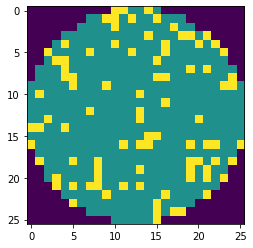

Faulty case : ['none'] 
1


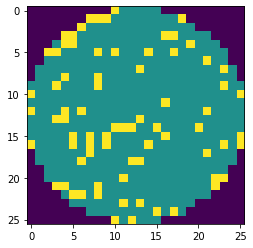

Faulty case : ['none'] 
2


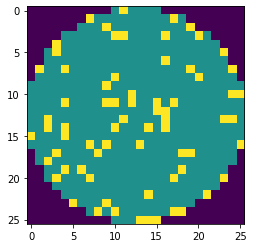

Faulty case : ['none'] 
3


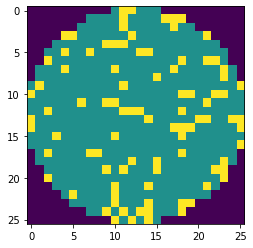

Faulty case : ['none'] 
4


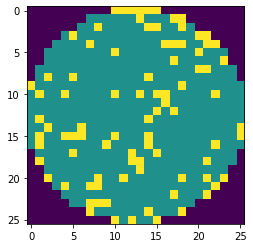

Faulty case : ['none'] 
5


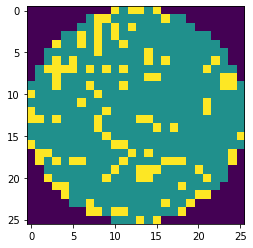

Faulty case : ['none'] 
6


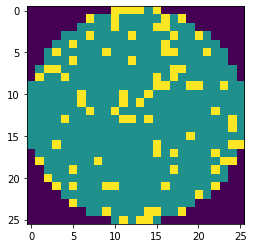

Faulty case : ['none'] 
7


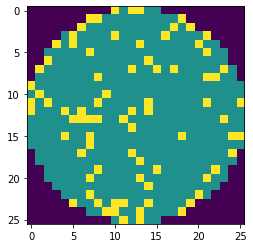

Faulty case : ['none'] 
8


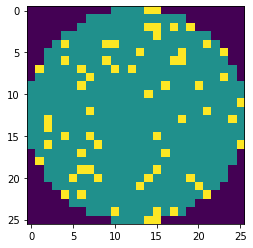

Faulty case : ['none'] 
9


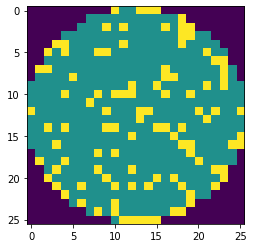

Faulty case : ['none'] 
10


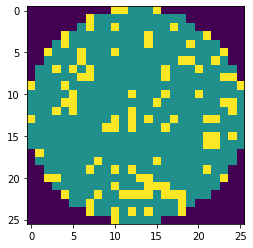

Faulty case : ['none'] 
11


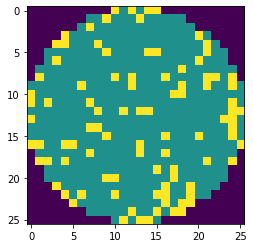

Faulty case : ['none'] 
12


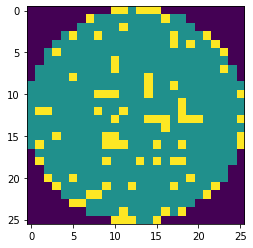

Faulty case : ['none'] 
13


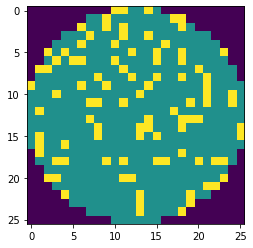

Faulty case : ['none'] 
14


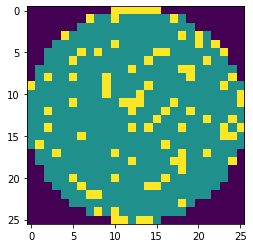

Faulty case : ['none'] 
15


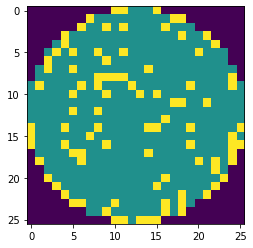

Faulty case : ['none'] 
16


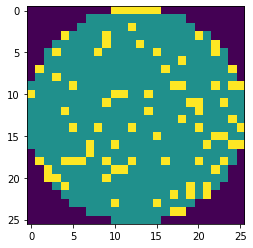

Faulty case : ['none'] 
17


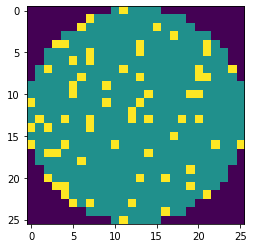

Faulty case : ['none'] 
18


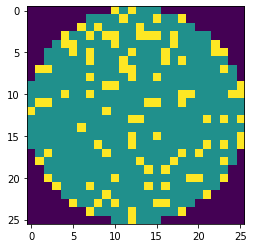

Faulty case : ['none'] 
19


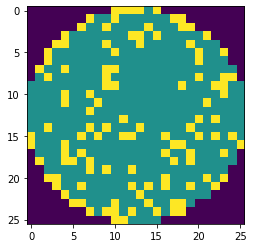

Faulty case : ['none'] 
20


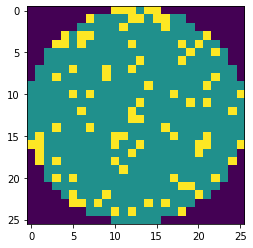

Faulty case : ['none'] 
21


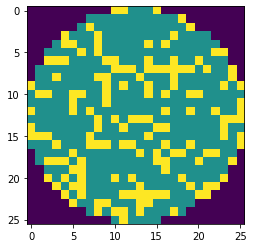

Faulty case : ['none'] 
22


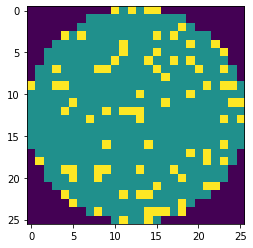

Faulty case : ['none'] 
23


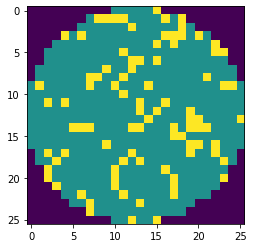

Faulty case : ['none'] 
24


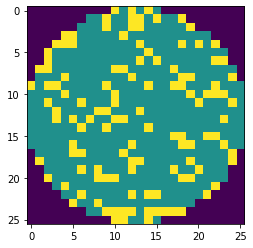

Faulty case : ['none'] 
25


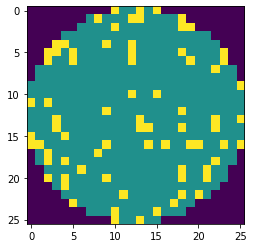

Faulty case : ['none'] 
26


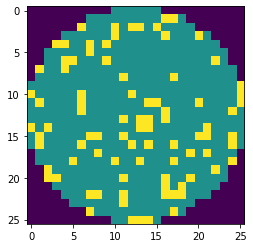

Faulty case : ['none'] 
28


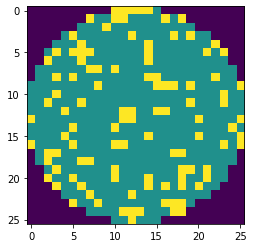

Faulty case : ['none'] 
29


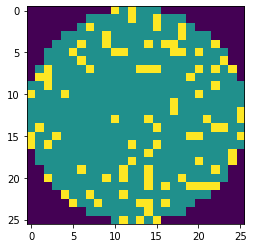

Faulty case : ['none'] 
30


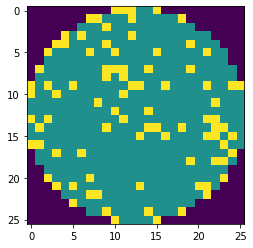

Faulty case : ['none'] 
31


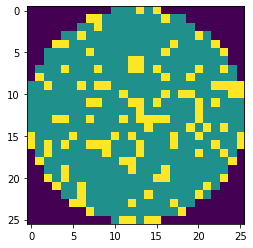

Faulty case : ['none'] 
32


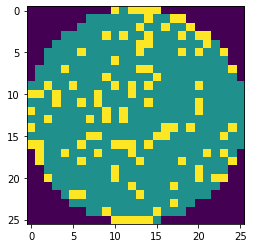

Faulty case : ['none'] 
33


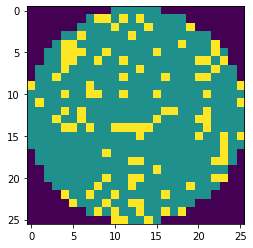

Faulty case : ['none'] 
34


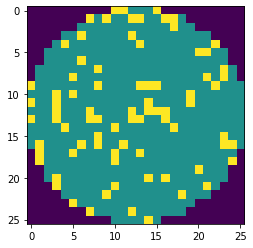

Faulty case : ['none'] 
35


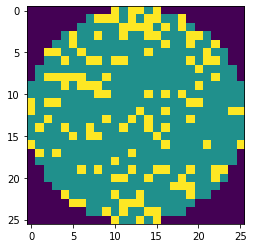

Faulty case : ['none'] 
36


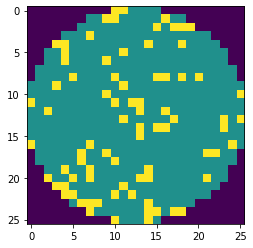

Faulty case : ['none'] 
37


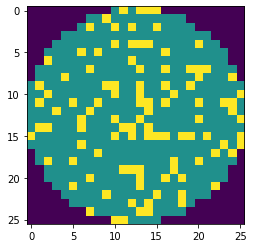

Faulty case : ['none'] 
38


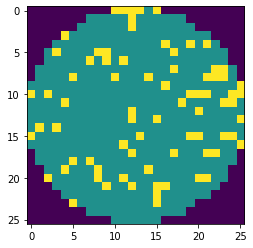

Faulty case : ['none'] 
39


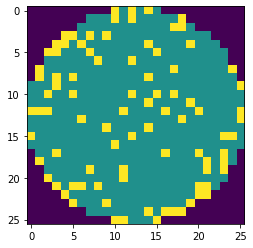

Faulty case : ['none'] 
40


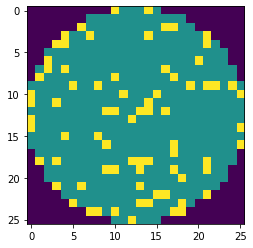

Faulty case : ['none'] 
41


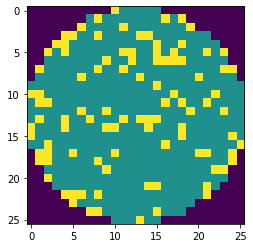

Faulty case : ['none'] 
42


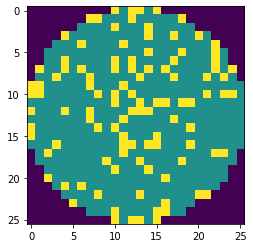

Faulty case : ['none'] 
43


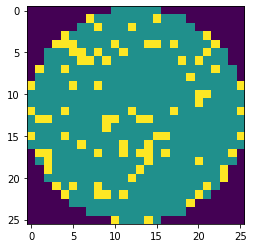

Faulty case : ['none'] 
44


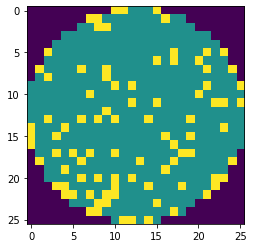

Faulty case : ['none'] 
45


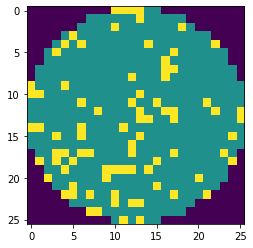

Faulty case : ['none'] 
46


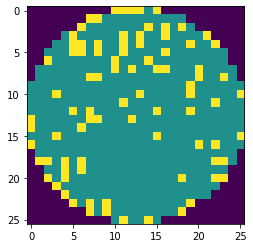

Faulty case : ['none'] 
47


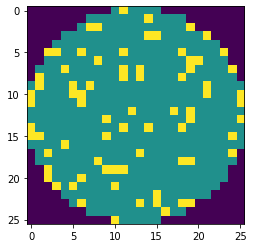

Faulty case : ['none'] 
48


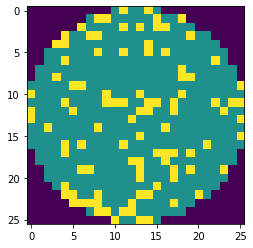

Faulty case : ['none'] 
49


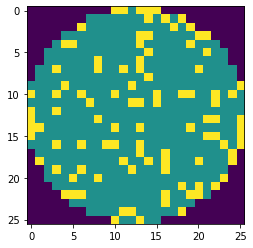

Faulty case : ['none'] 
50


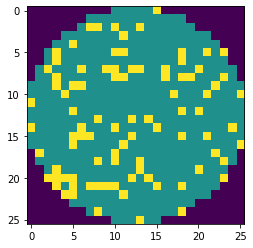

Faulty case : ['none'] 
51


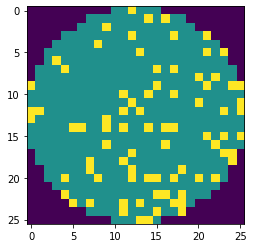

Faulty case : ['none'] 
52


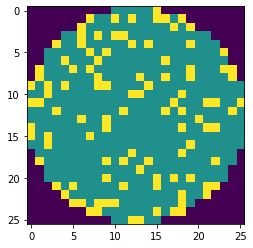

Faulty case : ['none'] 
53


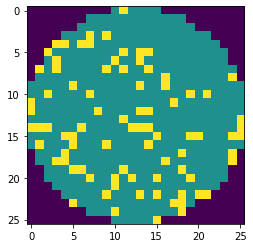

Faulty case : ['none'] 
54


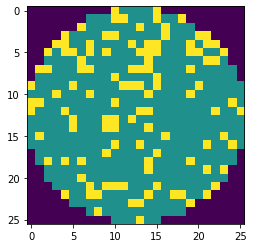

Faulty case : ['none'] 
55


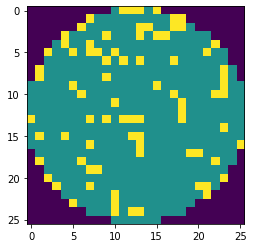

Faulty case : ['none'] 
56


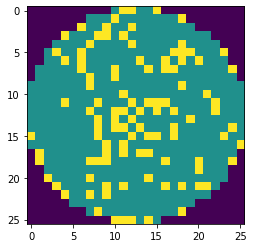

Faulty case : ['none'] 
57


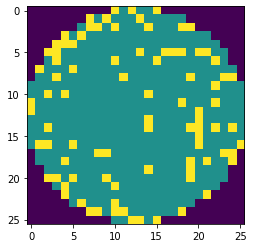

Faulty case : ['none'] 
58


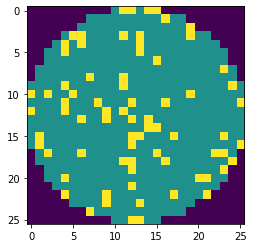

Faulty case : ['none'] 
59


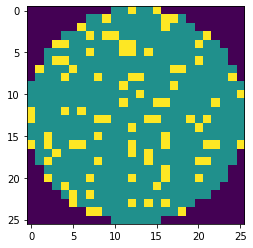

Faulty case : ['none'] 
60


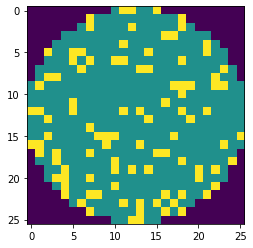

Faulty case : ['none'] 
61


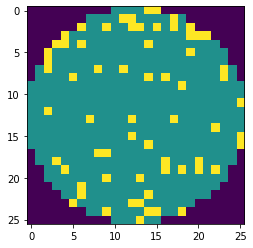

Faulty case : ['none'] 
62


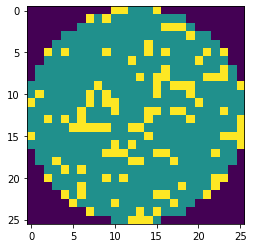

Faulty case : ['none'] 
63


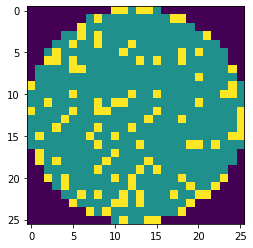

Faulty case : ['none'] 
64


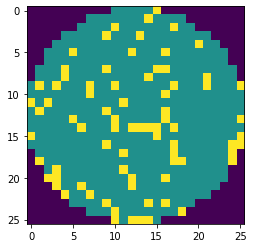

Faulty case : ['none'] 
65


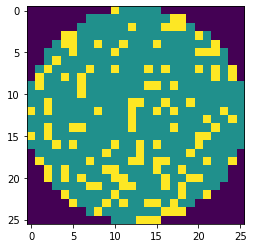

Faulty case : ['none'] 
66


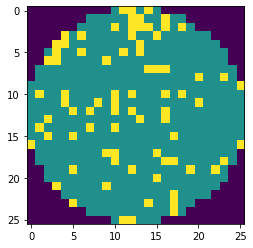

Faulty case : ['none'] 
67


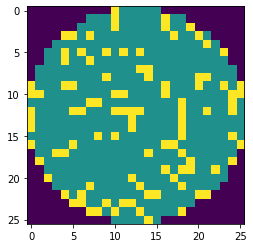

Faulty case : ['none'] 
68


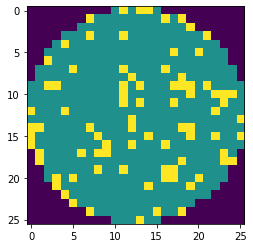

Faulty case : ['none'] 
69


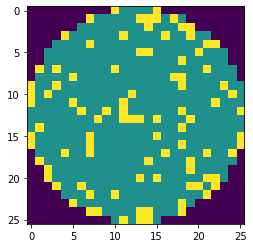

Faulty case : ['none'] 
70


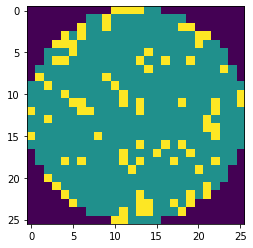

Faulty case : ['none'] 
71


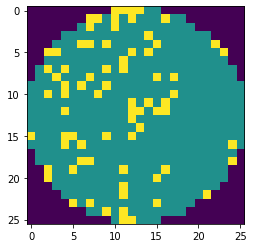

Faulty case : ['none'] 
72


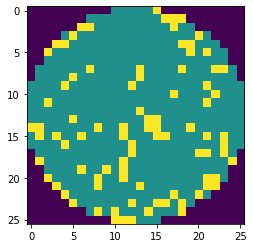

Faulty case : ['none'] 
73


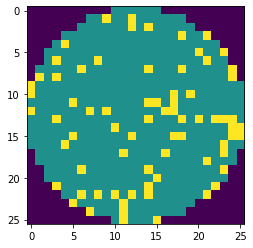

Faulty case : ['none'] 
74


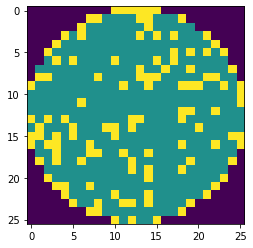

Faulty case : ['none'] 
75


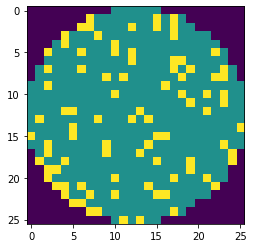

Faulty case : ['none'] 
76


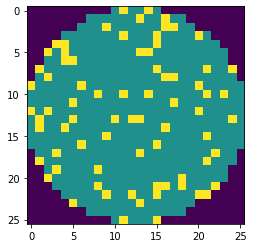

Faulty case : ['none'] 
77


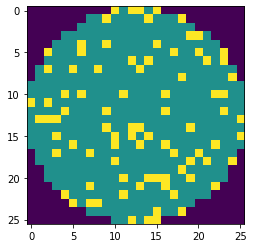

Faulty case : ['none'] 
78


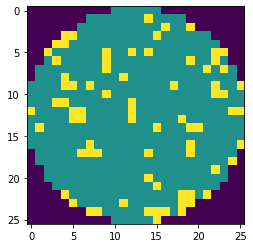

Faulty case : ['none'] 
79


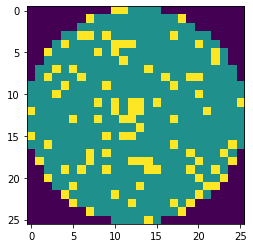

Faulty case : ['none'] 
80


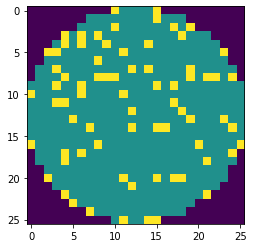

Faulty case : ['none'] 
81


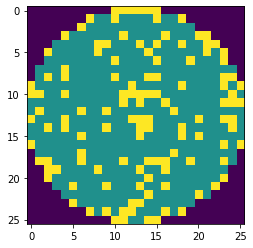

Faulty case : ['none'] 
82


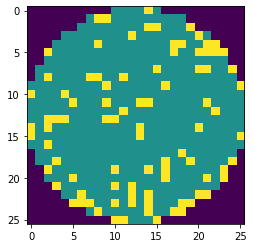

Faulty case : ['none'] 
83


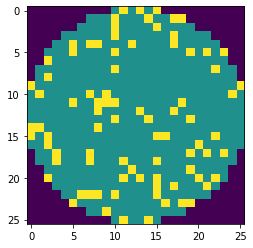

Faulty case : ['none'] 
84


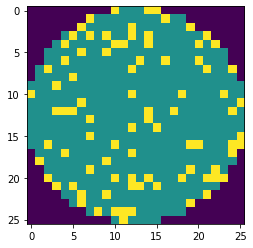

Faulty case : ['none'] 
85


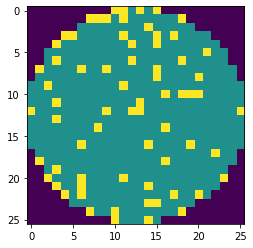

Faulty case : ['none'] 
86


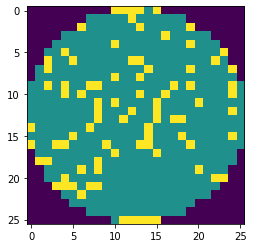

Faulty case : ['none'] 
87


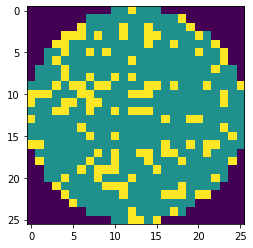

Faulty case : ['none'] 
88


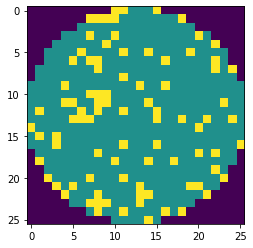

Faulty case : ['none'] 
89


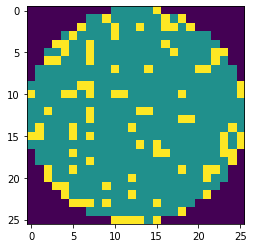

Faulty case : ['none'] 
90


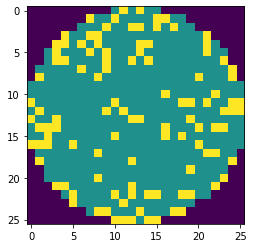

Faulty case : ['none'] 
91


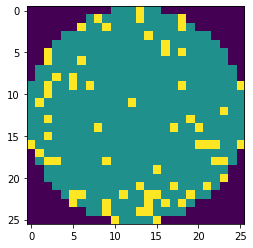

Faulty case : ['none'] 
92


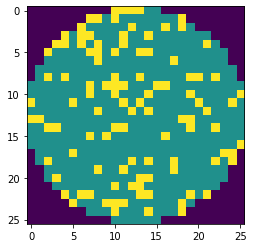

Faulty case : ['none'] 
93


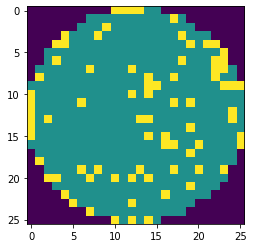

Faulty case : ['none'] 
94


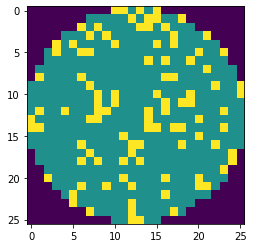

Faulty case : ['none'] 
95


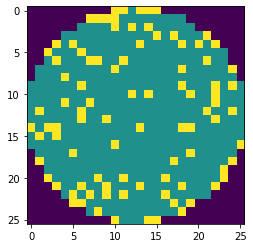

Faulty case : ['none'] 
96


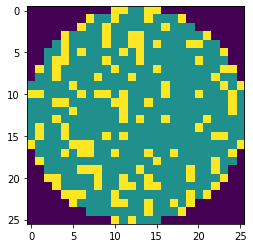

Faulty case : ['none'] 
97


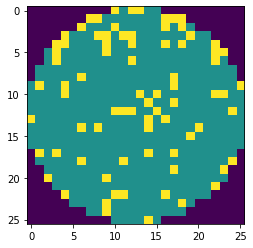

Faulty case : ['none'] 
98


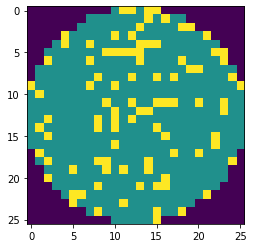

Faulty case : ['none'] 
100


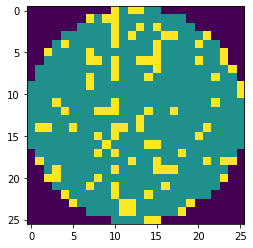

Faulty case : ['none'] 
101


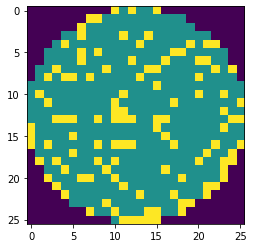

Faulty case : ['none'] 
102


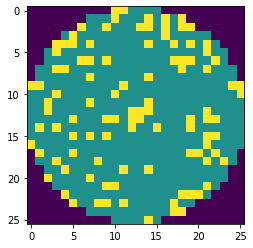

Faulty case : ['none'] 
103


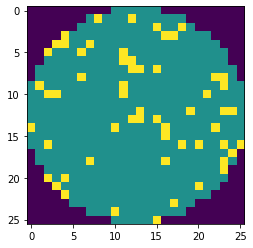

Faulty case : ['none'] 
104


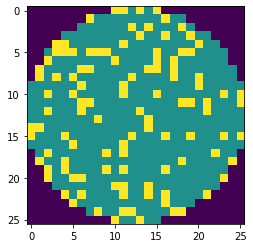

Faulty case : ['none'] 
105


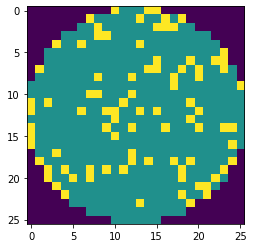

Faulty case : ['none'] 
106


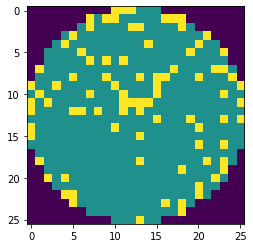

Faulty case : ['none'] 
107


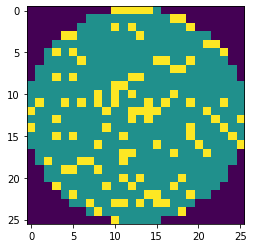

Faulty case : ['none'] 
108


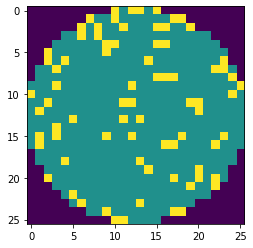

Faulty case : ['none'] 
109


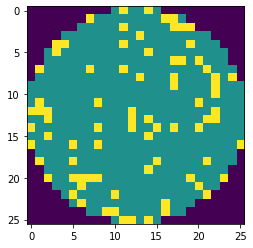

Faulty case : ['none'] 
110


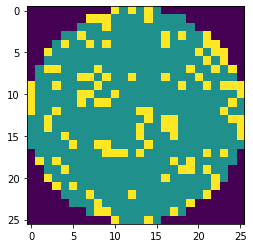

Faulty case : ['none'] 
111


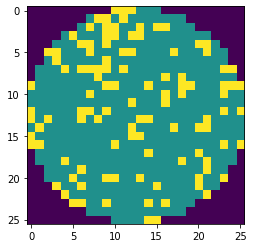

Faulty case : ['none'] 
112


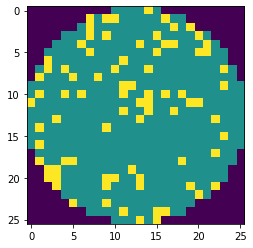

Faulty case : ['none'] 
113


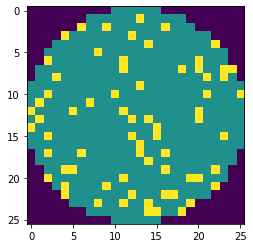

Faulty case : ['none'] 
114


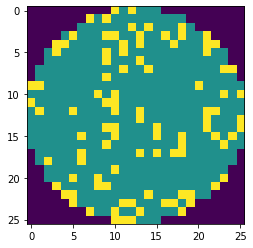

Faulty case : ['none'] 
115


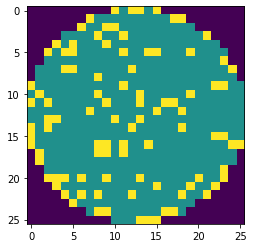

Faulty case : ['none'] 
116


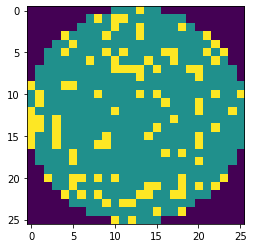

Faulty case : ['none'] 
117


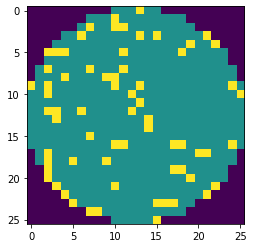

Faulty case : ['none'] 
118


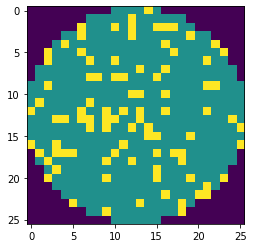

Faulty case : ['none'] 
119


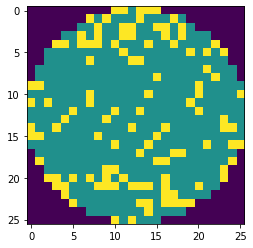

Faulty case : ['none'] 
120


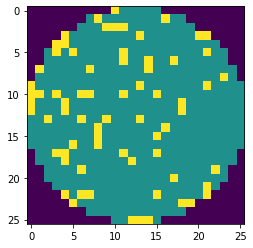

Faulty case : ['none'] 
121


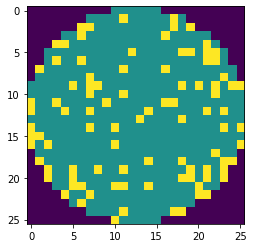

Faulty case : ['none'] 
122


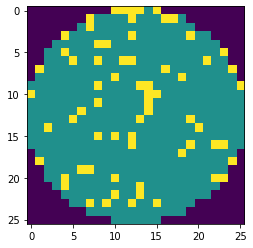

Faulty case : ['none'] 
123


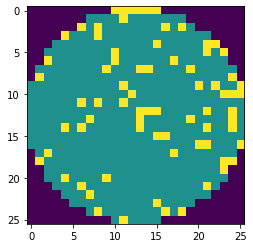

Faulty case : ['none'] 
124


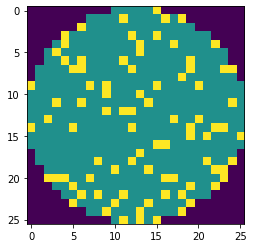

Faulty case : ['none'] 
125


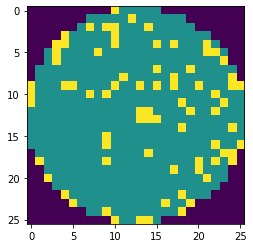

Faulty case : ['none'] 
126


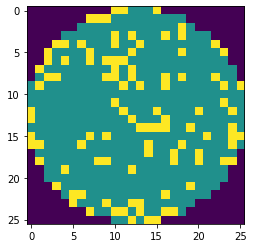

Faulty case : ['none'] 
127


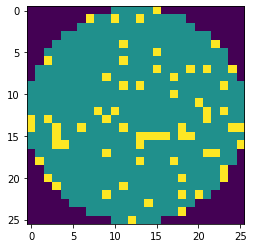

Faulty case : ['none'] 
128


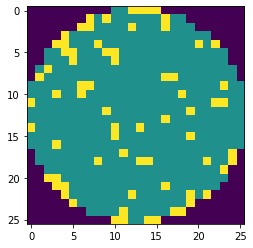

Faulty case : ['none'] 
129


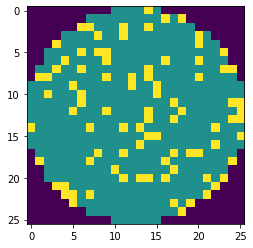

Faulty case : ['none'] 
130


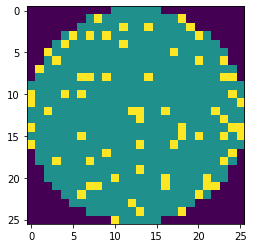

Faulty case : ['none'] 
131


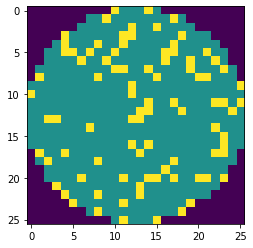

Faulty case : ['none'] 
132


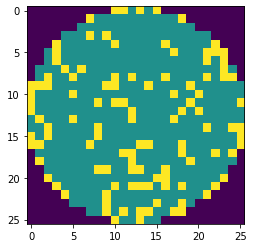

Faulty case : ['none'] 
133


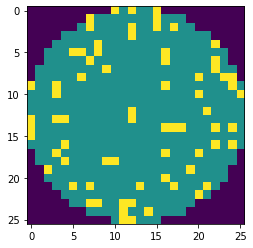

Faulty case : ['none'] 
134


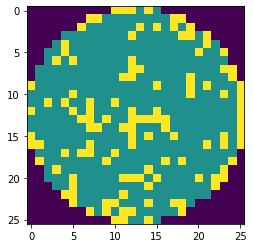

Faulty case : ['none'] 
135


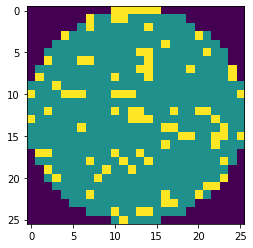

Faulty case : ['none'] 
136


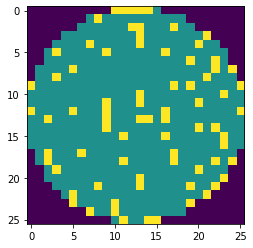

Faulty case : ['none'] 
137


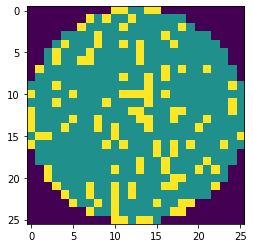

Faulty case : ['none'] 
138


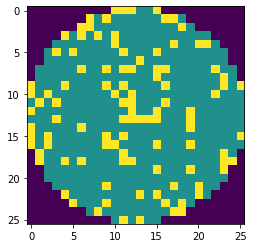

Faulty case : ['none'] 
139


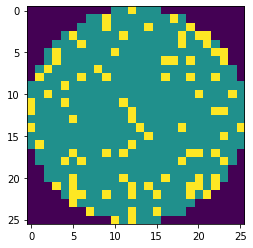

Faulty case : ['none'] 
140


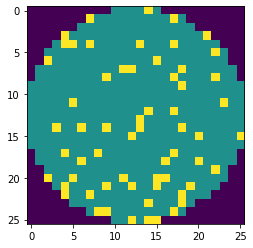

Faulty case : ['none'] 
141


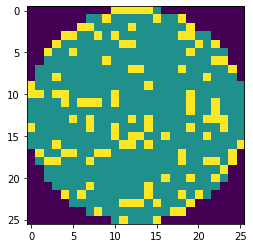

Faulty case : ['none'] 
142


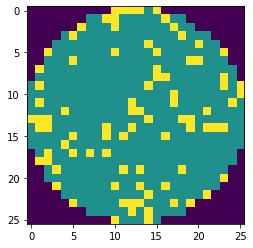

Faulty case : ['none'] 
143


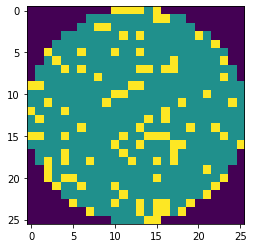

Faulty case : ['none'] 
144


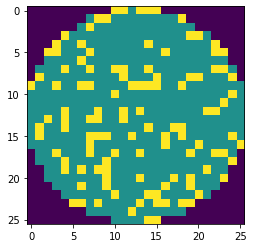

Faulty case : ['none'] 
145


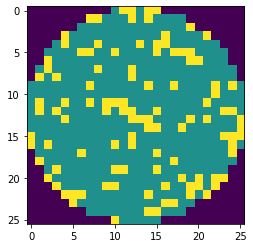

Faulty case : ['none'] 
146


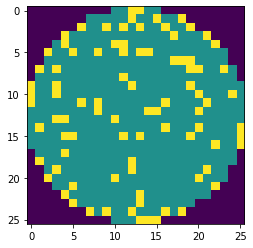

Faulty case : ['none'] 
147


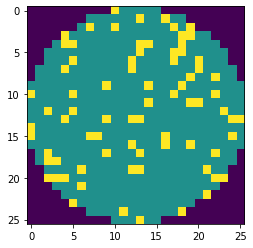

Faulty case : ['none'] 
148


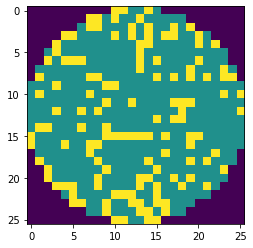

Faulty case : ['none'] 
149


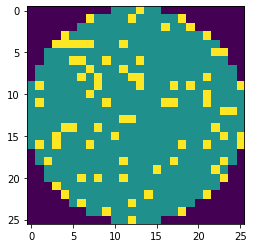

Faulty case : ['none'] 
150


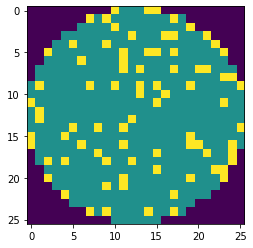

Faulty case : ['none'] 
151


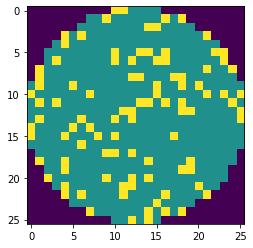

Faulty case : ['none'] 
152


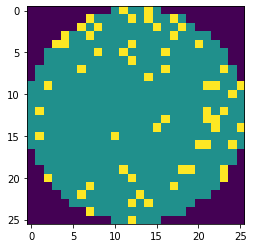

Faulty case : ['none'] 
153


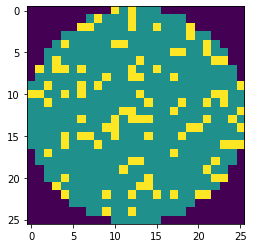

Faulty case : ['none'] 
154


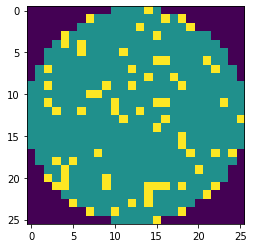

Faulty case : ['none'] 
155


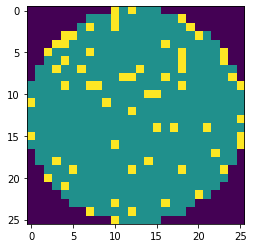

Faulty case : ['none'] 
156


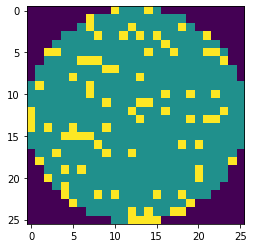

Faulty case : ['none'] 
157


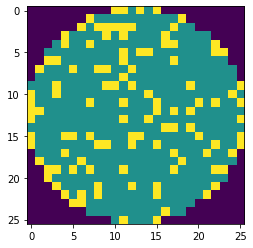

Faulty case : ['none'] 
158


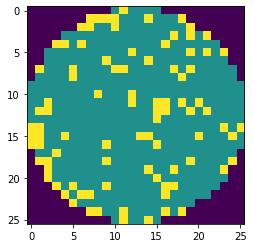

Faulty case : ['none'] 
159


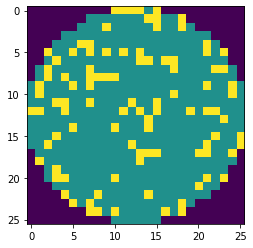

Faulty case : ['none'] 
160


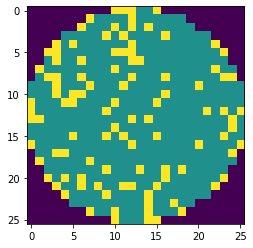

Faulty case : ['none'] 
161


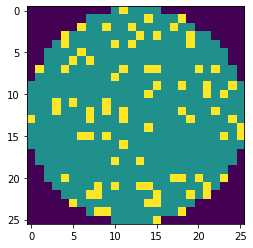

Faulty case : ['none'] 
162


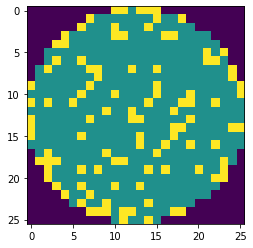

Faulty case : ['none'] 
163


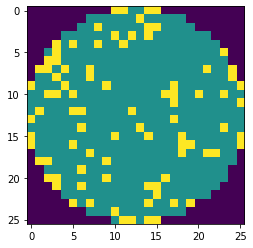

Faulty case : ['none'] 
164


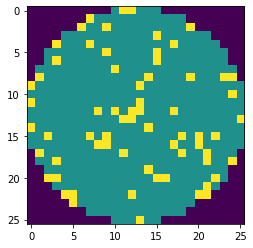

Faulty case : ['none'] 
165


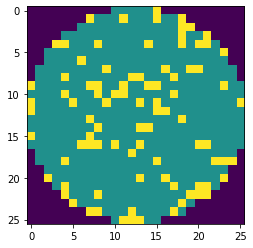

Faulty case : ['none'] 
166


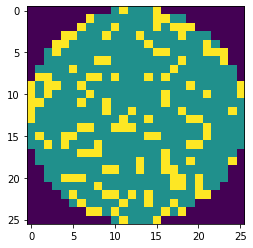

Faulty case : ['none'] 
167


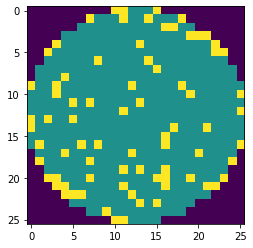

Faulty case : ['none'] 
168


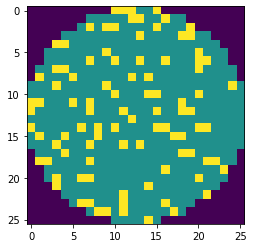

Faulty case : ['none'] 
169


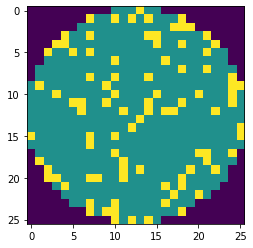

Faulty case : ['none'] 
170


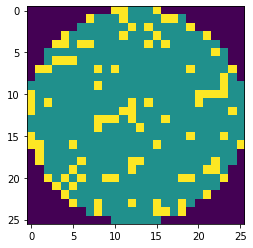

Faulty case : ['none'] 
171


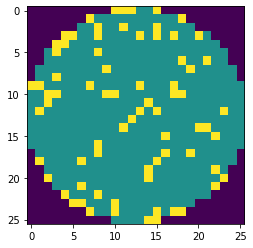

Faulty case : ['none'] 
172


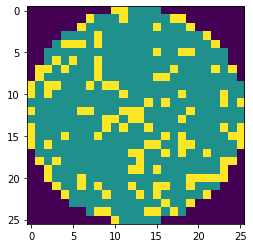

Faulty case : ['none'] 
173


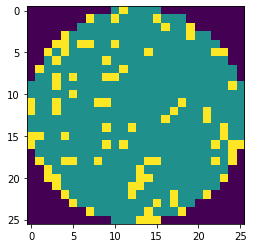

Faulty case : ['none'] 
174


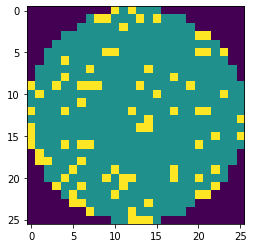

Faulty case : ['none'] 
175


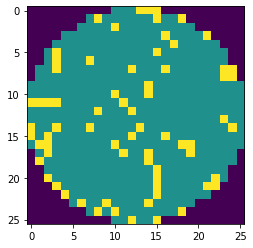

Faulty case : ['none'] 
176


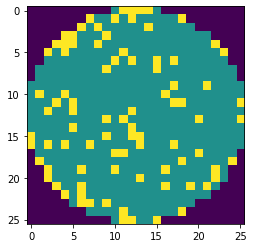

Faulty case : ['none'] 
177


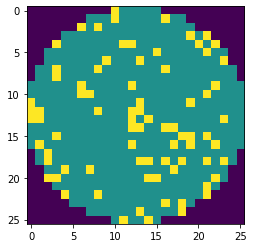

Faulty case : ['none'] 
178


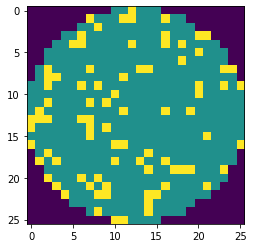

Faulty case : ['none'] 
179


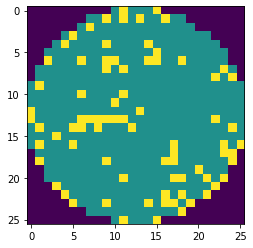

Faulty case : ['none'] 
180


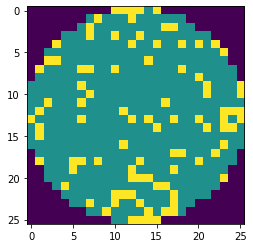

Faulty case : ['none'] 
181


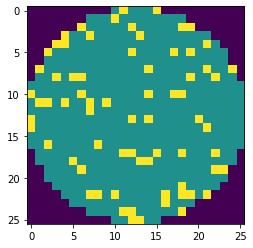

Faulty case : ['none'] 
182


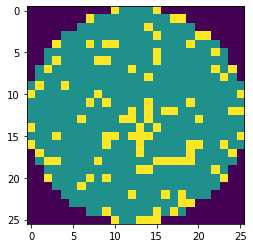

Faulty case : ['none'] 
183


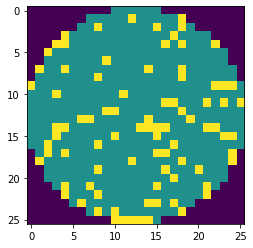

Faulty case : ['none'] 
184


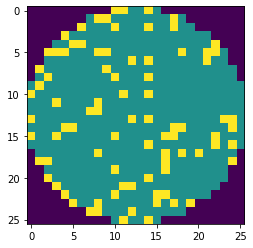

Faulty case : ['none'] 
185


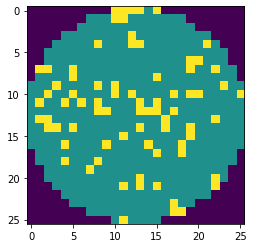

Faulty case : ['none'] 
186


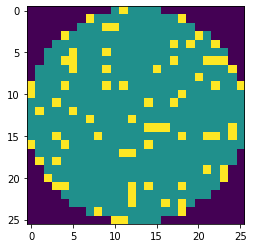

Faulty case : ['none'] 
187


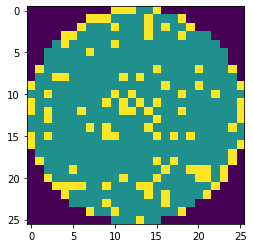

Faulty case : ['none'] 
188


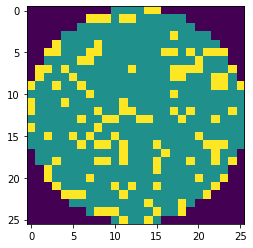

Faulty case : ['none'] 
189


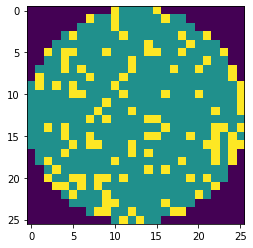

Faulty case : ['none'] 
190


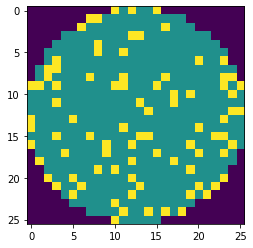

Faulty case : ['none'] 
191


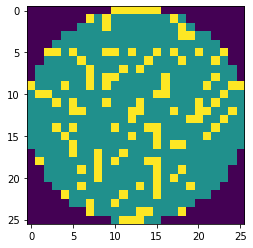

Faulty case : ['none'] 
192


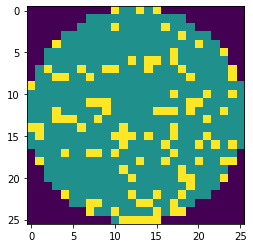

Faulty case : ['none'] 
193


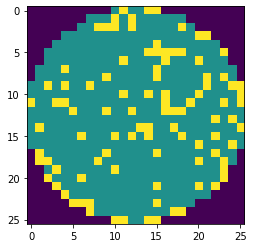

Faulty case : ['none'] 
194


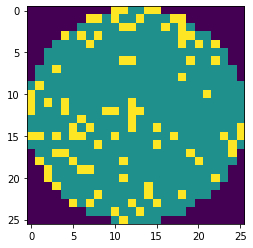

Faulty case : ['none'] 
195


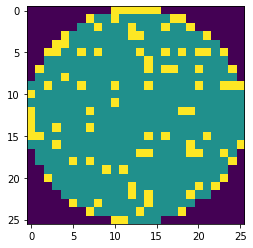

Faulty case : ['none'] 
196


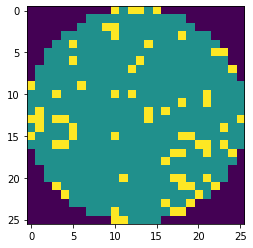

Faulty case : ['none'] 
197


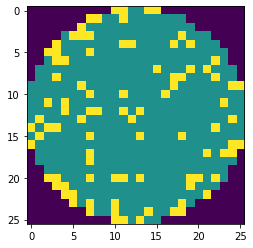

Faulty case : ['none'] 
198


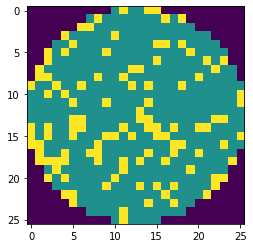

Faulty case : ['none'] 
199


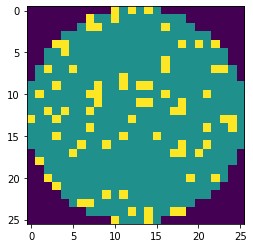

Faulty case : ['none'] 
201


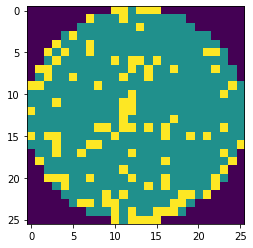

Faulty case : ['none'] 
202


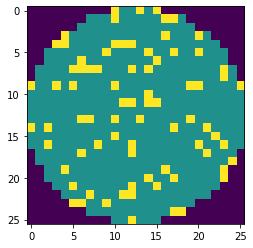

Faulty case : ['none'] 
203


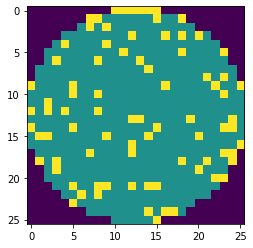

Faulty case : ['none'] 
205


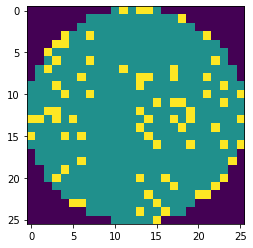

Faulty case : ['none'] 
206


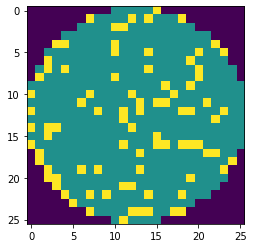

Faulty case : ['none'] 
207


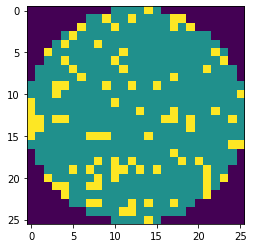

Faulty case : ['none'] 
208


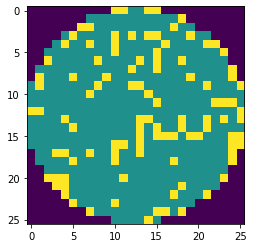

Faulty case : ['none'] 
209


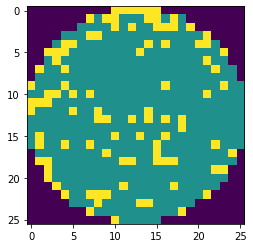

Faulty case : ['none'] 
210


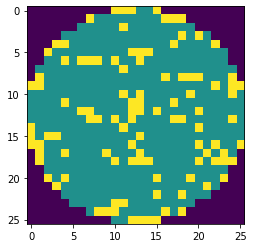

Faulty case : ['none'] 
211


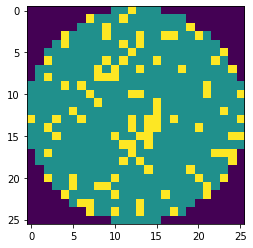

Faulty case : ['none'] 
212


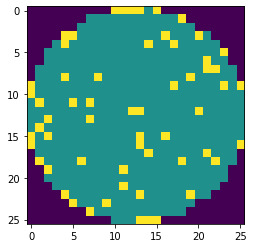

Faulty case : ['none'] 
213


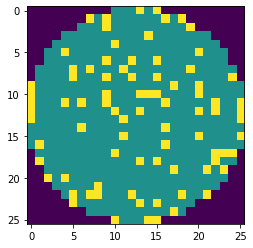

Faulty case : ['none'] 
214


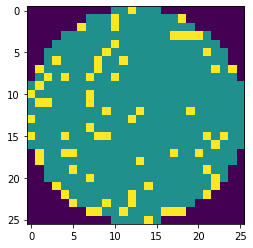

Faulty case : ['none'] 
215


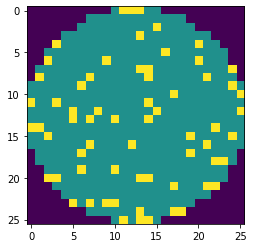

Faulty case : ['none'] 
216


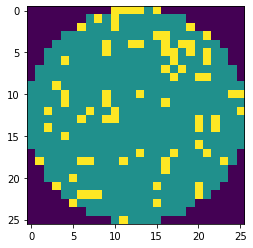

Faulty case : ['none'] 
218


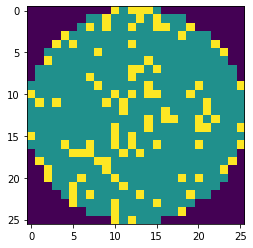

Faulty case : ['none'] 
219


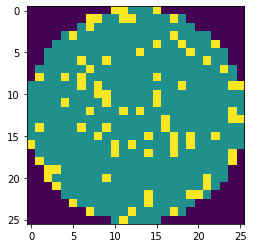

Faulty case : ['none'] 
220


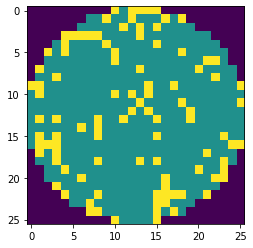

Faulty case : ['none'] 
221


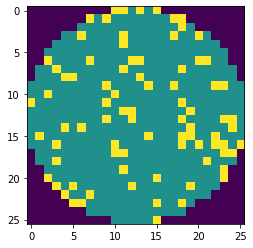

Faulty case : ['none'] 
222


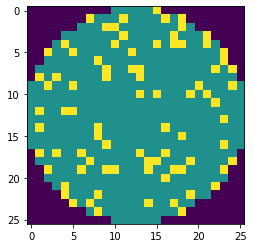

Faulty case : ['none'] 
223


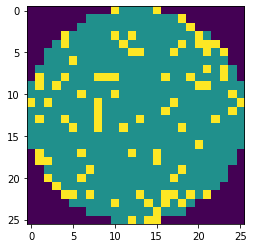

Faulty case : ['none'] 
224


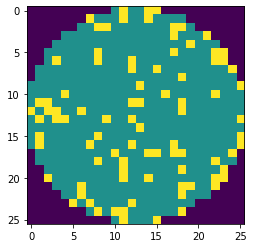

Faulty case : ['none'] 
225


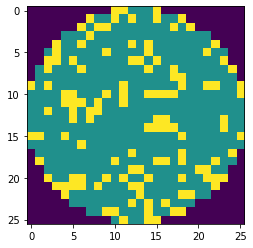

Faulty case : ['none'] 
226


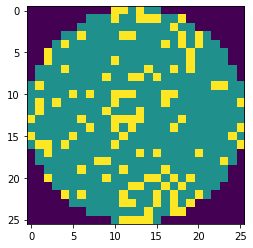

Faulty case : ['none'] 
227


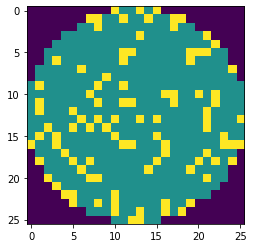

Faulty case : ['none'] 
228


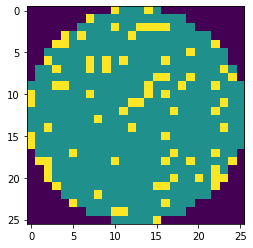

Faulty case : ['none'] 
229


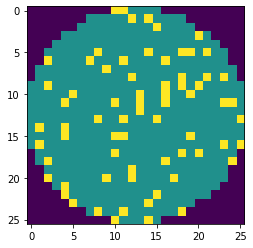

Faulty case : ['none'] 
230


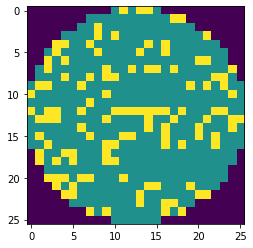

Faulty case : ['none'] 
231


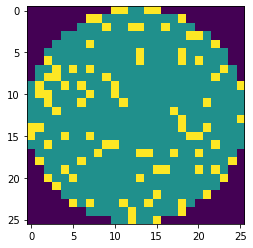

Faulty case : ['none'] 
232


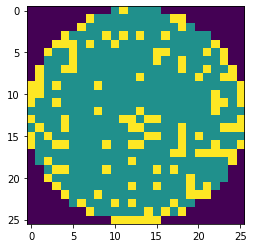

Faulty case : ['none'] 
233


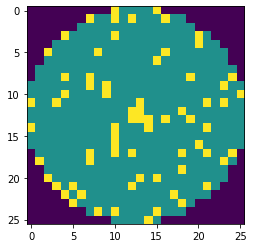

Faulty case : ['none'] 
234


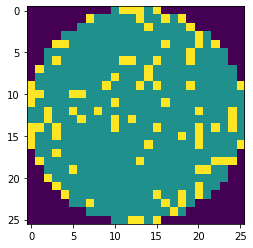

Faulty case : ['none'] 
235


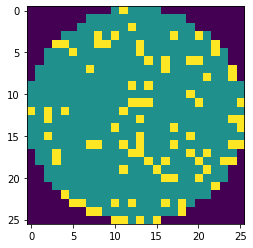

Faulty case : ['none'] 
236


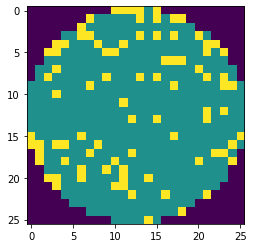

Faulty case : ['none'] 
237


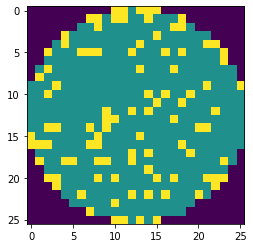

Faulty case : ['none'] 
238


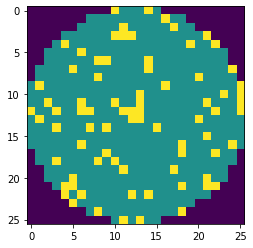

Faulty case : ['none'] 
239


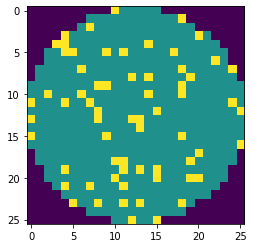

Faulty case : ['none'] 
240


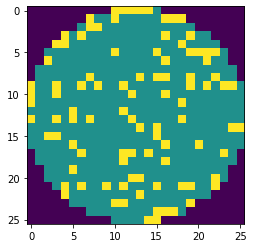

Faulty case : ['none'] 
241


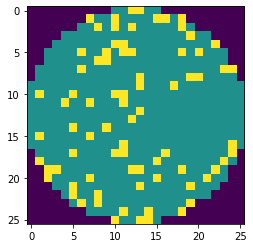

Faulty case : ['none'] 
242


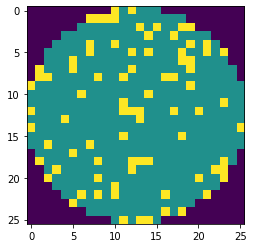

Faulty case : ['none'] 
243


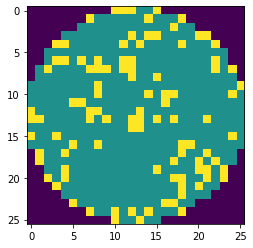

Faulty case : ['none'] 
244


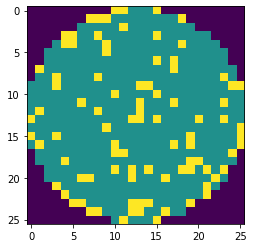

Faulty case : ['none'] 
245


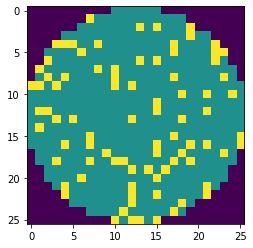

Faulty case : ['none'] 
246


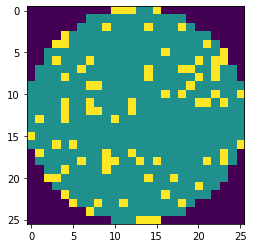

Faulty case : ['none'] 
247


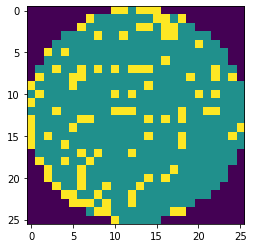

Faulty case : ['none'] 
248


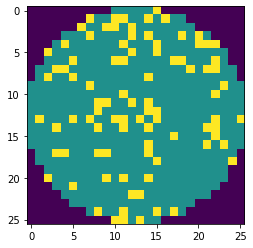

Faulty case : ['none'] 
249


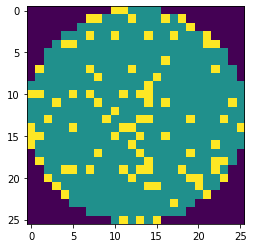

Faulty case : ['none'] 
250


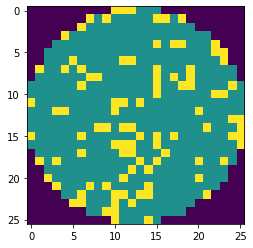

Faulty case : ['none'] 
251


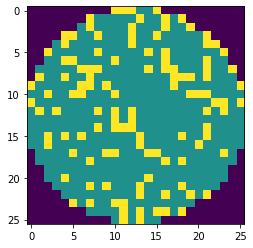

Faulty case : ['none'] 
252


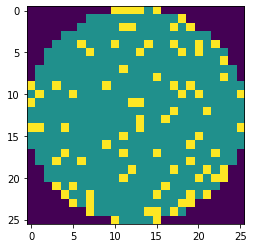

Faulty case : ['none'] 
253


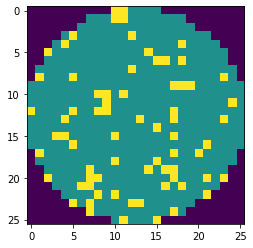

Faulty case : ['none'] 
254


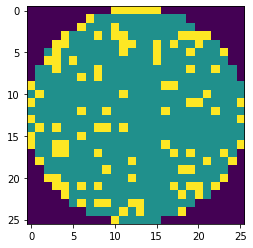

Faulty case : ['none'] 
255


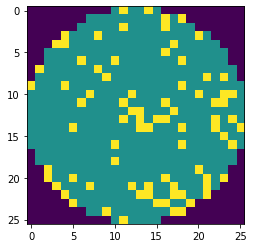

Faulty case : ['none'] 
256


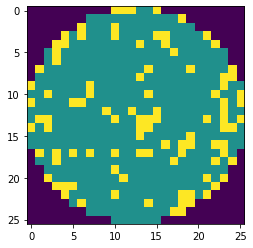

Faulty case : ['none'] 
257


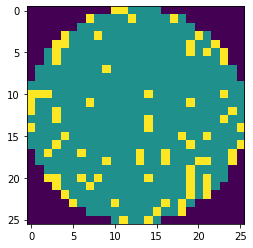

Faulty case : ['none'] 
258


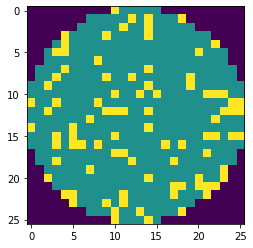

Faulty case : ['none'] 
259


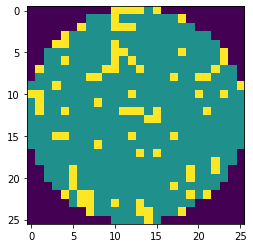

Faulty case : ['none'] 
261


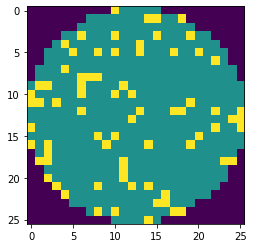

Faulty case : ['none'] 
262


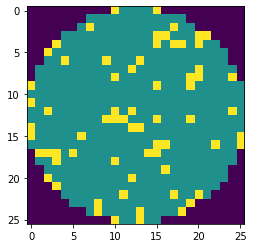

Faulty case : ['none'] 
263


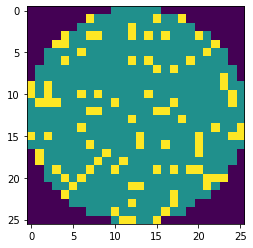

Faulty case : ['none'] 
264


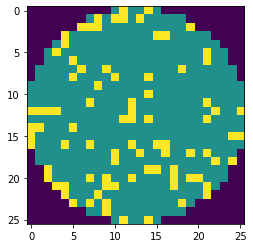

Faulty case : ['none'] 
265


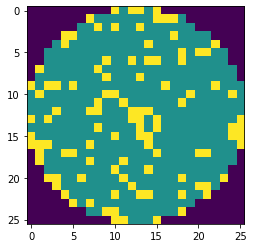

Faulty case : ['none'] 
266


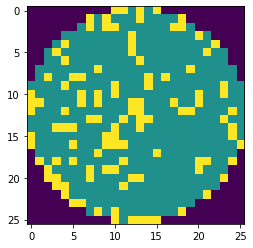

Faulty case : ['none'] 
267


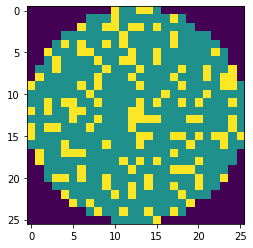

Faulty case : ['none'] 
268


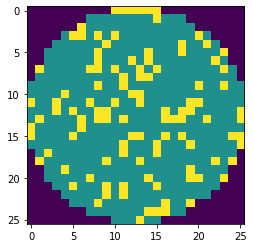

Faulty case : ['none'] 
269


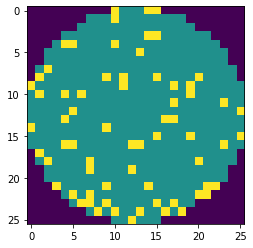

Faulty case : ['none'] 
270


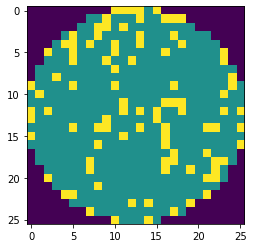

Faulty case : ['none'] 
271


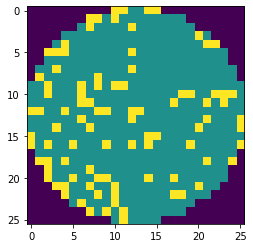

Faulty case : ['none'] 
272


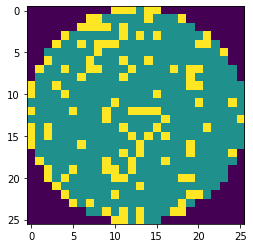

Faulty case : ['none'] 
273


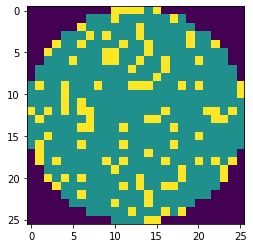

Faulty case : ['none'] 
274


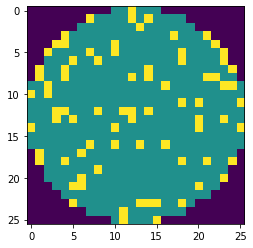

Faulty case : ['none'] 
275


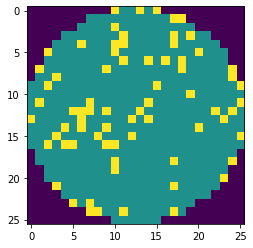

Faulty case : ['none'] 
276


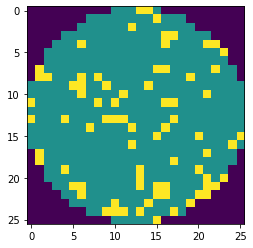

Faulty case : ['none'] 
277


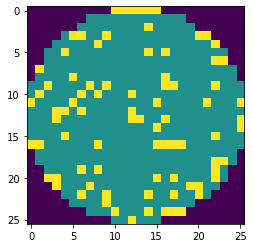

Faulty case : ['none'] 
278


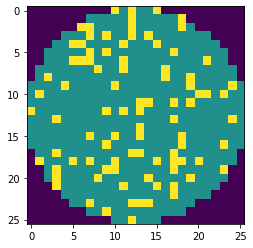

Faulty case : ['none'] 
279


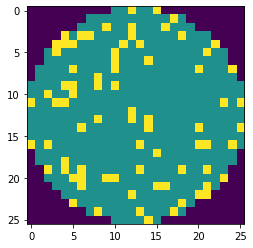

Faulty case : ['none'] 
280


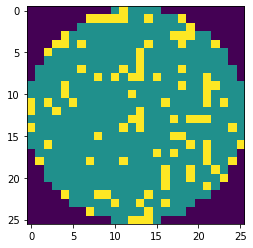

Faulty case : ['none'] 
281


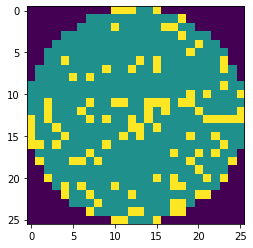

Faulty case : ['none'] 
282


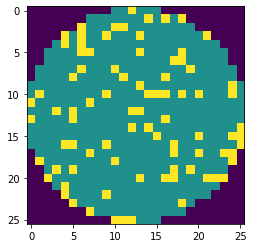

Faulty case : ['none'] 
283


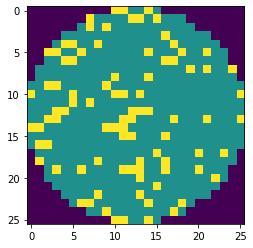

Faulty case : ['none'] 
284


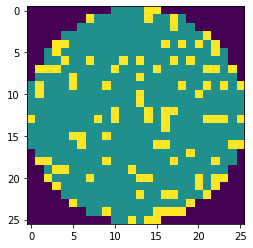

Faulty case : ['none'] 
285


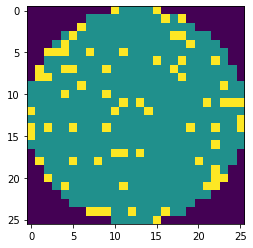

Faulty case : ['none'] 
287


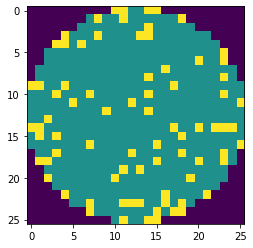

Faulty case : ['none'] 
288


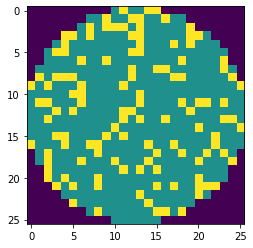

Faulty case : ['none'] 
289


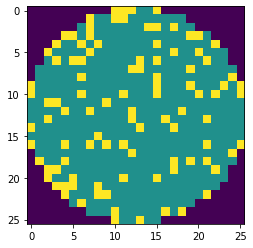

Faulty case : ['none'] 
290


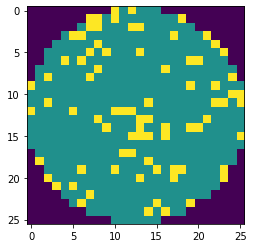

Faulty case : ['none'] 
291


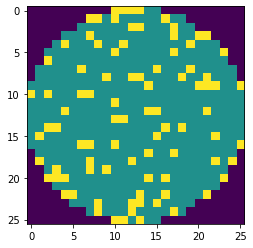

Faulty case : ['none'] 
292


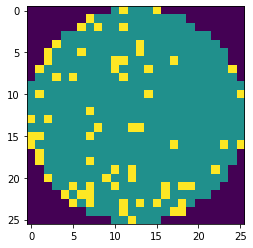

Faulty case : ['none'] 
293


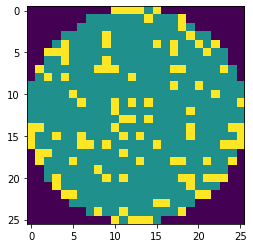

Faulty case : ['none'] 
295


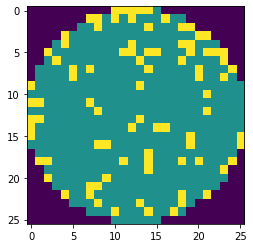

Faulty case : ['none'] 
296


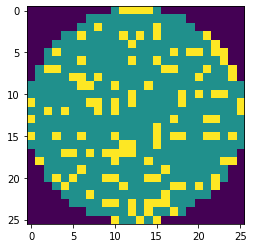

Faulty case : ['none'] 
297


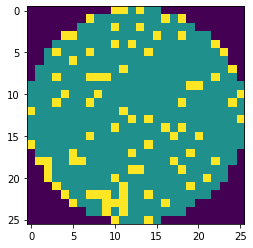

Faulty case : ['none'] 
298


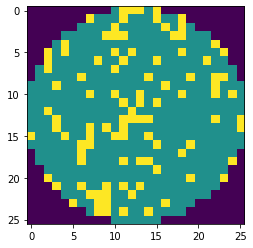

Faulty case : ['none'] 
299


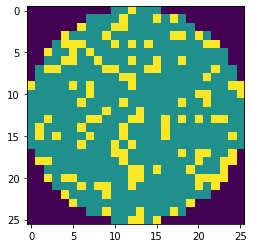

Faulty case : ['none'] 
300


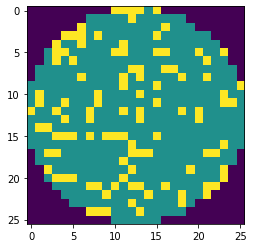

Faulty case : ['none'] 
301


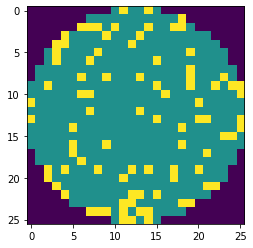

Faulty case : ['none'] 
302


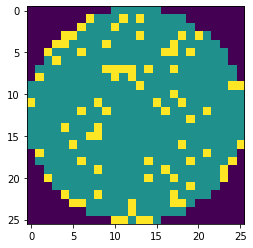

Faulty case : ['none'] 
303


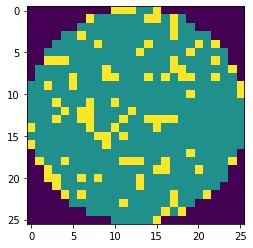

Faulty case : ['none'] 
304


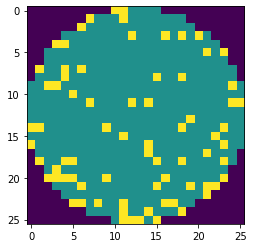

Faulty case : ['none'] 
305


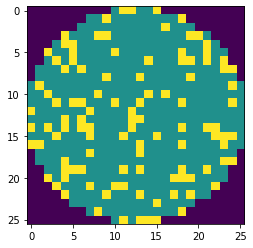

Faulty case : ['none'] 
306


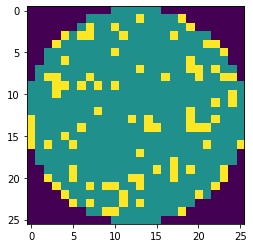

Faulty case : ['none'] 
307


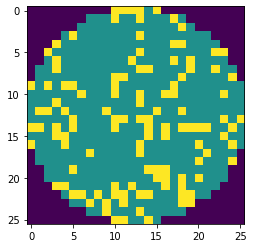

Faulty case : ['none'] 
308


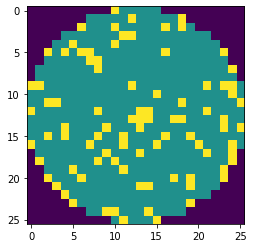

Faulty case : ['none'] 
309


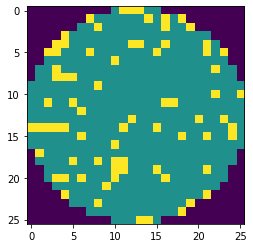

Faulty case : ['none'] 
310


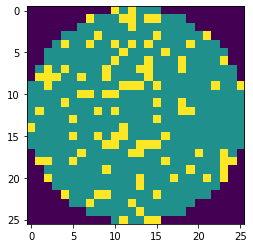

Faulty case : ['none'] 
311


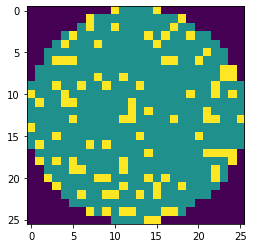

Faulty case : ['none'] 
312


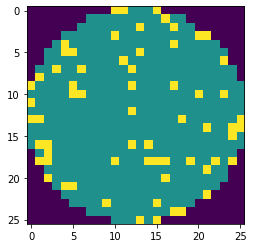

Faulty case : ['none'] 
313


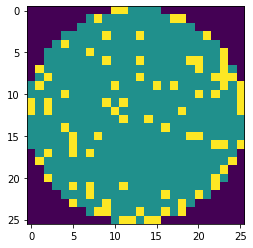

Faulty case : ['none'] 
314


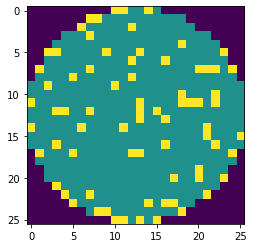

Faulty case : ['none'] 
315


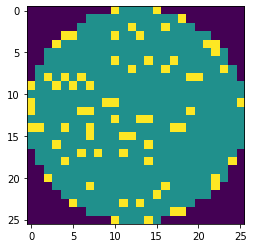

Faulty case : ['none'] 
316


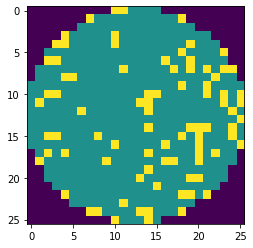

Faulty case : ['none'] 
317


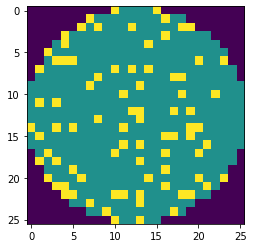

Faulty case : ['none'] 
318


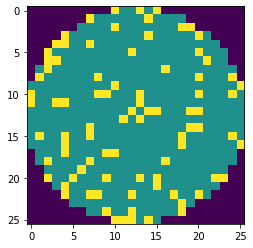

Faulty case : ['none'] 
319


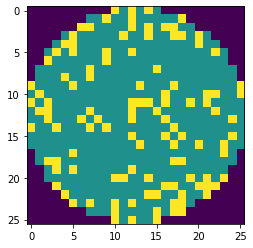

Faulty case : ['none'] 
320


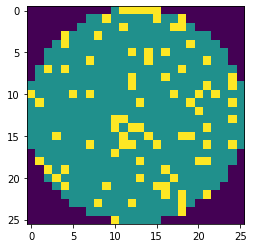

Faulty case : ['none'] 
321


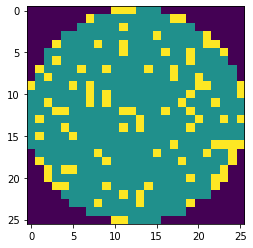

Faulty case : ['none'] 
322


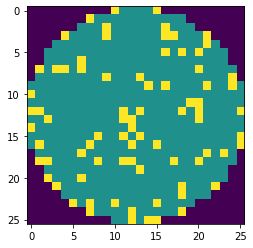

Faulty case : ['none'] 
323


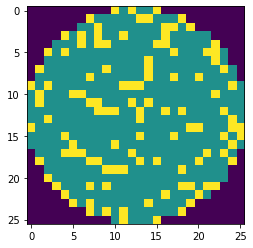

Faulty case : ['none'] 
324


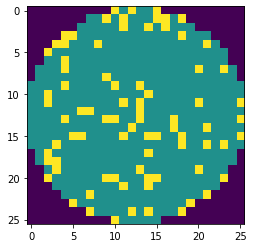

Faulty case : ['none'] 
325


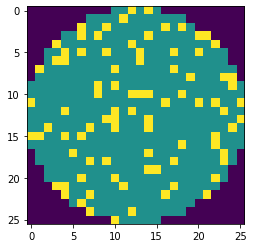

Faulty case : ['none'] 
326


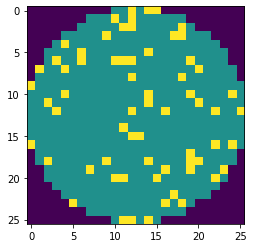

Faulty case : ['none'] 
327


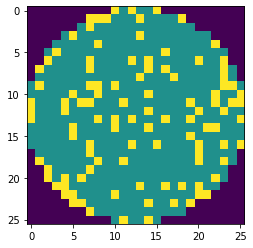

Faulty case : ['none'] 
328


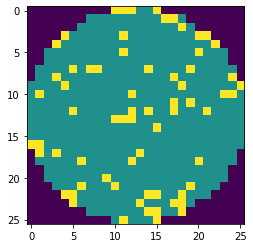

Faulty case : ['none'] 
329


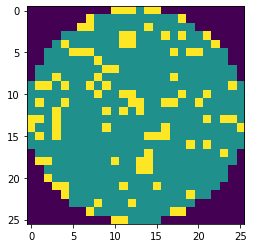

Faulty case : ['none'] 
330


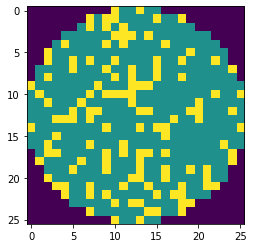

Faulty case : ['none'] 
331


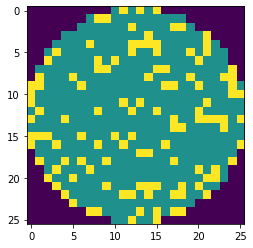

Faulty case : ['none'] 
332


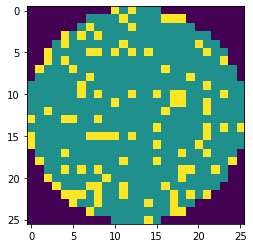

Faulty case : ['none'] 
333


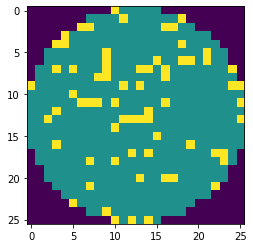

Faulty case : ['none'] 
334


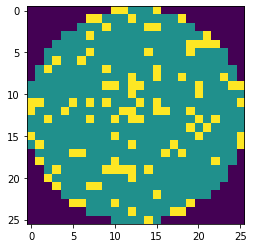

Faulty case : ['none'] 
335


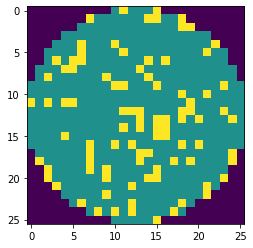

Faulty case : ['none'] 
336


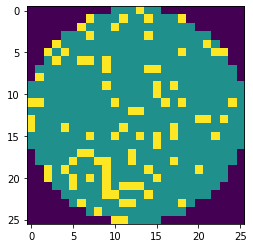

Faulty case : ['none'] 
337


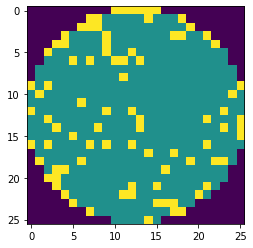

Faulty case : ['none'] 
338


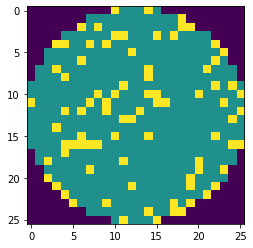

Faulty case : ['none'] 
339


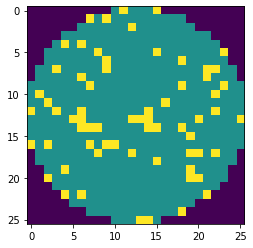

Faulty case : ['none'] 
340


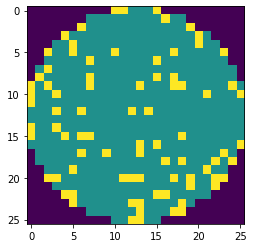

Faulty case : ['none'] 
341


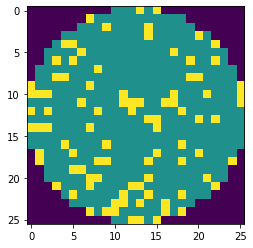

Faulty case : ['none'] 
342


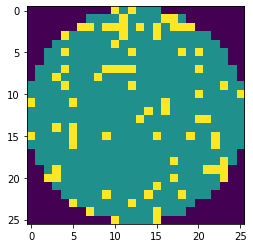

Faulty case : ['none'] 
343


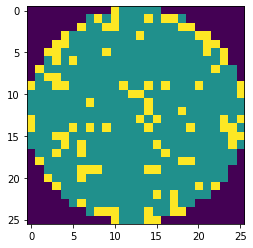

Faulty case : ['none'] 
344


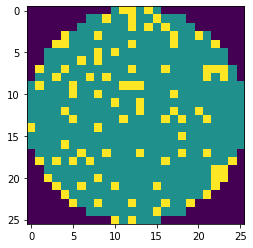

Faulty case : ['none'] 
345


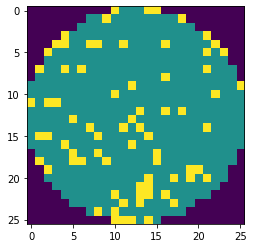

Faulty case : ['none'] 
346


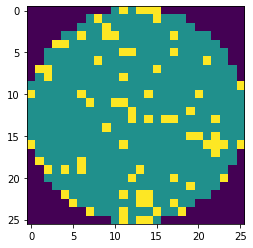

Faulty case : ['none'] 
347


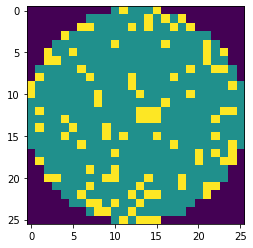

Faulty case : ['none'] 
348


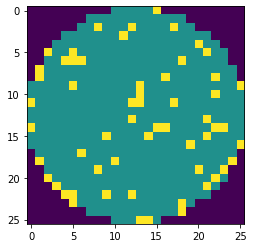

Faulty case : ['none'] 
349


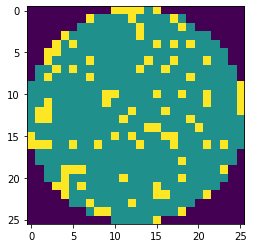

Faulty case : ['none'] 
350


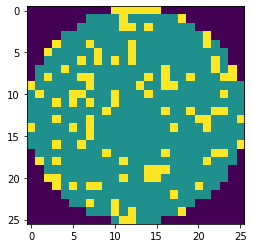

Faulty case : ['none'] 
351


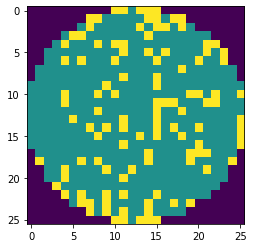

Faulty case : ['none'] 
352


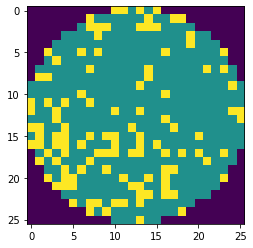

Faulty case : ['none'] 
353


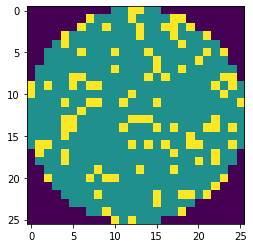

Faulty case : ['none'] 
354


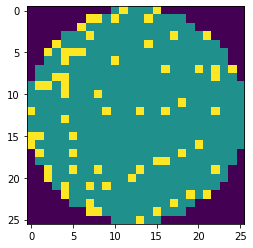

Faulty case : ['none'] 
355


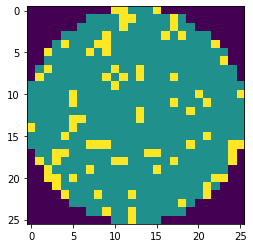

Faulty case : ['none'] 
356


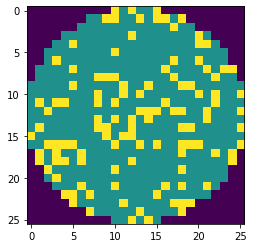

Faulty case : ['none'] 
357


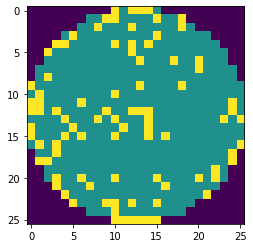

Faulty case : ['none'] 
358


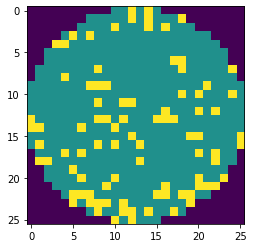

Faulty case : ['none'] 
359


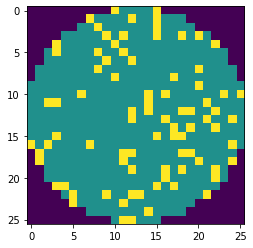

Faulty case : ['none'] 
360


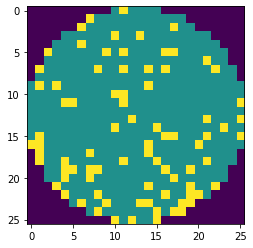

Faulty case : ['none'] 
361


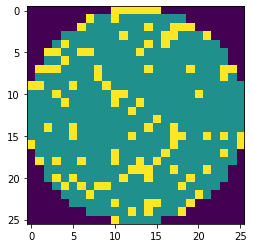

Faulty case : ['none'] 
362


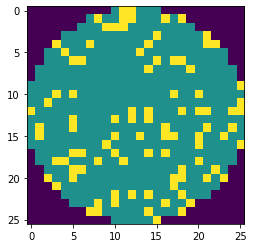

Faulty case : ['none'] 
363


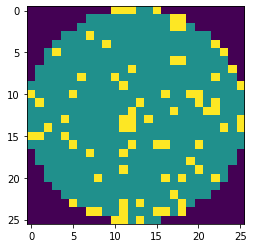

Faulty case : ['none'] 
364


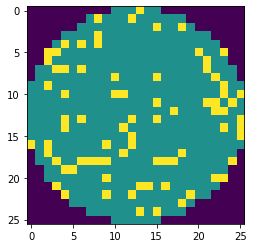

Faulty case : ['none'] 
365


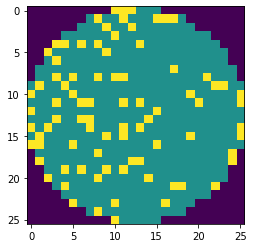

Faulty case : ['none'] 
366


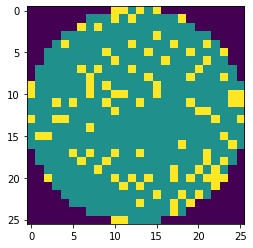

Faulty case : ['none'] 
367


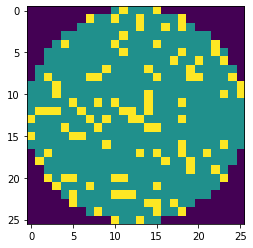

Faulty case : ['none'] 
368


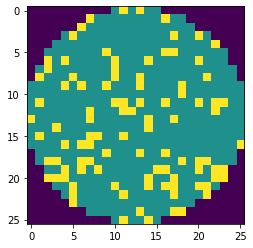

Faulty case : ['none'] 
369


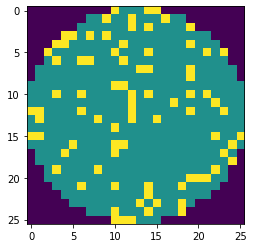

Faulty case : ['none'] 
370


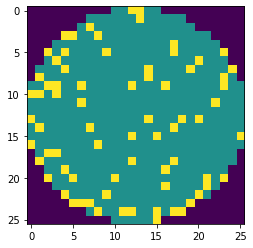

Faulty case : ['none'] 
371


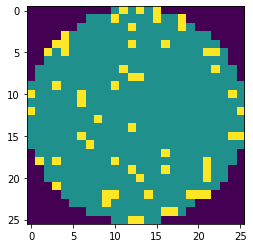

Faulty case : ['none'] 
372


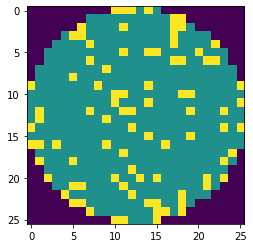

Faulty case : ['none'] 
373


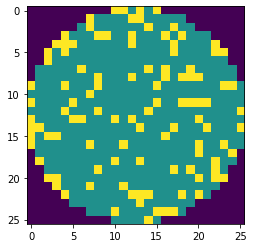

Faulty case : ['none'] 
374


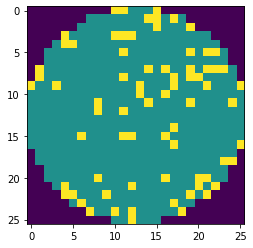

Faulty case : ['none'] 
375


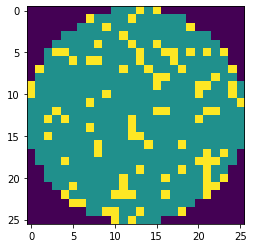

Faulty case : ['none'] 
376


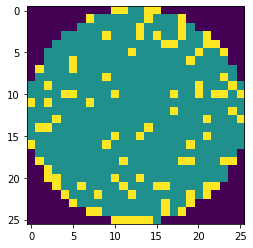

Faulty case : ['none'] 
377


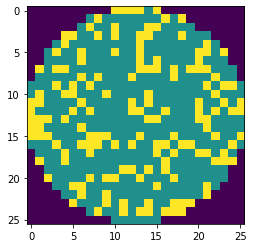

Faulty case : ['none'] 
378


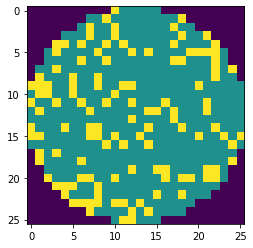

Faulty case : ['none'] 
379


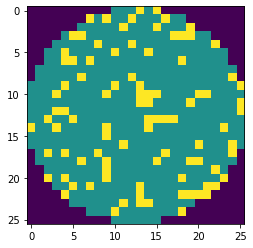

Faulty case : ['none'] 
380


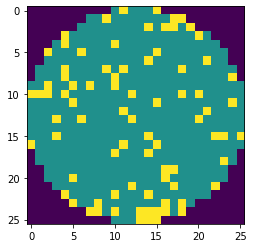

Faulty case : ['none'] 
381


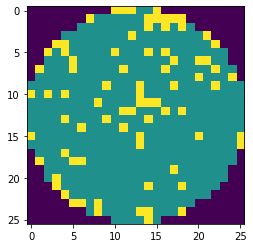

Faulty case : ['none'] 
382


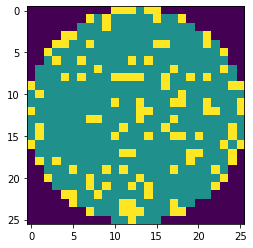

Faulty case : ['none'] 
383


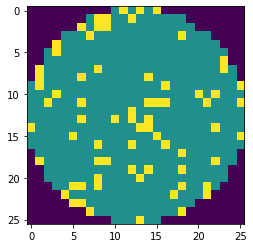

Faulty case : ['none'] 
384


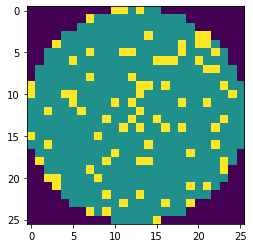

Faulty case : ['none'] 
385


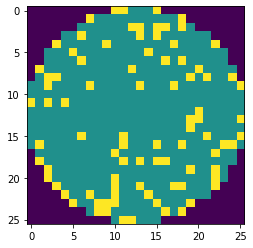

Faulty case : ['none'] 
386


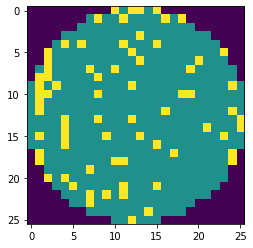

Faulty case : ['none'] 
387


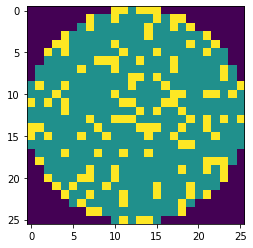

Faulty case : ['none'] 
388


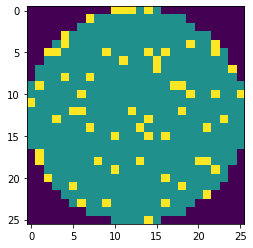

Faulty case : ['none'] 
389


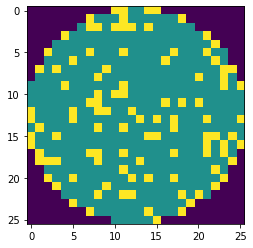

Faulty case : ['none'] 
390


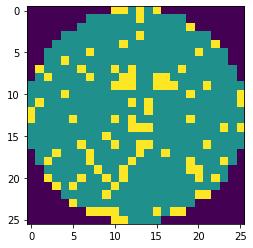

Faulty case : ['none'] 
391


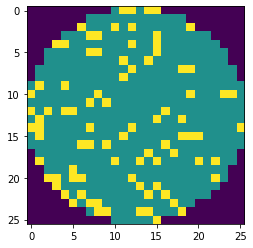

Faulty case : ['none'] 
393


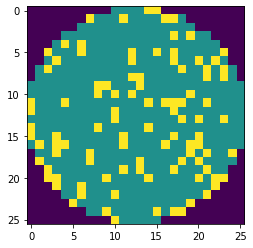

Faulty case : ['none'] 
394


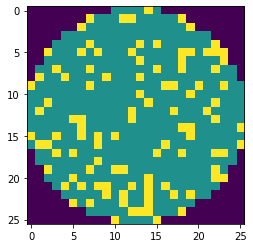

Faulty case : ['none'] 
396


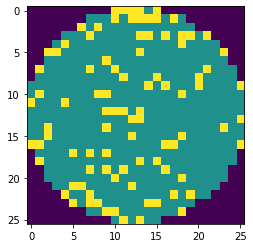

Faulty case : ['none'] 
398


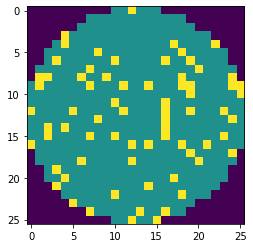

Faulty case : ['none'] 
399


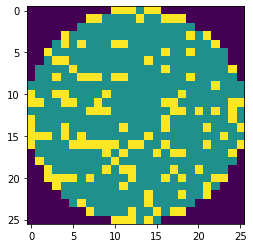

Faulty case : ['none'] 
400


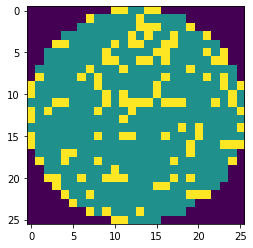

Faulty case : ['none'] 
401


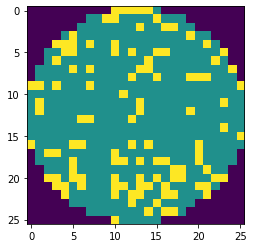

Faulty case : ['none'] 
402


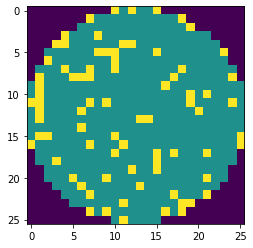

Faulty case : ['none'] 
403


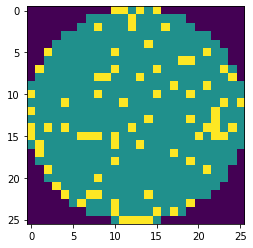

Faulty case : ['none'] 
404


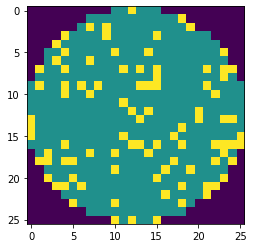

Faulty case : ['none'] 
405


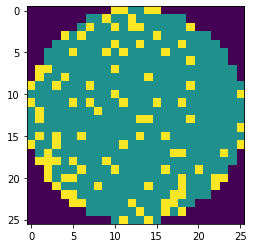

Faulty case : ['none'] 
406


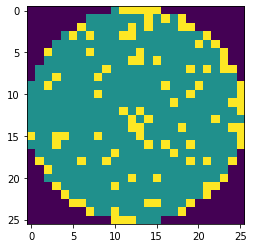

Faulty case : ['none'] 
407


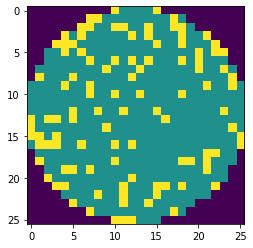

Faulty case : ['none'] 
408


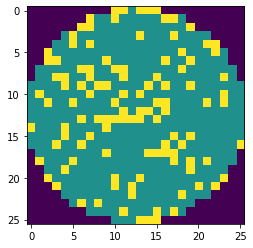

Faulty case : ['none'] 
409


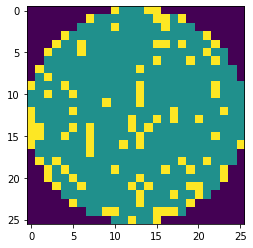

Faulty case : ['none'] 
410


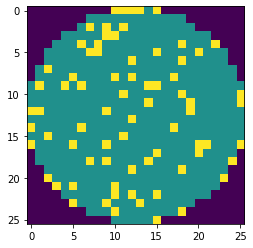

Faulty case : ['none'] 
411


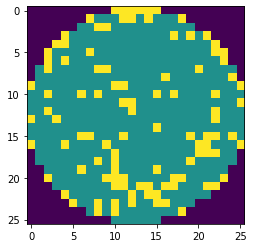

Faulty case : ['none'] 
412


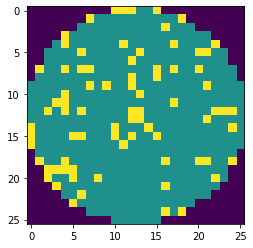

Faulty case : ['none'] 
413


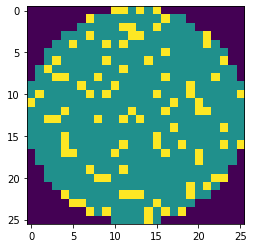

Faulty case : ['none'] 
414


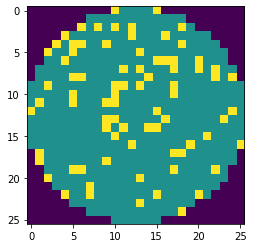

Faulty case : ['none'] 
415


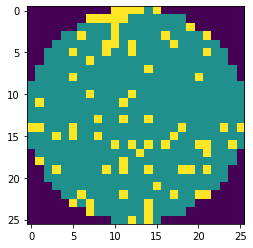

Faulty case : ['none'] 
416


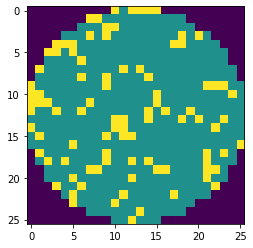

Faulty case : ['none'] 
417


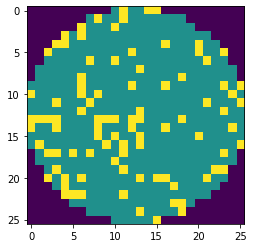

Faulty case : ['none'] 
418


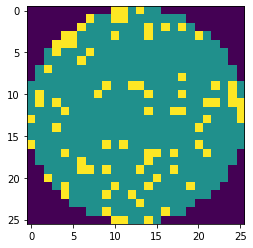

Faulty case : ['none'] 
419


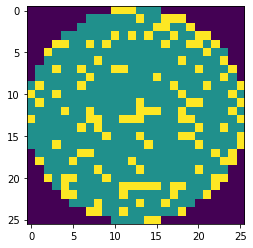

Faulty case : ['none'] 
420


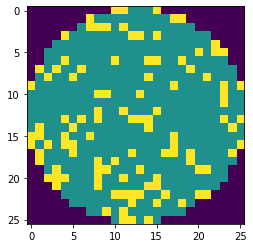

Faulty case : ['none'] 
421


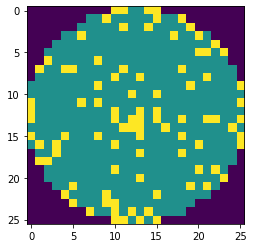

Faulty case : ['none'] 
422


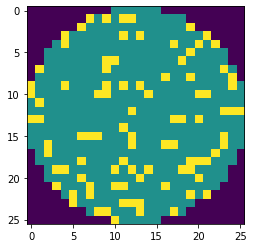

Faulty case : ['none'] 
423


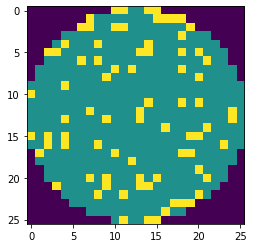

Faulty case : ['none'] 
424


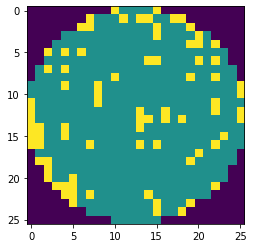

Faulty case : ['none'] 
425


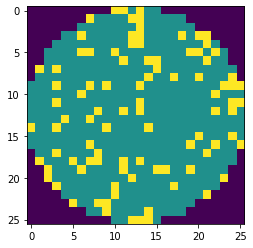

Faulty case : ['none'] 
426


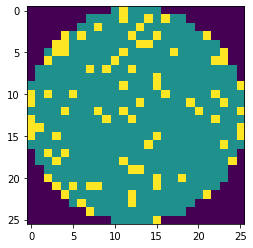

Faulty case : ['none'] 
427


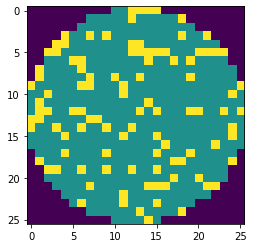

Faulty case : ['none'] 
428


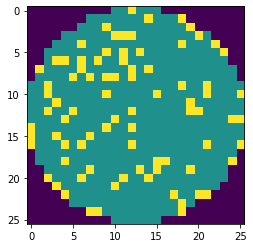

Faulty case : ['none'] 
429


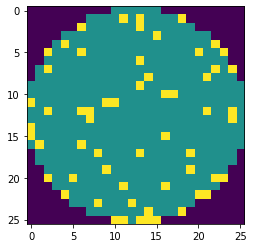

Faulty case : ['none'] 
430


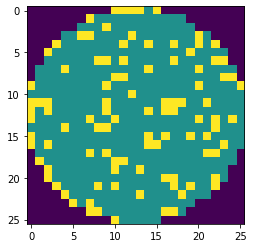

Faulty case : ['none'] 
431


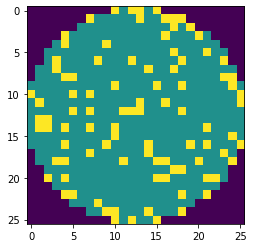

Faulty case : ['none'] 
433


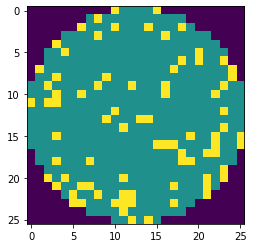

Faulty case : ['none'] 
434


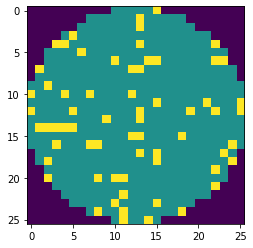

Faulty case : ['none'] 
435


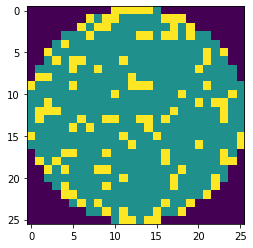

Faulty case : ['none'] 
436


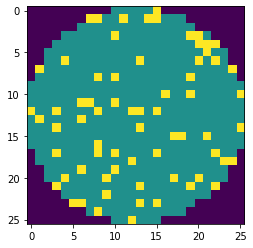

Faulty case : ['none'] 
437


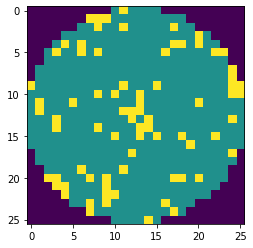

Faulty case : ['none'] 
438


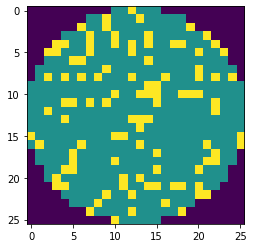

Faulty case : ['none'] 
439


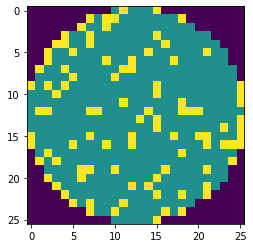

Faulty case : ['none'] 
440


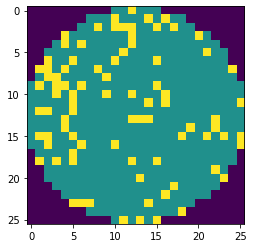

Faulty case : ['none'] 
441


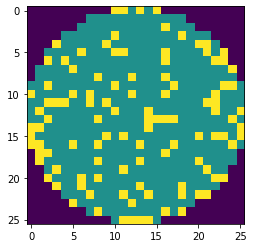

Faulty case : ['none'] 
442


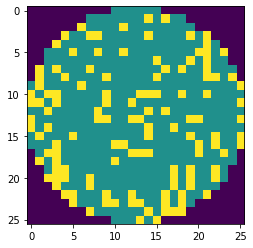

Faulty case : ['none'] 
443


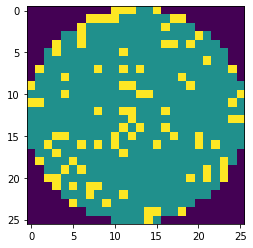

Faulty case : ['none'] 
444


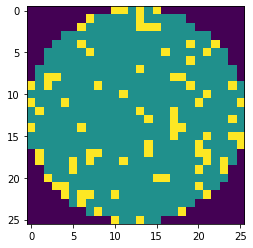

Faulty case : ['none'] 
445


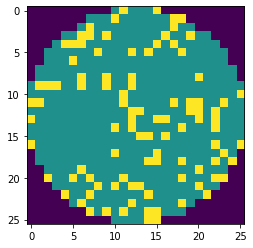

Faulty case : ['none'] 
446


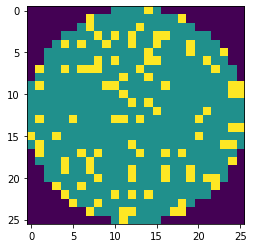

Faulty case : ['none'] 
447


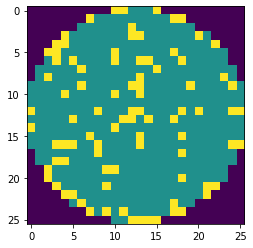

Faulty case : ['none'] 
449


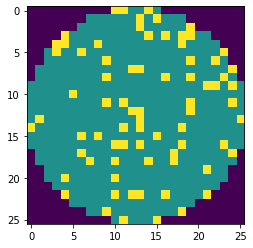

Faulty case : ['none'] 
450


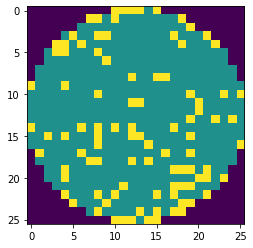

Faulty case : ['none'] 
451


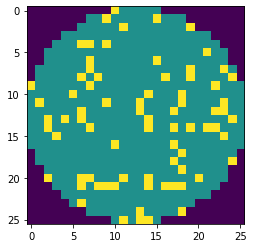

Faulty case : ['none'] 
452


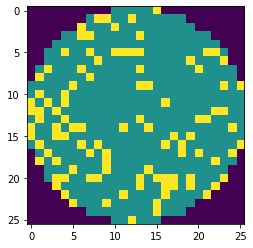

Faulty case : ['none'] 
453


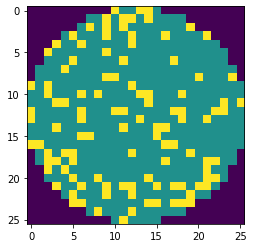

Faulty case : ['none'] 
454


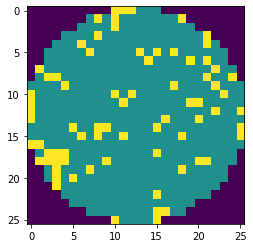

Faulty case : ['none'] 
455


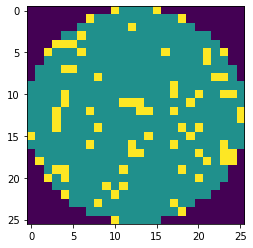

Faulty case : ['none'] 
456


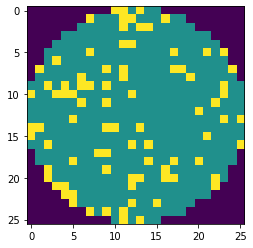

Faulty case : ['none'] 
457


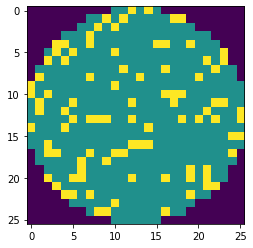

Faulty case : ['none'] 
458


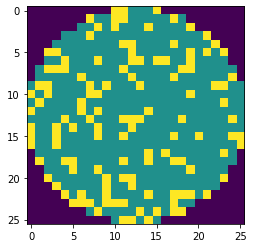

Faulty case : ['none'] 
459


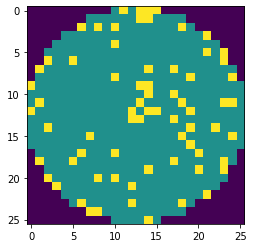

Faulty case : ['none'] 
460


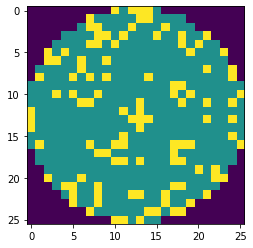

Faulty case : ['none'] 
462


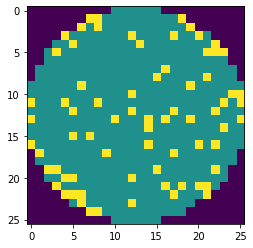

Faulty case : ['none'] 
463


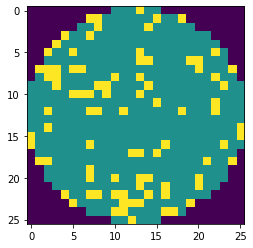

Faulty case : ['none'] 
464


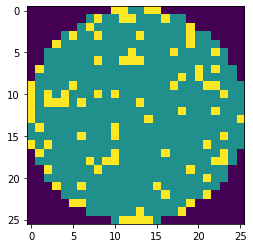

Faulty case : ['none'] 
465


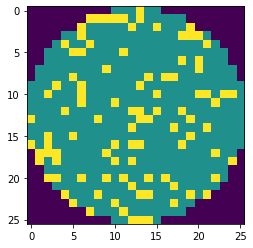

Faulty case : ['none'] 
466


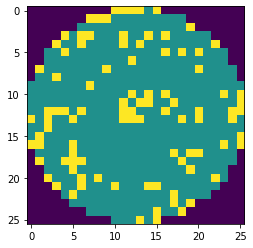

Faulty case : ['none'] 
467


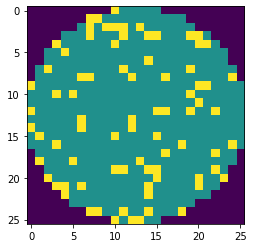

Faulty case : ['none'] 
468


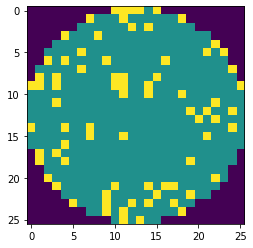

Faulty case : ['none'] 
469


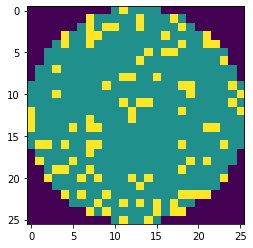

Faulty case : ['none'] 
470


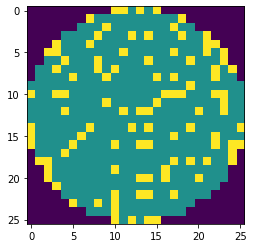

Faulty case : ['none'] 
471


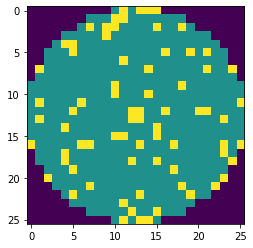

Faulty case : ['none'] 
472


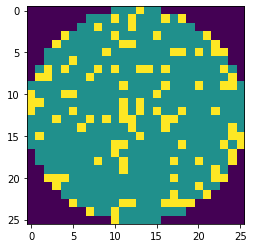

Faulty case : ['none'] 
473


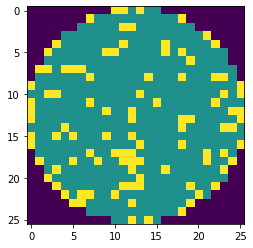

Faulty case : ['none'] 
474


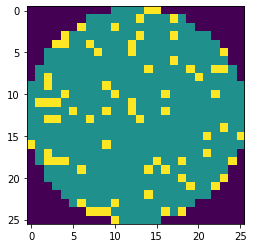

Faulty case : ['none'] 
475


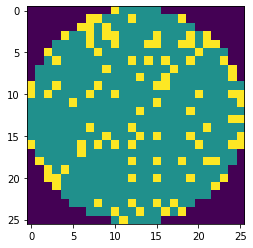

Faulty case : ['none'] 
476


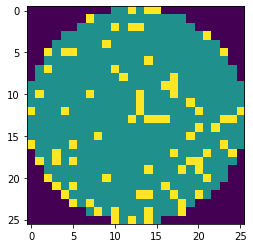

Faulty case : ['none'] 
477


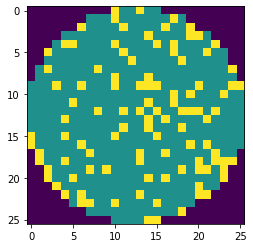

Faulty case : ['none'] 
478


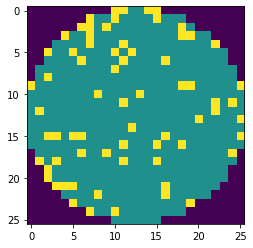

Faulty case : ['none'] 
479


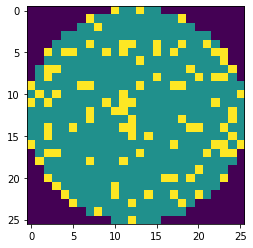

Faulty case : ['none'] 
480


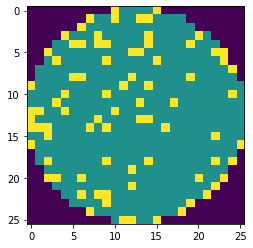

Faulty case : ['none'] 
481


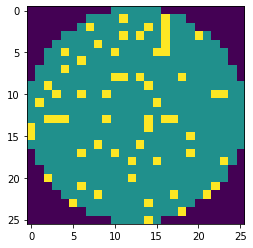

Faulty case : ['none'] 
482


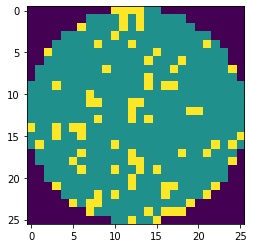

Faulty case : ['none'] 
483


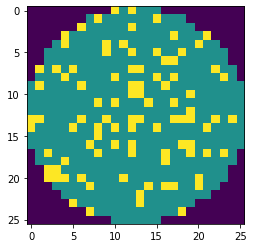

Faulty case : ['none'] 
484


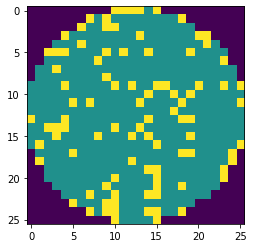

Faulty case : ['none'] 
485


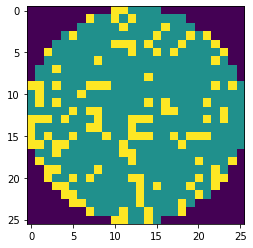

Faulty case : ['none'] 
486


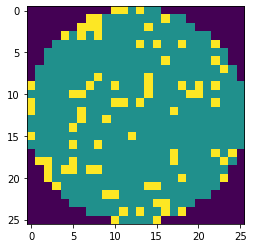

Faulty case : ['none'] 
487


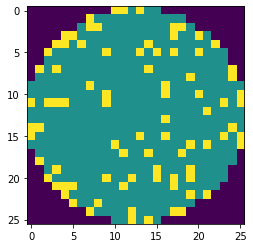

Faulty case : ['none'] 
488


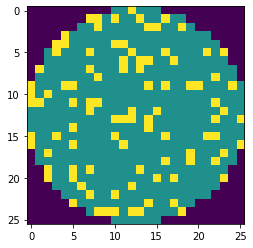

Faulty case : ['none'] 
489


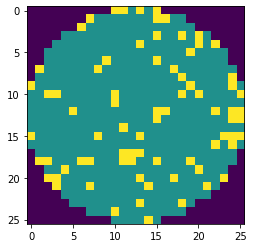

Faulty case : ['none'] 
490


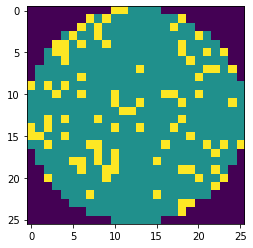

Faulty case : ['none'] 
491


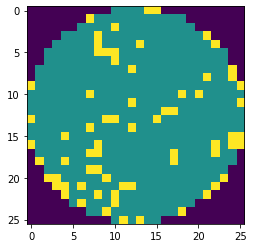

Faulty case : ['none'] 
492


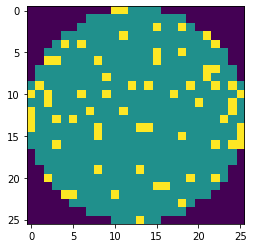

Faulty case : ['none'] 
493


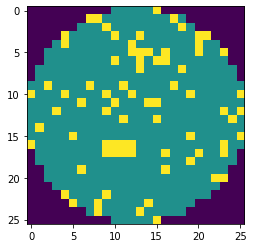

Faulty case : ['none'] 
494


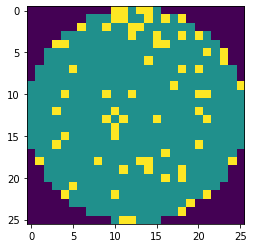

Faulty case : ['none'] 
495


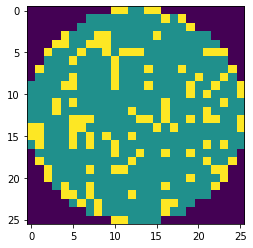

Faulty case : ['none'] 
496


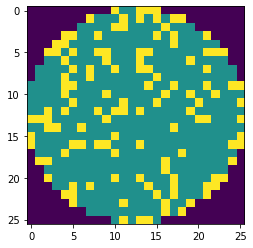

Faulty case : ['none'] 
497


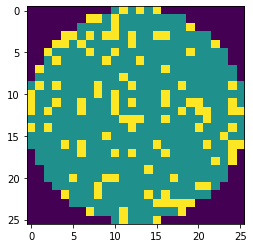

Faulty case : ['none'] 
498


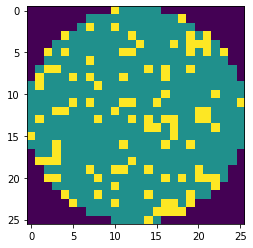

Faulty case : ['none'] 
500


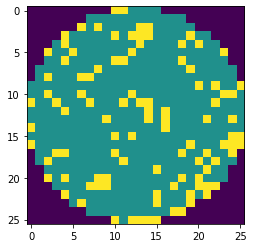

Faulty case : ['none'] 
501


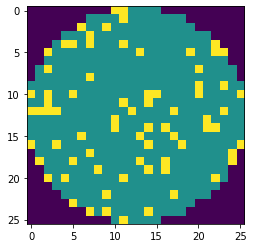

Faulty case : ['none'] 
502


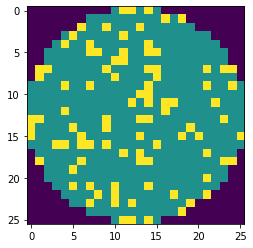

Faulty case : ['none'] 
503


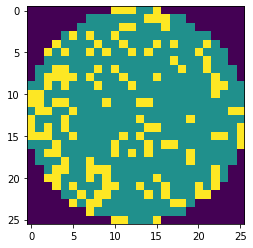

Faulty case : ['none'] 
504


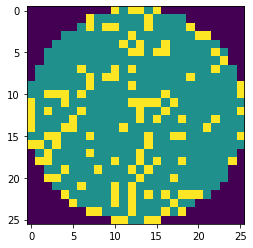

Faulty case : ['none'] 
505


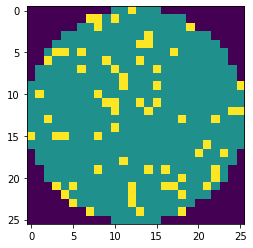

Faulty case : ['none'] 
506


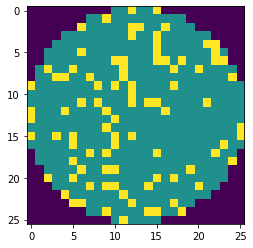

Faulty case : ['none'] 
507


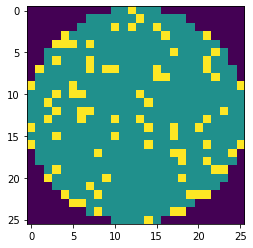

Faulty case : ['none'] 
508


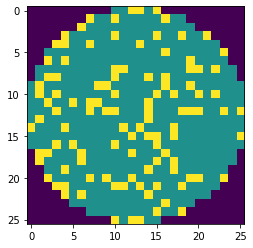

Faulty case : ['none'] 
509


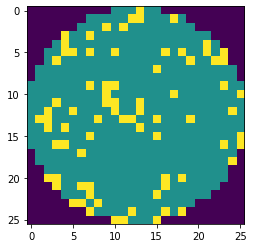

Faulty case : ['none'] 
510


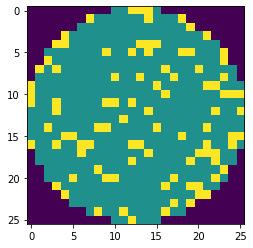

Faulty case : ['none'] 
512


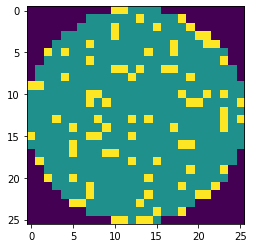

Faulty case : ['none'] 
513


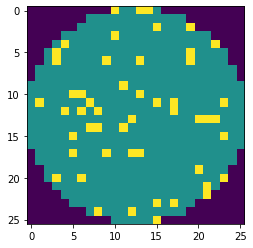

Faulty case : ['none'] 
514


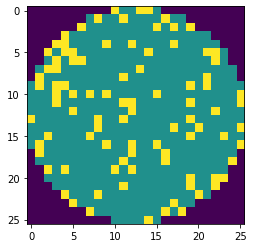

Faulty case : ['none'] 
515


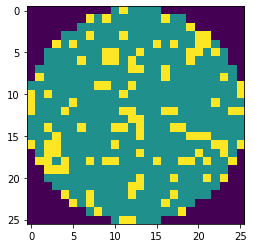

Faulty case : ['none'] 
516


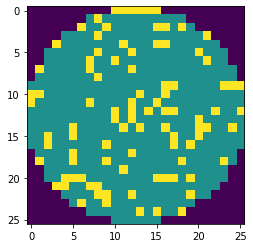

Faulty case : ['none'] 
517


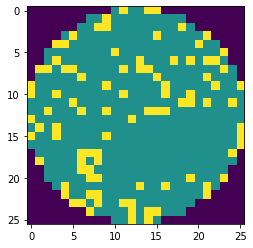

Faulty case : ['none'] 
518


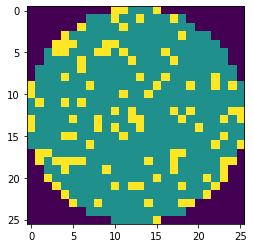

Faulty case : ['none'] 
519


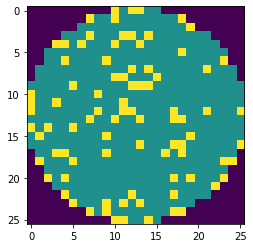

Faulty case : ['none'] 
520


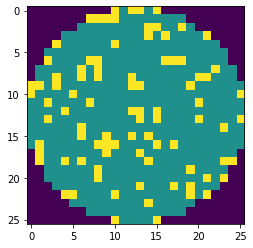

Faulty case : ['none'] 
521


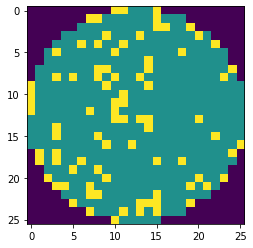

Faulty case : ['none'] 
522


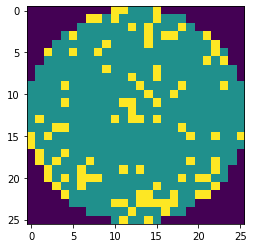

Faulty case : ['none'] 
523


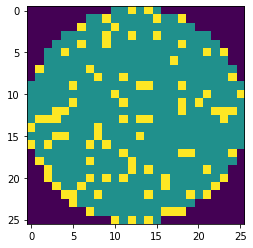

Faulty case : ['none'] 
524


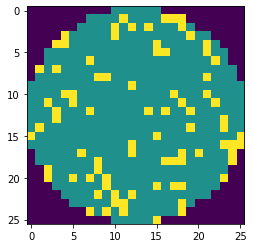

Faulty case : ['none'] 
525


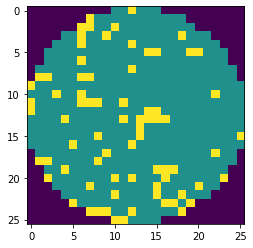

Faulty case : ['none'] 
526


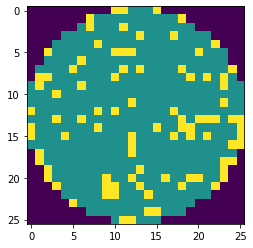

Faulty case : ['none'] 
527


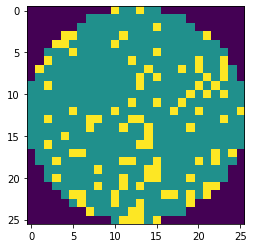

Faulty case : ['none'] 
528


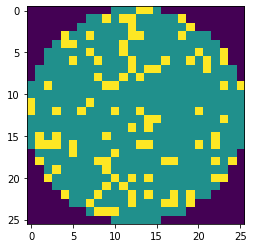

Faulty case : ['none'] 
529


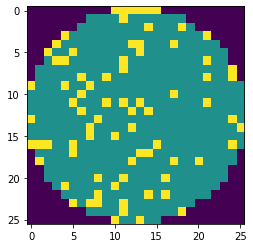

Faulty case : ['none'] 
530


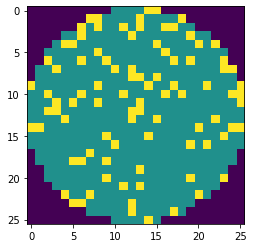

Faulty case : ['none'] 
531


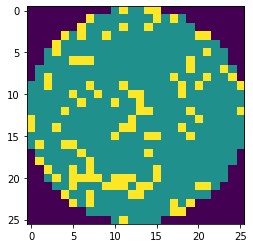

Faulty case : ['none'] 
532


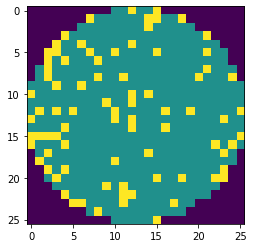

Faulty case : ['none'] 
533


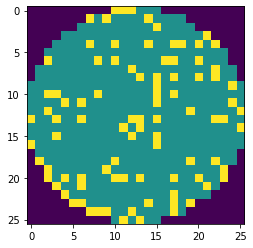

Faulty case : ['none'] 
534


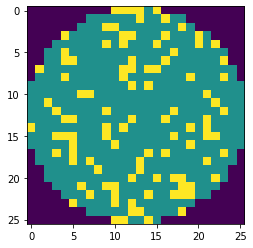

Faulty case : ['none'] 
535


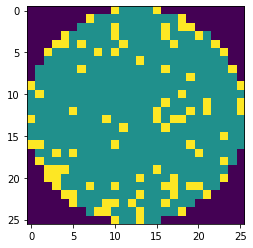

Faulty case : ['none'] 
536


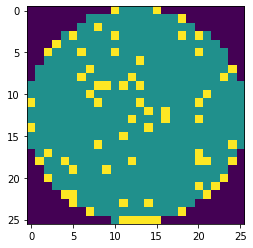

Faulty case : ['none'] 
537


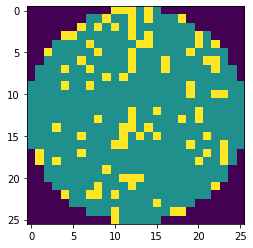

Faulty case : ['none'] 
538


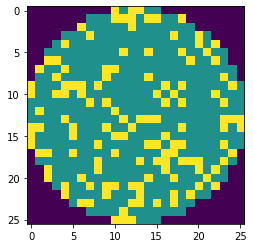

Faulty case : ['none'] 
539


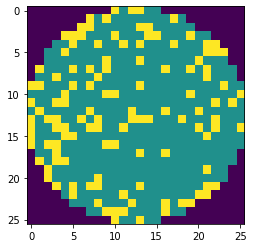

Faulty case : ['none'] 
540


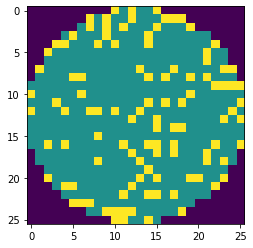

Faulty case : ['none'] 
541


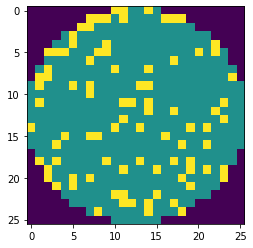

Faulty case : ['none'] 
542


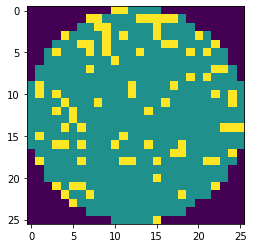

Faulty case : ['none'] 
543


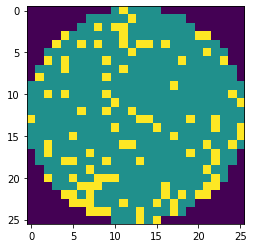

Faulty case : ['none'] 
544


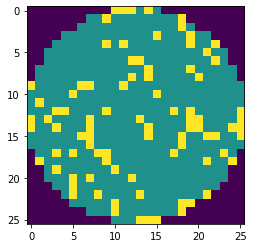

Faulty case : ['none'] 
545


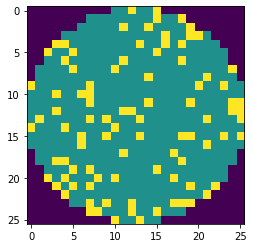

Faulty case : ['none'] 
546


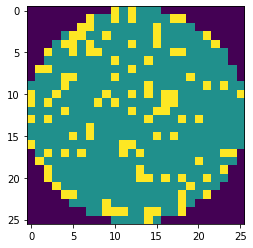

Faulty case : ['none'] 
548


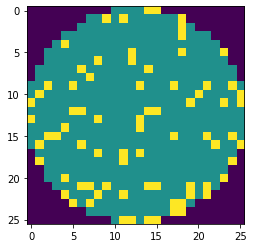

Faulty case : ['none'] 
549


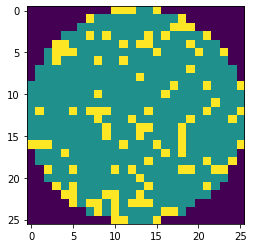

Faulty case : ['none'] 
550


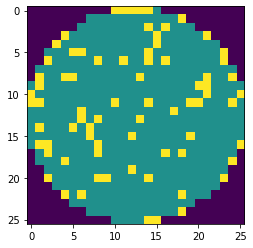

Faulty case : ['none'] 
551


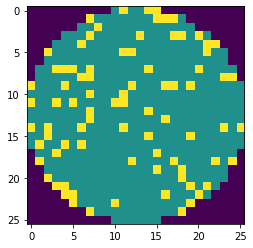

Faulty case : ['none'] 
552


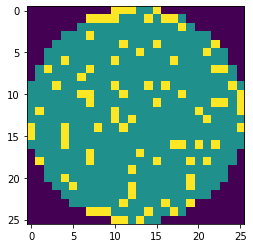

Faulty case : ['none'] 
553


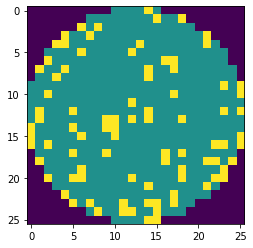

Faulty case : ['none'] 
554


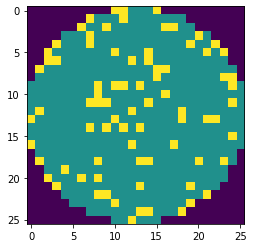

Faulty case : ['none'] 
555


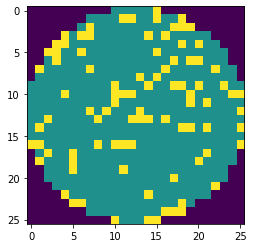

Faulty case : ['none'] 
556


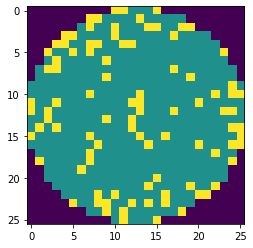

Faulty case : ['none'] 
557


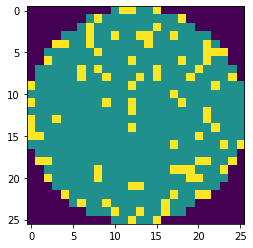

Faulty case : ['none'] 
558


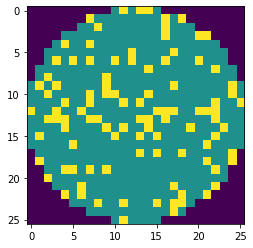

Faulty case : ['none'] 
559


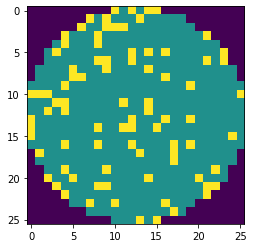

Faulty case : ['none'] 
560


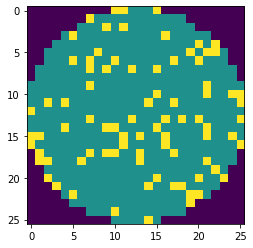

Faulty case : ['none'] 
561


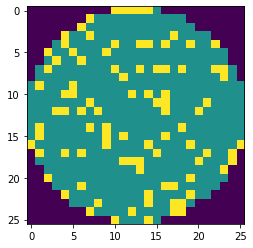

Faulty case : ['none'] 
562


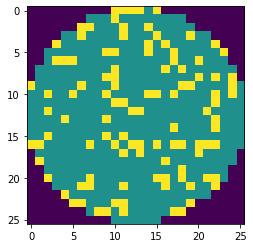

Faulty case : ['none'] 
563


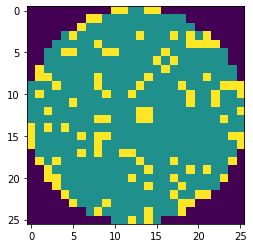

Faulty case : ['none'] 
564


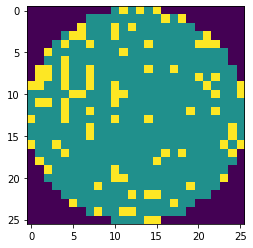

Faulty case : ['none'] 
565


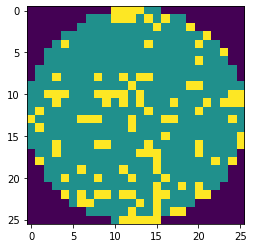

Faulty case : ['none'] 
566


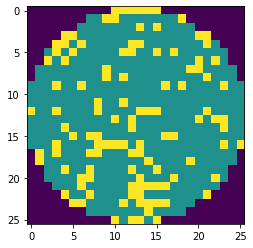

Faulty case : ['none'] 
568


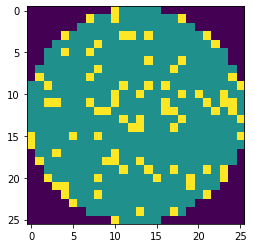

Faulty case : ['none'] 
569


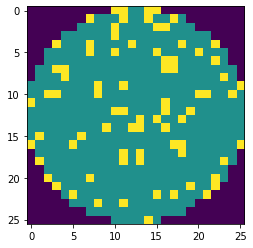

Faulty case : ['none'] 
570


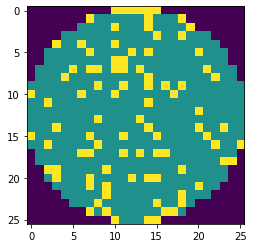

Faulty case : ['none'] 
571


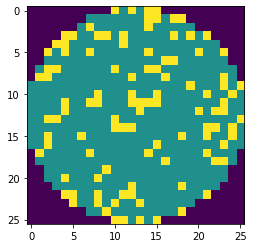

Faulty case : ['none'] 
572


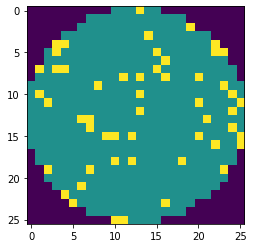

Faulty case : ['none'] 
573


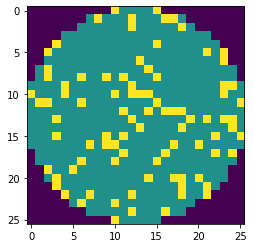

Faulty case : ['none'] 
574


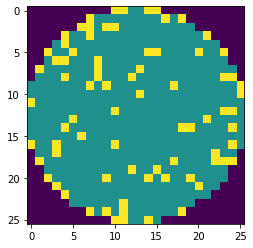

Faulty case : ['none'] 
575


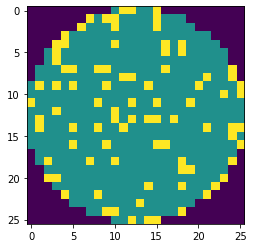

Faulty case : ['none'] 
576


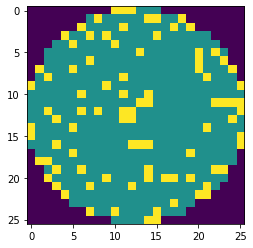

Faulty case : ['none'] 
577


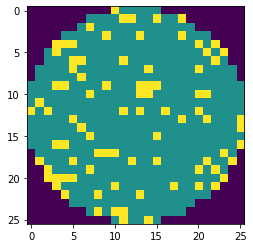

Faulty case : ['none'] 
578


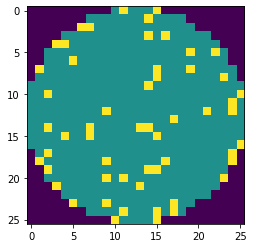

Faulty case : ['none'] 
579


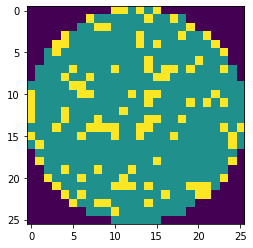

Faulty case : ['none'] 
580


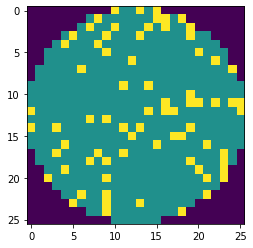

Faulty case : ['none'] 
582


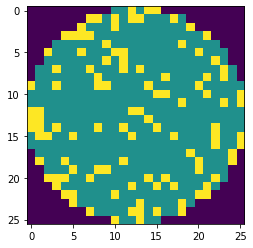

Faulty case : ['none'] 
583


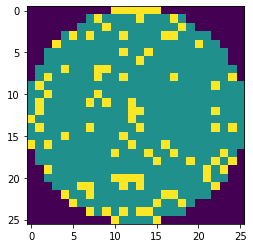

Faulty case : ['none'] 
584


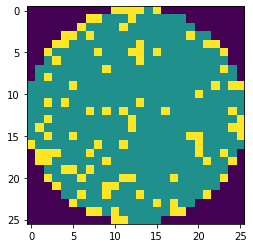

Faulty case : ['none'] 
585


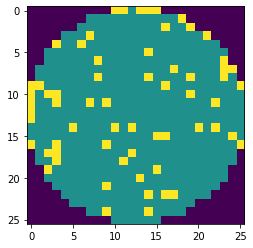

Faulty case : ['none'] 
586


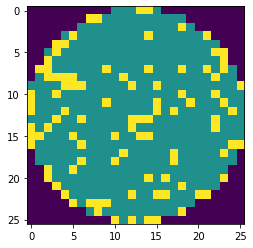

Faulty case : ['none'] 
588


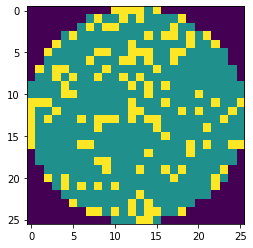

Faulty case : ['none'] 
589


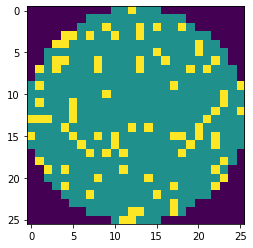

Faulty case : ['none'] 
590


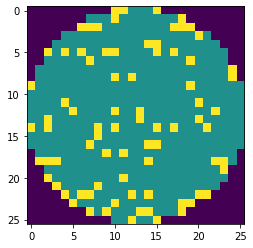

Faulty case : ['none'] 
591


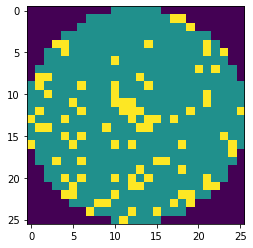

Faulty case : ['none'] 
592


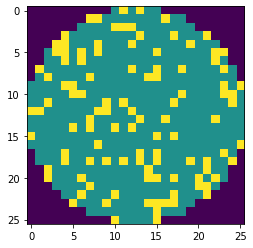

Faulty case : ['none'] 
593


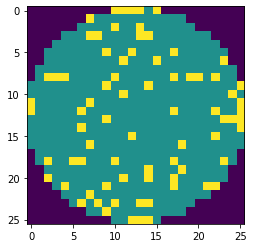

Faulty case : ['none'] 
594


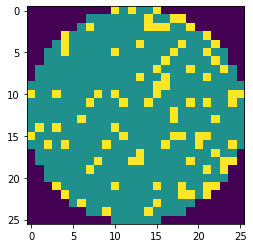

Faulty case : ['none'] 
595


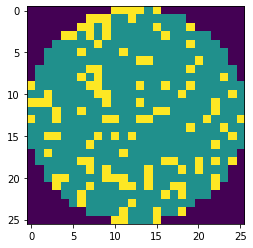

Faulty case : ['none'] 
596


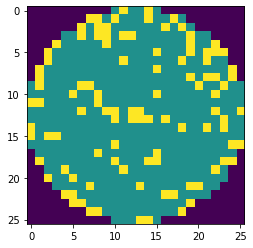

Faulty case : ['none'] 
597


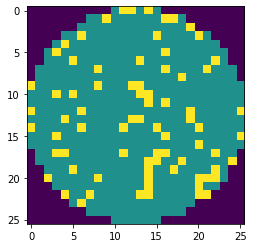

Faulty case : ['none'] 
598


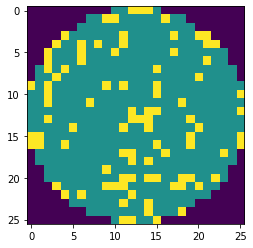

Faulty case : ['none'] 
599


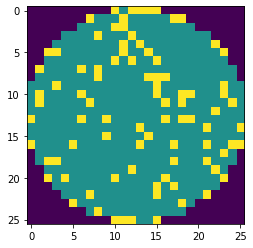

Faulty case : ['none'] 
600


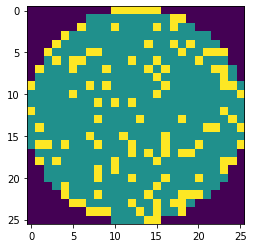

Faulty case : ['none'] 
601


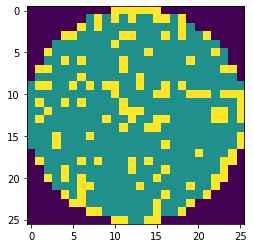

Faulty case : ['none'] 
602


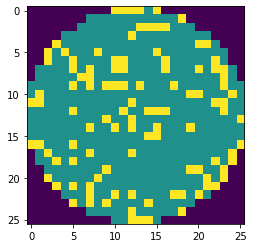

Faulty case : ['none'] 
603


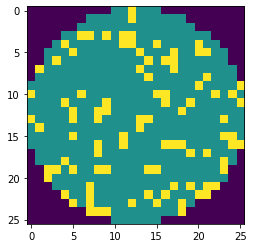

Faulty case : ['none'] 
604


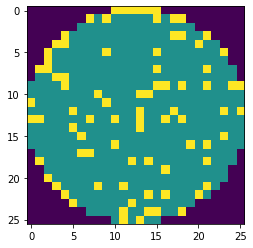

Faulty case : ['none'] 
605


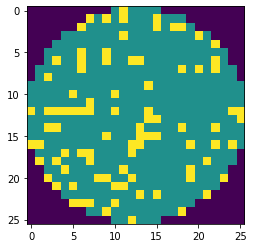

Faulty case : ['none'] 
606


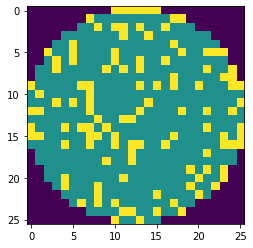

Faulty case : ['none'] 
607


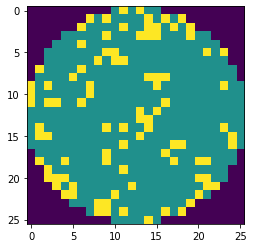

Faulty case : ['none'] 
608


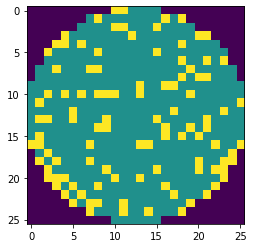

Faulty case : ['none'] 
609


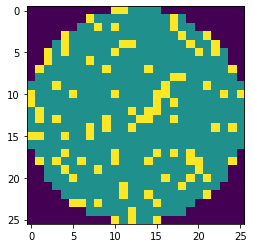

Faulty case : ['none'] 
610


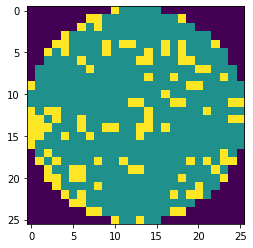

Faulty case : ['none'] 
611


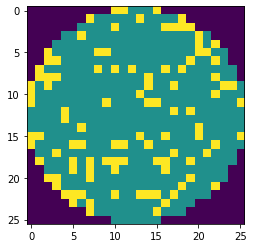

Faulty case : ['none'] 
612


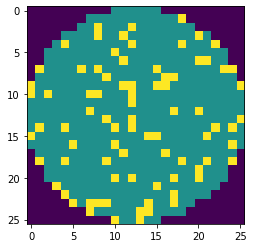

Faulty case : ['none'] 
613


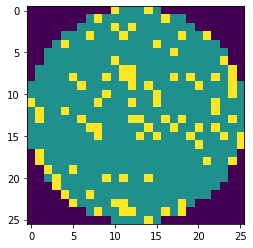

Faulty case : ['none'] 
614


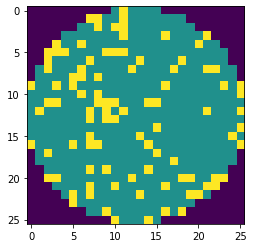

Faulty case : ['none'] 
615


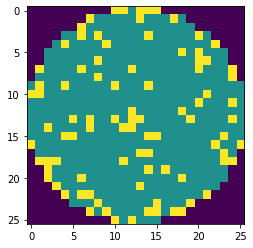

Faulty case : ['none'] 
616


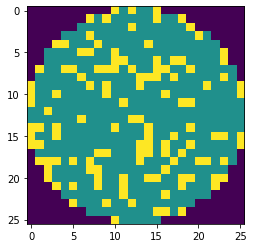

Faulty case : ['none'] 
617


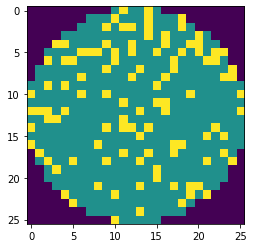

Faulty case : ['none'] 
618


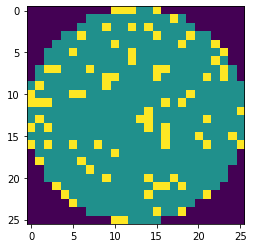

Faulty case : ['none'] 
619


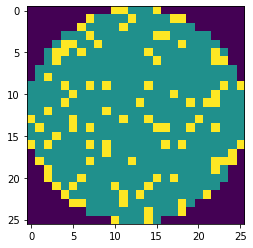

Faulty case : ['none'] 
620


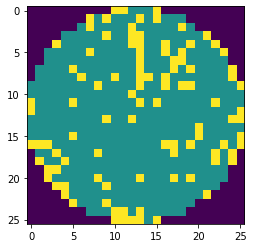

Faulty case : ['none'] 
621


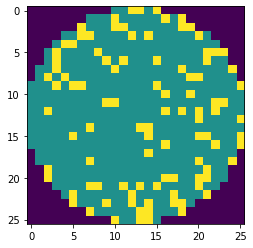

Faulty case : ['none'] 
622


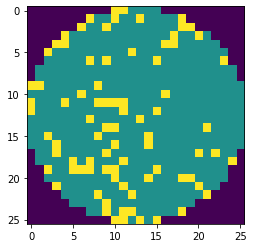

Faulty case : ['none'] 
623


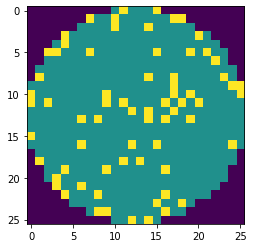

Faulty case : ['none'] 
624


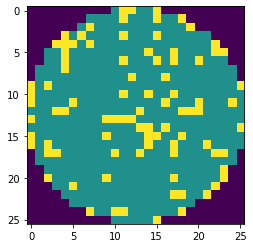

Faulty case : ['none'] 
625


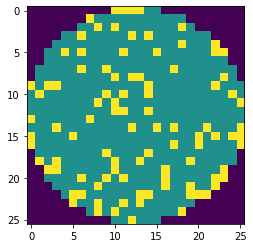

Faulty case : ['none'] 
626


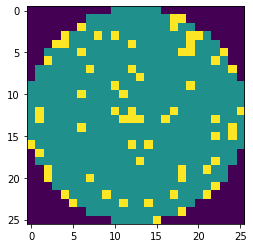

Faulty case : ['none'] 
627


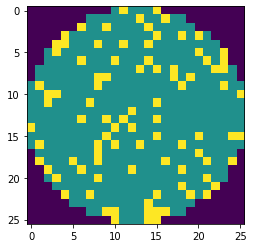

Faulty case : ['none'] 
628


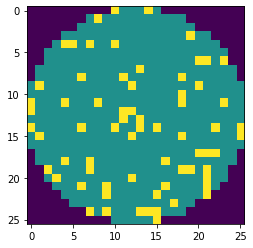

Faulty case : ['none'] 
629


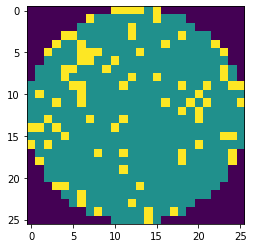

Faulty case : ['none'] 
630


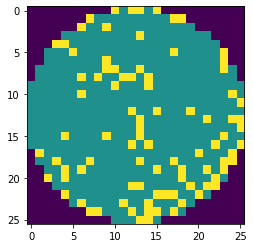

Faulty case : ['none'] 
631


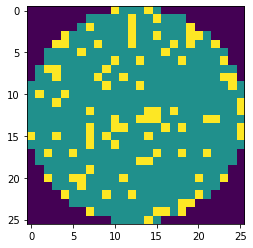

Faulty case : ['none'] 
632


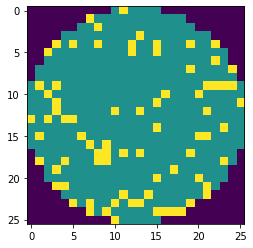

Faulty case : ['none'] 
633


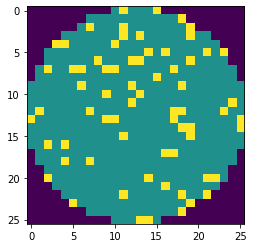

Faulty case : ['none'] 
634


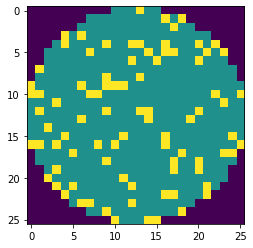

Faulty case : ['none'] 
635


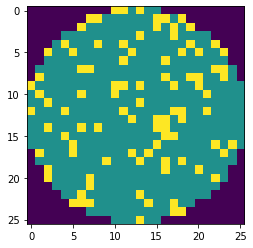

Faulty case : ['none'] 
636


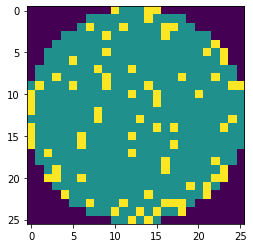

Faulty case : ['none'] 
638


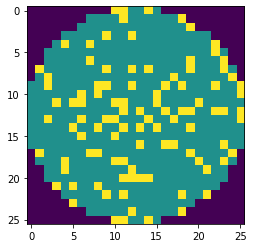

Faulty case : ['none'] 
639


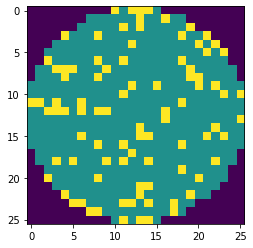

Faulty case : ['none'] 
640


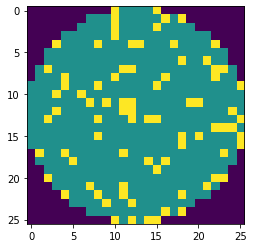

Faulty case : ['none'] 
641


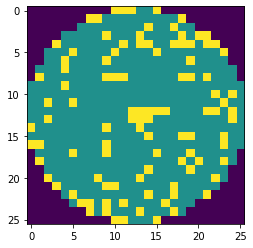

Faulty case : ['none'] 
642


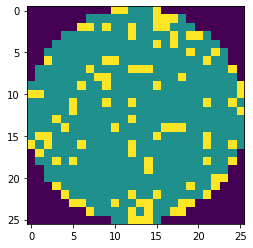

Faulty case : ['none'] 
643


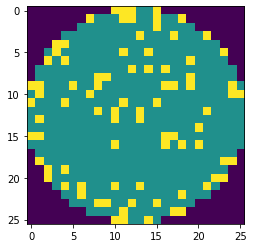

Faulty case : ['none'] 
644


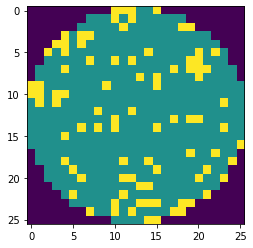

Faulty case : ['none'] 
645


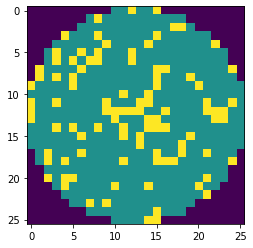

Faulty case : ['none'] 
646


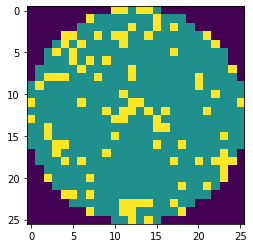

Faulty case : ['none'] 
647


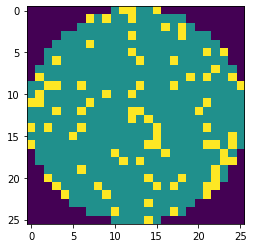

Faulty case : ['none'] 
648


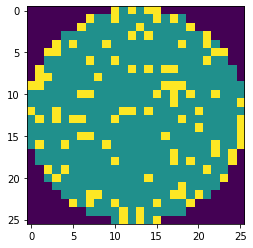

Faulty case : ['none'] 
649


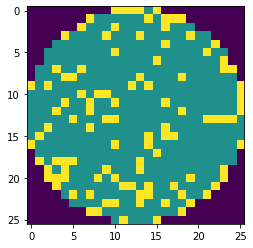

Faulty case : ['none'] 
650


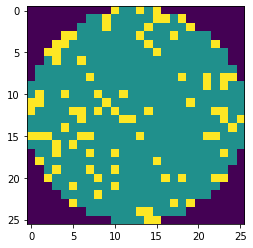

Faulty case : ['none'] 
651


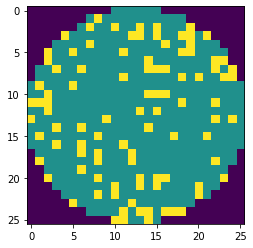

Faulty case : ['none'] 
652


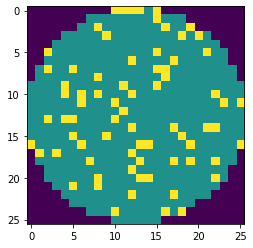

Faulty case : ['none'] 
653


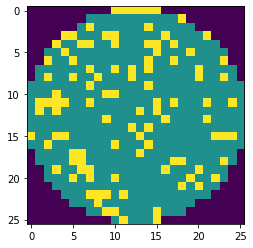

Faulty case : ['none'] 
654


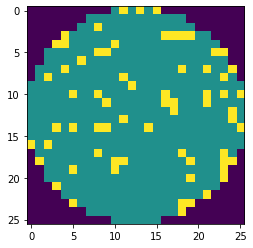

Faulty case : ['none'] 
655


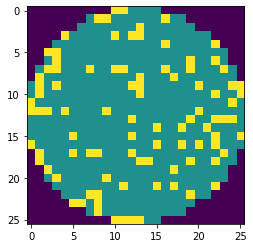

Faulty case : ['none'] 
656


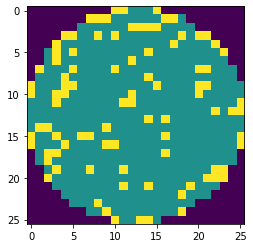

Faulty case : ['none'] 
657


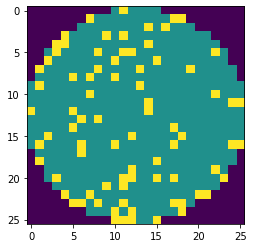

Faulty case : ['none'] 
658


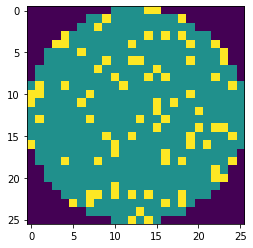

Faulty case : ['none'] 
659


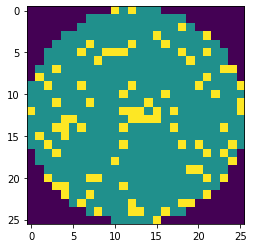

Faulty case : ['none'] 
660


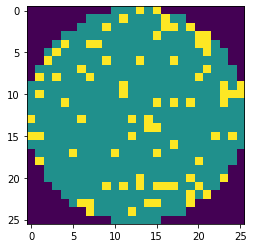

Faulty case : ['none'] 
661


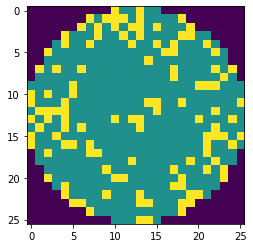

Faulty case : ['none'] 
662


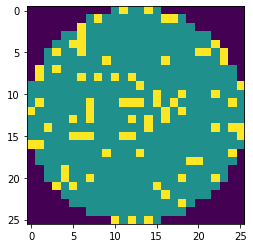

Faulty case : ['none'] 
663


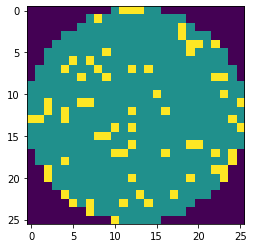

Faulty case : ['none'] 
664


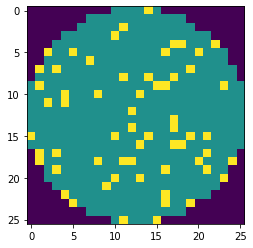

Faulty case : ['none'] 
665


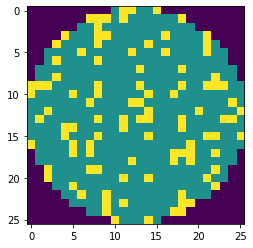

Faulty case : ['none'] 
666


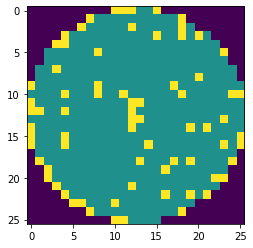

Faulty case : ['none'] 
667


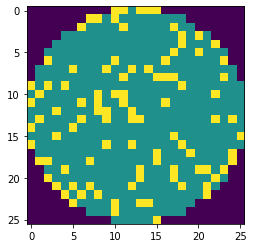

Faulty case : ['none'] 
669


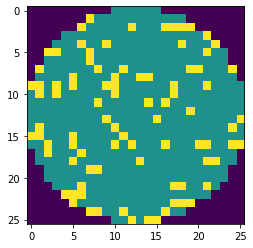

Faulty case : ['none'] 
670


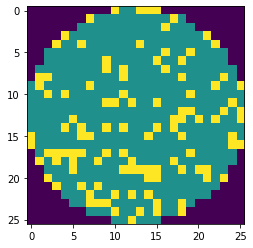

Faulty case : ['none'] 
671


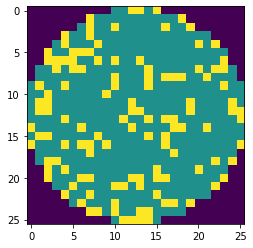

Faulty case : ['none'] 
672


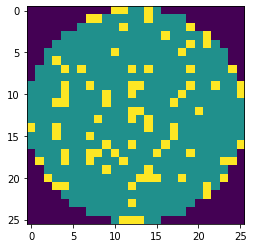

Faulty case : ['none'] 
673


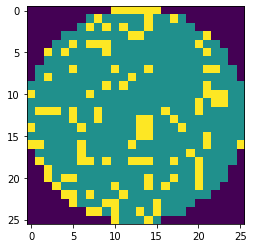

Faulty case : ['none'] 
674


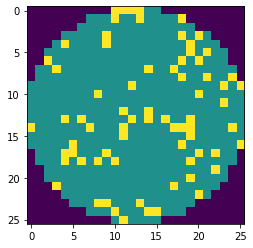

Faulty case : ['none'] 
675


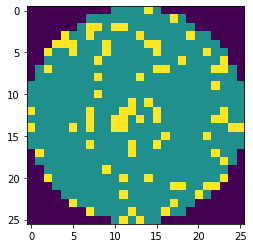

Faulty case : ['none'] 
676


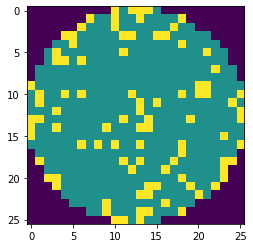

Faulty case : ['none'] 
677


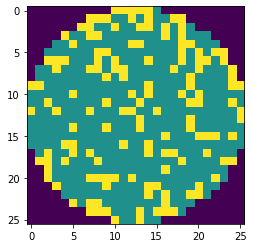

Faulty case : ['none'] 
678


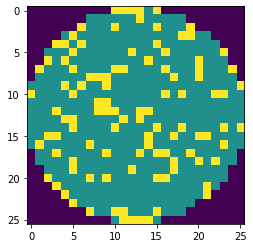

Faulty case : ['none'] 
679


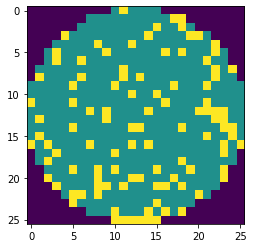

Faulty case : ['none'] 
680


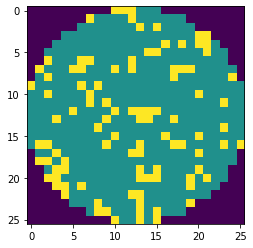

Faulty case : ['none'] 
681


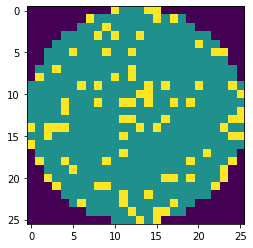

Faulty case : ['none'] 
682


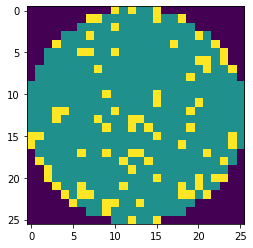

Faulty case : ['none'] 
683


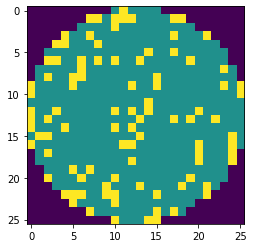

Faulty case : ['none'] 
684


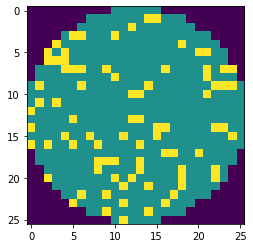

Faulty case : ['none'] 
685


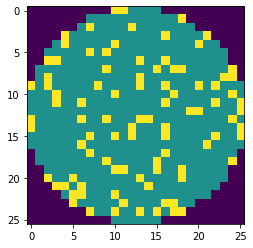

Faulty case : ['none'] 
686


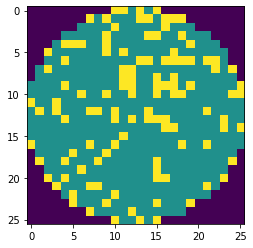

Faulty case : ['none'] 
688


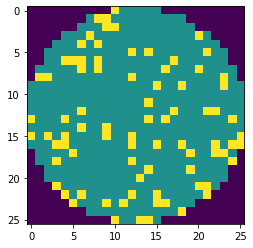

Faulty case : ['none'] 
689


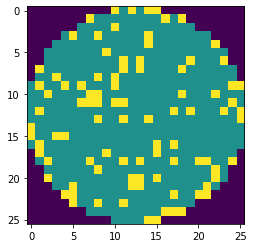

Faulty case : ['none'] 
690


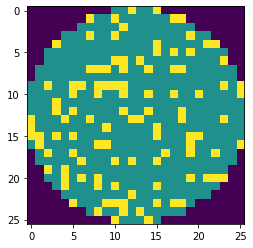

Faulty case : ['none'] 
691


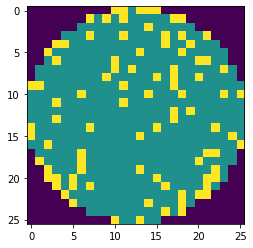

Faulty case : ['none'] 
692


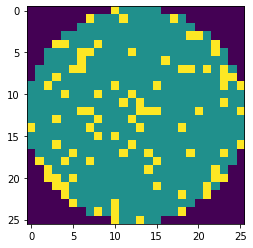

Faulty case : ['none'] 
693


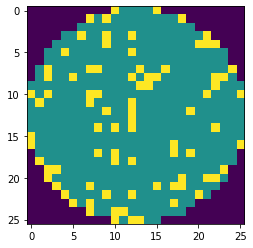

Faulty case : ['none'] 
694


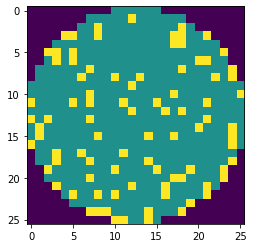

Faulty case : ['none'] 
695


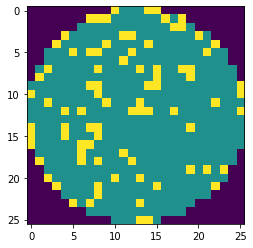

Faulty case : ['none'] 
696


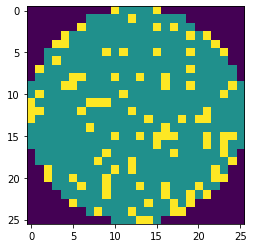

Faulty case : ['none'] 
697


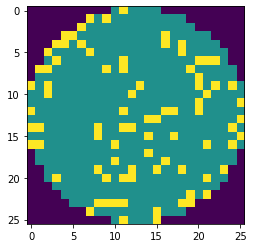

Faulty case : ['none'] 
698


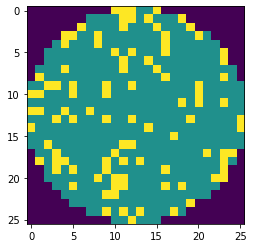

Faulty case : ['none'] 
699


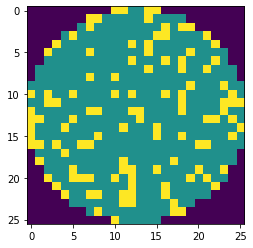

Faulty case : ['none'] 
700


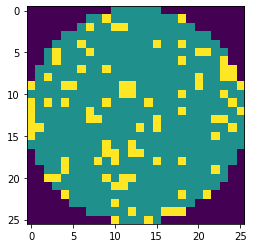

Faulty case : ['none'] 
701


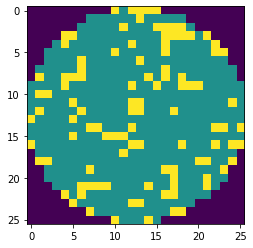

Faulty case : ['none'] 
702


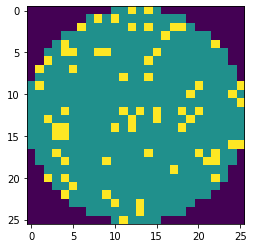

Faulty case : ['none'] 
703


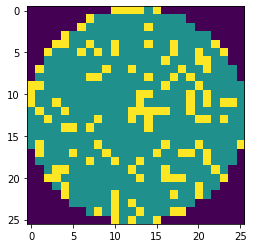

Faulty case : ['none'] 
704


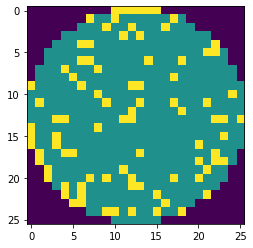

Faulty case : ['none'] 
705


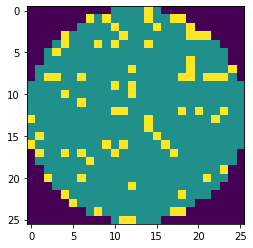

Faulty case : ['none'] 
706


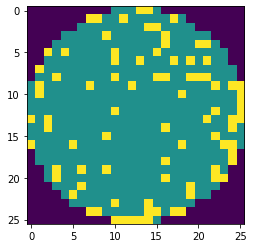

Faulty case : ['none'] 
707


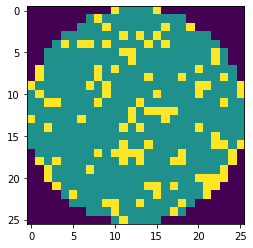

Faulty case : ['none'] 
708


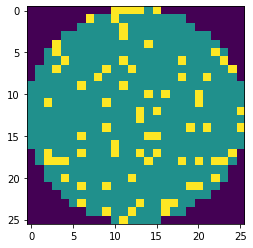

Faulty case : ['none'] 
709


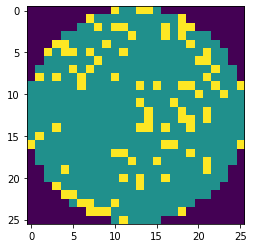

Faulty case : ['none'] 
710


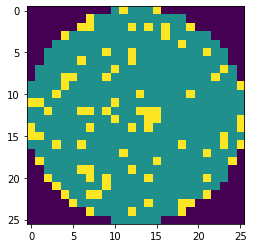

Faulty case : ['none'] 
711


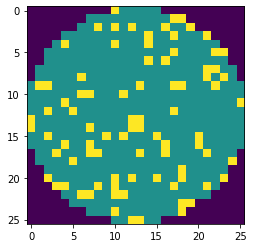

Faulty case : ['none'] 
712


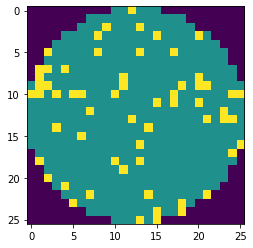

Faulty case : ['none'] 
713


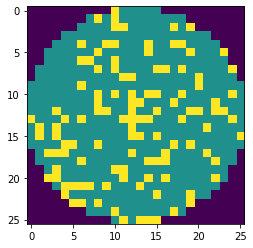

Faulty case : ['none'] 
715


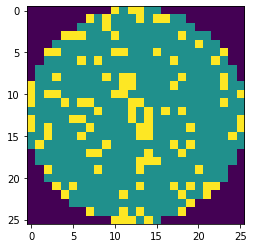

Faulty case : ['none'] 
716


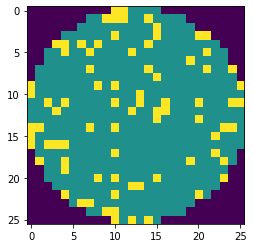

Faulty case : ['none'] 
717


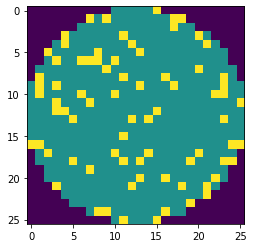

Faulty case : ['none'] 
718


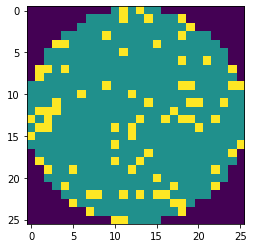

Faulty case : ['none'] 
719


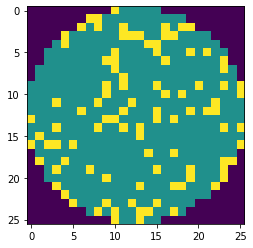

Faulty case : ['none'] 
720


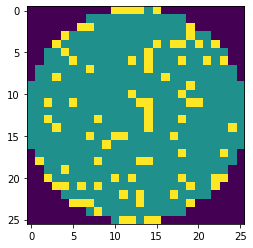

Faulty case : ['none'] 
721


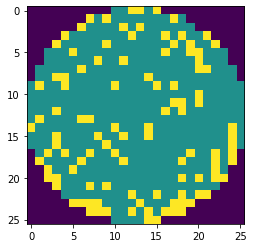

Faulty case : ['none'] 
722


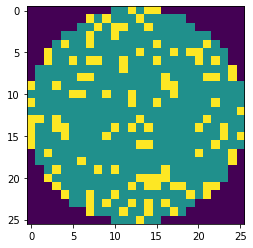

Faulty case : ['none'] 
723


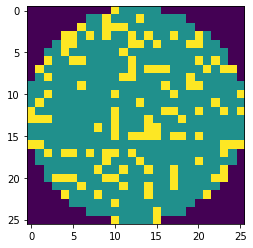

Faulty case : ['none'] 
724


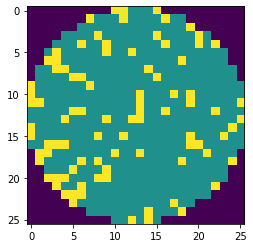

Faulty case : ['none'] 
725


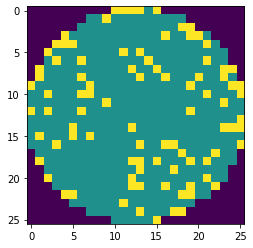

Faulty case : ['none'] 
726


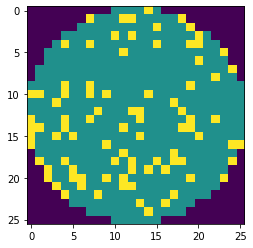

Faulty case : ['none'] 
727


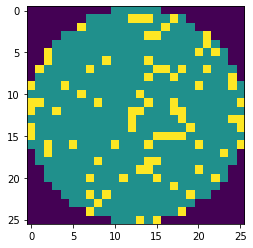

Faulty case : ['none'] 
728


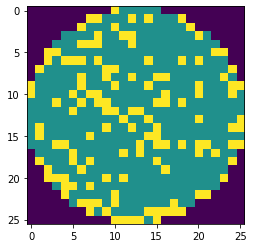

Faulty case : ['none'] 
729


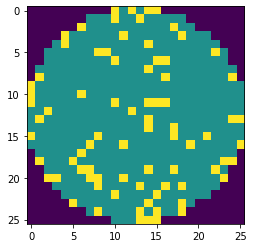

Faulty case : ['none'] 
730


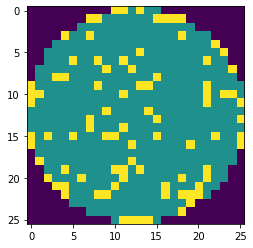

Faulty case : ['none'] 
731


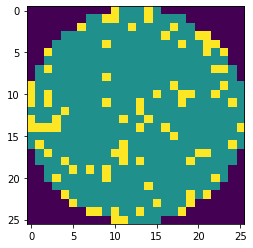

Faulty case : ['none'] 
732


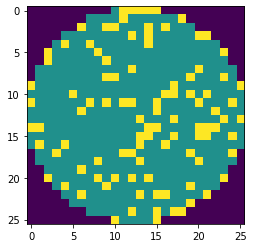

Faulty case : ['none'] 
733


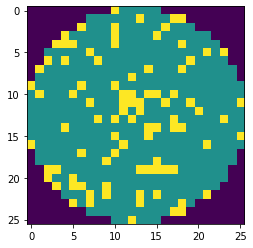

Faulty case : ['none'] 
734


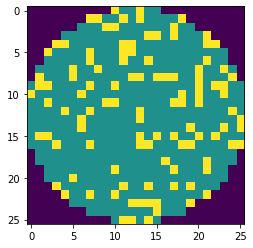

Faulty case : ['none'] 
735


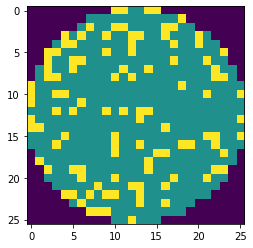

Faulty case : ['none'] 
736


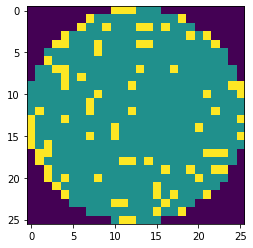

Faulty case : ['none'] 
737


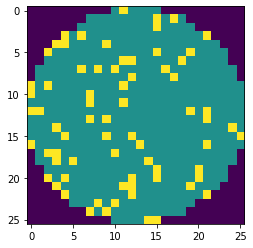

Faulty case : ['none'] 
738


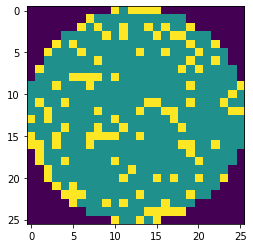

Faulty case : ['none'] 
739


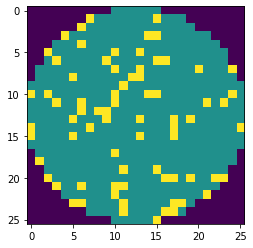

Faulty case : ['none'] 
740


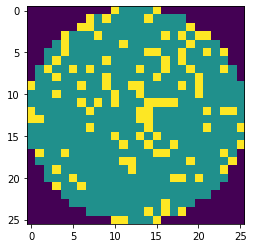

Faulty case : ['none'] 
741


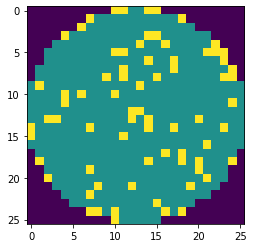

Faulty case : ['none'] 
742


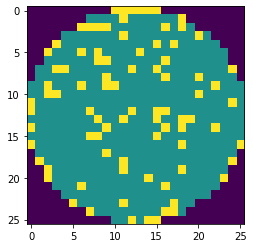

Faulty case : ['none'] 
743


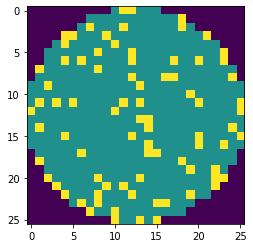

Faulty case : ['none'] 
745


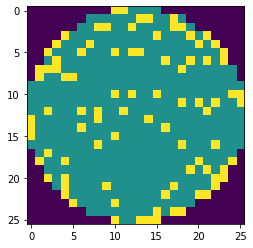

Faulty case : ['none'] 
746


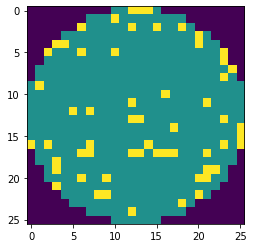

Faulty case : ['none'] 
747


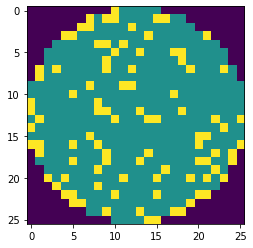

Faulty case : ['none'] 
748


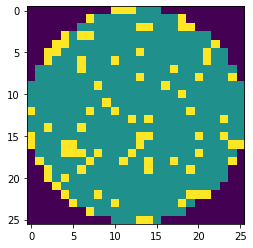

Faulty case : ['none'] 
749


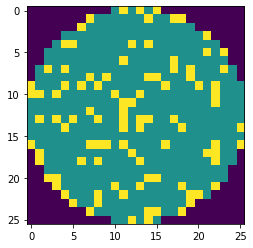

Faulty case : ['none'] 
750


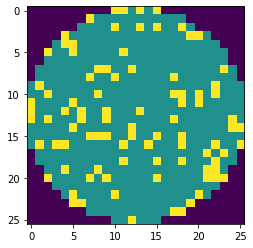

Faulty case : ['none'] 
751


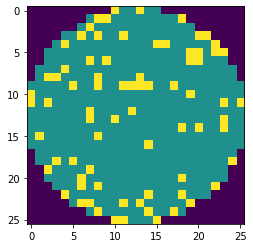

Faulty case : ['none'] 
752


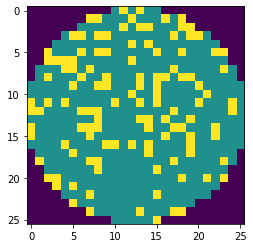

Faulty case : ['none'] 
753


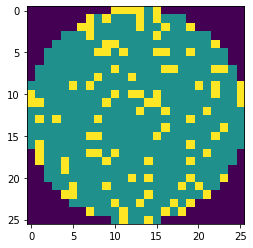

Faulty case : ['none'] 
754


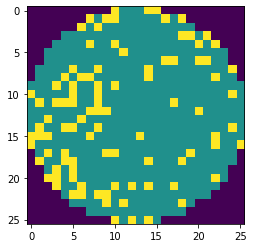

Faulty case : ['none'] 
755


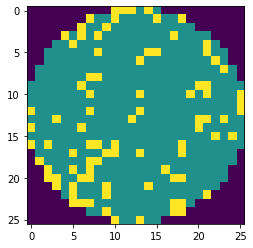

Faulty case : ['none'] 
756


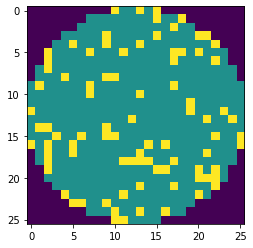

Faulty case : ['none'] 
757


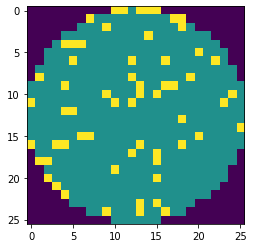

Faulty case : ['none'] 
758


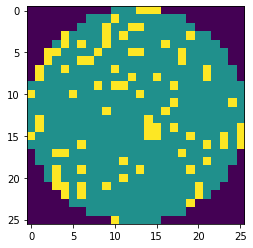

Faulty case : ['none'] 
759


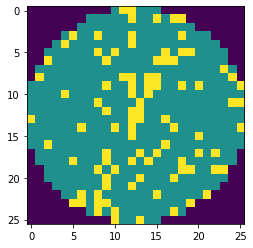

Faulty case : ['none'] 
760


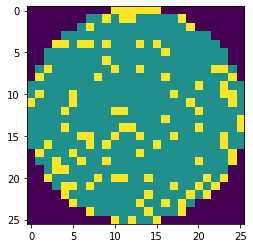

Faulty case : ['none'] 
761


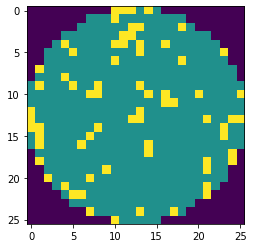

Faulty case : ['none'] 
763


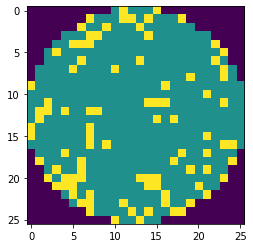

Faulty case : ['none'] 
764


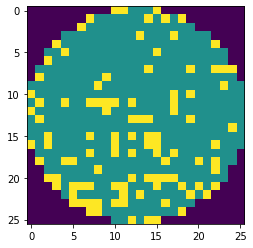

Faulty case : ['none'] 
765


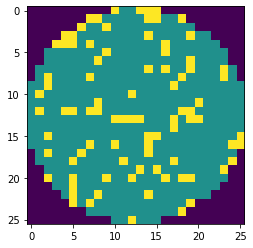

Faulty case : ['none'] 
766


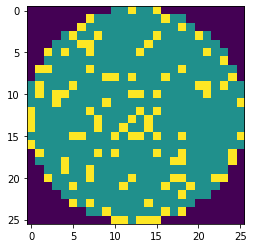

Faulty case : ['none'] 
767


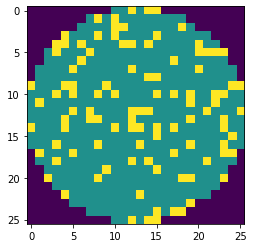

Faulty case : ['none'] 
768


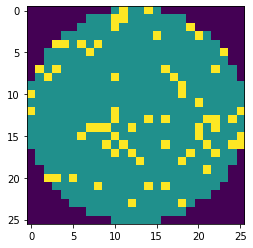

Faulty case : ['none'] 
769


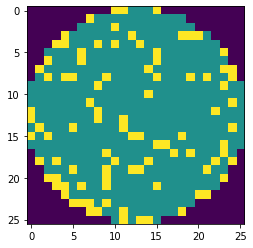

Faulty case : ['none'] 
770


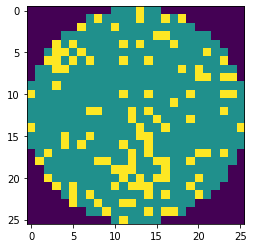

Faulty case : ['none'] 
771


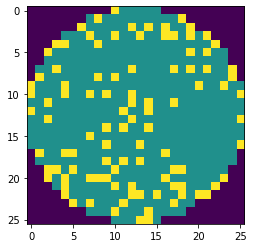

Faulty case : ['none'] 
772


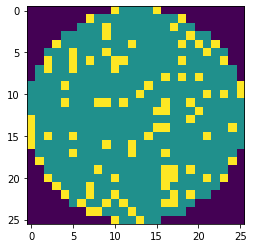

Faulty case : ['none'] 
773


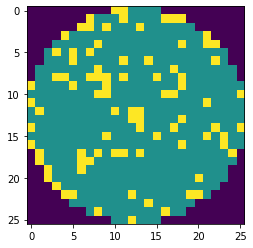

Faulty case : ['none'] 
774


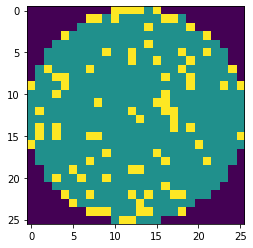

Faulty case : ['none'] 
775


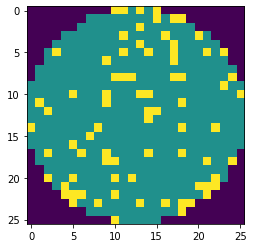

Faulty case : ['none'] 
776


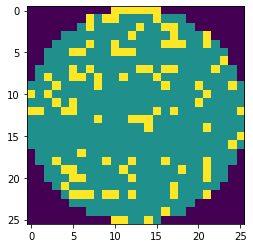

Faulty case : ['none'] 
777


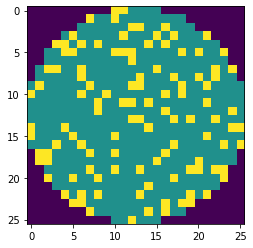

Faulty case : ['none'] 
778


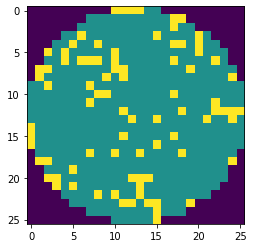

Faulty case : ['none'] 
779


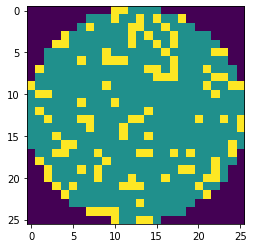

Faulty case : ['none'] 
780


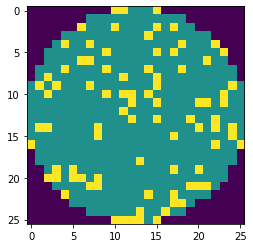

Faulty case : ['none'] 
781


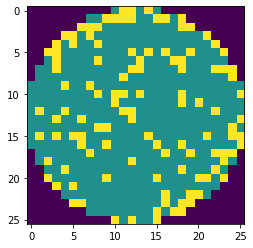

Faulty case : ['none'] 
782


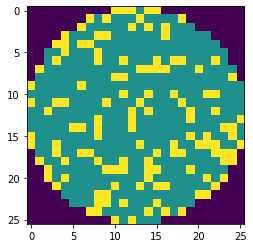

Faulty case : ['none'] 
783


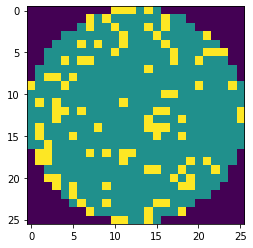

Faulty case : ['none'] 
784


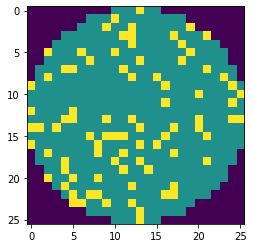

Faulty case : ['none'] 
785


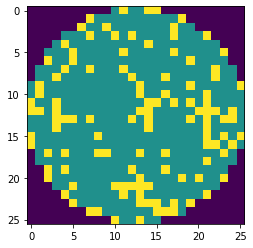

Faulty case : ['none'] 
786


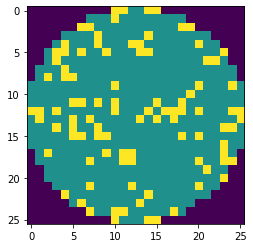

Faulty case : ['none'] 
787


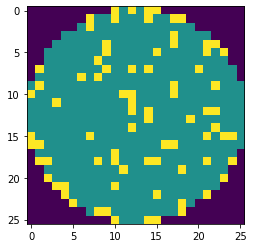

Faulty case : ['none'] 
788


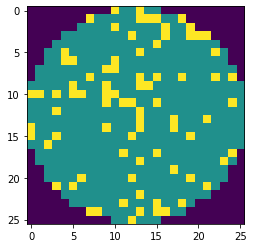

Faulty case : ['none'] 
789


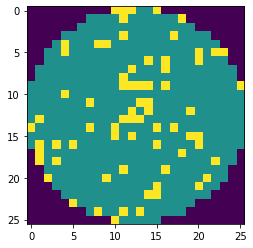

Faulty case : ['none'] 
790


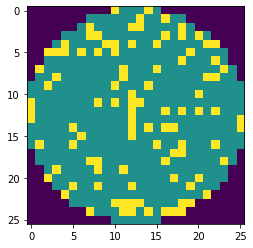

Faulty case : ['none'] 
791


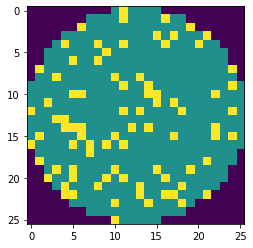

Faulty case : ['none'] 
792


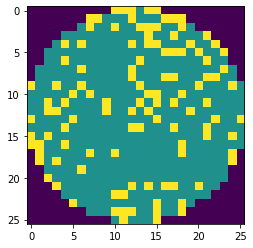

Faulty case : ['none'] 
793


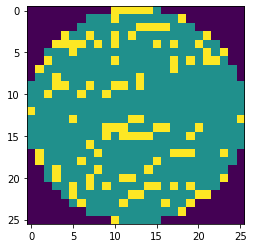

Faulty case : ['none'] 
794


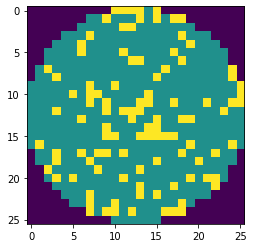

Faulty case : ['none'] 
795


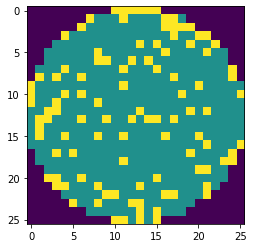

Faulty case : ['none'] 
796


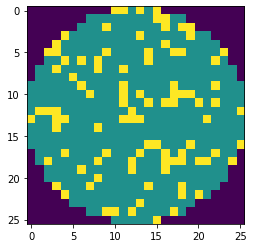

Faulty case : ['none'] 
797


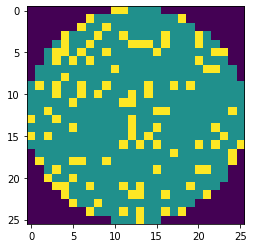

Faulty case : ['none'] 
798


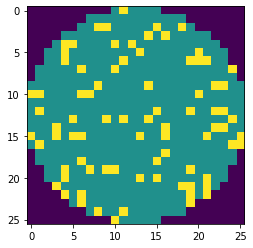

Faulty case : ['none'] 
799


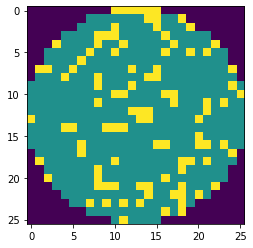

Faulty case : ['none'] 
800


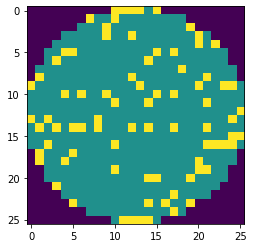

Faulty case : ['none'] 
801


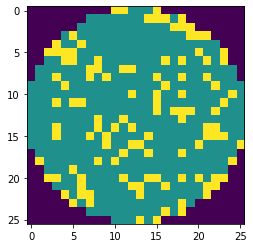

Faulty case : ['none'] 
802


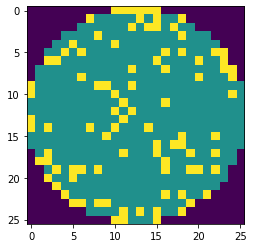

Faulty case : ['none'] 
803


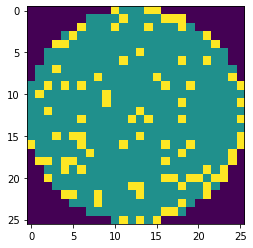

Faulty case : ['none'] 
804


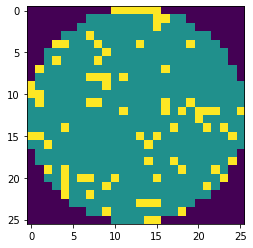

Faulty case : ['none'] 
805


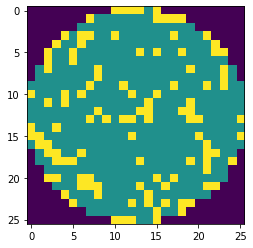

Faulty case : ['none'] 
806


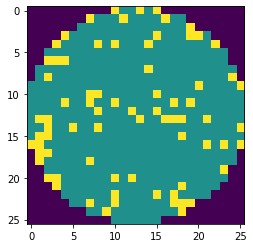

Faulty case : ['none'] 
807


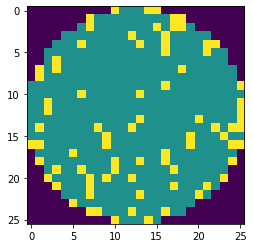

Faulty case : ['none'] 
808


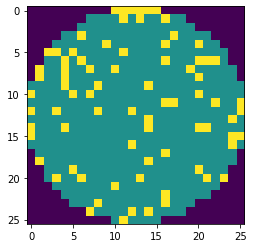

Faulty case : ['none'] 
809


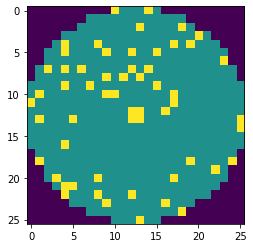

Faulty case : ['none'] 
810


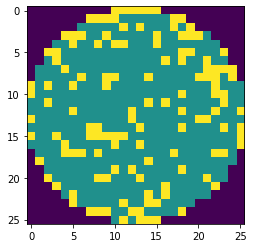

Faulty case : ['none'] 
811


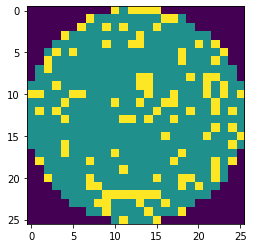

Faulty case : ['none'] 
812


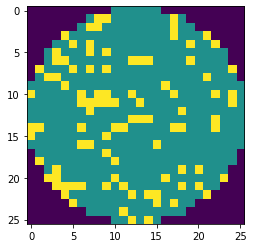

Faulty case : ['none'] 
813


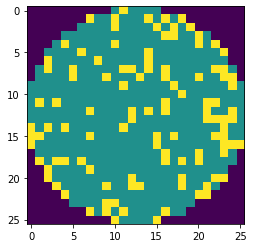

Faulty case : ['none'] 
814


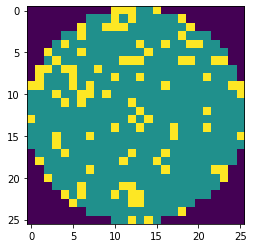

Faulty case : ['none'] 
815


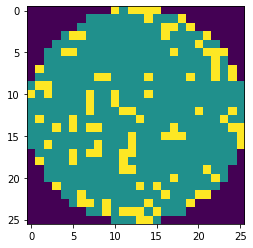

Faulty case : ['none'] 
816


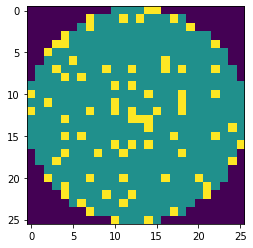

Faulty case : ['none'] 
817


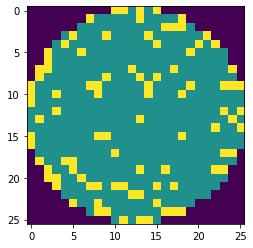

Faulty case : ['none'] 
818


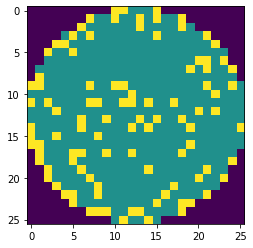

Faulty case : ['none'] 
819


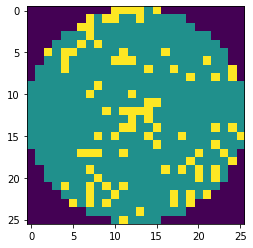

Faulty case : ['none'] 
820


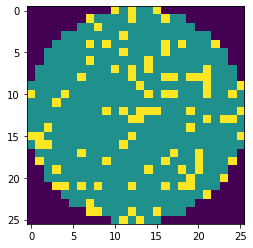

Faulty case : ['none'] 
821


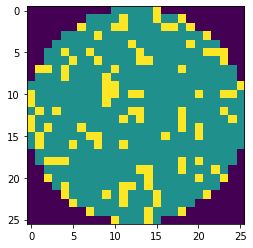

Faulty case : ['none'] 
822


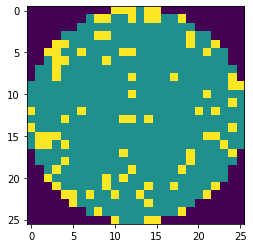

Faulty case : ['none'] 
823


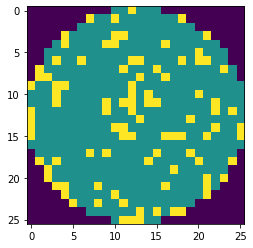

Faulty case : ['none'] 
824


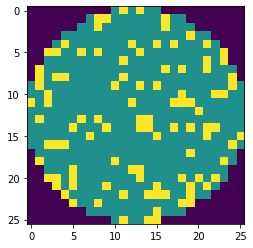

Faulty case : ['none'] 
825


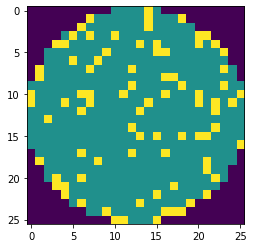

Faulty case : ['none'] 
826


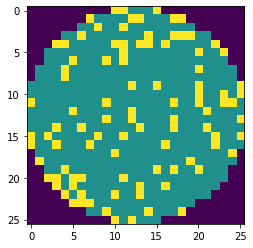

Faulty case : ['none'] 
827


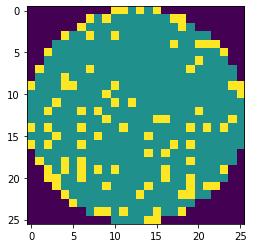

Faulty case : ['none'] 
828


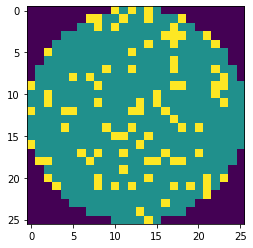

Faulty case : ['none'] 
829


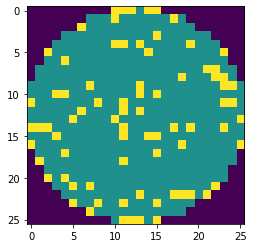

Faulty case : ['none'] 
830


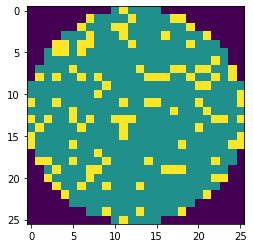

Faulty case : ['none'] 
831


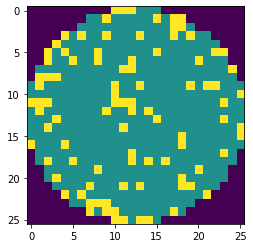

Faulty case : ['none'] 
832


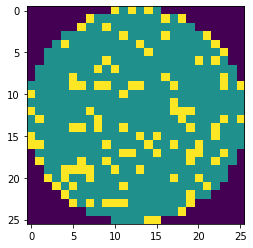

Faulty case : ['none'] 
833


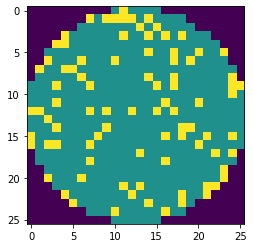

Faulty case : ['none'] 
834


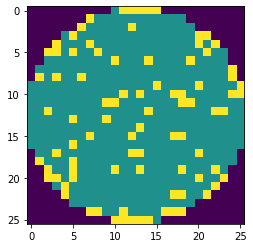

Faulty case : ['none'] 
835


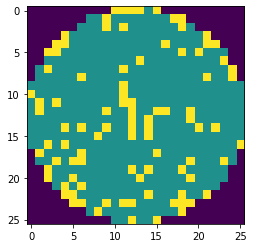

Faulty case : ['none'] 
836


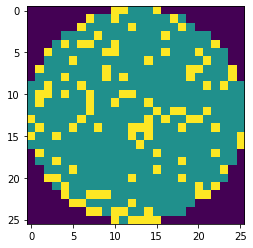

Faulty case : ['none'] 
837


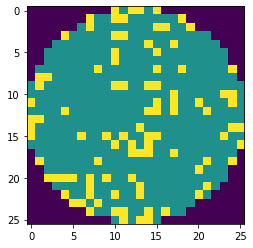

Faulty case : ['none'] 
838


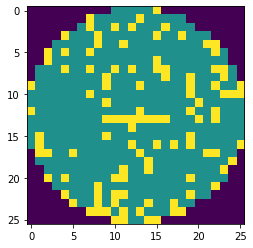

Faulty case : ['none'] 
839


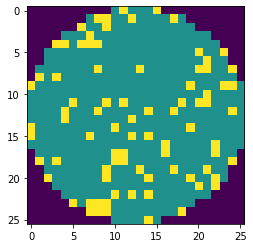

Faulty case : ['none'] 
840


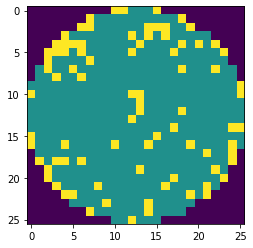

Faulty case : ['none'] 
841


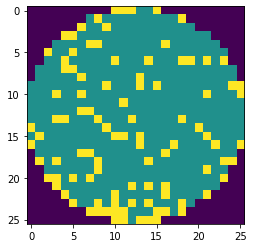

Faulty case : ['none'] 
842


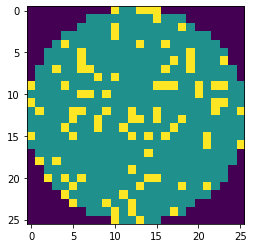

Faulty case : ['none'] 
843


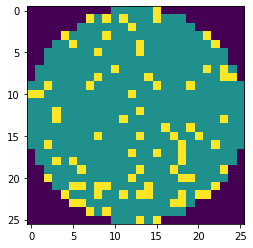

Faulty case : ['none'] 
844


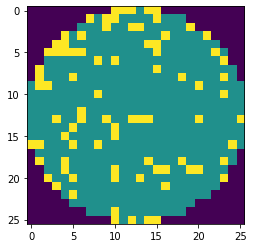

Faulty case : ['none'] 
845


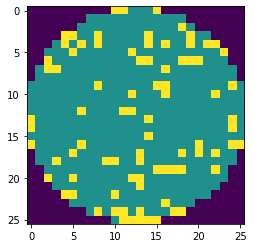

Faulty case : ['none'] 
846


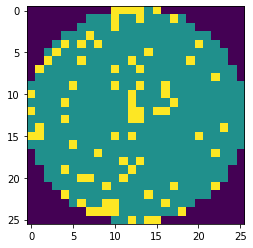

Faulty case : ['none'] 
847


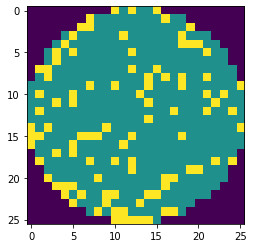

Faulty case : ['none'] 
848


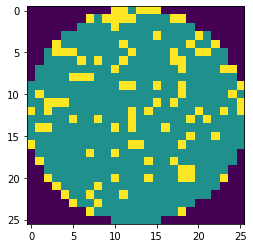

Faulty case : ['none'] 
849


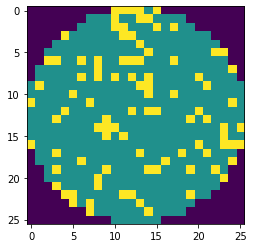

Faulty case : ['none'] 
850


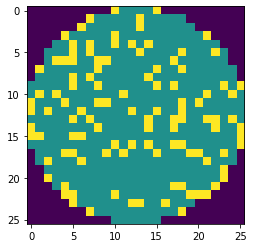

Faulty case : ['none'] 
851


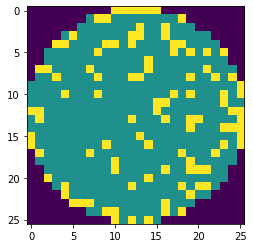

Faulty case : ['none'] 
852


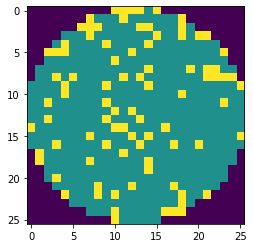

Faulty case : ['none'] 
853


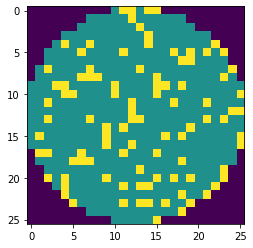

Faulty case : ['none'] 
854


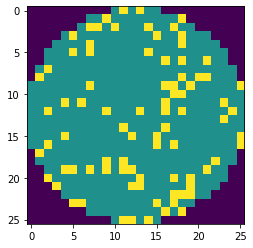

Faulty case : ['none'] 
855


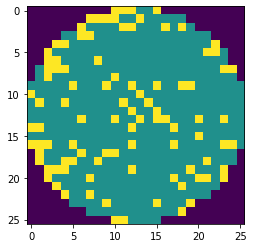

Faulty case : ['none'] 
856


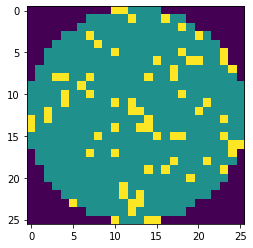

Faulty case : ['none'] 
857


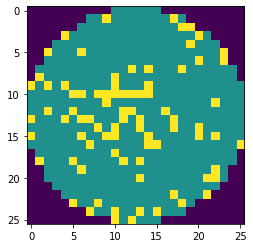

Faulty case : ['none'] 
858


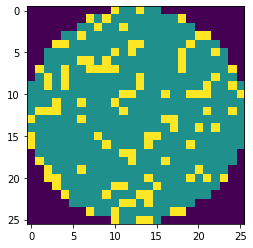

Faulty case : ['none'] 
859


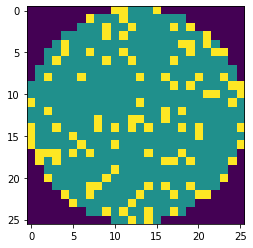

Faulty case : ['none'] 
860


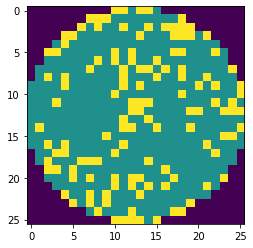

Faulty case : ['none'] 
861


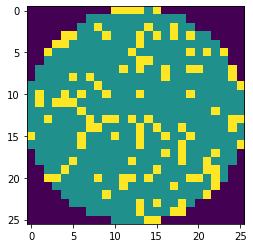

Faulty case : ['none'] 
862


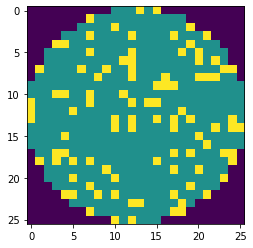

Faulty case : ['none'] 
863


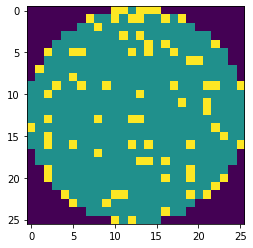

Faulty case : ['none'] 
864


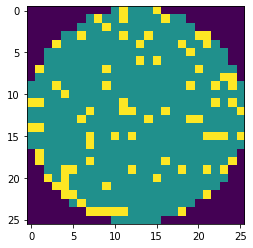

Faulty case : ['none'] 
865


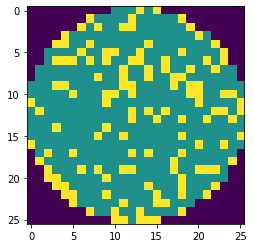

Faulty case : ['none'] 
866


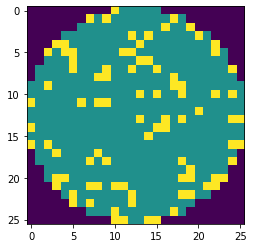

Faulty case : ['none'] 
867


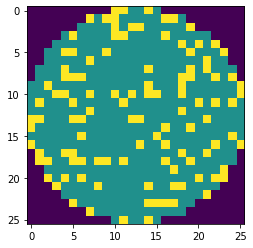

Faulty case : ['none'] 
868


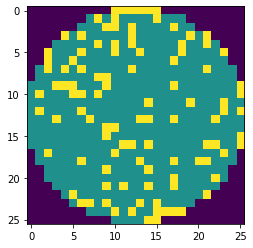

Faulty case : ['none'] 
869


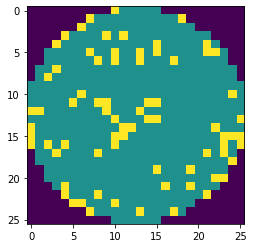

Faulty case : ['none'] 
870


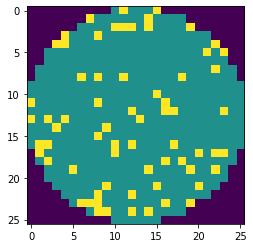

Faulty case : ['none'] 
871


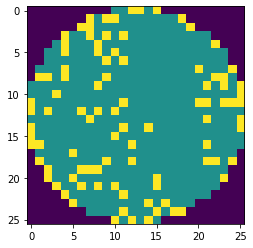

Faulty case : ['none'] 
872


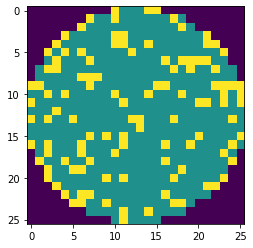

Faulty case : ['none'] 
873


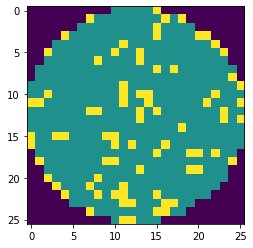

Faulty case : ['none'] 
874


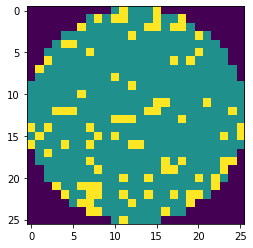

Faulty case : ['none'] 
875


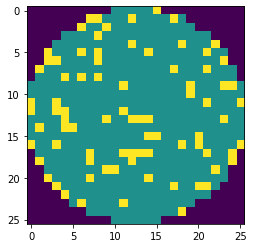

Faulty case : ['none'] 
876


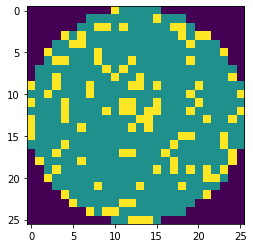

Faulty case : ['none'] 
877


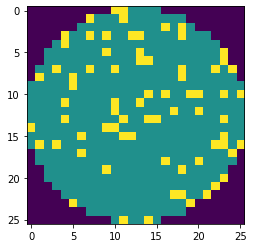

Faulty case : ['none'] 
878


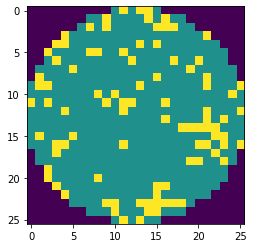

Faulty case : ['none'] 
879


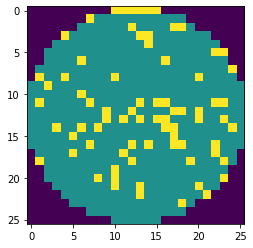

Faulty case : ['none'] 
880


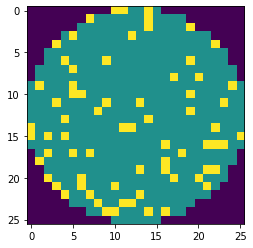

Faulty case : ['none'] 
881


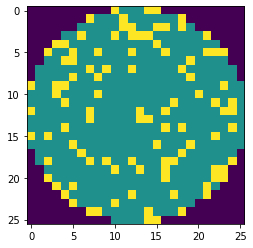

Faulty case : ['none'] 
882


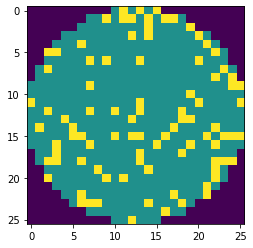

Faulty case : ['none'] 
883


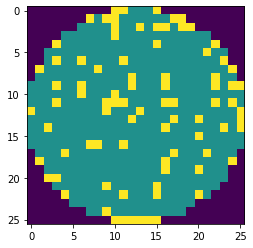

Faulty case : ['none'] 
884


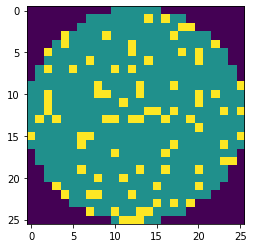

Faulty case : ['none'] 
885


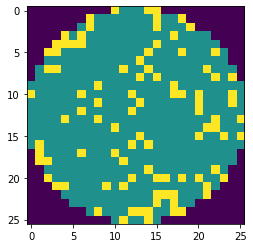

Faulty case : ['none'] 
886


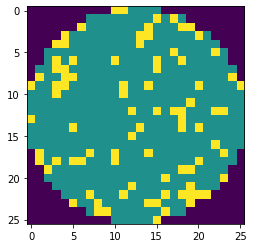

Faulty case : ['none'] 
887


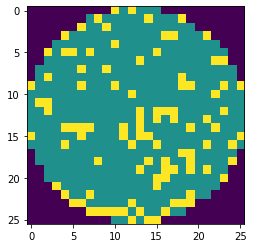

Faulty case : ['none'] 
888


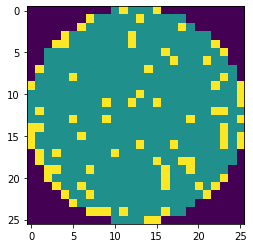

Faulty case : ['none'] 
890


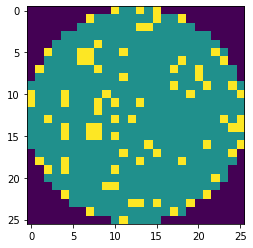

Faulty case : ['none'] 
891


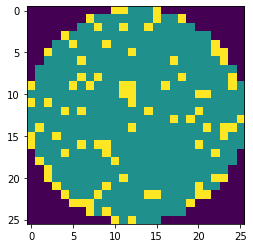

Faulty case : ['none'] 
892


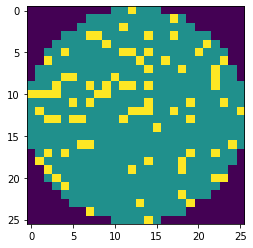

Faulty case : ['none'] 
893


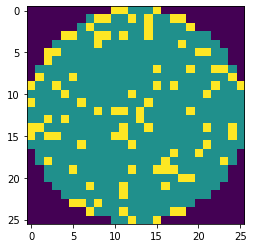

Faulty case : ['none'] 
894


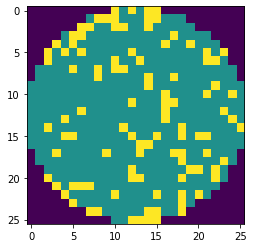

Faulty case : ['none'] 
895


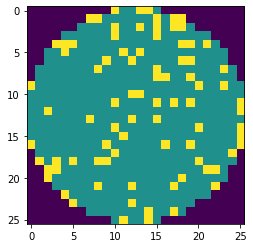

Faulty case : ['none'] 
897


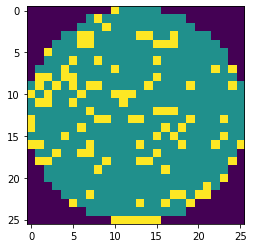

Faulty case : ['none'] 
898


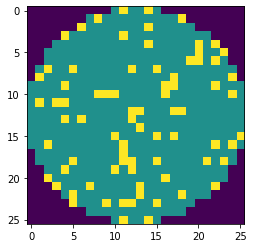

Faulty case : ['none'] 
899


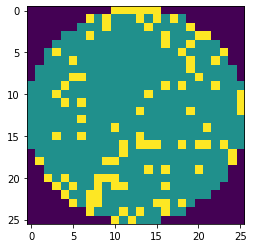

Faulty case : ['none'] 
900


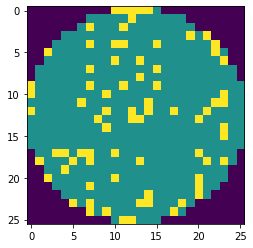

Faulty case : ['none'] 
901


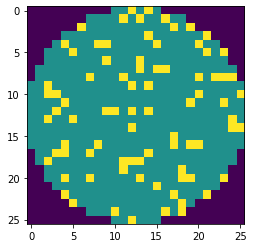

Faulty case : ['none'] 
902


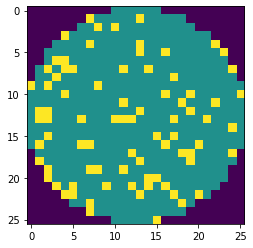

Faulty case : ['none'] 
903


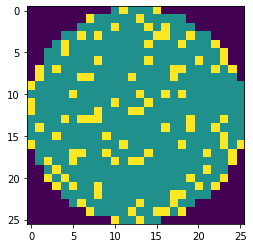

Faulty case : ['none'] 
904


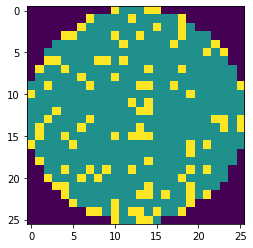

Faulty case : ['none'] 
905


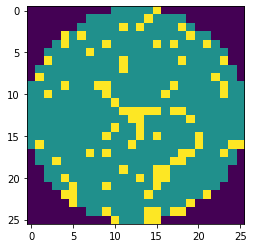

Faulty case : ['none'] 
906


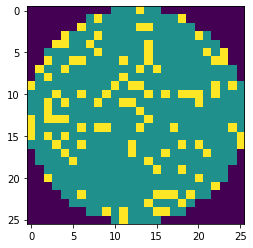

Faulty case : ['none'] 
907


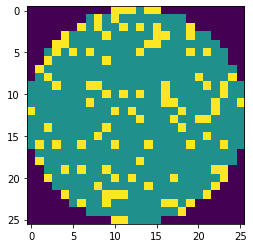

Faulty case : ['none'] 
908


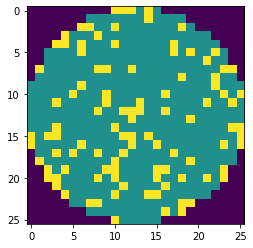

Faulty case : ['none'] 
909


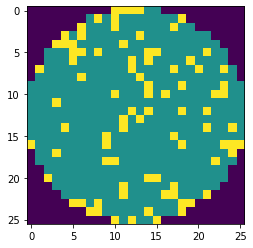

Faulty case : ['none'] 
910


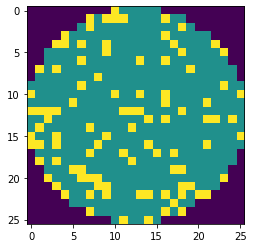

Faulty case : ['none'] 
911


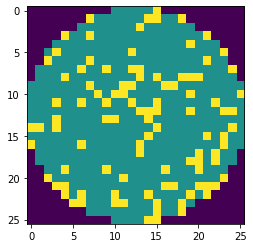

Faulty case : ['none'] 
912


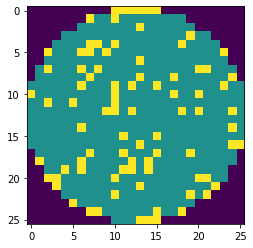

Faulty case : ['none'] 
913


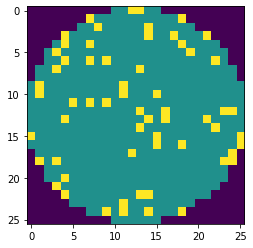

Faulty case : ['none'] 
914


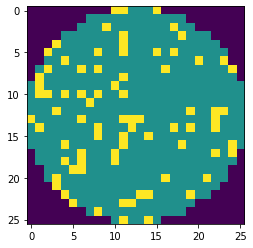

Faulty case : ['none'] 
915


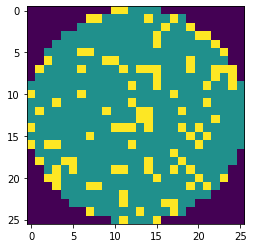

Faulty case : ['none'] 
916


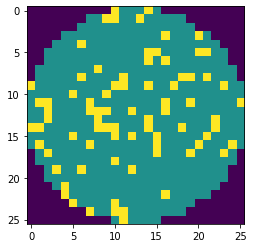

Faulty case : ['none'] 
917


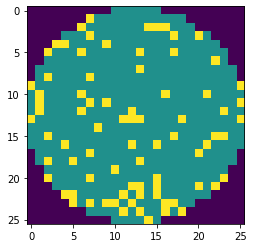

Faulty case : ['none'] 
918


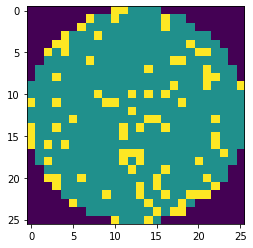

Faulty case : ['none'] 
919


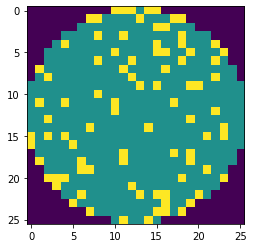

Faulty case : ['none'] 
920


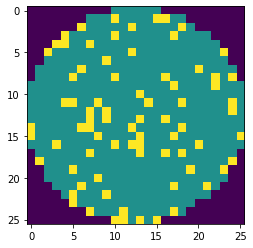

Faulty case : ['none'] 
921


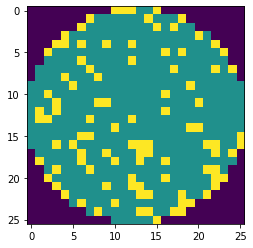

Faulty case : ['none'] 
923


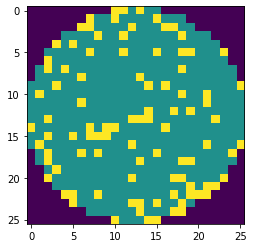

Faulty case : ['none'] 
924


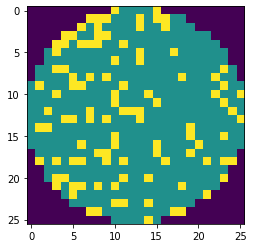

Faulty case : ['none'] 
925


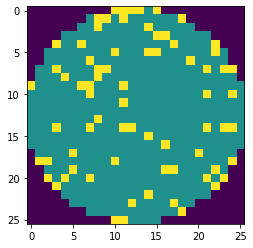

Faulty case : ['none'] 
926


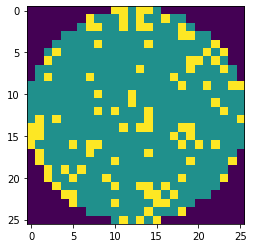

Faulty case : ['none'] 
927


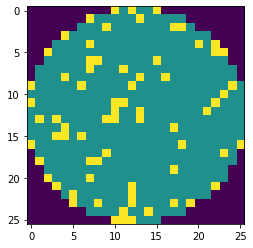

Faulty case : ['none'] 
928


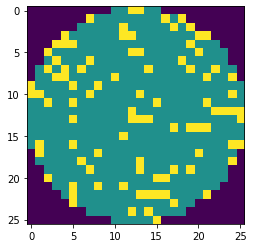

Faulty case : ['none'] 
929


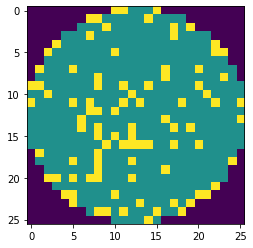

Faulty case : ['none'] 
931


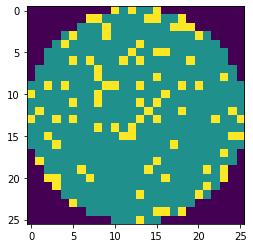

Faulty case : ['none'] 
932


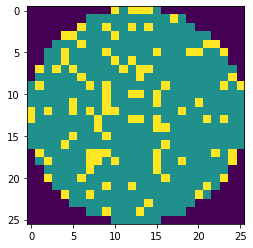

Faulty case : ['none'] 
933


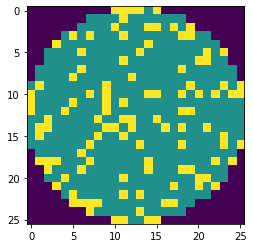

Faulty case : ['none'] 
934


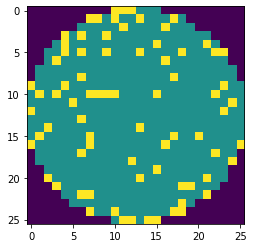

Faulty case : ['none'] 
935


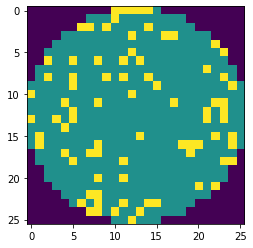

Faulty case : ['none'] 
936


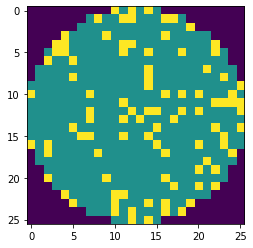

Faulty case : ['none'] 
937


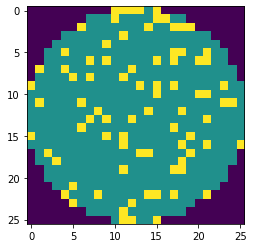

Faulty case : ['none'] 
938


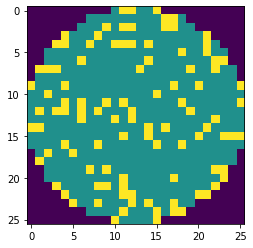

Faulty case : ['none'] 
939


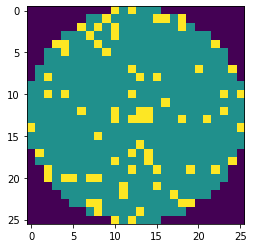

Faulty case : ['none'] 
940


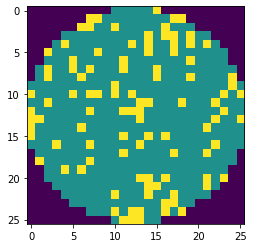

Faulty case : ['none'] 
941


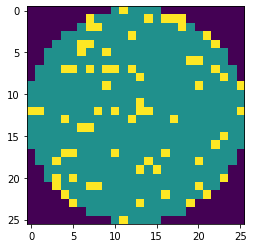

Faulty case : ['none'] 
942


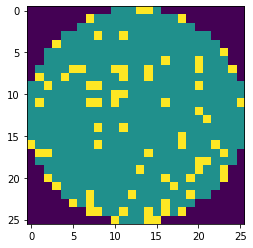

Faulty case : ['none'] 
943


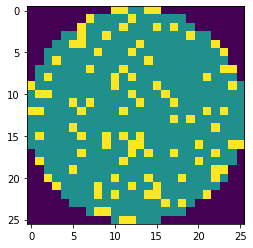

Faulty case : ['none'] 
944


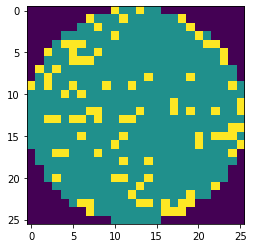

Faulty case : ['none'] 
945


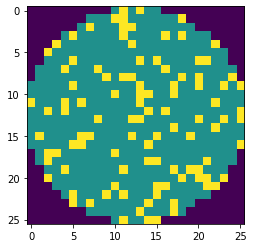

Faulty case : ['none'] 
946


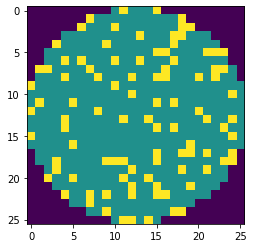

Faulty case : ['none'] 
947


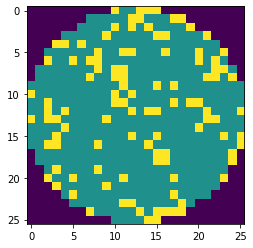

Faulty case : ['none'] 
948


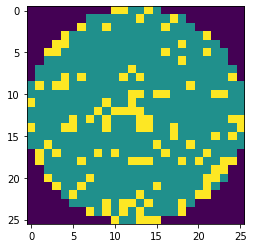

Faulty case : ['none'] 
949


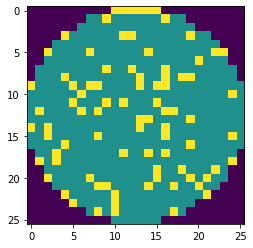

Faulty case : ['none'] 
950


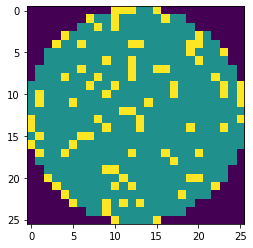

Faulty case : ['none'] 
951


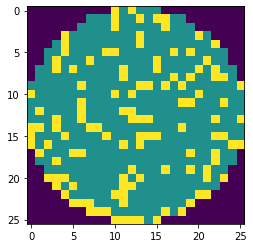

Faulty case : ['none'] 
952


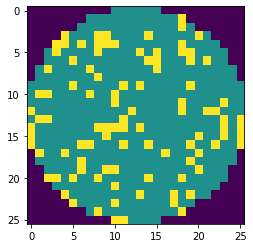

Faulty case : ['none'] 
953


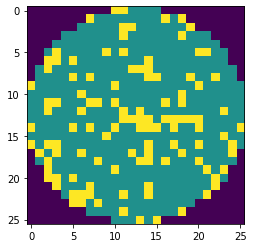

Faulty case : ['none'] 
954


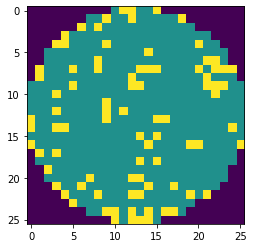

Faulty case : ['none'] 
955


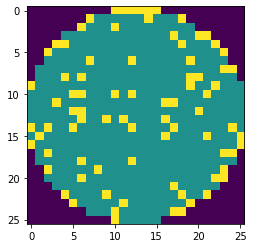

Faulty case : ['none'] 
956


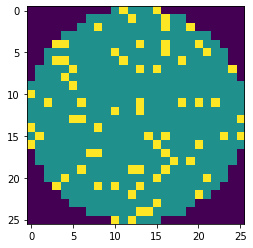

Faulty case : ['none'] 
957


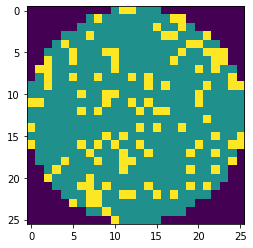

Faulty case : ['none'] 
958


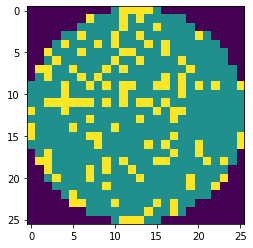

Faulty case : ['none'] 
959


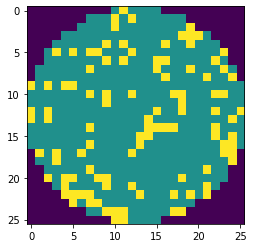

Faulty case : ['none'] 
960


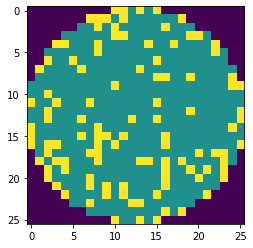

Faulty case : ['none'] 
961


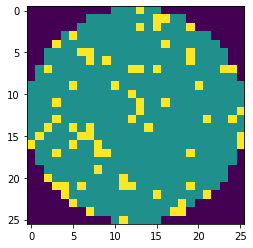

Faulty case : ['none'] 
962


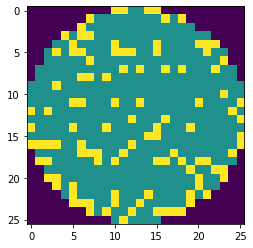

Faulty case : ['none'] 
963


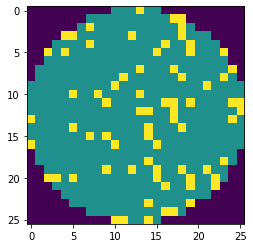

Faulty case : ['none'] 
964


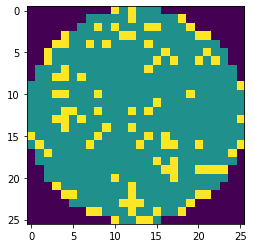

Faulty case : ['none'] 
965


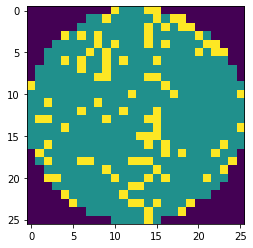

Faulty case : ['none'] 
966


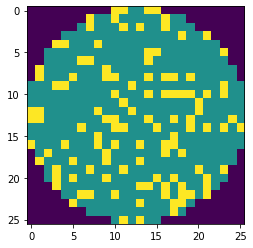

Faulty case : ['none'] 
967


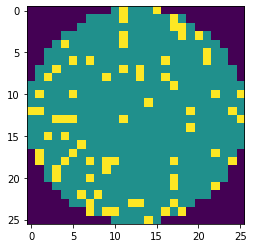

Faulty case : ['none'] 
968


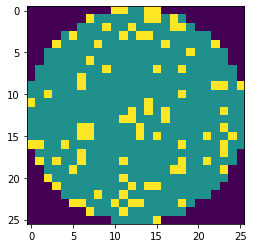

Faulty case : ['none'] 
969


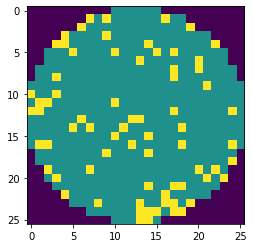

Faulty case : ['none'] 
970


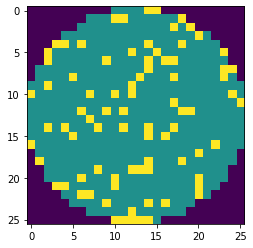

Faulty case : ['none'] 
971


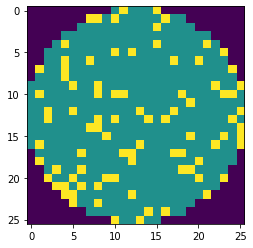

Faulty case : ['none'] 
972


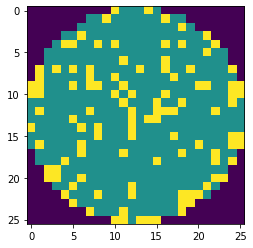

Faulty case : ['none'] 
973


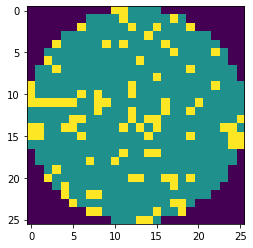

Faulty case : ['none'] 
974


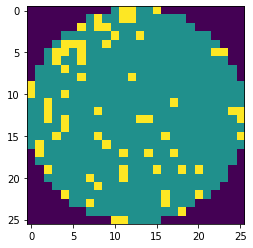

Faulty case : ['none'] 
975


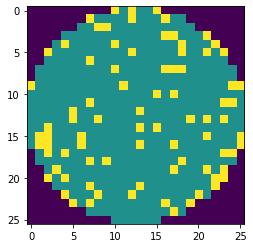

Faulty case : ['none'] 
976


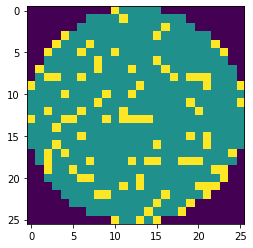

Faulty case : ['none'] 
977


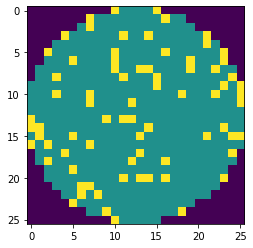

Faulty case : ['none'] 
978


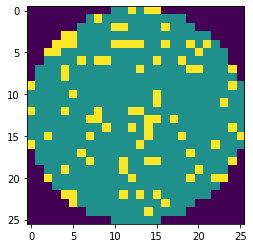

Faulty case : ['none'] 
979


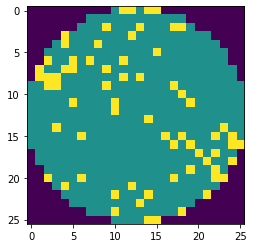

Faulty case : ['none'] 
980


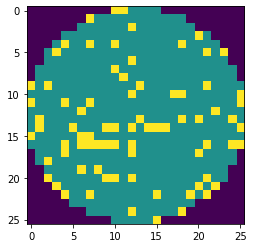

Faulty case : ['none'] 
981


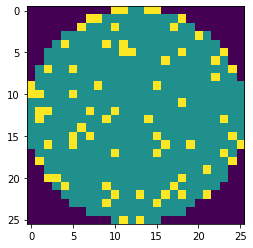

Faulty case : ['none'] 
982


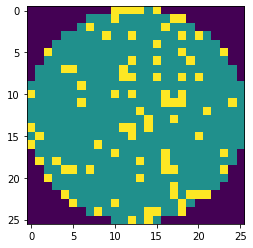

Faulty case : ['none'] 
983


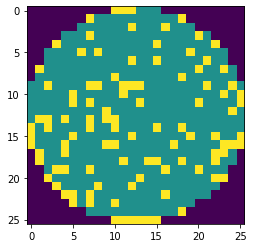

Faulty case : ['none'] 
984


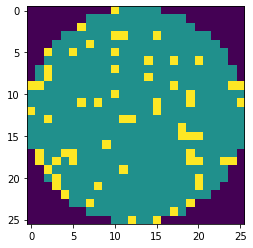

Faulty case : ['none'] 
985


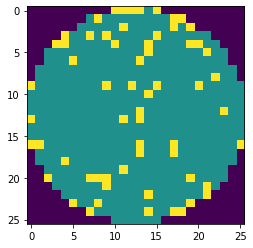

Faulty case : ['none'] 
986


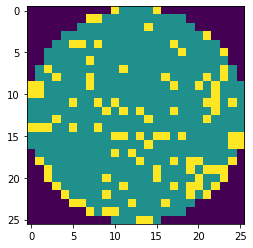

Faulty case : ['none'] 
987


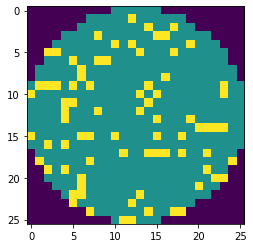

Faulty case : ['none'] 
988


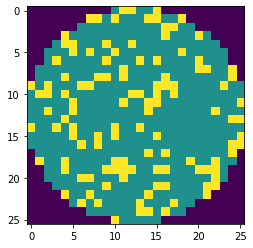

Faulty case : ['none'] 
989


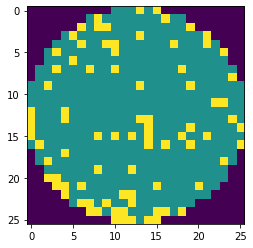

Faulty case : ['none'] 
990


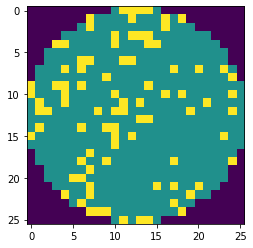

Faulty case : ['none'] 
991


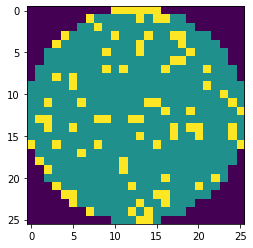

Faulty case : ['none'] 
992


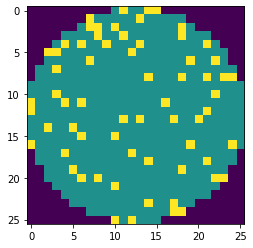

Faulty case : ['none'] 
993


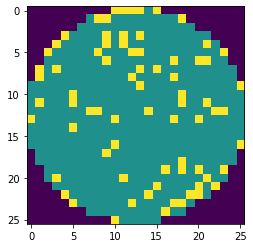

Faulty case : ['none'] 
994


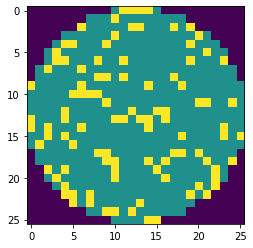

Faulty case : ['none'] 
995


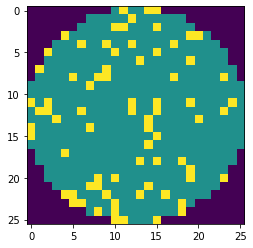

Faulty case : ['none'] 
996


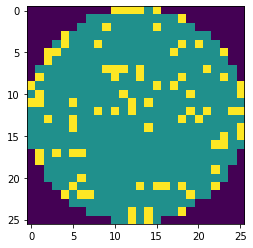

Faulty case : ['none'] 
997


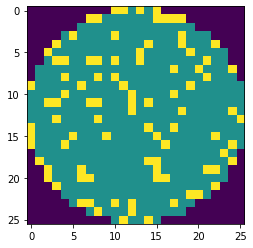

Faulty case : ['none'] 
998


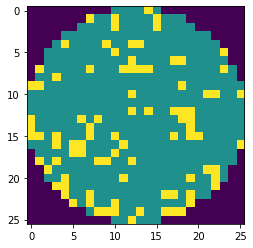

Faulty case : ['none'] 
999


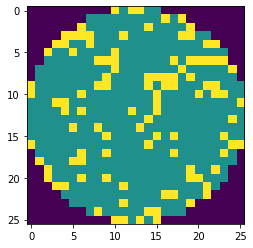

Faulty case : ['none'] 
1000


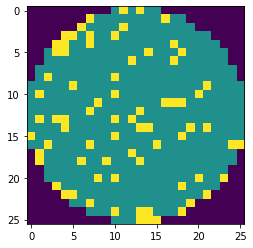

Faulty case : ['none'] 
1001


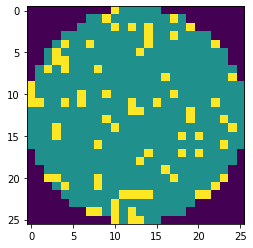

Faulty case : ['none'] 
1002


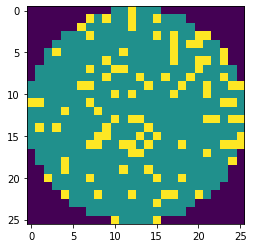

Faulty case : ['none'] 
1003


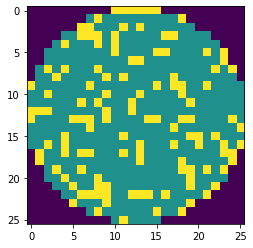

Faulty case : ['none'] 
1004


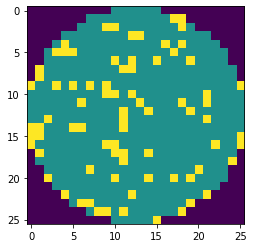

Faulty case : ['none'] 
1005


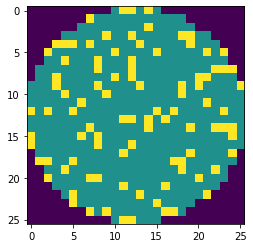

Faulty case : ['none'] 
1006


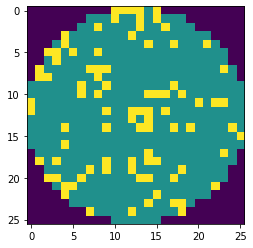

Faulty case : ['none'] 
1007


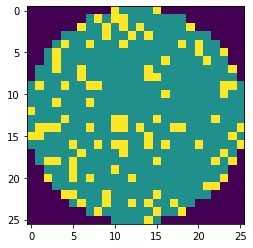

Faulty case : ['none'] 
1008


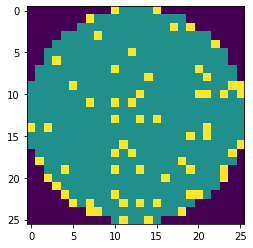

Faulty case : ['none'] 
1009


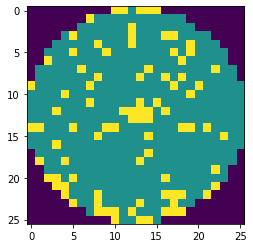

Faulty case : ['none'] 
1011


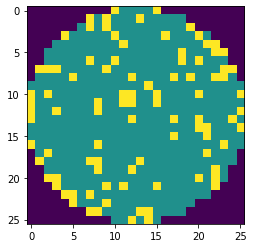

Faulty case : ['none'] 
1012


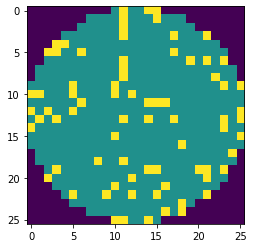

Faulty case : ['none'] 
1013


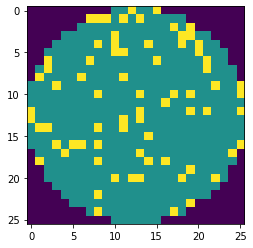

Faulty case : ['none'] 
1014


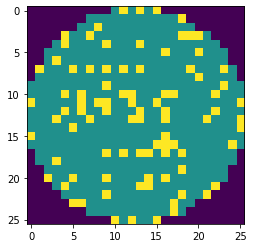

Faulty case : ['none'] 
1015


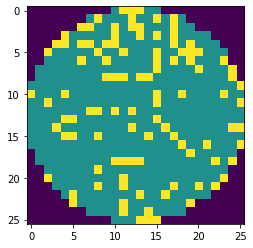

Faulty case : ['none'] 
1016


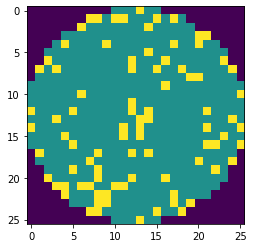

Faulty case : ['none'] 
1017


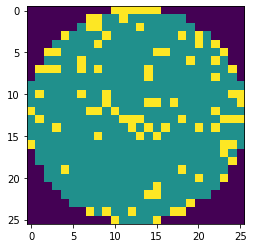

Faulty case : ['none'] 
1018


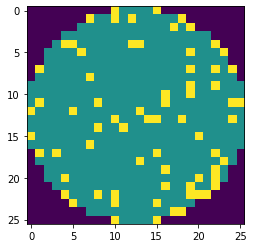

Faulty case : ['none'] 
1019


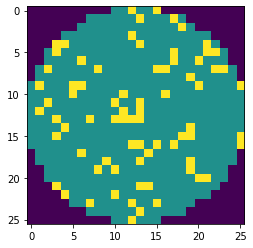

Faulty case : ['none'] 
1020


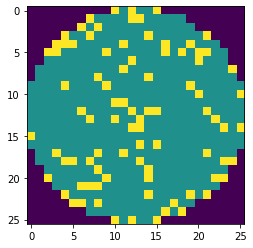

Faulty case : ['none'] 
1021


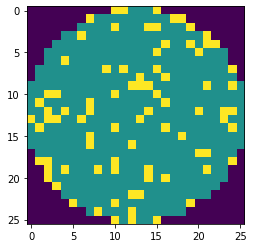

Faulty case : ['none'] 
1022


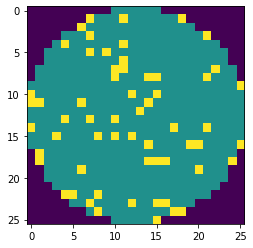

Faulty case : ['none'] 
1023


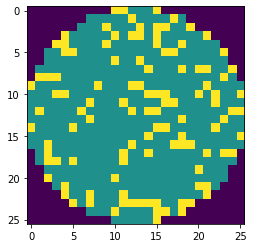

Faulty case : ['none'] 
1024


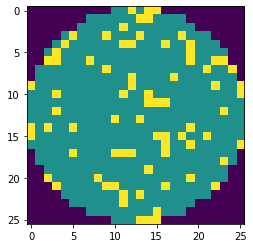

Faulty case : ['none'] 
1025


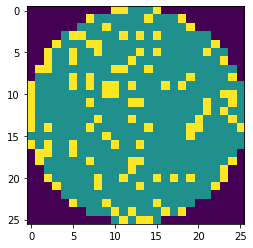

Faulty case : ['none'] 
1026


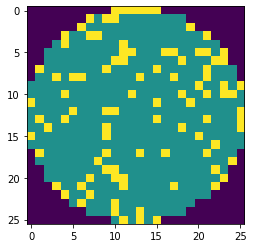

Faulty case : ['none'] 
1027


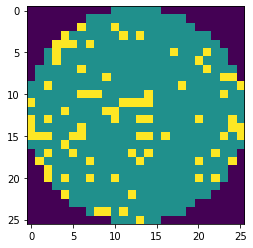

Faulty case : ['none'] 
1028


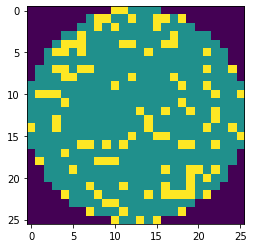

Faulty case : ['none'] 
1029


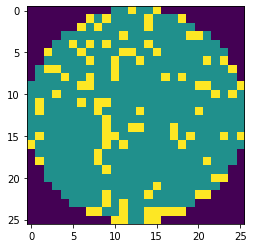

Faulty case : ['none'] 
1030


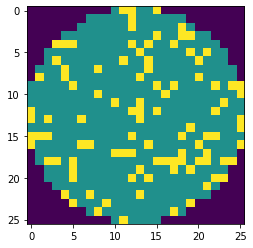

Faulty case : ['none'] 
1031


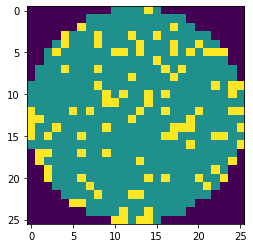

Faulty case : ['none'] 
1032


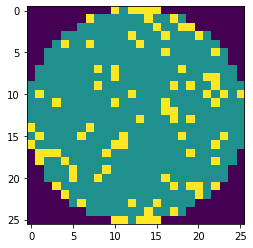

Faulty case : ['none'] 
1033


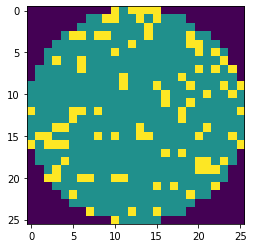

Faulty case : ['none'] 
1034


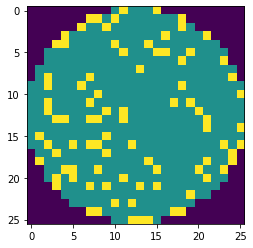

Faulty case : ['none'] 
1035


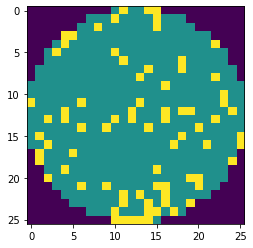

Faulty case : ['none'] 
1036


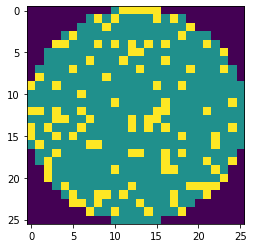

Faulty case : ['none'] 
1037


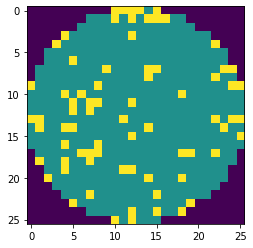

Faulty case : ['none'] 
1038


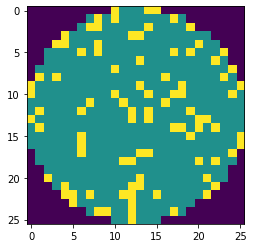

Faulty case : ['none'] 
1039


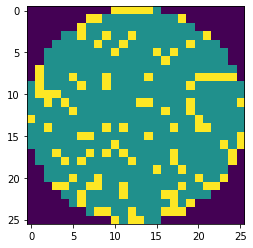

Faulty case : ['none'] 
1040


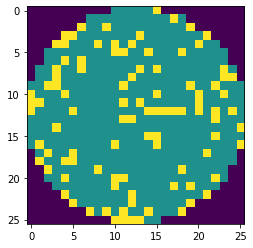

Faulty case : ['none'] 
1041


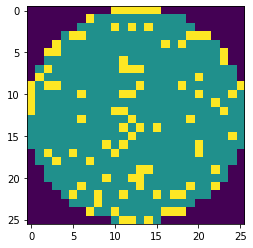

Faulty case : ['none'] 
1042


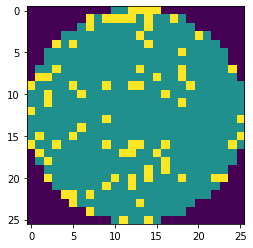

Faulty case : ['none'] 
1043


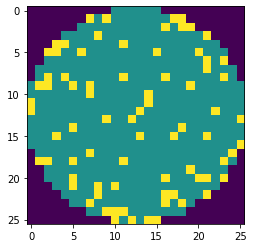

Faulty case : ['none'] 
1044


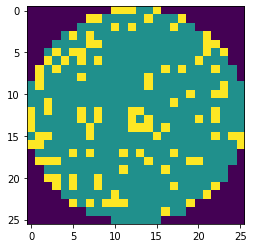

Faulty case : ['none'] 
1045


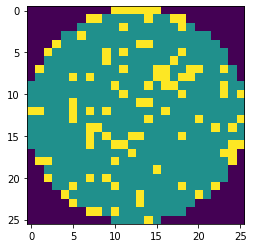

Faulty case : ['none'] 
1046


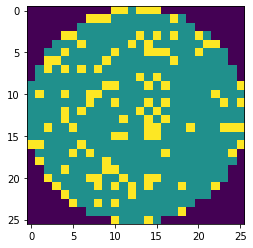

Faulty case : ['none'] 
1047


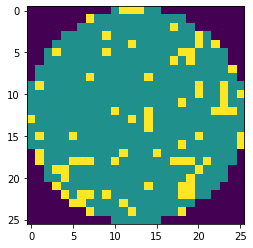

Faulty case : ['none'] 
1048


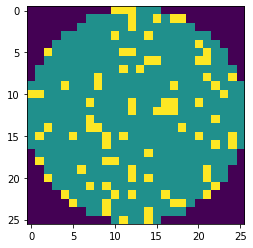

Faulty case : ['none'] 
1049


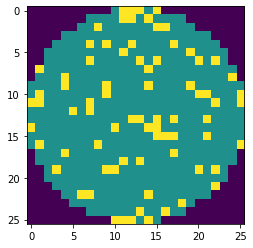

Faulty case : ['none'] 
1050


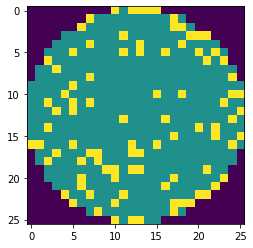

Faulty case : ['none'] 
1051


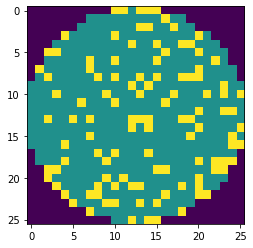

Faulty case : ['none'] 
1052


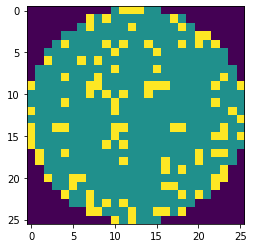

Faulty case : ['none'] 
1053


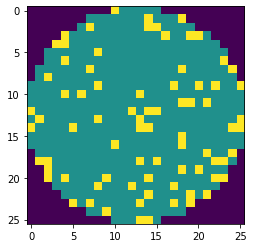

Faulty case : ['none'] 
1054


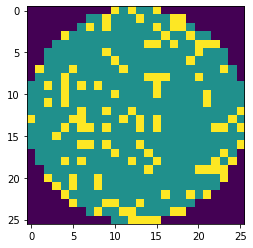

Faulty case : ['none'] 
1055


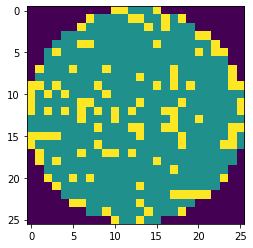

Faulty case : ['none'] 
1056


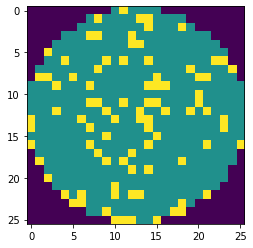

Faulty case : ['none'] 
1057


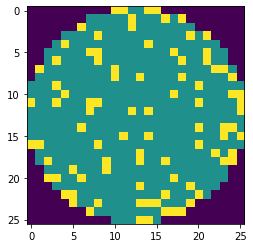

Faulty case : ['none'] 
1058


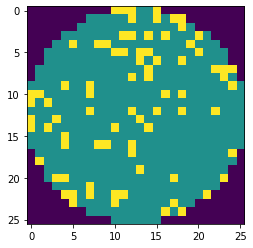

Faulty case : ['none'] 
1059


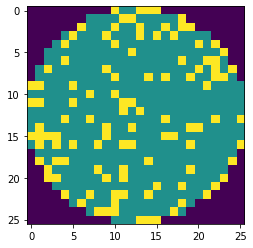

Faulty case : ['none'] 
1060


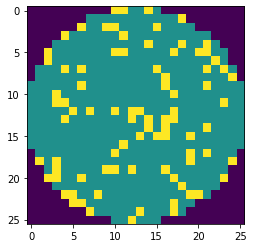

Faulty case : ['none'] 
1061


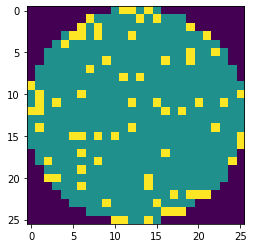

Faulty case : ['none'] 
1062


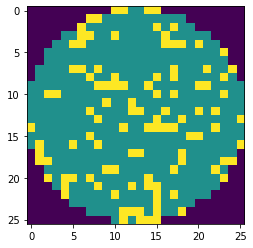

Faulty case : ['none'] 
1063


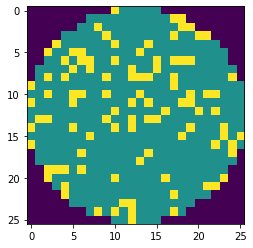

Faulty case : ['none'] 
1064


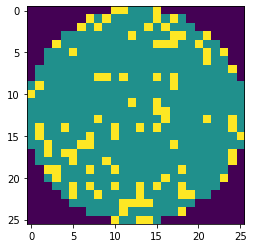

Faulty case : ['none'] 
1065


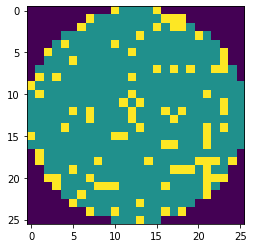

Faulty case : ['none'] 
1066


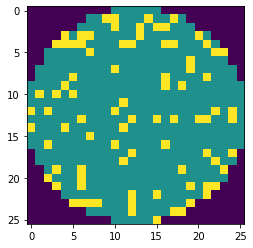

Faulty case : ['none'] 
1067


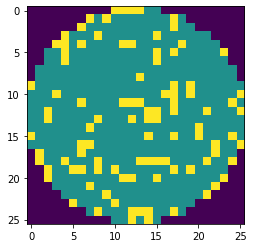

Faulty case : ['none'] 
1068


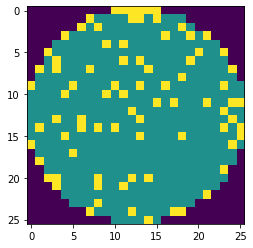

Faulty case : ['none'] 
1069


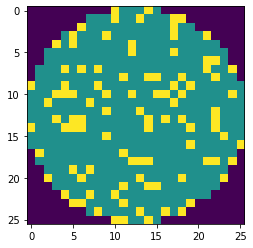

Faulty case : ['none'] 
1070


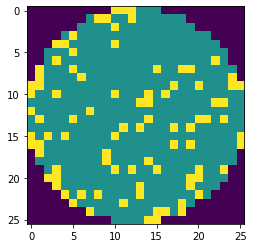

Faulty case : ['none'] 
1071


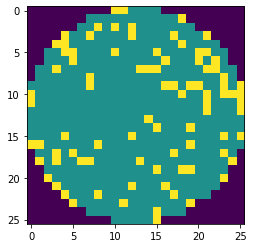

Faulty case : ['none'] 
1072


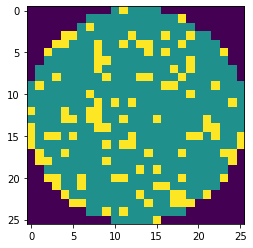

Faulty case : ['none'] 
1073


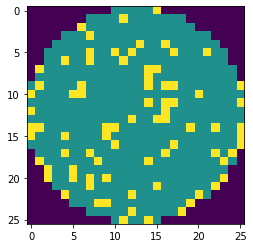

Faulty case : ['none'] 
1074


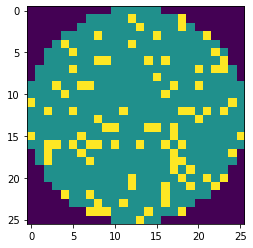

Faulty case : ['none'] 
1075


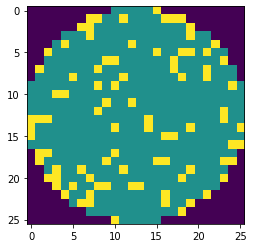

Faulty case : ['none'] 
1076


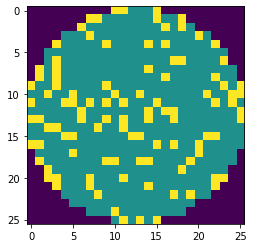

Faulty case : ['none'] 
1077


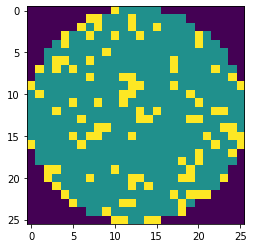

Faulty case : ['none'] 
1078


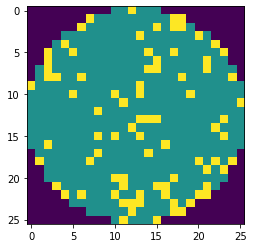

Faulty case : ['none'] 
1079


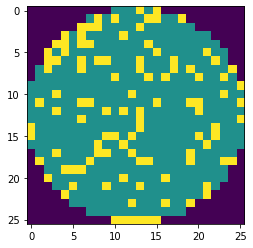

Faulty case : ['none'] 
1080


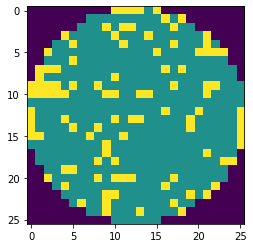

Faulty case : ['none'] 
1081


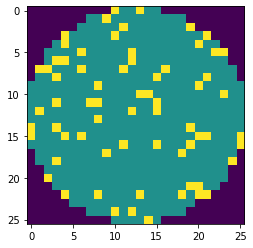

Faulty case : ['none'] 
1082


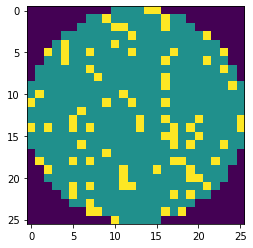

Faulty case : ['none'] 
1083


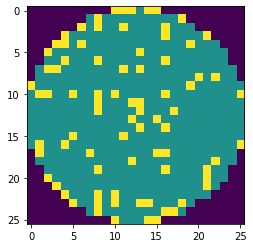

Faulty case : ['none'] 
1084


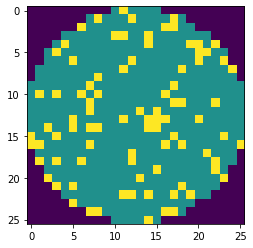

Faulty case : ['none'] 
1085


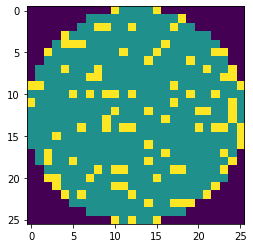

Faulty case : ['none'] 
1086


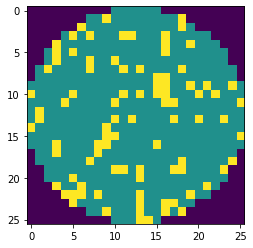

Faulty case : ['none'] 
1087


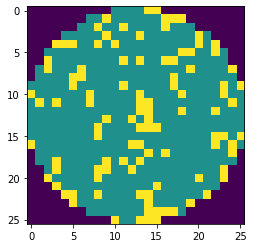

Faulty case : ['none'] 
1088


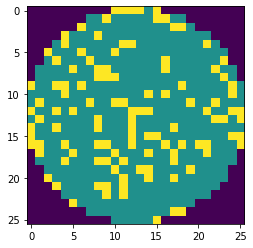

Faulty case : ['none'] 
1089


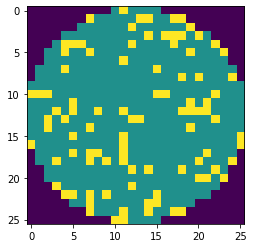

Faulty case : ['none'] 
1090


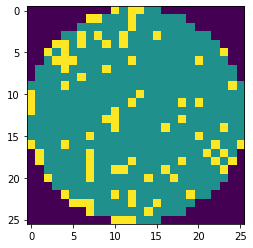

Faulty case : ['none'] 
1091


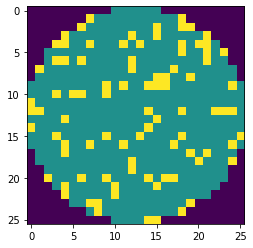

Faulty case : ['none'] 
1092


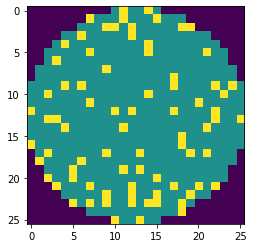

Faulty case : ['none'] 
1093


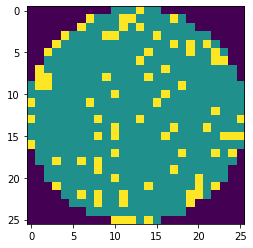

Faulty case : ['none'] 
1094


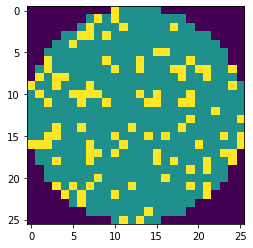

Faulty case : ['none'] 
1095


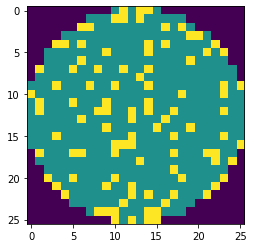

Faulty case : ['none'] 
1096


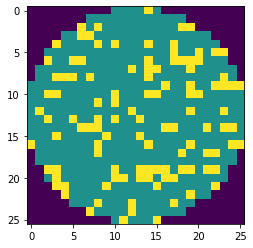

Faulty case : ['none'] 
1097


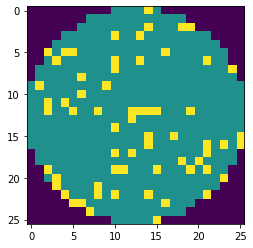

Faulty case : ['none'] 
1098


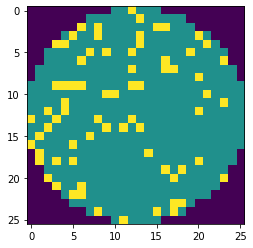

Faulty case : ['none'] 
1099


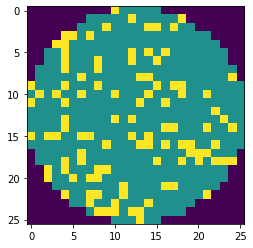

Faulty case : ['none'] 
1100


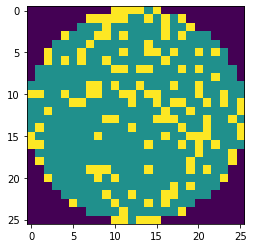

Faulty case : ['none'] 
1101


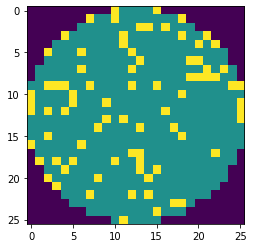

Faulty case : ['none'] 
1102


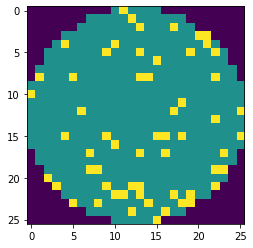

Faulty case : ['none'] 
1103


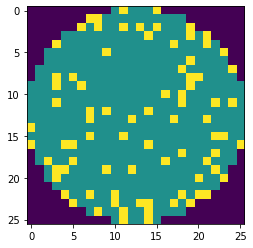

Faulty case : ['none'] 
1104


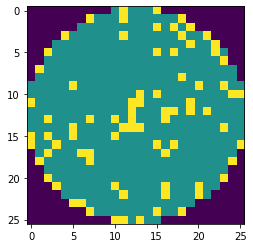

Faulty case : ['none'] 
1105


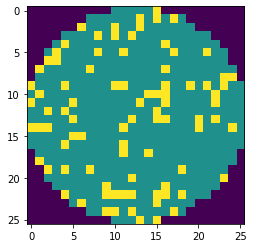

Faulty case : ['none'] 
1106


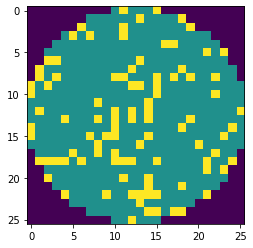

Faulty case : ['none'] 
1107


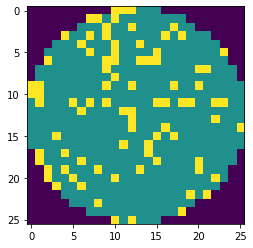

Faulty case : ['none'] 
1108


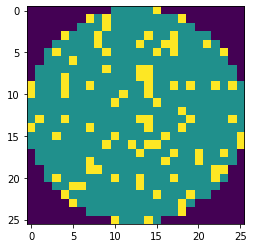

Faulty case : ['none'] 
1109


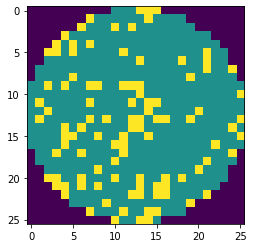

Faulty case : ['none'] 
1110


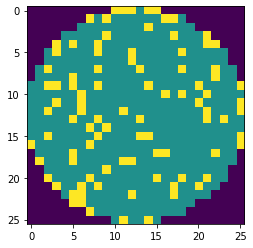

Faulty case : ['none'] 
1111


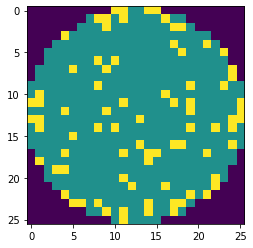

Faulty case : ['none'] 
1112


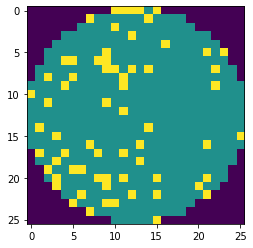

Faulty case : ['none'] 
1113


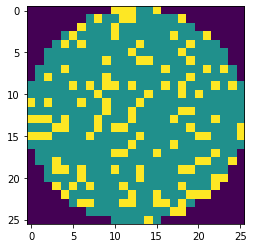

Faulty case : ['none'] 
1114


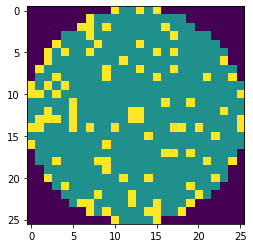

Faulty case : ['none'] 
1115


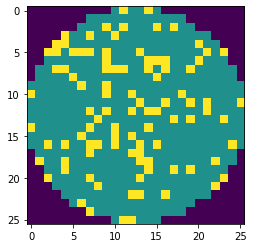

Faulty case : ['none'] 
1116


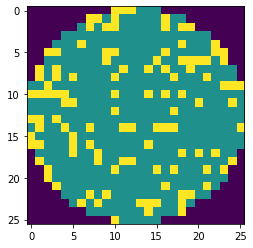

Faulty case : ['none'] 
1118


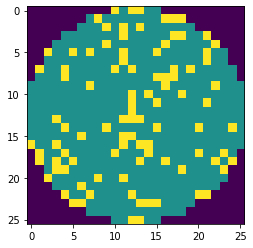

Faulty case : ['none'] 
1119


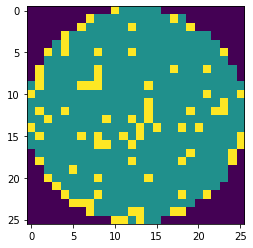

Faulty case : ['none'] 
1120


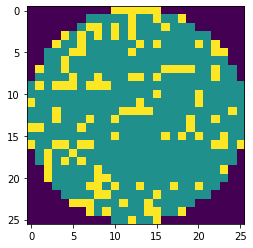

Faulty case : ['none'] 
1121


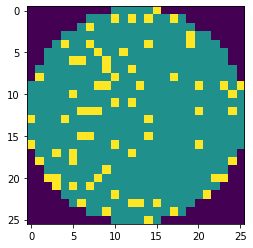

Faulty case : ['none'] 
1122


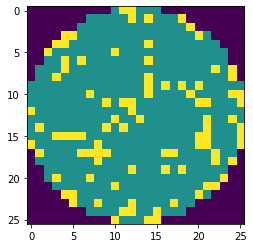

Faulty case : ['none'] 
1123


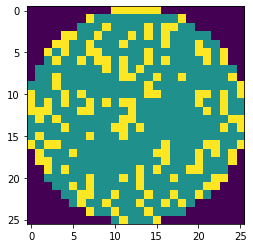

Faulty case : ['none'] 
1124


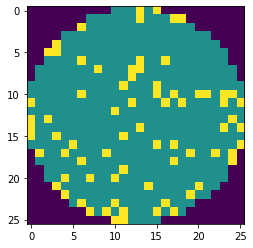

Faulty case : ['none'] 
1125


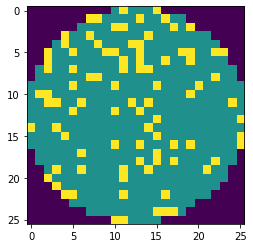

Faulty case : ['none'] 
1126


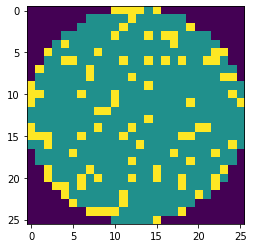

Faulty case : ['none'] 
1127


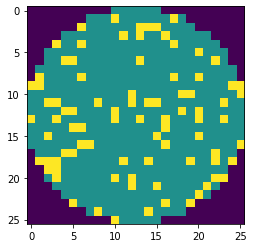

Faulty case : ['none'] 
1128


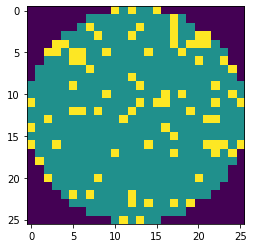

Faulty case : ['none'] 
1129


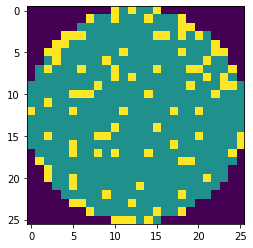

Faulty case : ['none'] 
1130


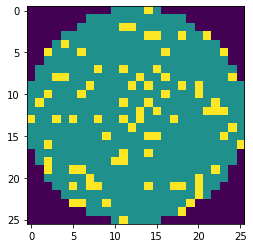

Faulty case : ['none'] 
1131


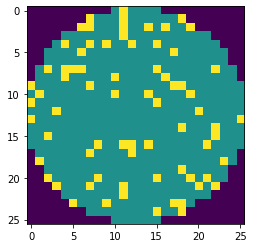

Faulty case : ['none'] 
1132


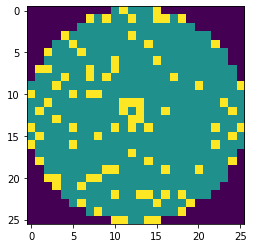

Faulty case : ['none'] 
1133


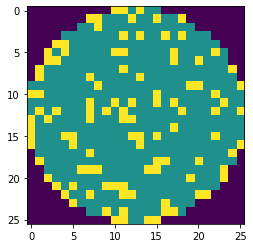

Faulty case : ['none'] 
1134


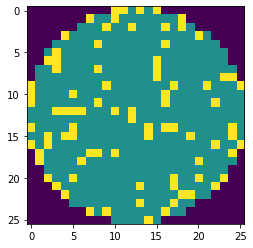

Faulty case : ['none'] 
1135


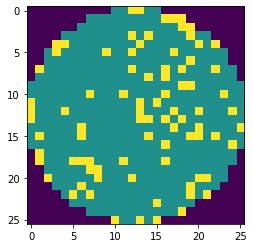

Faulty case : ['none'] 
1136


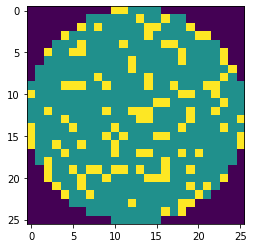

Faulty case : ['none'] 
1137


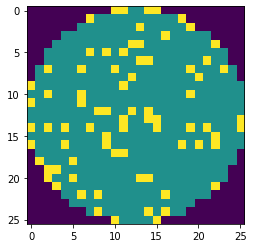

Faulty case : ['none'] 
1138


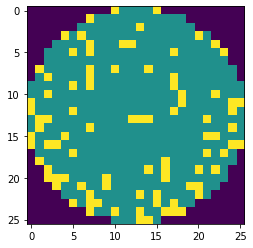

Faulty case : ['none'] 
1139


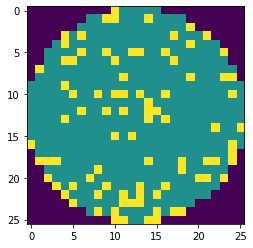

Faulty case : ['none'] 
1140


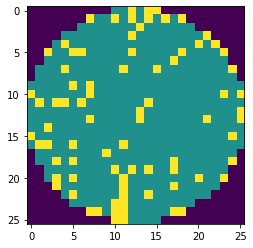

Faulty case : ['none'] 
1141


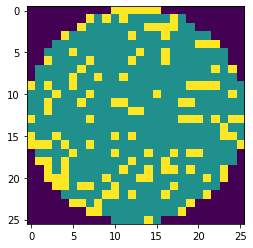

Faulty case : ['none'] 
1142


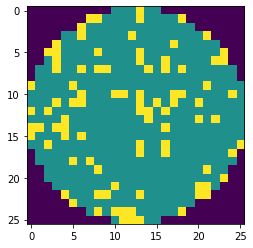

Faulty case : ['none'] 
1143


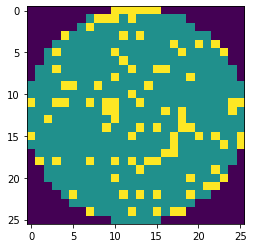

Faulty case : ['none'] 
1144


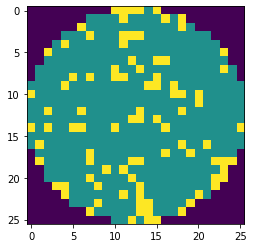

Faulty case : ['none'] 
1145


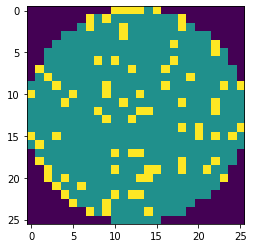

Faulty case : ['none'] 
1146


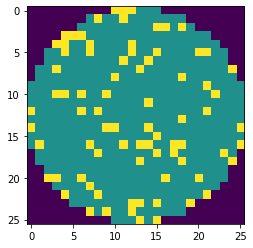

Faulty case : ['none'] 
1147


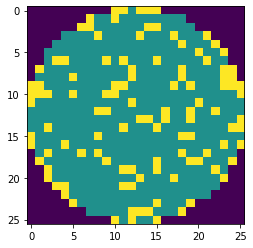

Faulty case : ['none'] 
1148


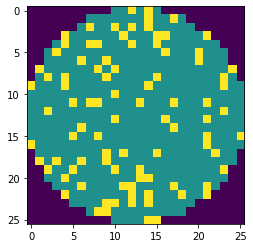

Faulty case : ['none'] 
1149


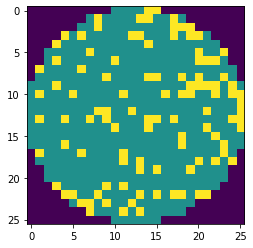

Faulty case : ['none'] 
1150


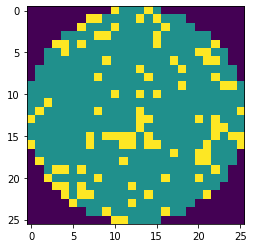

Faulty case : ['none'] 
1151


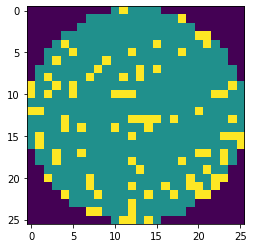

Faulty case : ['none'] 
1152


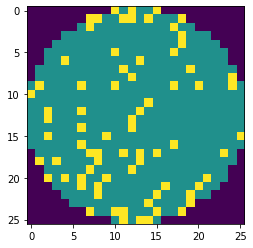

Faulty case : ['none'] 
1153


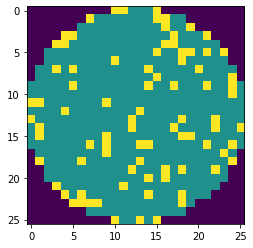

Faulty case : ['none'] 
1154


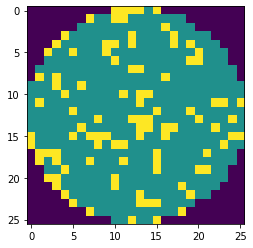

Faulty case : ['none'] 
1155


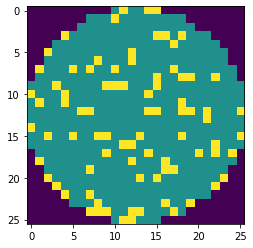

Faulty case : ['none'] 
1156


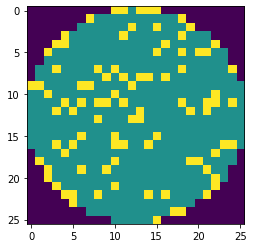

Faulty case : ['none'] 
1158


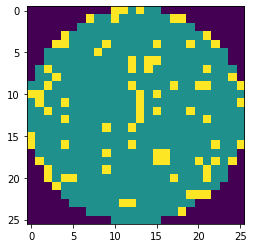

Faulty case : ['none'] 
1159


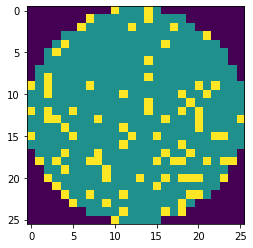

Faulty case : ['none'] 
1160


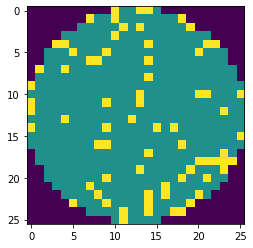

Faulty case : ['none'] 
1161


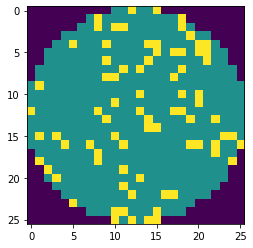

Faulty case : ['none'] 
1163


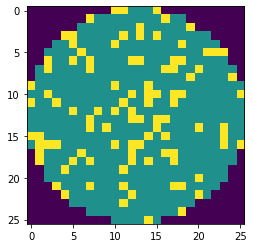

Faulty case : ['none'] 
1164


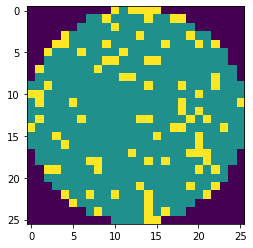

Faulty case : ['none'] 
1165


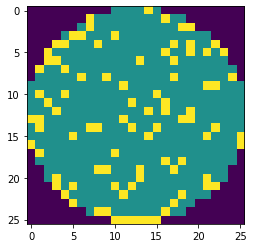

Faulty case : ['none'] 
1166


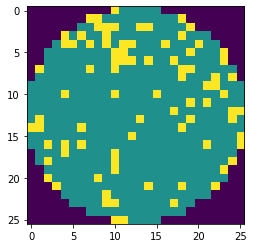

Faulty case : ['none'] 
1167


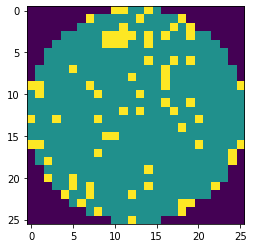

Faulty case : ['none'] 
1168


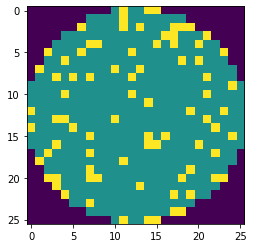

Faulty case : ['none'] 
1169


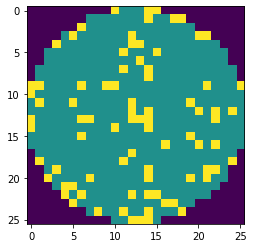

Faulty case : ['none'] 
1170


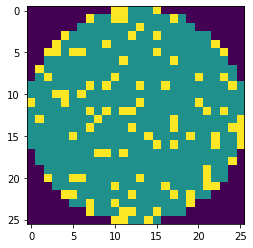

Faulty case : ['none'] 
1171


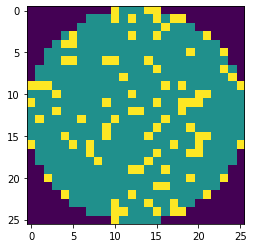

Faulty case : ['none'] 
1172


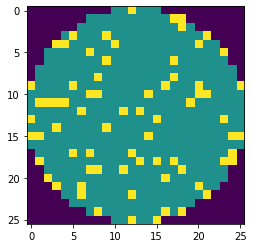

Faulty case : ['none'] 
1173


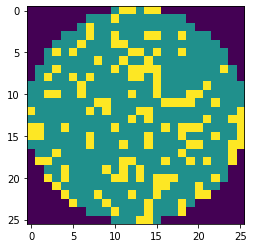

Faulty case : ['none'] 
1174


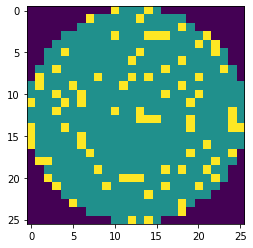

Faulty case : ['none'] 
1175


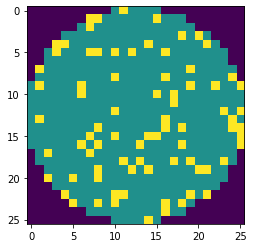

Faulty case : ['none'] 
1176


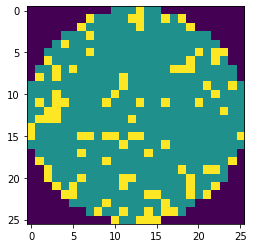

Faulty case : ['none'] 
1177


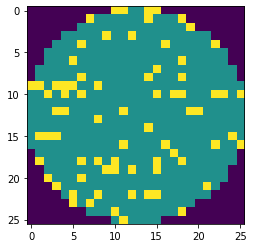

Faulty case : ['none'] 
1178


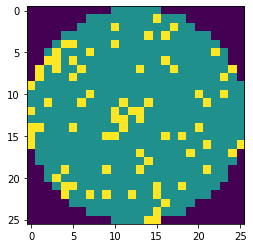

Faulty case : ['none'] 
1179


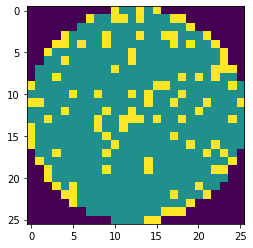

Faulty case : ['none'] 
1180


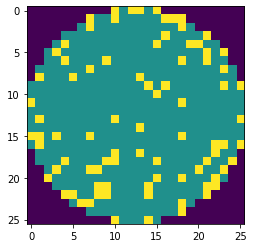

Faulty case : ['none'] 
1181


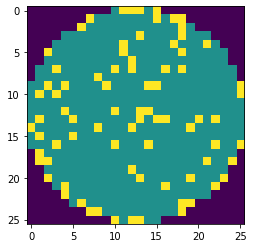

Faulty case : ['none'] 
1182


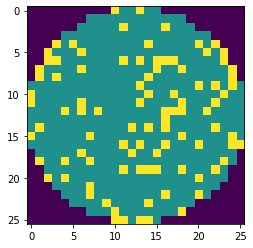

Faulty case : ['none'] 
1183


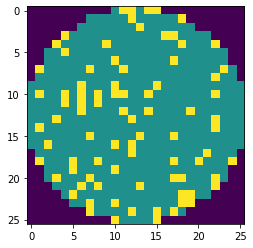

Faulty case : ['none'] 
1184


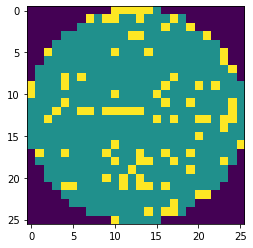

Faulty case : ['none'] 
1185


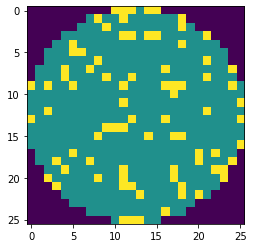

Faulty case : ['none'] 
1186


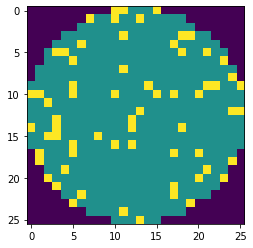

Faulty case : ['none'] 
1187


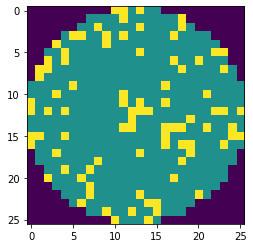

Faulty case : ['none'] 
1188


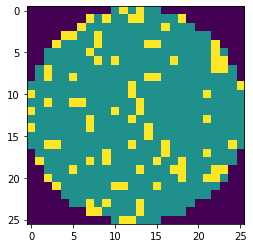

Faulty case : ['none'] 
1189


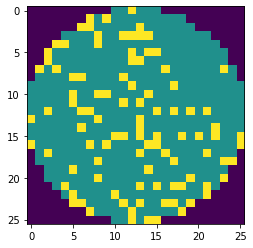

Faulty case : ['none'] 
1190


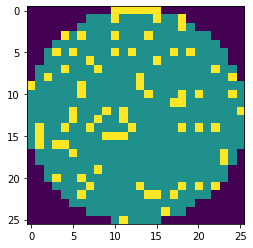

Faulty case : ['none'] 
1191


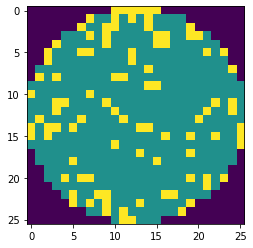

Faulty case : ['none'] 
1192


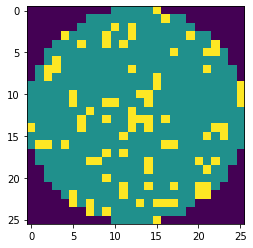

Faulty case : ['none'] 
1193


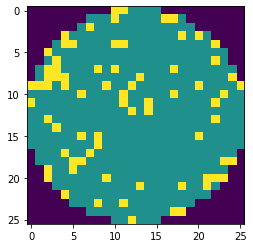

Faulty case : ['none'] 
1194


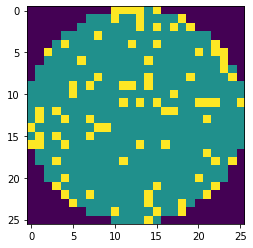

Faulty case : ['none'] 
1195


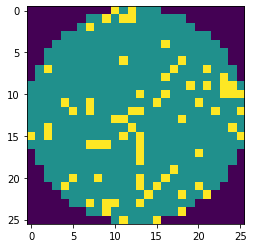

Faulty case : ['none'] 
1196


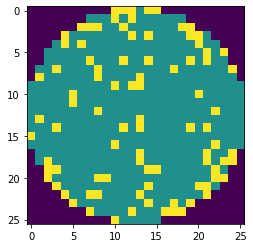

Faulty case : ['none'] 
1197


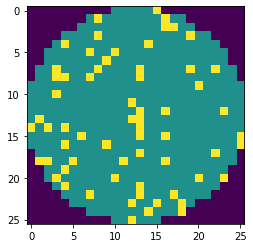

Faulty case : ['none'] 
1198


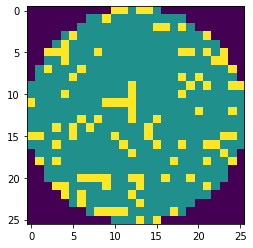

Faulty case : ['none'] 
1199


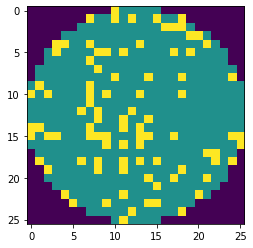

Faulty case : ['none'] 
1200


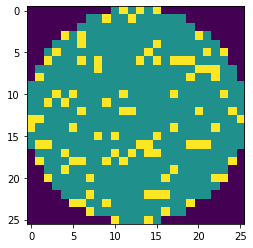

Faulty case : ['none'] 
1202


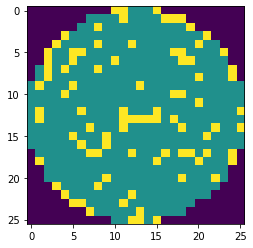

Faulty case : ['none'] 
1203


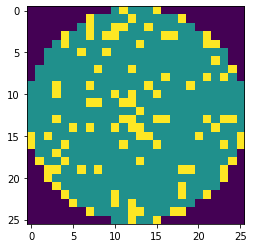

Faulty case : ['none'] 
1204


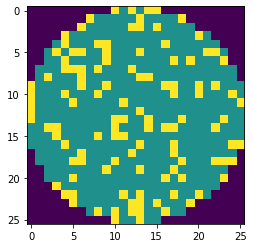

Faulty case : ['none'] 
1205


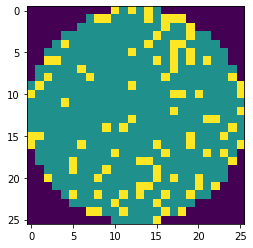

Faulty case : ['none'] 
1206


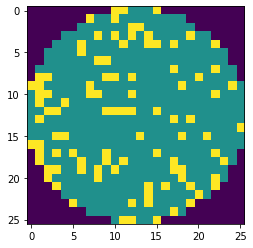

Faulty case : ['none'] 
1207


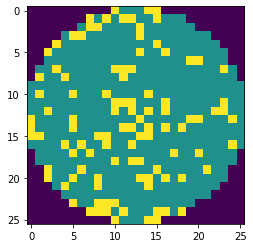

Faulty case : ['none'] 
1208


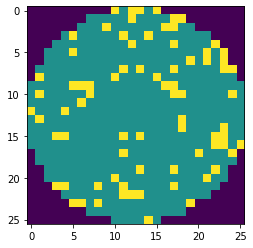

Faulty case : ['none'] 
1209


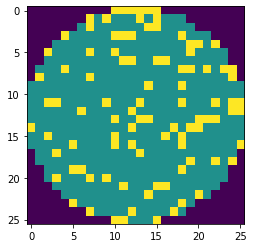

Faulty case : ['none'] 
1210


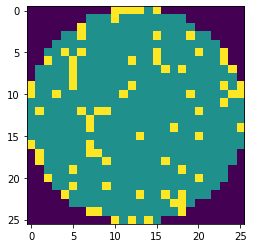

Faulty case : ['none'] 
1211


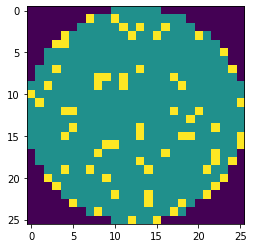

Faulty case : ['none'] 
1212


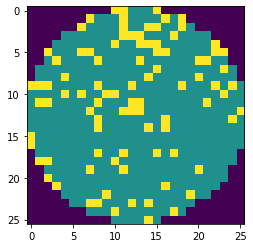

Faulty case : ['none'] 
1214


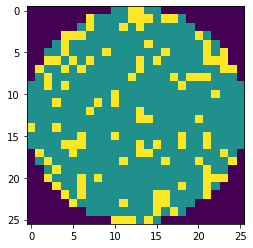

Faulty case : ['none'] 
1215


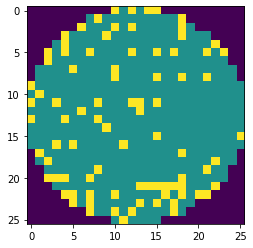

Faulty case : ['none'] 
1216


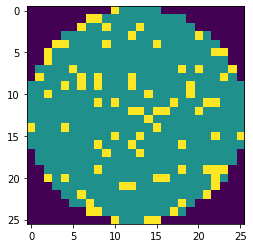

Faulty case : ['none'] 
1217


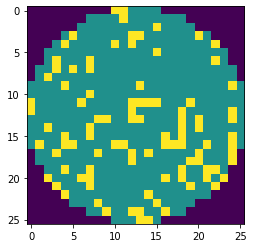

Faulty case : ['none'] 
1218


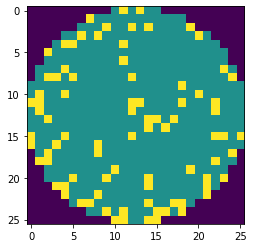

Faulty case : ['none'] 
1219


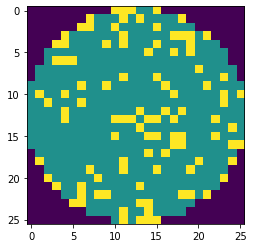

Faulty case : ['none'] 
1220


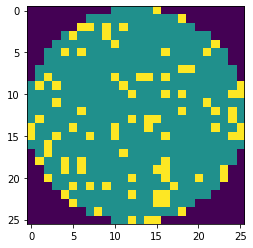

Faulty case : ['none'] 
1221


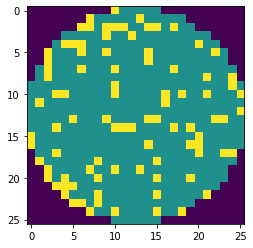

Faulty case : ['none'] 
1222


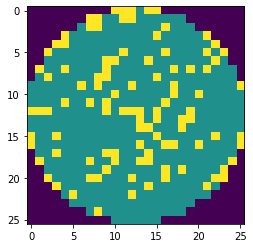

Faulty case : ['none'] 
1223


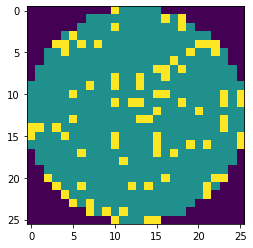

Faulty case : ['none'] 
1224


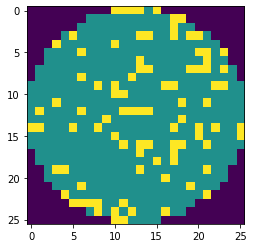

Faulty case : ['none'] 
1225


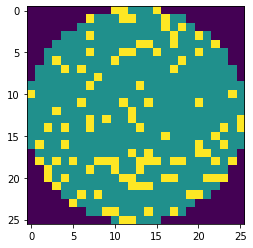

Faulty case : ['none'] 
1226


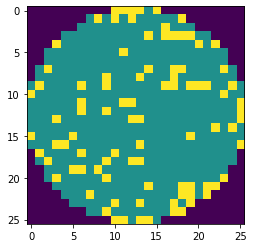

Faulty case : ['none'] 
1227


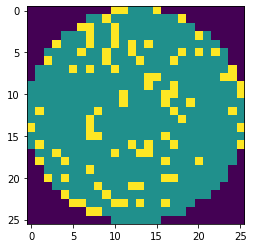

Faulty case : ['none'] 
1229


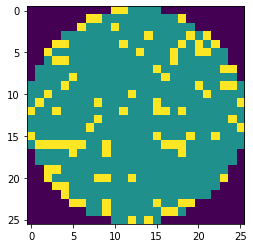

Faulty case : ['none'] 
1230


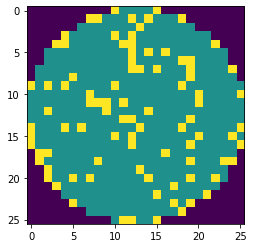

Faulty case : ['none'] 
1231


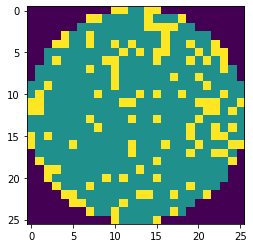

Faulty case : ['none'] 
1232


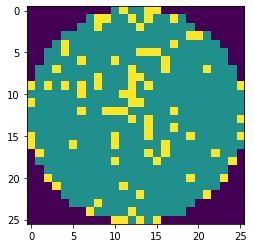

Faulty case : ['none'] 
1233


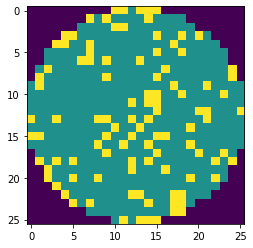

Faulty case : ['none'] 
1234


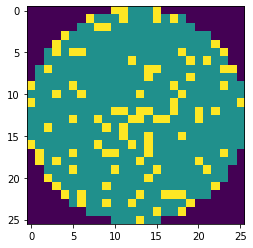

Faulty case : ['none'] 
1235


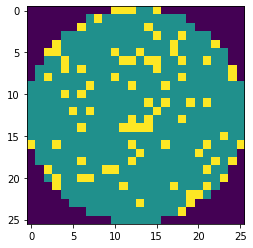

Faulty case : ['none'] 
1236


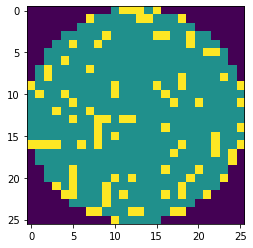

Faulty case : ['none'] 
1237


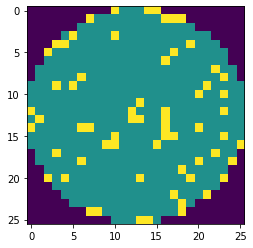

Faulty case : ['none'] 
1238


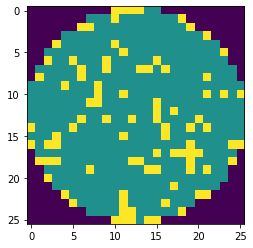

Faulty case : ['none'] 
1239


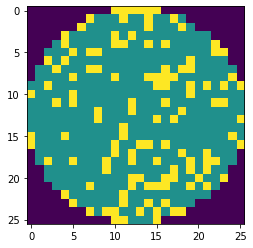

Faulty case : ['none'] 
1240


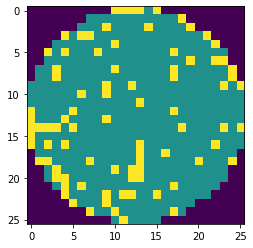

Faulty case : ['none'] 
1241


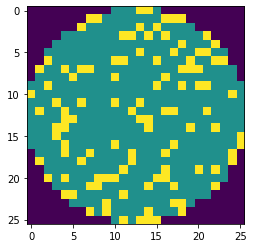

Faulty case : ['none'] 
1242


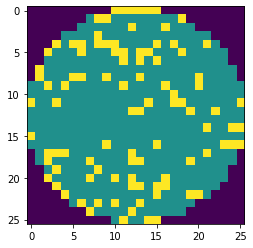

Faulty case : ['none'] 
1243


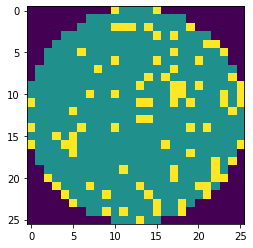

Faulty case : ['none'] 
1244


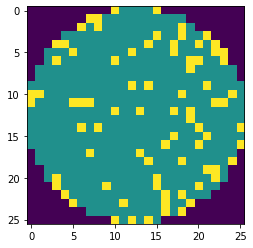

Faulty case : ['none'] 
1245


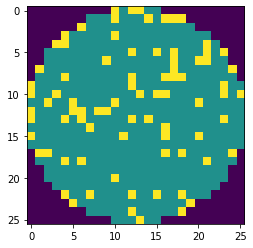

Faulty case : ['none'] 
1246


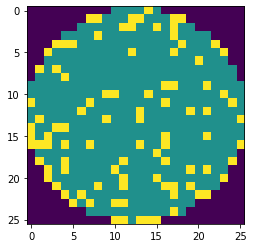

Faulty case : ['none'] 
1247


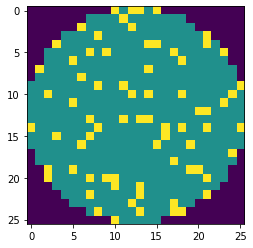

Faulty case : ['none'] 
1248


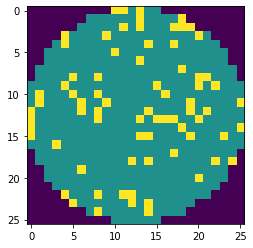

Faulty case : ['none'] 
1249


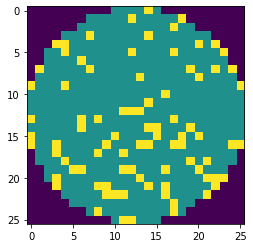

Faulty case : ['none'] 
1250


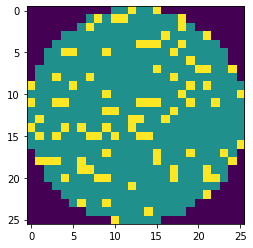

Faulty case : ['none'] 
1251


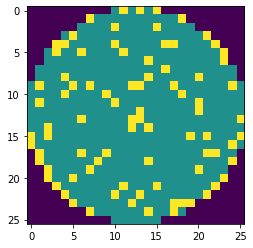

Faulty case : ['none'] 
1252


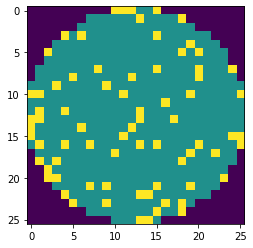

Faulty case : ['none'] 
1253


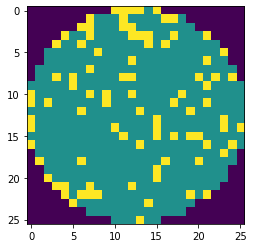

Faulty case : ['none'] 
1254


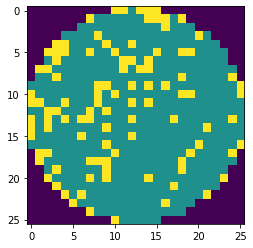

Faulty case : ['none'] 
1255


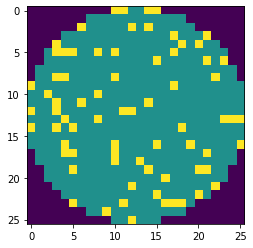

Faulty case : ['none'] 
1256


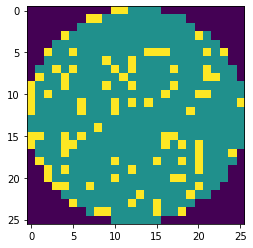

Faulty case : ['none'] 
1257


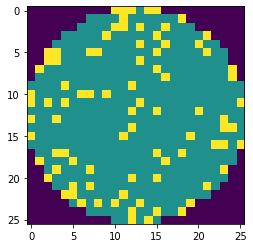

Faulty case : ['none'] 
1258


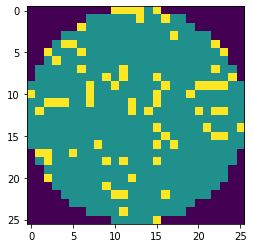

Faulty case : ['none'] 
1259


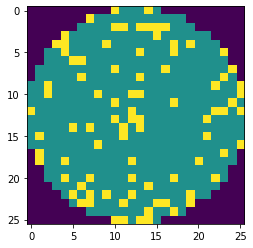

Faulty case : ['none'] 
1260


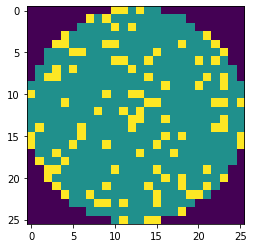

Faulty case : ['none'] 
1261


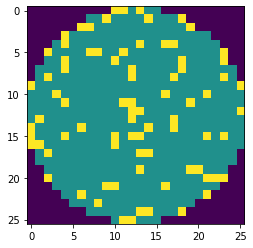

Faulty case : ['none'] 
1262


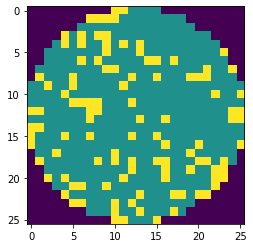

Faulty case : ['none'] 
1263


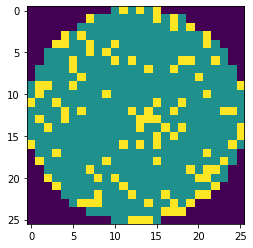

Faulty case : ['none'] 
1264


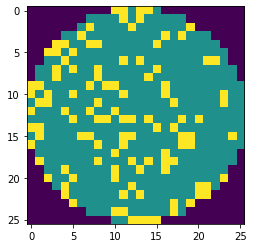

Faulty case : ['none'] 
1265


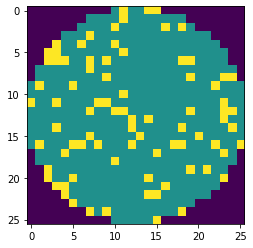

Faulty case : ['none'] 
1266


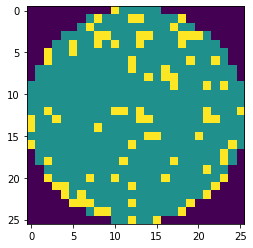

Faulty case : ['none'] 
1267


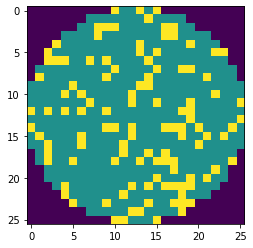

Faulty case : ['none'] 
1268


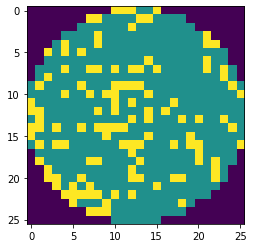

Faulty case : ['none'] 
1269


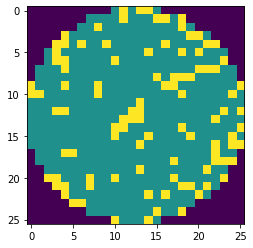

Faulty case : ['none'] 
1270


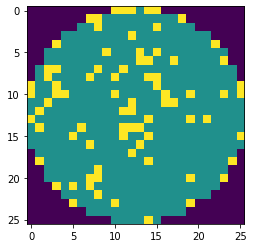

Faulty case : ['none'] 
1271


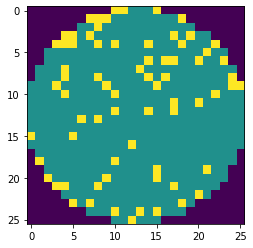

Faulty case : ['none'] 
1272


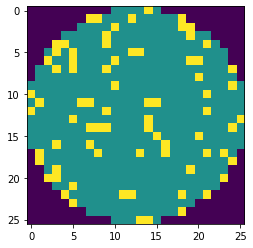

Faulty case : ['none'] 
1273


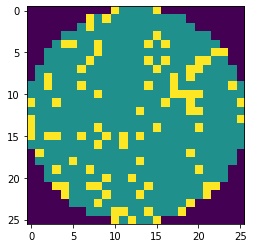

Faulty case : ['none'] 
1274


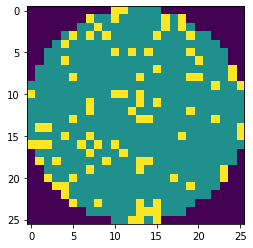

Faulty case : ['none'] 
1275


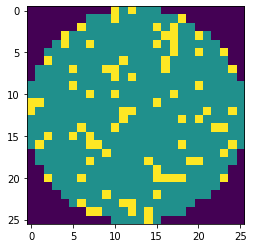

Faulty case : ['none'] 
1276


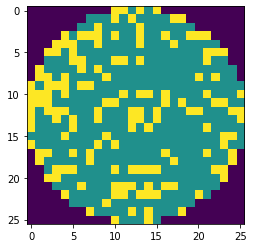

Faulty case : ['none'] 
1277


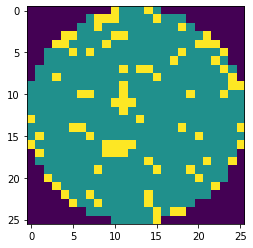

Faulty case : ['none'] 
1278


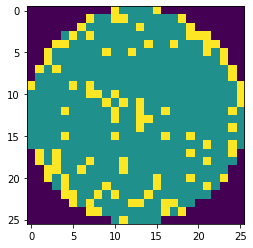

Faulty case : ['none'] 
1279


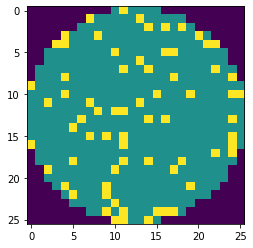

Faulty case : ['none'] 
1280


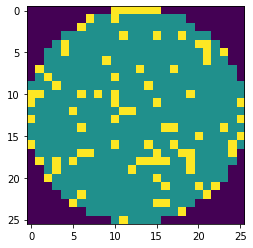

Faulty case : ['none'] 
1281


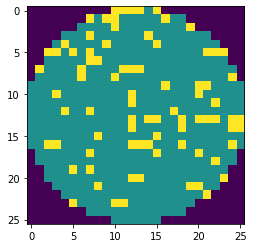

Faulty case : ['none'] 
1282


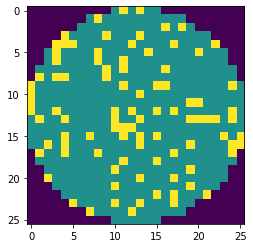

Faulty case : ['none'] 
1284


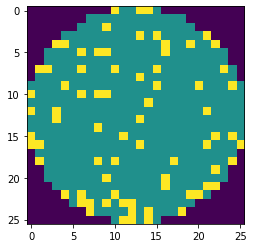

Faulty case : ['none'] 
1285


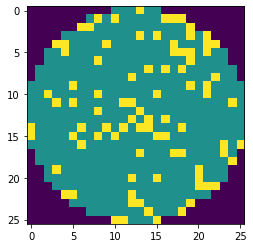

Faulty case : ['none'] 
1286


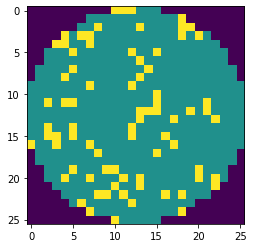

Faulty case : ['none'] 
1287


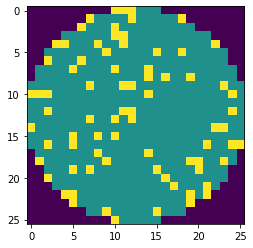

Faulty case : ['none'] 
1288


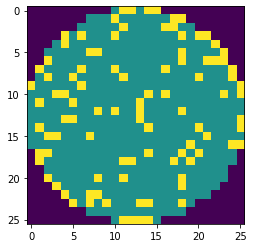

Faulty case : ['none'] 
1289


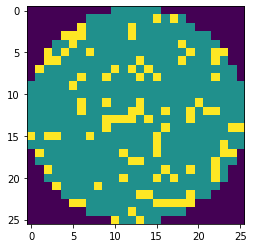

Faulty case : ['none'] 
1290


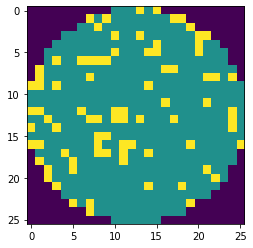

Faulty case : ['none'] 
1291


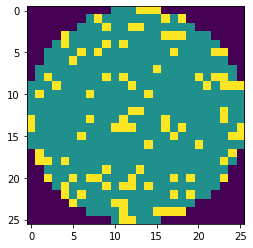

Faulty case : ['none'] 
1292


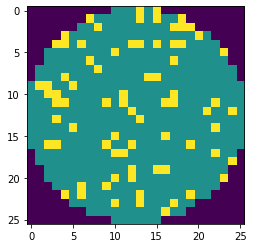

Faulty case : ['none'] 
1293


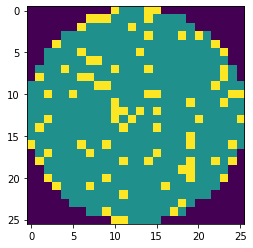

Faulty case : ['none'] 
1294


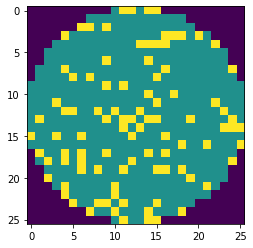

Faulty case : ['none'] 
1295


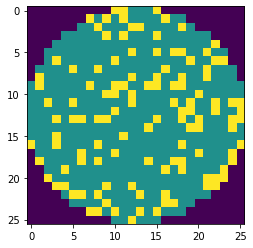

Faulty case : ['none'] 
1296


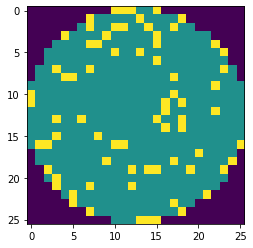

Faulty case : ['none'] 
1297


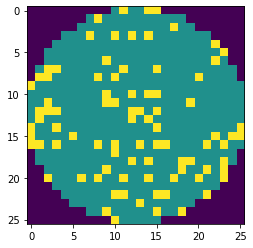

Faulty case : ['none'] 
1298


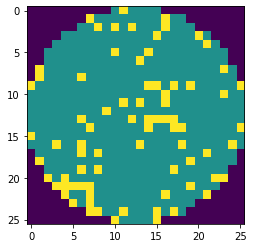

Faulty case : ['none'] 
1299


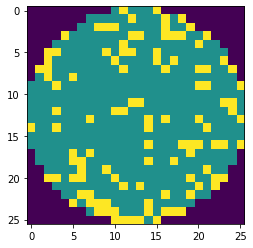

Faulty case : ['none'] 
1300


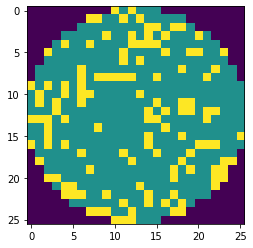

Faulty case : ['none'] 
1301


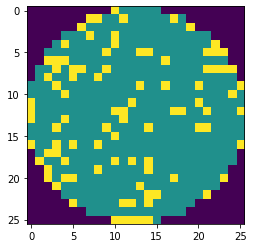

Faulty case : ['none'] 
1302


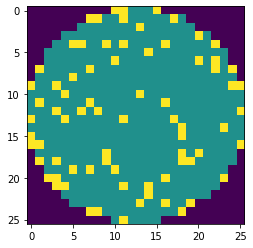

Faulty case : ['none'] 
1303


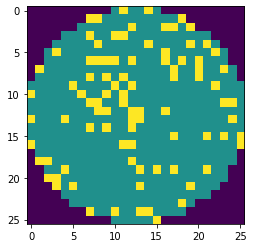

Faulty case : ['none'] 
1304


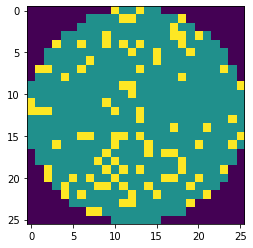

Faulty case : ['none'] 
1305


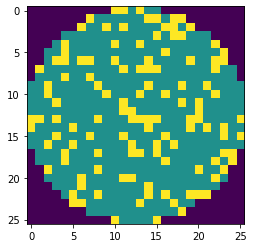

Faulty case : ['none'] 
1306


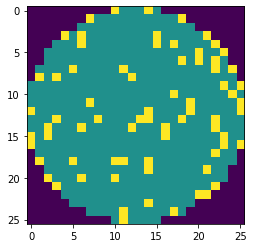

Faulty case : ['none'] 
1307


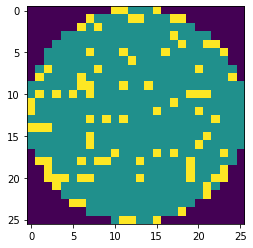

Faulty case : ['none'] 
1308


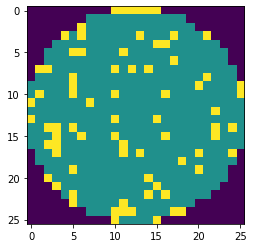

Faulty case : ['none'] 
1309


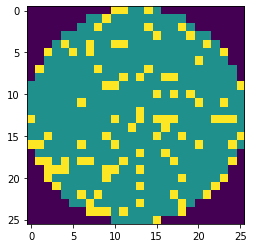

Faulty case : ['none'] 
1310


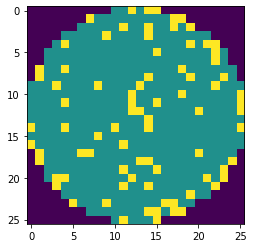

Faulty case : ['none'] 
1311


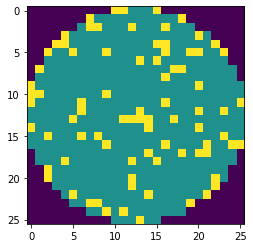

Faulty case : ['none'] 
1312


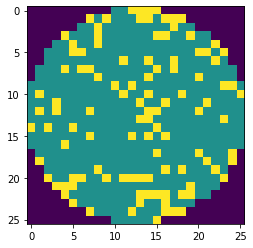

Faulty case : ['none'] 
1313


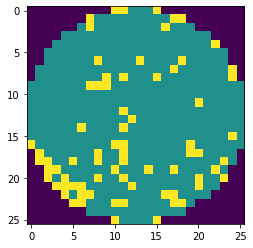

Faulty case : ['none'] 
1314


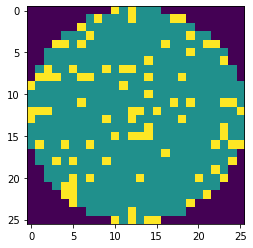

Faulty case : ['none'] 
1315


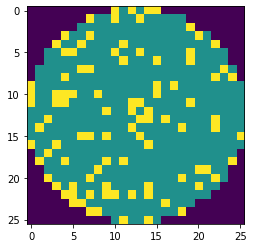

Faulty case : ['none'] 
1316


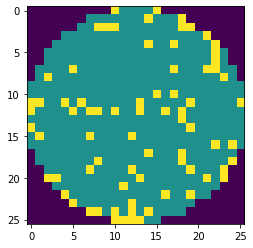

Faulty case : ['none'] 
1317


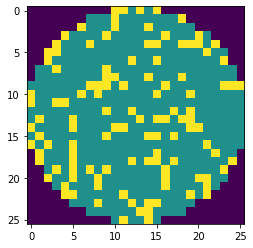

Faulty case : ['none'] 
1318


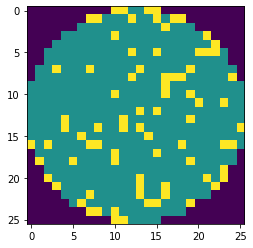

Faulty case : ['none'] 
1319


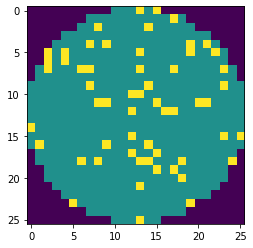

Faulty case : ['none'] 
1320


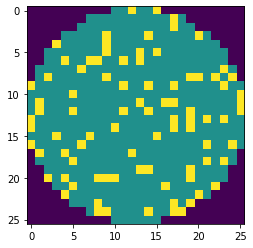

Faulty case : ['none'] 
1321


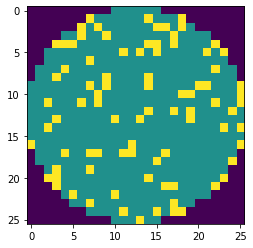

Faulty case : ['none'] 
1322


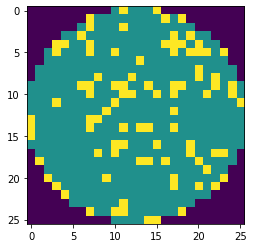

Faulty case : ['none'] 
1323


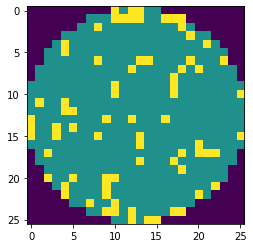

Faulty case : ['none'] 
1324


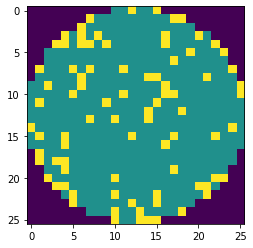

Faulty case : ['none'] 
1325


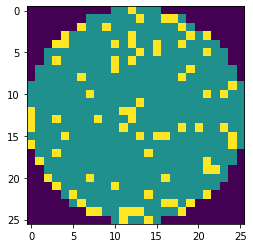

Faulty case : ['none'] 
1326


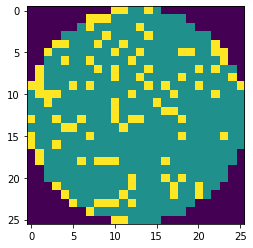

Faulty case : ['none'] 
1327


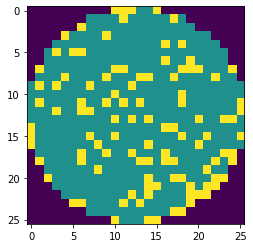

Faulty case : ['none'] 
1328


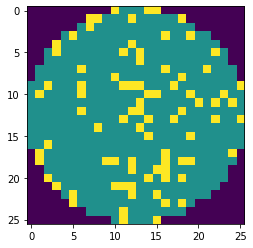

Faulty case : ['none'] 
1329


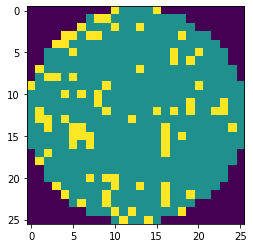

Faulty case : ['none'] 
1330


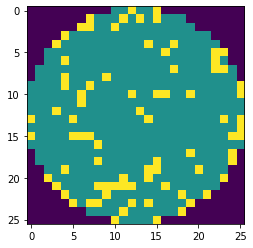

Faulty case : ['none'] 
1331


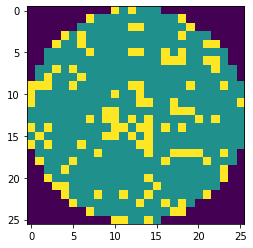

Faulty case : ['none'] 
1332


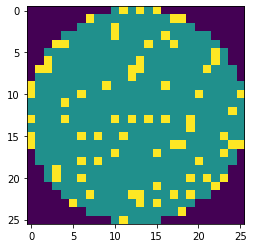

Faulty case : ['none'] 
1333


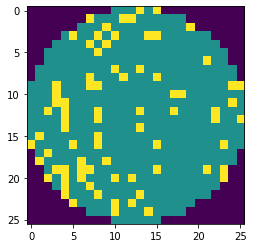

Faulty case : ['none'] 
1334


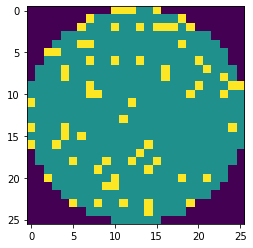

Faulty case : ['none'] 
1335


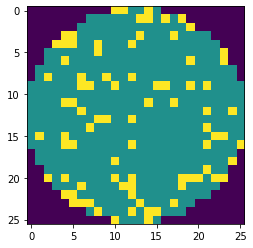

Faulty case : ['none'] 
1336


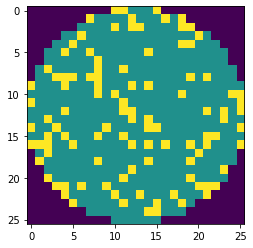

Faulty case : ['none'] 
1337


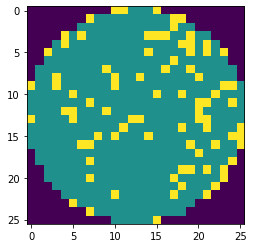

Faulty case : ['none'] 
1339


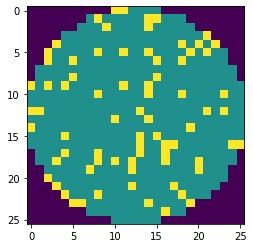

Faulty case : ['none'] 
1340


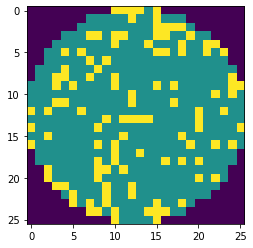

Faulty case : ['none'] 
1341


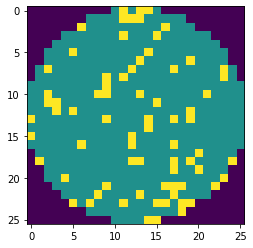

Faulty case : ['none'] 
1342


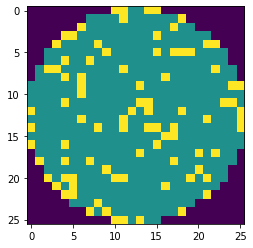

Faulty case : ['none'] 
1343


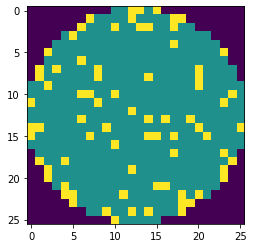

Faulty case : ['none'] 
1344


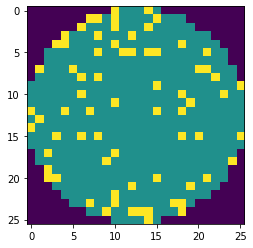

Faulty case : ['none'] 
1345


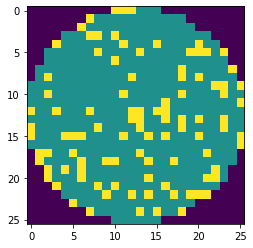

Faulty case : ['none'] 
1346


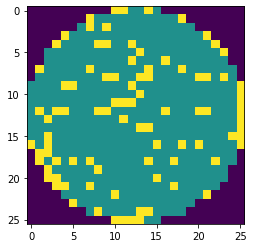

Faulty case : ['none'] 
1347


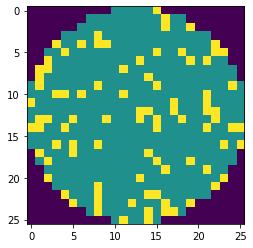

Faulty case : ['none'] 
1348


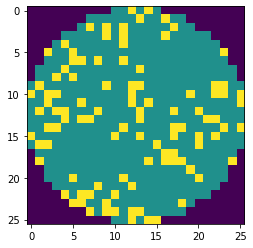

Faulty case : ['none'] 
1349


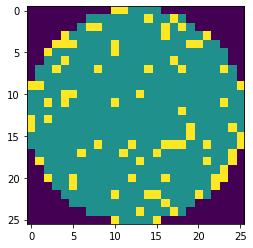

Faulty case : ['none'] 
1350


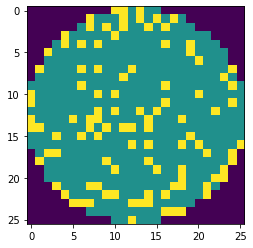

Faulty case : ['none'] 
1351


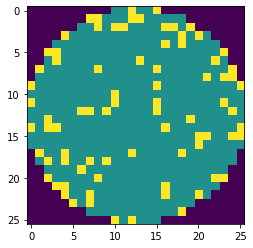

Faulty case : ['none'] 
1352


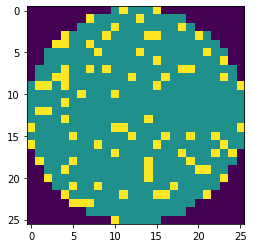

Faulty case : ['none'] 
1353


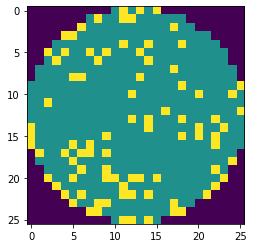

Faulty case : ['none'] 
1354


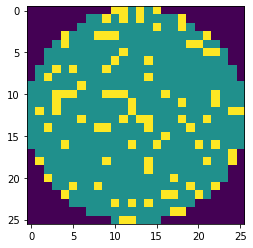

Faulty case : ['none'] 
1355


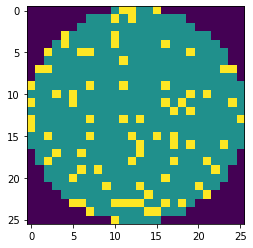

Faulty case : ['none'] 
1356


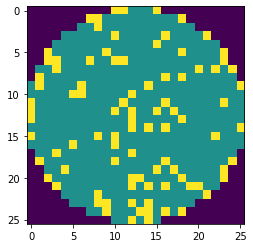

Faulty case : ['none'] 
1357


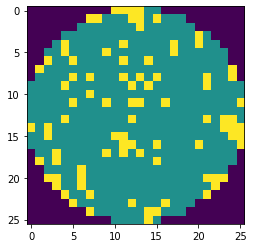

Faulty case : ['none'] 
1358


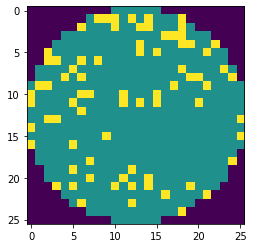

Faulty case : ['none'] 
1359


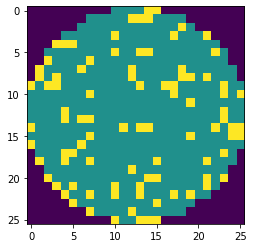

Faulty case : ['none'] 
1360


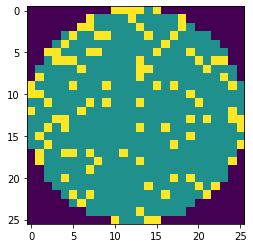

Faulty case : ['none'] 
1361


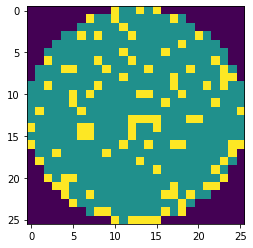

Faulty case : ['none'] 
1362


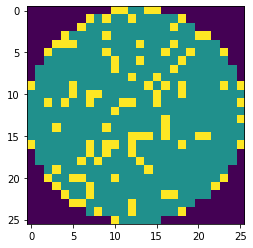

Faulty case : ['none'] 
1363


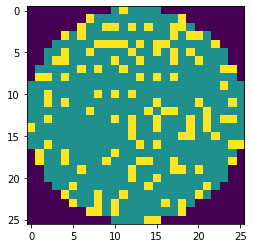

Faulty case : ['none'] 
1364


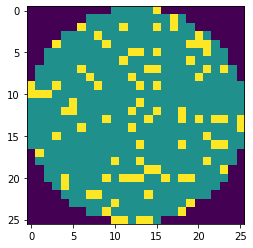

Faulty case : ['none'] 
1365


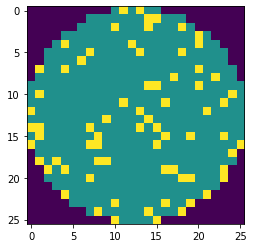

Faulty case : ['none'] 
1366


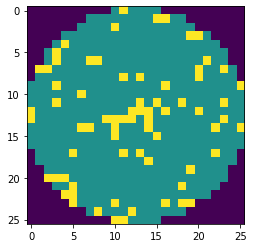

Faulty case : ['none'] 
1367


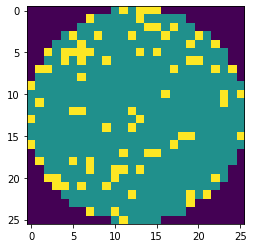

Faulty case : ['none'] 
1368


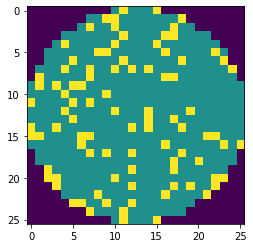

Faulty case : ['none'] 
1369


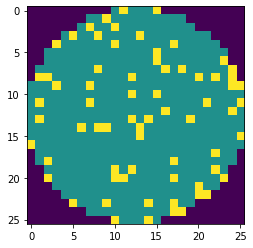

Faulty case : ['none'] 
1370


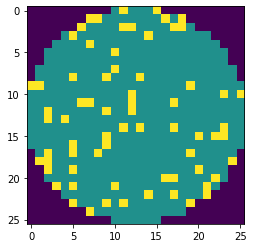

Faulty case : ['none'] 
1371


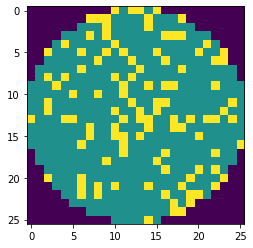

Faulty case : ['none'] 
1372


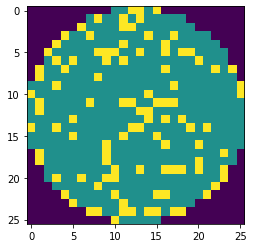

Faulty case : ['none'] 
1373


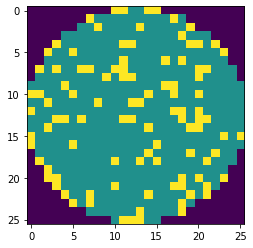

Faulty case : ['none'] 
1374


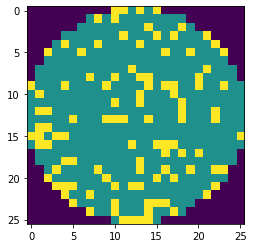

Faulty case : ['none'] 
1375


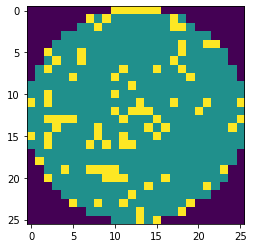

Faulty case : ['none'] 
1376


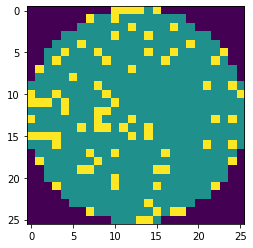

Faulty case : ['none'] 
1377


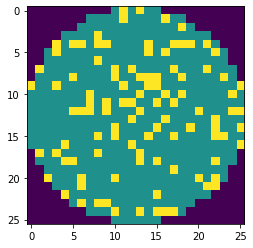

Faulty case : ['none'] 
1378


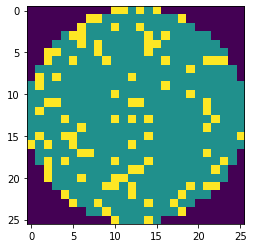

Faulty case : ['none'] 
1380


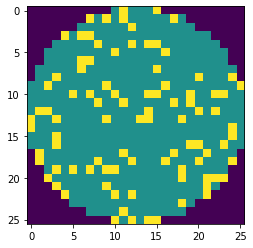

Faulty case : ['none'] 
1381


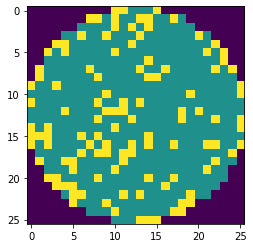

Faulty case : ['none'] 
1382


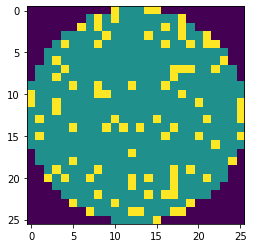

Faulty case : ['none'] 
1383


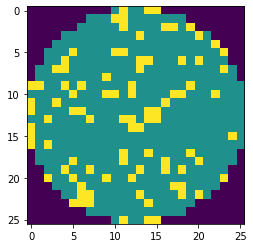

Faulty case : ['none'] 
1384


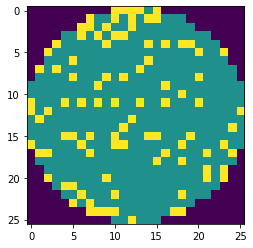

Faulty case : ['none'] 
1385


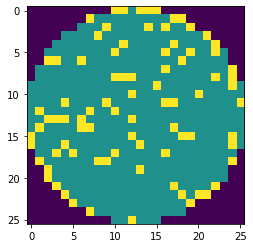

Faulty case : ['none'] 
1386


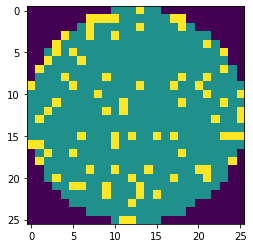

Faulty case : ['none'] 
1387


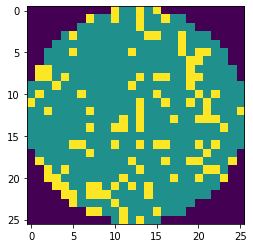

Faulty case : ['none'] 
1388


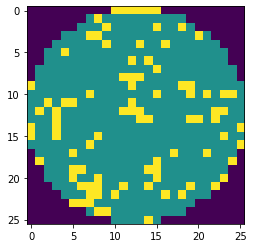

Faulty case : ['none'] 
1389


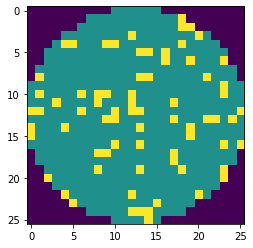

Faulty case : ['none'] 
1390


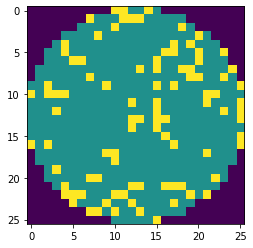

Faulty case : ['none'] 
1391


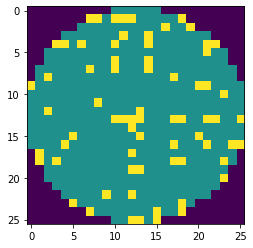

Faulty case : ['none'] 
1392


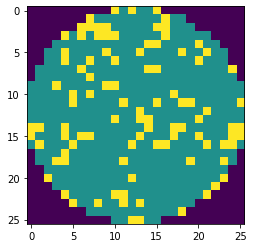

Faulty case : ['none'] 
1393


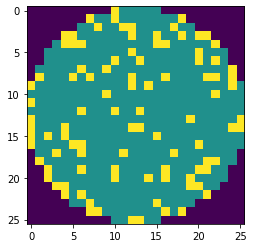

Faulty case : ['none'] 
1394


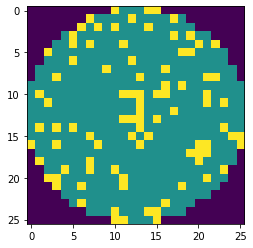

Faulty case : ['none'] 
1395


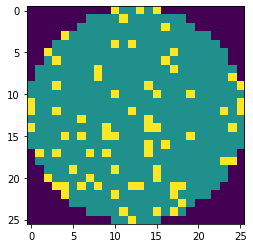

Faulty case : ['none'] 
1396


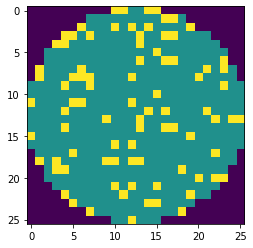

Faulty case : ['none'] 
1397


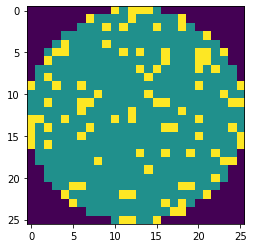

Faulty case : ['none'] 
1398


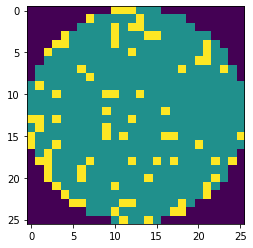

Faulty case : ['none'] 
1399


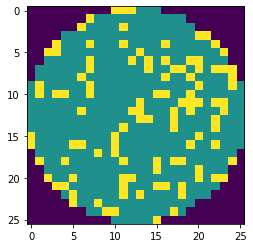

Faulty case : ['none'] 
1400


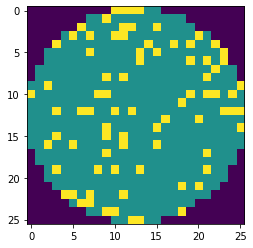

Faulty case : ['none'] 
1401


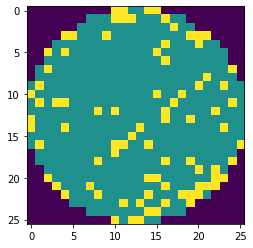

Faulty case : ['none'] 
1402


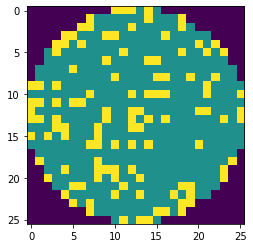

Faulty case : ['none'] 
1403


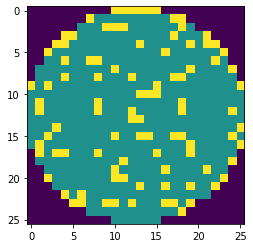

Faulty case : ['none'] 
1404


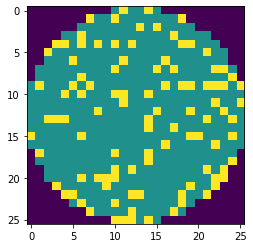

Faulty case : ['none'] 
1405


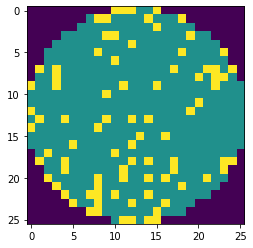

Faulty case : ['none'] 
1406


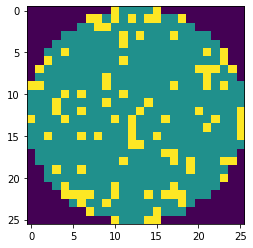

Faulty case : ['none'] 
1407


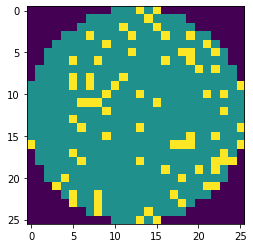

Faulty case : ['none'] 
1408


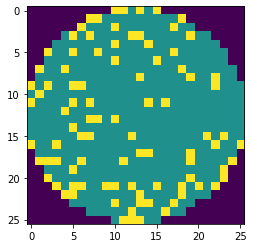

Faulty case : ['none'] 
1409


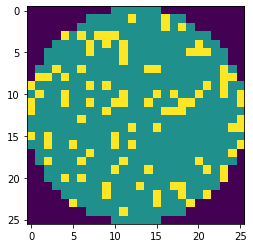

Faulty case : ['none'] 
1410


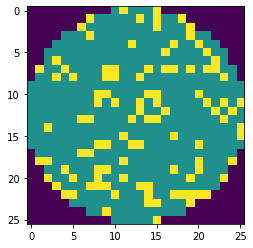

Faulty case : ['none'] 
1411


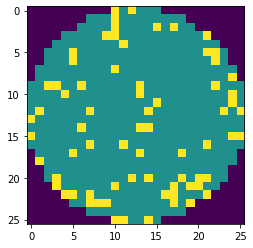

Faulty case : ['none'] 
1412


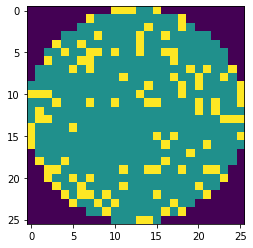

Faulty case : ['none'] 
1413


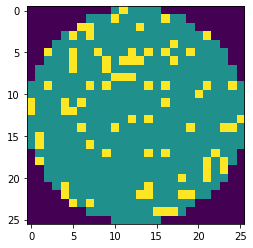

Faulty case : ['none'] 
1414


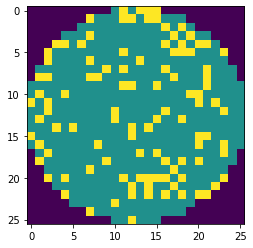

Faulty case : ['none'] 
1415


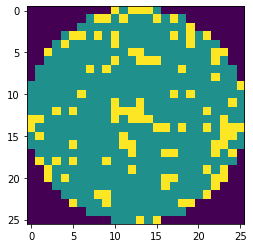

Faulty case : ['none'] 
1416


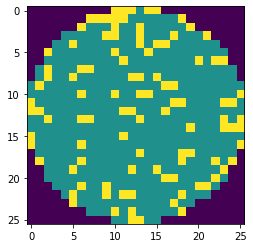

Faulty case : ['none'] 
1417


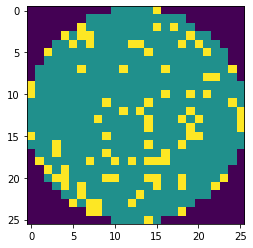

Faulty case : ['none'] 
1418


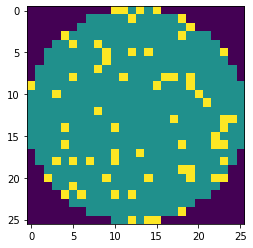

Faulty case : ['none'] 
1419


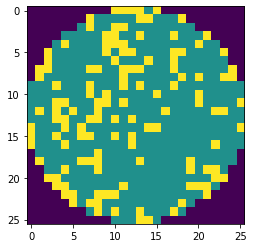

Faulty case : ['none'] 
1420


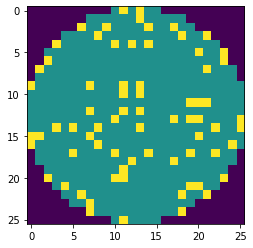

Faulty case : ['none'] 
1421


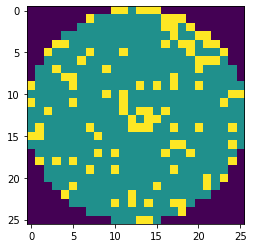

Faulty case : ['none'] 
1422


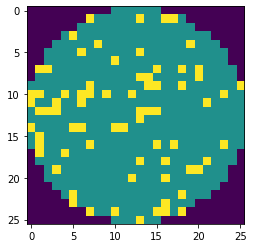

Faulty case : ['none'] 
1423


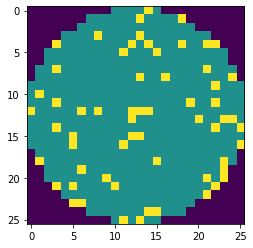

Faulty case : ['none'] 
1424


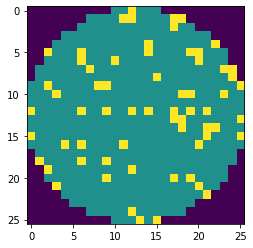

Faulty case : ['none'] 
1425


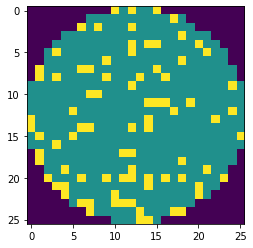

Faulty case : ['none'] 
1426


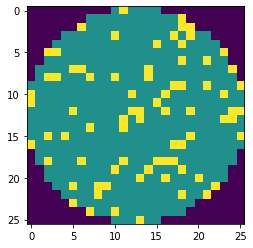

Faulty case : ['none'] 
1427


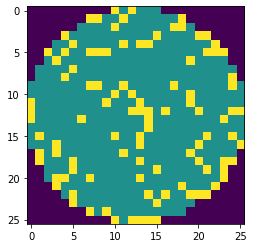

Faulty case : ['none'] 
1428


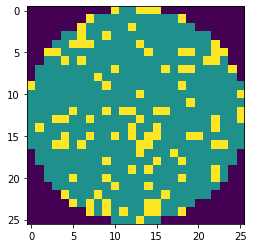

Faulty case : ['none'] 
1429


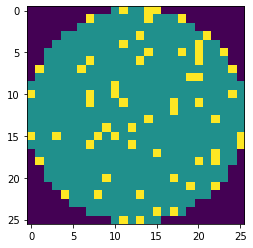

Faulty case : ['none'] 
1430


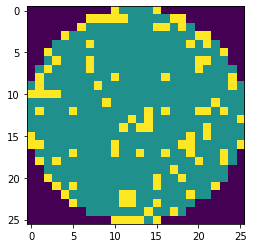

Faulty case : ['none'] 
1431


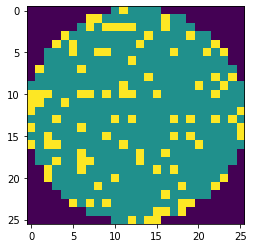

Faulty case : ['none'] 
1432


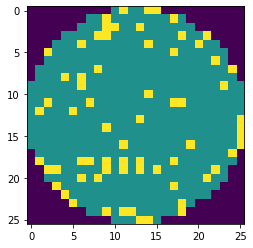

Faulty case : ['none'] 
1433


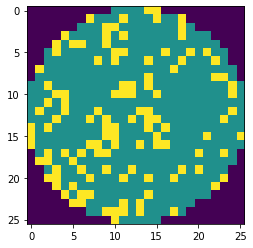

Faulty case : ['none'] 
1434


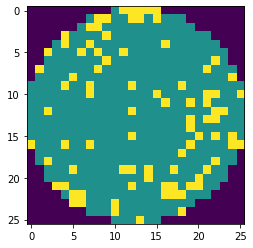

Faulty case : ['none'] 
1435


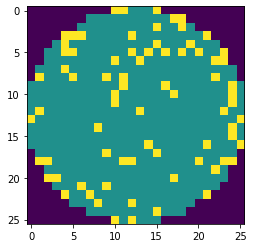

Faulty case : ['none'] 
1436


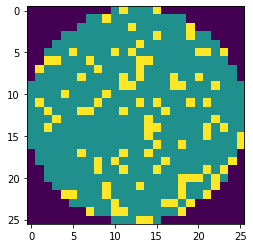

Faulty case : ['none'] 
1437


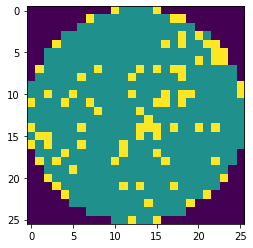

Faulty case : ['none'] 
1438


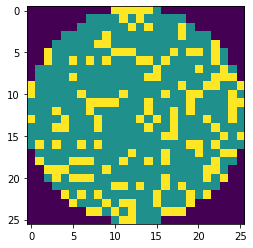

Faulty case : ['none'] 
1439


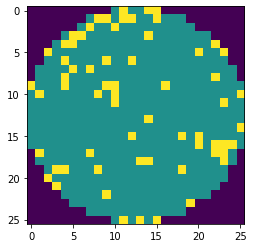

Faulty case : ['none'] 
1440


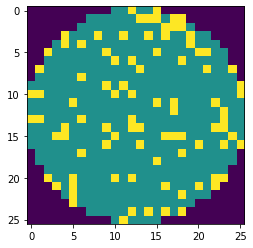

Faulty case : ['none'] 
1441


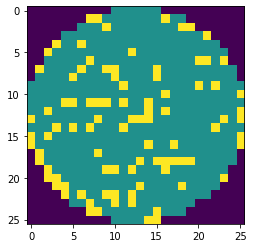

Faulty case : ['none'] 
1442


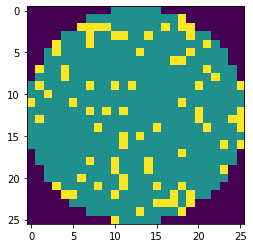

Faulty case : ['none'] 
1443


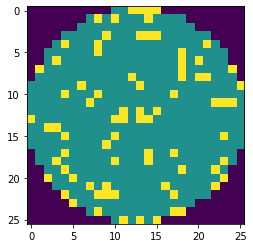

Faulty case : ['none'] 
1444


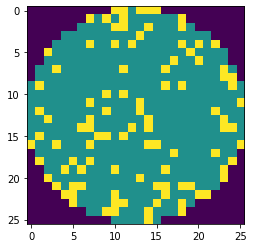

Faulty case : ['none'] 
1445


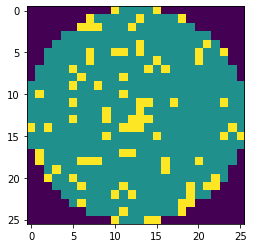

Faulty case : ['none'] 
1446


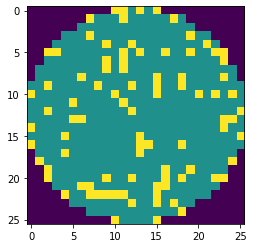

Faulty case : ['none'] 
1447


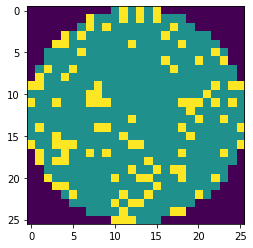

Faulty case : ['none'] 
1448


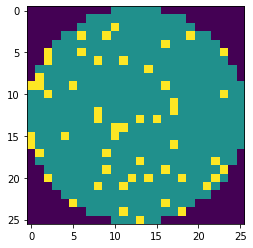

Faulty case : ['none'] 
1449


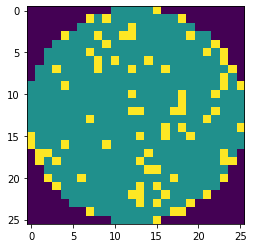

Faulty case : ['none'] 
1450


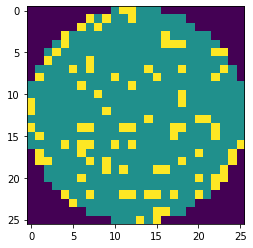

Faulty case : ['none'] 
1451


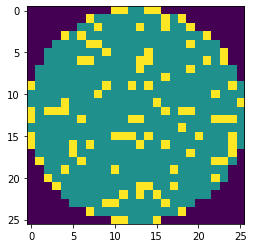

Faulty case : ['none'] 
1452


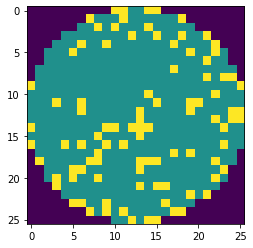

Faulty case : ['none'] 
1453


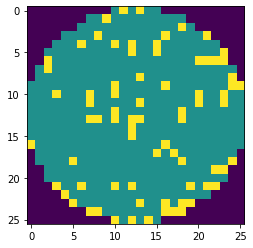

Faulty case : ['none'] 
1454


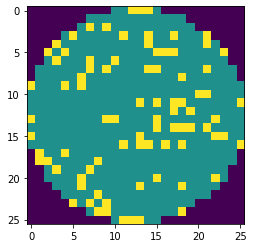

Faulty case : ['none'] 
1455


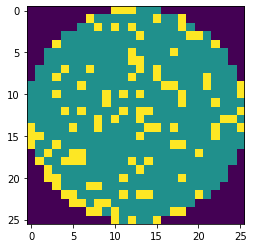

Faulty case : ['none'] 
1456


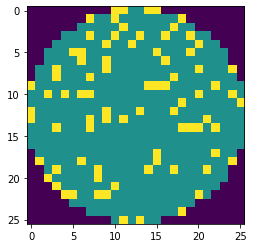

Faulty case : ['none'] 
1457


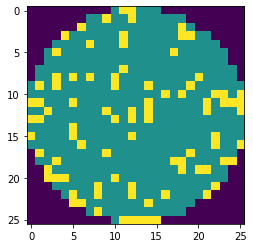

Faulty case : ['none'] 
1458


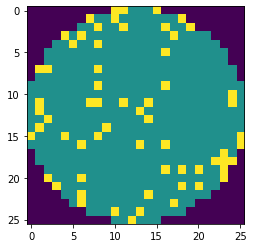

Faulty case : ['none'] 
1459


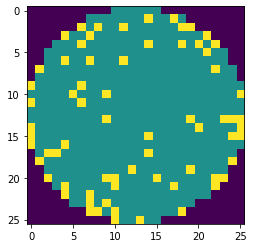

Faulty case : ['none'] 
1460


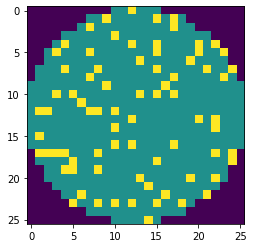

Faulty case : ['none'] 
1461


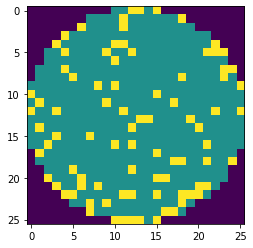

Faulty case : ['none'] 
1462


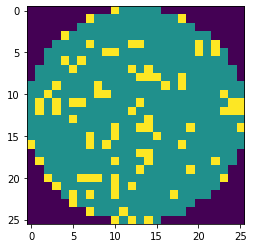

Faulty case : ['none'] 
1463


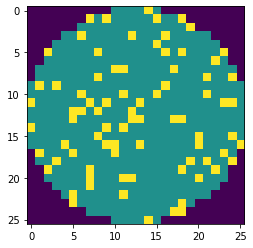

Faulty case : ['none'] 
1464


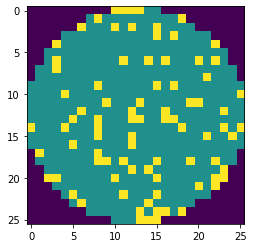

Faulty case : ['none'] 
1465


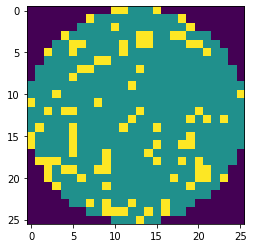

Faulty case : ['none'] 
1466


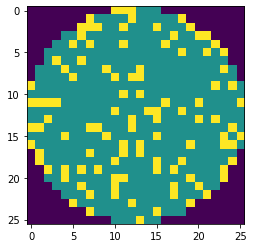

Faulty case : ['none'] 
1467


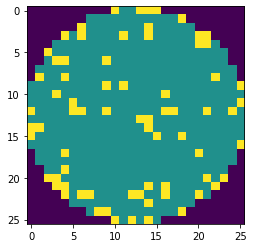

Faulty case : ['none'] 
1468


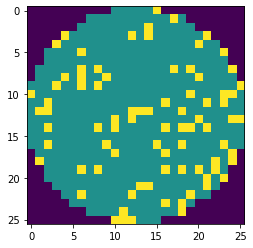

Faulty case : ['none'] 
1469


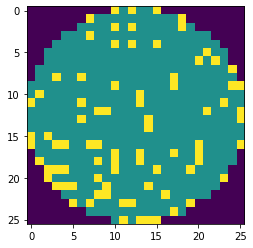

Faulty case : ['none'] 
1470


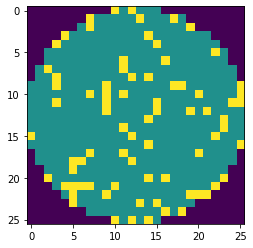

Faulty case : ['none'] 
1471


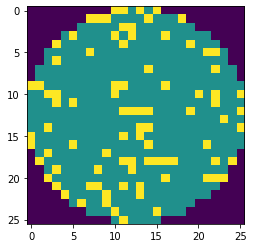

Faulty case : ['none'] 
1472


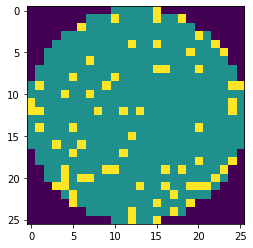

Faulty case : ['none'] 
1473


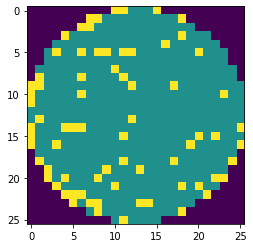

Faulty case : ['none'] 
1474


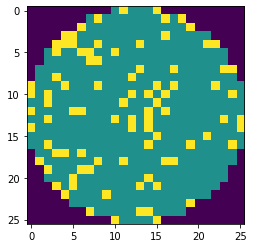

Faulty case : ['none'] 
1475


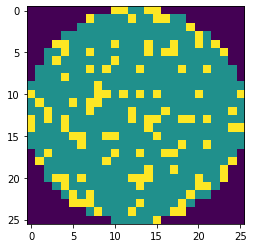

Faulty case : ['none'] 
1476


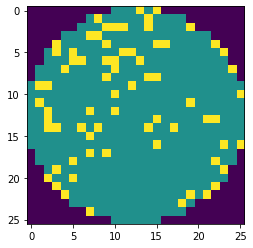

Faulty case : ['none'] 
1477


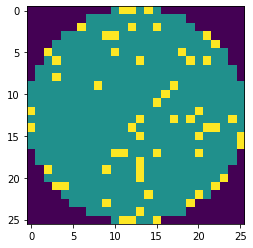

Faulty case : ['none'] 
1478


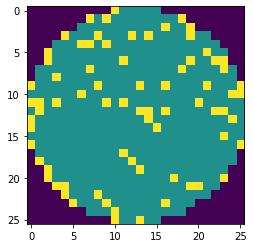

Faulty case : ['none'] 
1479


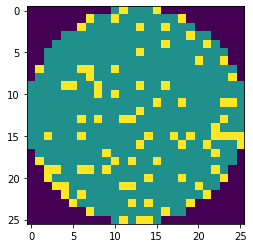

Faulty case : ['none'] 
1480


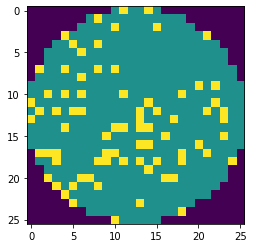

Faulty case : ['none'] 
1481


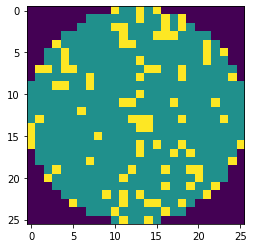

Faulty case : ['none'] 
1482


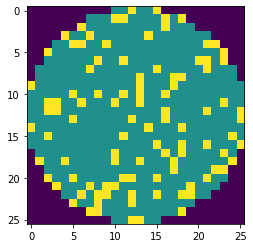

Faulty case : ['none'] 
1483


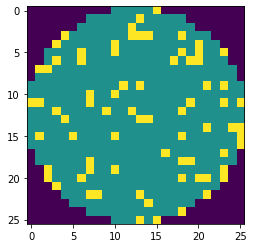

Faulty case : ['none'] 
1484


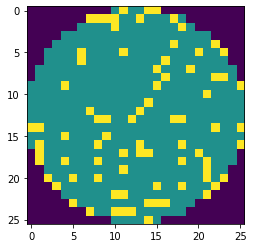

Faulty case : ['none'] 
1485


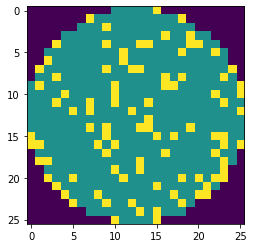

Faulty case : ['none'] 
1486


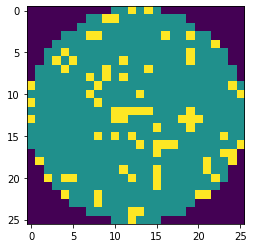

Faulty case : ['none'] 
1487


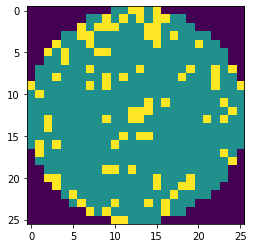

Faulty case : ['none'] 
1488


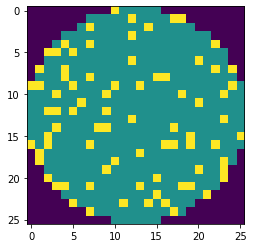

Faulty case : ['none'] 
1489


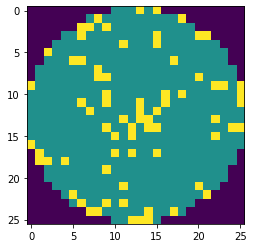

Faulty case : ['none'] 
1491


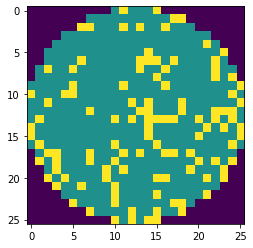

Faulty case : ['none'] 
1492


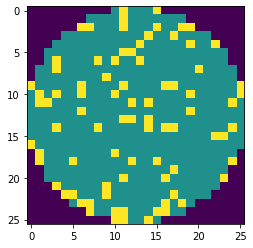

Faulty case : ['none'] 
1493


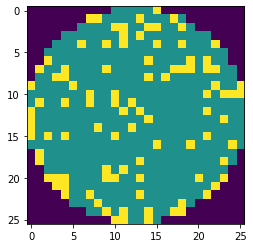

Faulty case : ['none'] 
1494


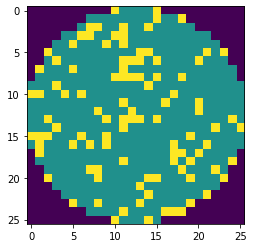

Faulty case : ['none'] 
1495


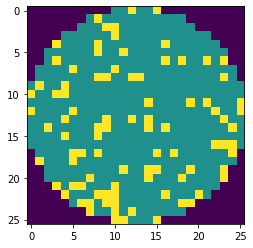

Faulty case : ['none'] 
1496


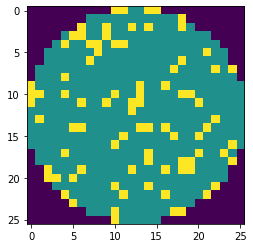

Faulty case : ['none'] 
1497


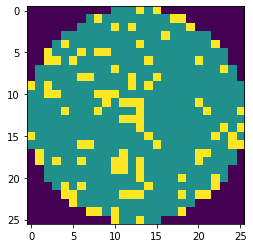

Faulty case : ['none'] 
1498


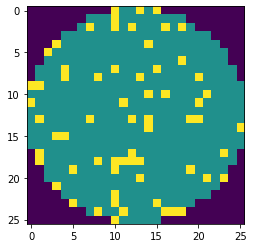

Faulty case : ['none'] 
1499


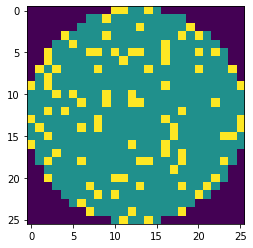

Faulty case : ['none'] 
1500


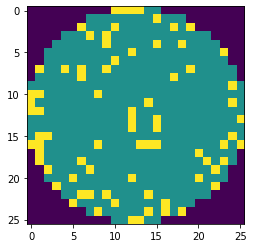

Faulty case : ['none'] 
1501


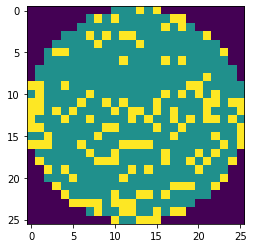

Faulty case : ['none'] 
1502


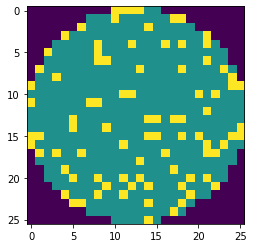

Faulty case : ['none'] 
1503


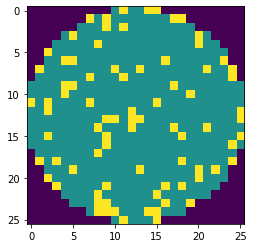

Faulty case : ['none'] 
1504


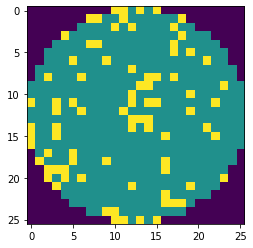

Faulty case : ['none'] 
1505


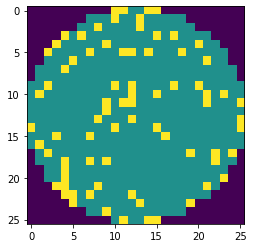

Faulty case : ['none'] 
1506


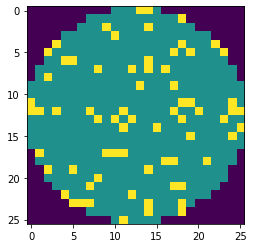

Faulty case : ['none'] 
1507


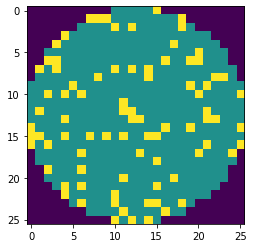

Faulty case : ['none'] 
1508


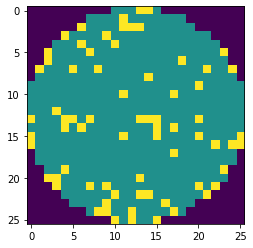

Faulty case : ['none'] 
1509


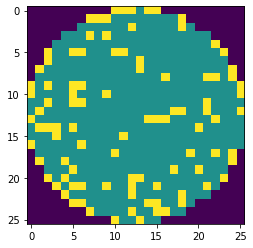

Faulty case : ['none'] 
1510


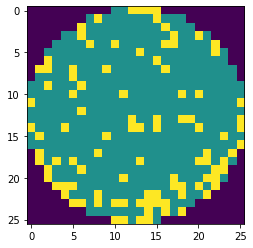

Faulty case : ['none'] 
1511


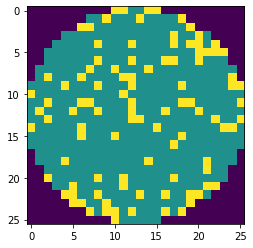

Faulty case : ['none'] 
1512


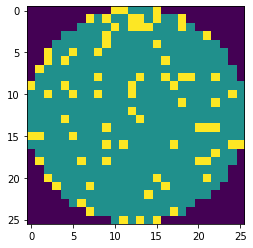

Faulty case : ['none'] 
1513


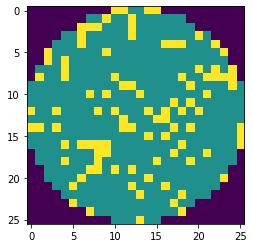

Faulty case : ['none'] 
1514


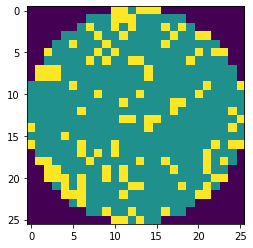

Faulty case : ['none'] 
1515


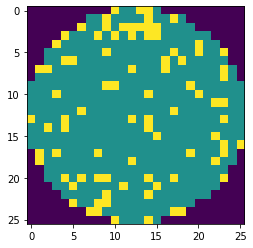

Faulty case : ['none'] 
1516


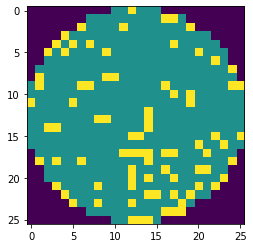

Faulty case : ['none'] 
1517


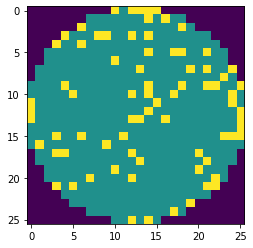

Faulty case : ['none'] 
1518


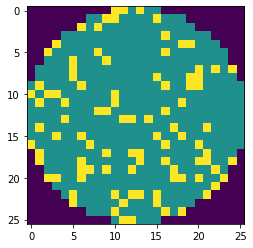

Faulty case : ['none'] 
1519


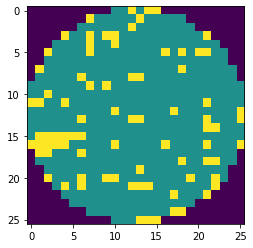

Faulty case : ['none'] 
1520


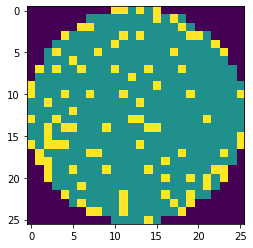

Faulty case : ['none'] 
1521


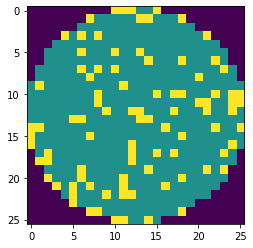

Faulty case : ['none'] 
1522


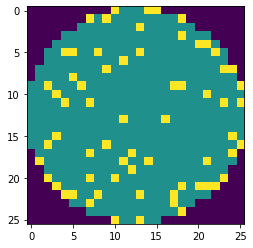

Faulty case : ['none'] 
1523


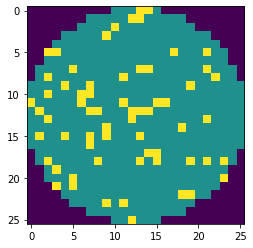

Faulty case : ['none'] 
1524


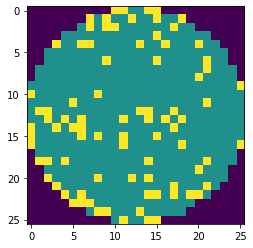

Faulty case : ['none'] 
1525


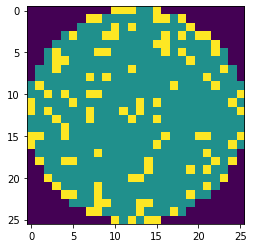

Faulty case : ['none'] 
1526


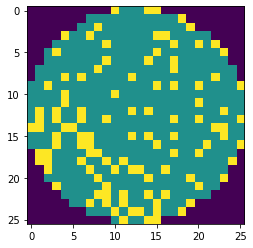

Faulty case : ['none'] 
1527


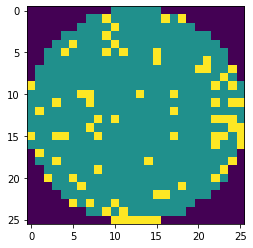

Faulty case : ['none'] 
1528


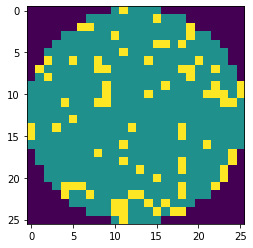

Faulty case : ['none'] 
1529


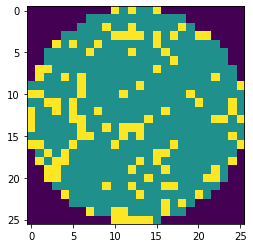

Faulty case : ['none'] 
1530


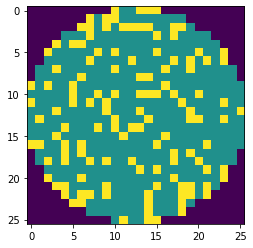

Faulty case : ['none'] 
1531


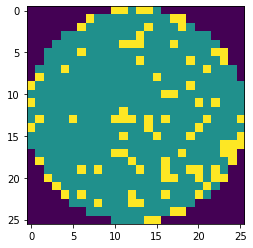

Faulty case : ['none'] 
1532


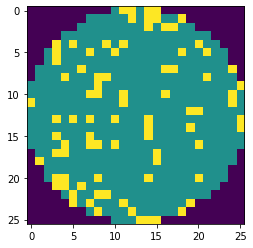

Faulty case : ['none'] 
1533


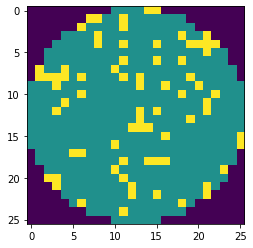

Faulty case : ['none'] 
1534


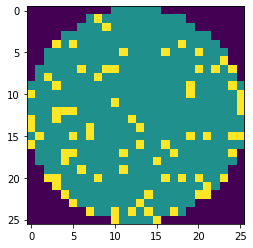

Faulty case : ['none'] 
1535


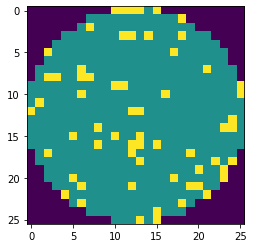

Faulty case : ['none'] 
1537


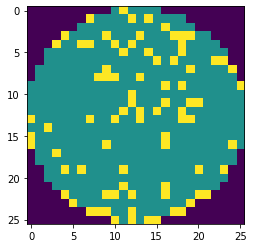

Faulty case : ['none'] 
1538


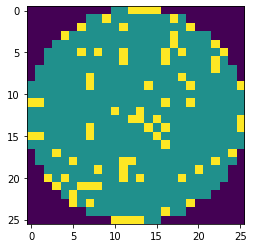

Faulty case : ['none'] 
1539


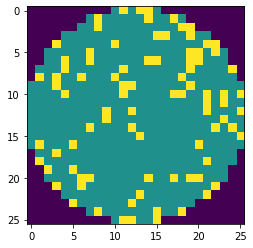

Faulty case : ['none'] 
1540


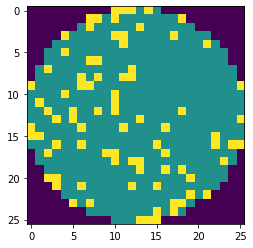

Faulty case : ['none'] 
1541


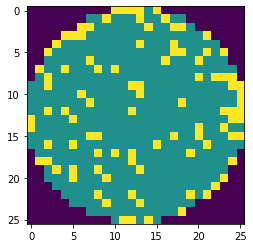

Faulty case : ['none'] 
1542


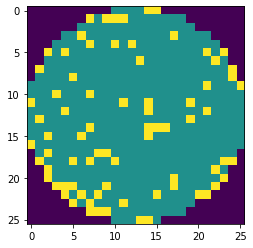

Faulty case : ['none'] 
1543


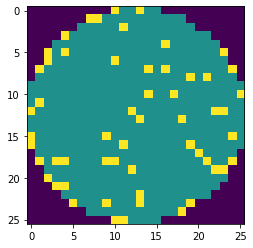

Faulty case : ['none'] 
1544


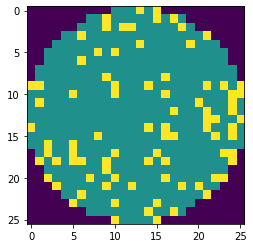

Faulty case : ['none'] 
1545


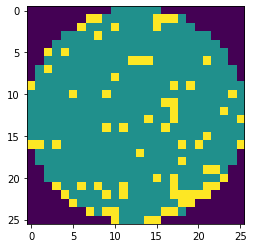

Faulty case : ['none'] 
1546


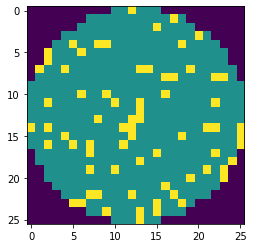

Faulty case : ['none'] 
1547


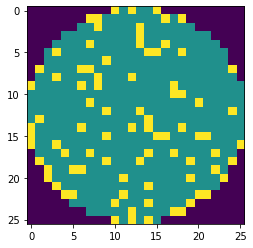

Faulty case : ['none'] 
1548


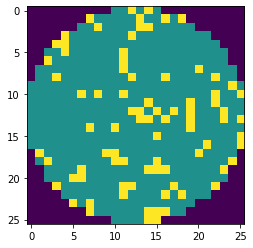

Faulty case : ['none'] 
1549


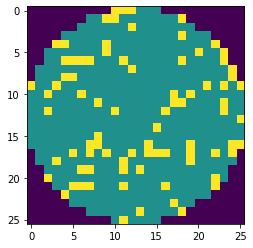

Faulty case : ['none'] 
1550


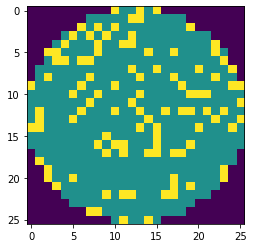

Faulty case : ['none'] 
1551


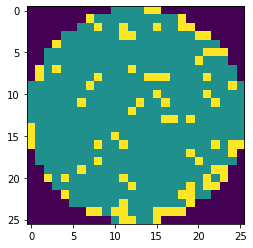

In [ ]:
'''
# plot 1st data
index = np.where(y == 'none')
#print(index[0])

for i in index[0]:
    print(i)
    plt.imshow(x[i])
    plt.show()

    # check faulty case
    print('Faulty case : {} '.format(y[i]))
'''

- 最初のデータを可視化してみる．
- その前に，26x26のデータでおかしなものを表示

In [13]:
for i in range(len(x)):
    error = np.where((x[0] != x[i]) & ((x[0] == 0) | (x[i] == 0)))
    if len(error[0]) > 0:
        print(str(i) + " is error")
        #print(error)

6267 is error
6268 is error
6269 is error
6270 is error
6271 is error
6272 is error
6273 is error
6274 is error
6275 is error
6276 is error
6277 is error
6278 is error
6279 is error
6280 is error
6281 is error
6282 is error


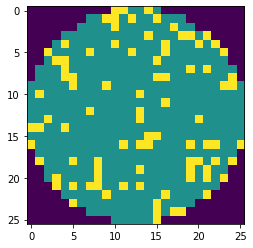

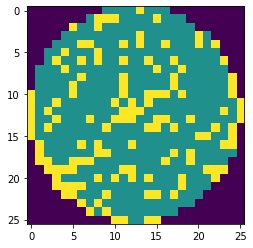

Faulty case : ['Edge-Loc'] 


In [14]:
# plot 1st data
plt.imshow(x[0])
plt.show()
plt.imshow(x[6272])
plt.show()

print('Faulty case : {} '.format(y[6272]))

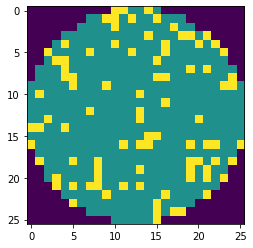

Faulty case : ['none'] 


In [15]:
# plot 1st data
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

- おかしなウエハは除去する

In [16]:
error_list = []
for i in range(len(x)):
    error = np.where((x[0] != x[i]) & ((x[0] == 0) | (x[i] == 0)))
    if len(error[0]) > 0:
        error_list.append(i)
x = np.delete(x, error_list, 0)
y = np.delete(y, error_list, 0)
print(x.shape)
print(y.shape)

(14350, 26, 26)
(14350, 1)


- 形が異なるウエハを削除したところ，14350枚となった．

In [17]:
x = x.reshape((-1, 26, 26, 1))
x.shape

(14350, 26, 26, 1)

In [18]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [19]:
faulty_case_dict =dict()

In [20]:
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(y[y==f])))
    faulty_case_dict[i] = f

Center : 90
Donut : 1
Edge-Loc : 289
Edge-Ring : 23
Loc : 297
Near-full : 16
Random : 74
Scratch : 71
none : 13489


- 14366枚の26x26ウエハの不良パターンは上記のようになっている．

In [21]:
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [22]:
new_x.shape

(14350, 26, 26, 3)

- new_xを(14366, 26, 26, 3)とし，最後の次元にはウエハの値(0, 1, 2)がそれぞれの値毎にベクトルとしてまとめられている．
- ウエハデータの各ピクセルは，0:ウエハなし，1:正常，2:不良を表す．

### オートエンコーダで学習

#### エンコーダとデコーダのモデルを学習

- モデルの定義をする．

In [23]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [24]:
ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 26, 26, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 13, 13, 64)        36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 26, 26, 3)         1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_______________________________________________________

- 層は
    - 入力層
    - 畳み込み層
    - プーリング層
    - 転置畳み込み層
    - アップサンプリング層

In [25]:
epoch=30
batch_size=1024

- 学習を開始する．
- `new_x`を`new_x`にエンコードしデコードする．

In [26]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=1)

Epoch 1/30
14350/14350 [==============================] - 2s 107us/step - loss: 0.1619
Epoch 2/30
14350/14350 [==============================] - 1s 40us/step - loss: 0.0975
Epoch 3/30
14350/14350 [==============================] - 1s 40us/step - loss: 0.0841
Epoch 4/30
14350/14350 [==============================] - 1s 42us/step - loss: 0.0748
Epoch 5/30
14350/14350 [==============================] - 1s 41us/step - loss: 0.0670
Epoch 6/30
14350/14350 [==============================] - 1s 42us/step - loss: 0.0606
Epoch 7/30
14350/14350 [==============================] - 1s 41us/step - loss: 0.0547
Epoch 8/30
14350/14350 [==============================] - 1s 41us/step - loss: 0.0495
Epoch 9/30
14350/14350 [==============================] - 1s 41us/step - loss: 0.0446
Epoch 10/30
14350/14350 [==============================] - 1s 41us/step - loss: 0.0396
Epoch 11/30
14350/14350 [==============================] - 1s 41us/step - loss: 0.0350
Epoch 12/30
14350/14350 [==========================

- エンコーダだけのモデルを定義する．

In [27]:
encoder = models.Model(input_tensor, latent_vector)

- デコーダだけのモデルを定義する．

In [28]:
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

- `encoder`を使って元のウエハ画像をエンコードする．

In [29]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

- エンコードされた潜伏的な不良ウエハにノイズを負荷する．

In [30]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

- 元のウエハ画像

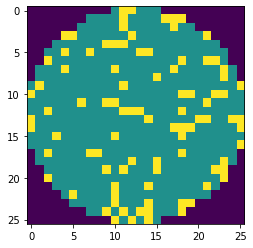

In [31]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

- マスクの定義

In [32]:
# 0がウエハ領域，1が範囲外
mask = new_x[0, :, :, 0].copy()
#out_region = np.where(mask == 1.0)
#in_region = np.where(mask == 0.0)
#mask[out_region] = 0.0
#mask[in_region] = 1.0
print(mask)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
  1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
  1. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
  1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  1. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0.

- 回転の実験

90度ごとなら自作OpenCV関数が有用

In [33]:
from keras_preprocessing.image import apply_affine_transform
def rotation(img, degree):
    gendata = apply_affine_transform(img, channel_axis = 2, theta = degree, fill_mode = 'constant', cval = 0)
    plt.imshow(np.argmax(gendata, axis=2))
    plt.title("rotate " + str(degree) + " degree")
    plt.show()
    

In [34]:
def rotation_cv2(img, degree):
    center = (img.shape[1]//2, img.shape[0]//2)
    affine = cv2.getRotationMatrix2D(center, -degree,  1.0)
    img_afn = cv2.warpAffine(img, affine, (img.shape[1]+1, img.shape[0]+1),borderMode = cv2.BORDER_CONSTANT,flags=cv2.INTER_LINEAR)

    plt.imshow(np.argmax(img_afn, axis=2))
    plt.title("rotate " + str(degree) + " degree")
    plt.show()

In [35]:
#90度用に自作　opencv利用
def rotation_cv2_select(img, degree):
    center = (img.shape[1]//2, img.shape[0]//2)
    affine = cv2.getRotationMatrix2D(center, -degree,  1.0)
    img_afn = cv2.warpAffine(img, affine, (img.shape[1]+1, img.shape[0]+1),borderMode = cv2.BORDER_CONSTANT,flags=cv2.INTER_LINEAR)
    
    if ((degree % 360) // 90) == 0:
        img_afn = img_afn[0:26, 0:26, :]
    elif ((degree % 360) // 90) == 1:
        img_afn = img_afn[0:26, 1:27, :]
    elif ((degree % 360) // 90) == 2:
        img_afn = img_afn[1:27, 1:27, :]
    elif ((degree % 360) // 90) == 3:
        img_afn = img_afn[1:27, 0:26, :]
    
    #ずれ表示用
    error = np.where((np.argmax(img, axis=2) != np.argmax(img_afn, axis=2)) & ((np.argmax(img, axis=2) == 0) | (np.argmax(img_afn, axis=2) == 0)))
    print(error)
    
    plt.imshow(np.argmax(img_afn, axis=2))
    plt.title("rotate " + str(degree) + " degree")
    plt.show()

In [36]:
#90度用に自作　opencv利用 マスク適用
def rotation_cv2_select_mask(img, degree):
    center = (img.shape[1]//2, img.shape[0]//2)
    affine = cv2.getRotationMatrix2D(center, -degree,  1.0)
    img_afn = cv2.warpAffine(img, affine, (img.shape[1]+1, img.shape[0]+1),borderMode = cv2.BORDER_CONSTANT,flags=cv2.INTER_LINEAR)
    
    if ((degree % 360) // 90) == 0:
        img_afn = img_afn[0:26, 0:26, :]
    elif ((degree % 360) // 90) == 1:
        img_afn = img_afn[0:26, 1:27, :]
    elif ((degree % 360) // 90) == 2:
        img_afn = img_afn[1:27, 1:27, :]
    elif ((degree % 360) // 90) == 3:
        img_afn = img_afn[1:27, 0:26, :]
    
    #ずれ表示用
    error = np.where((np.argmax(img, axis=2) != np.argmax(img_afn, axis=2)) & ((np.argmax(img, axis=2) == 0) | (np.argmax(img_afn, axis=2) == 0)))
    print(error)
    
    #マスクの適用
    out_region = np.where((img_afn[:, :, 0] != mask) & (mask > 0.0))
    img_afn[out_region] = np.array([1., 0., 0.])
    in_region = np.where((img_afn[:, :, 0] != mask) & (mask == 0.0))
    img_afn[in_region] = np.array([0., 1., 0.])
    
    #再度ずれ表示用
    error = np.where((np.argmax(img, axis=2) != np.argmax(img_afn, axis=2)) & ((np.argmax(img, axis=2) == 0) | (np.argmax(img_afn, axis=2) == 0)))
    print(error)
    
    plt.imshow(np.argmax(img_afn, axis=2))
    plt.title("rotate " + str(degree) + " degree")
    plt.show()

- 90度ごとの回転

In [37]:
#90度以外　opencv利用 マスク適用　サイズの違いでうまくいっていない
def rotation_cv2_mask(img, degree):
    center = (img.shape[1]//2, img.shape[0]//2)
    affine = cv2.getRotationMatrix2D(center, -degree,  1.0)
    img_afn = cv2.warpAffine(img, affine, (img.shape[1]+1, img.shape[0]+1),borderMode = cv2.BORDER_CONSTANT,flags=cv2.INTER_LINEAR)
    
    #ずれ表示用
    error = np.where((np.argmax(img, axis=2) != np.argmax(img_afn, axis=2)) & ((np.argmax(img, axis=2) == 0) | (np.argmax(img_afn, axis=2) == 0)))
    print(error)
    
    #マスクの適用
    out_region = np.where((img_afn[:, :, 0] != mask) & (mask > 0.0))
    img_afn[out_region] = np.array([1., 0., 0.])
    in_region = np.where((img_afn[:, :, 0] != mask) & (mask == 0.0))
    img_afn[in_region] = np.array([0., 1., 0.])
    
    #再度ずれ表示用
    error = np.where((np.argmax(img, axis=2) != np.argmax(img_afn, axis=2)) & ((np.argmax(img, axis=2) == 0) | (np.argmax(img_afn, axis=2) == 0)))
    print(error)
    
    plt.imshow(np.argmax(img_afn, axis=2))
    plt.title("rotate " + str(degree) + " degree")
    plt.show()

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


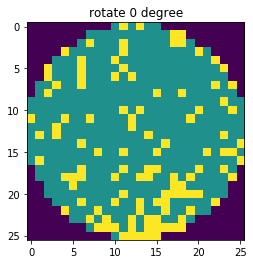

(array([ 0,  0,  2,  2,  5,  9,  9, 16, 16, 20, 20, 23, 25, 25]), array([ 9, 16,  5, 20, 23,  0, 25,  0, 25,  2, 23, 20,  9, 16]))
(array([], dtype=int64), array([], dtype=int64))


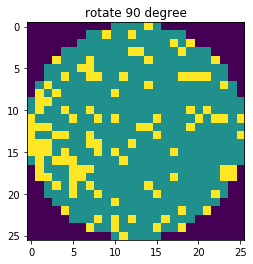

(array([ 2, 23]), array([20,  5]))
(array([], dtype=int64), array([], dtype=int64))


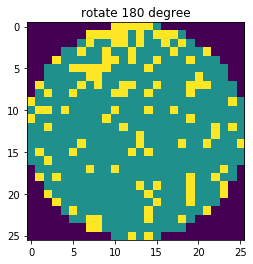

(array([ 0,  0,  2,  2,  5,  5,  9,  9, 16, 16, 20, 23, 25, 25]), array([ 9, 16,  5, 20,  2, 23,  0, 25,  0, 25,  2, 20,  9, 16]))
(array([], dtype=int64), array([], dtype=int64))


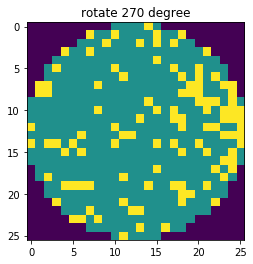

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


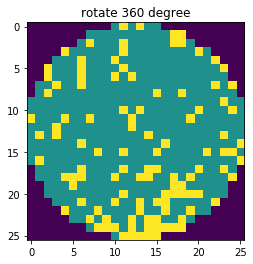

In [38]:
wafer = new_x[np.where(y=="Edge-Loc")[0]].reshape(len(np.where(y=="Edge-Loc")[0]), 26, 26, 3)
#plt.imshow(np.argmax(wafer[0], axis=2))
#plt.show()

for i in range(5):
    rotation_cv2_select_mask(wafer[0], i*90)

- 90度以外の回転

In [40]:
#90度以外　opencv利用 マスク適用　サイズの違いでうまくいっていない
def rotation_cv2_mask(img, degree):
    center = (img.shape[1]//2, img.shape[0]//2)
    affine = cv2.getRotationMatrix2D(center, -degree,  1.0)
    img_afn = cv2.warpAffine(img, affine, (img.shape[1]+1, img.shape[0]+1),borderMode = cv2.BORDER_CONSTANT,flags=cv2.INTER_LINEAR)
    
    #ずれ表示用
    error = np.where((np.argmax(img, axis=2) != np.argmax(img_afn, axis=2)) & ((np.argmax(img, axis=2) == 0) | (np.argmax(img_afn, axis=2) == 0)))
    print(error)
    
    #マスクの適用
    out_region = np.where((img_afn[:, :, 0] != mask) & (mask > 0.0))
    img_afn[out_region] = np.array([1., 0., 0.])
    in_region = np.where((img_afn[:, :, 0] != mask) & (mask == 0.0))
    img_afn[in_region] = np.array([0., 1., 0.])
    
    #再度ずれ表示用
    error = np.where((np.argmax(img, axis=2) != np.argmax(img_afn, axis=2)) & ((np.argmax(img, axis=2) == 0) | (np.argmax(img_afn, axis=2) == 0)))
    print(error)
    
    plt.imshow(np.argmax(img_afn, axis=2))
    plt.title("rotate " + str(degree) + " degree")
    plt.show()

In [42]:
print(wafer[0].shape)

(26, 26, 3)


In [59]:
from PIL import Image
def rotation_pil_mask(img, degree):
    src = Image.fromarray(np.uint8(img))
    img_rotate = np.array(src.rotate(degree))
    
    #before
    '''
    plt.imshow(np.argmax(img_rotate, axis=2))
    plt.title("rotate " + str(degree) + " degree before")
    plt.show()
    '''
    
    #マスクの適用, 
    out_region = np.where((np.argmax(img_rotate, axis=2) != 0) & (mask > 0.0))
    img_rotate[out_region[0], out_region[1]] = np.array([1., 0., 0.])
    in_region = np.where((np.argmax(img_rotate, axis=2) == 0) & (mask == 0.0))
    img_rotate[in_region[0], in_region[1]] = np.array([0., 1., 0.])

    #after
    plt.imshow(np.argmax(img_rotate, axis=2))
    plt.title("rotate " + str(degree) + " degree after")
    plt.show()

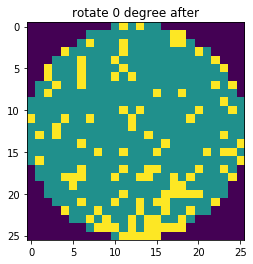

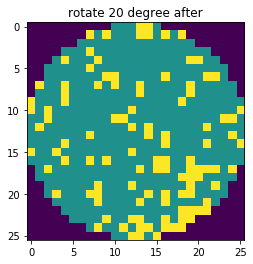

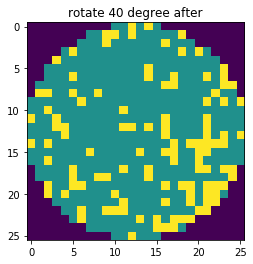

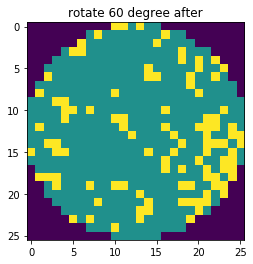

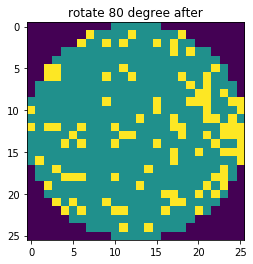

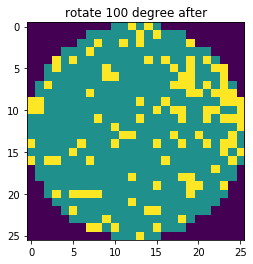

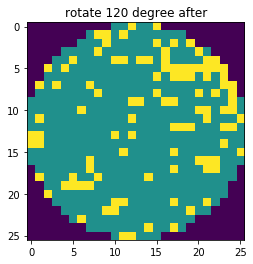

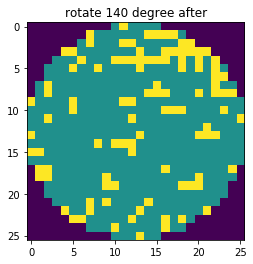

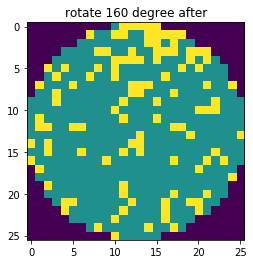

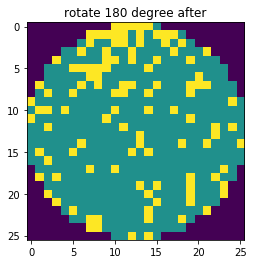

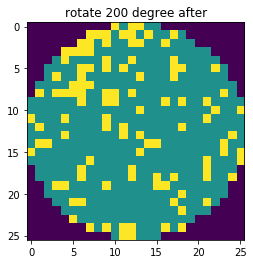

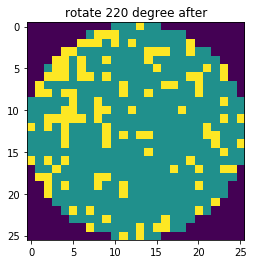

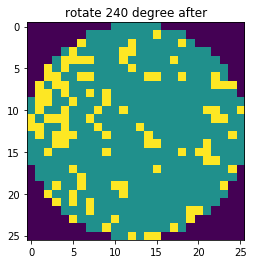

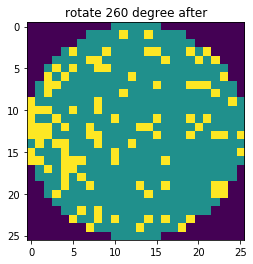

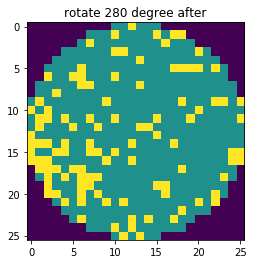

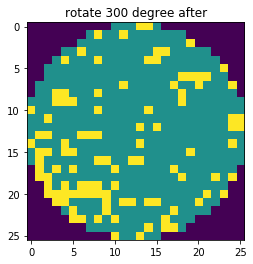

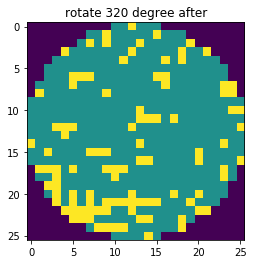

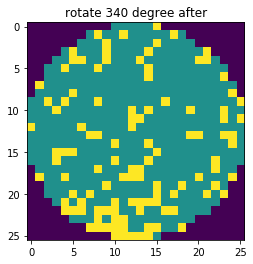

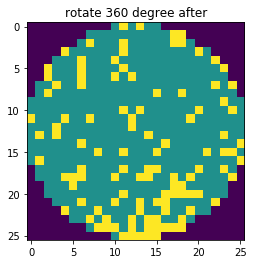

In [61]:
wafer = new_x[np.where(y=="Edge-Loc")[0]].reshape(len(np.where(y=="Edge-Loc")[0]), 26, 26, 3)
#plt.imshow(np.argmax(wafer[0], axis=2))
#plt.show()

for i in range(19):
    rotation_pil_mask(wafer[0], i*20)

- ノイズが付加されたウエハ画像

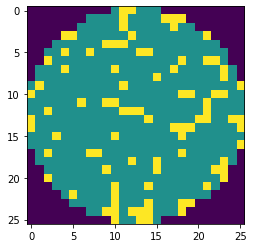

In [42]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

### データオーギュメンテーション

- データオーギュメンテーションを行う関数を定義する．
- 鏡映，回転を行う

In [43]:
# augment function define (add rotate, flip)
def gen_data(wafer, label):
    # Encode input wafer
    #encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    aug_x = np.zeros((1, 26, 26, 3))
    
    #datagen = ImageDataGenerator(rotation_range = 90, horizontal_flip = True, vertical_flip = True, fill_mode = 'constant', cval = 0)
    datagen = ImageDataGenerator(rotation_range = 0)
    #ite = 20 if label != 'none' else 2
    ite = 0
    
    gen = datagen.flow(wafer, batch_size = len(wafer))
    for i in range(ite):
        data = next(gen)
        #print(data.shape)
        aug_x = np.concatenate((aug_x, data), axis = 0)
        '''
        for j, img in enumerate(data):
            plot_num = j+1
            plt.subplot(4, 5, plot_num)
            plt.tick_params(labelbottom=False)
            plt.tick_params(labelleft=False)
            plt.imshow(img)
        plt.show()
        '''
    #aug_x -> waferに変更
    encoded_x = encoder.predict(wafer)
    #print(encoded_x.shape)
        
    
    # Make wafer until total # of wafer to 15000
    if label != 'none':
        for i in range((2000//len(encoded_x)) + 1):
            noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
            noised_gen_x = decoder.predict(noised_encoded_x)
            gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    else:
        gen_x = aug_x
        
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

- データオーギュメンテーション（ノイズ付加）したものが適切か調べる

一番左が元画像
右がデータオーギュメンテーション後

In [44]:
a = np.empty((0, 26, 26, 3))
b = np.empty((0,1))

# Augmentation for all faulty case.
for f in faulty_case :     
    a = np.concatenate((a, new_x[np.where(y==f)[0][0]].reshape(1, 26, 26, 3)), axis=0)
    b = np.concatenate((b, f.reshape(1, 1)))
    
    for i in range(9):
        encoded_x = encoder.predict(new_x[np.where(y==f)[0][0]].reshape(1, 26, 26, 3))
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        a = np.concatenate((a, noised_gen_x), axis=0)
        b = np.concatenate((b, f.reshape(1, 1)))

print(a.shape, b.shape)

(90, 26, 26, 3) (90, 1)


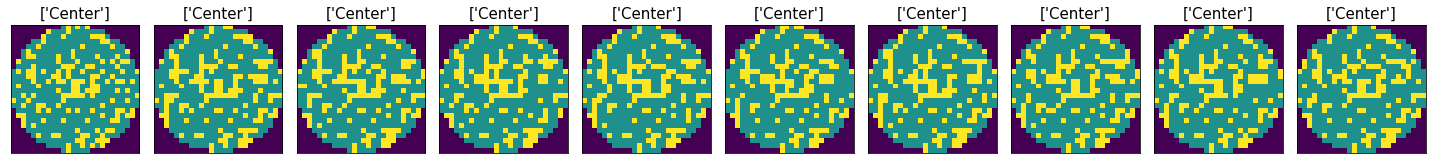

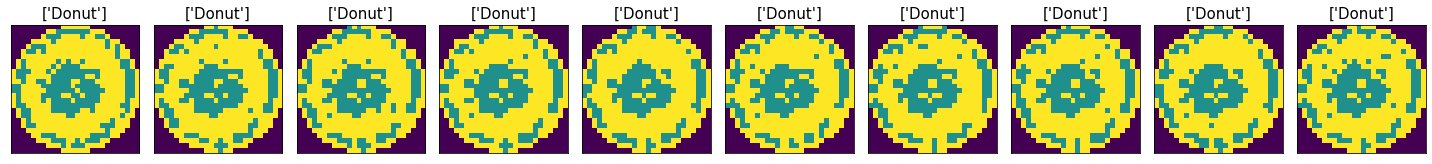

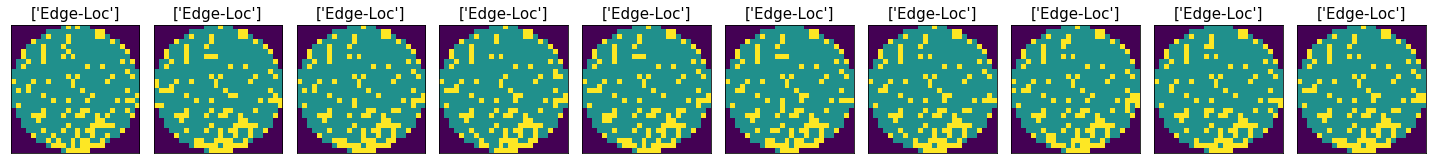

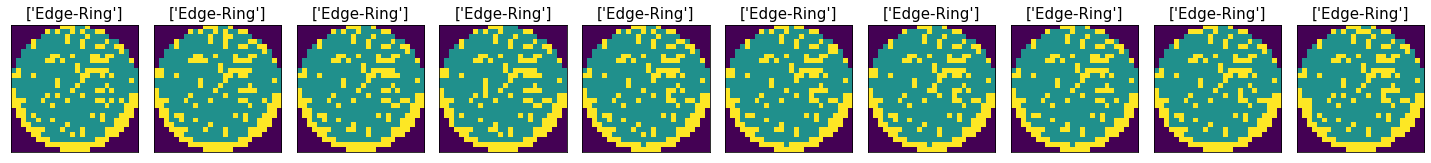

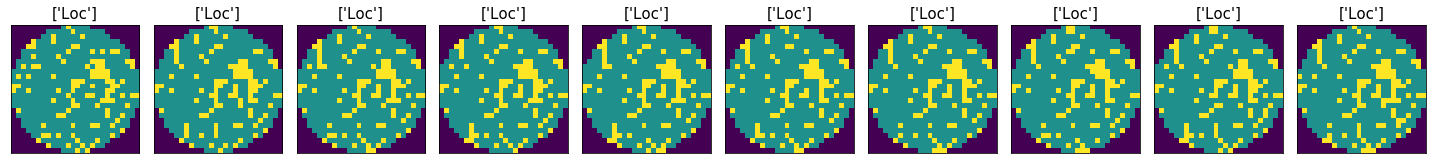

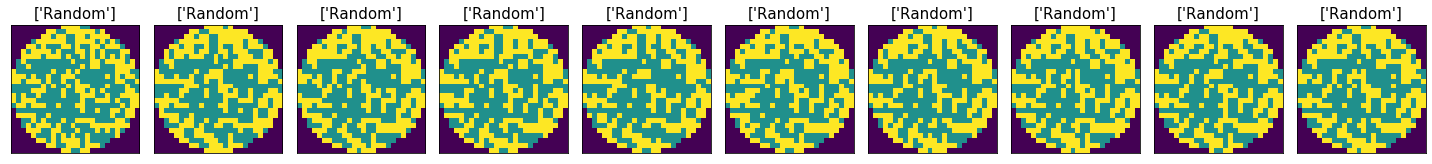

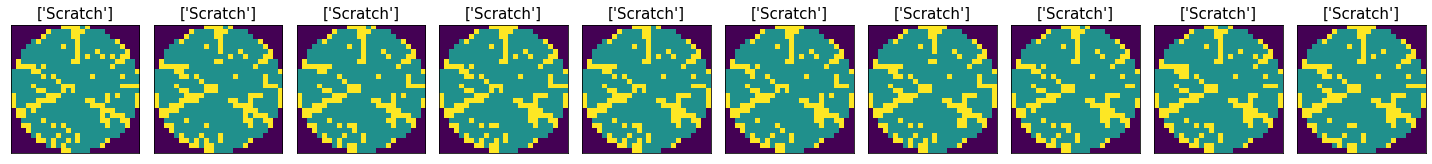

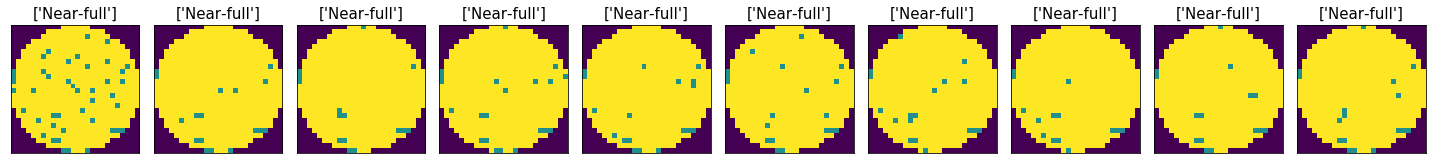

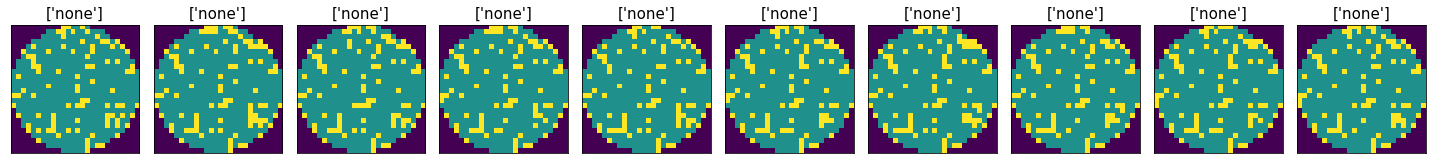

"\n# 四捨五入関数\nmy_round_int = lambda x: np.round((x * 2 + 1) // 2)\n\nfor k in x:\n    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(20, 20))\n    ax = ax.ravel(order='C')\n    for j in [k]:\n        index = np.where(b==labels2[j])[0]\n        img = a[index]\n        #img = new_x[0:10]\n        for i in range(10):\n            img[i] = my_round_int(img[i]).astype(int)\n            ax[i].imshow(np.argmax(img[i+0], axis=2))\n            ax[i].set_title(b[index[i+0]], fontsize=15)\n            #ax[i].set_xlabel(df_withpattern.index[img.index[i]], fontsize=10)\n            ax[i].set_xticks([])\n            ax[i].set_yticks([])\n            \n    plt.tight_layout()\n    plt.show() \n"

In [45]:
x = [0,1,2,3,4,5,6,7,8]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full','none']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(20, 20))
    ax = ax.ravel(order='C')
    for j in [k]:
        index = np.where(b==labels2[j])[0]
        img = a[index]
        #img = new_x[0:10]
        for i in range(10):
            ax[i].imshow(np.argmax(img[i+0], axis=2))
            ax[i].set_title(b[index[i+0]], fontsize=15)
            #ax[i].set_xlabel(df_withpattern.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 
    
'''
# 四捨五入関数
my_round_int = lambda x: np.round((x * 2 + 1) // 2)

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(20, 20))
    ax = ax.ravel(order='C')
    for j in [k]:
        index = np.where(b==labels2[j])[0]
        img = a[index]
        #img = new_x[0:10]
        for i in range(10):
            img[i] = my_round_int(img[i]).astype(int)
            ax[i].imshow(np.argmax(img[i+0], axis=2))
            ax[i].set_title(b[index[i+0]], fontsize=15)
            #ax[i].set_xlabel(df_withpattern.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            
    plt.tight_layout()
    plt.show() 
'''

- 不良ラベルが付いているデータに対してデータオーギュメンテーションを行う．

In [46]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    #if f == 'none' : 
    #    continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

In [47]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (30671, 26, 26, 3), new_y shape : (30671, 1)


In [48]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))
new_y = y

Center : 2160
Donut : 2002
Edge-Loc : 2312
Edge-Ring : 2024
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2130
none : 13489


In [49]:
np.where(new_y=='Center')[1]

array([0, 0, 0, ..., 0, 0, 0])

- ノイズ付加後におかしなデータがあるかチェック
- 元データとずれがあるもの：1689枚

### ノイズ付加後もマスクで直す

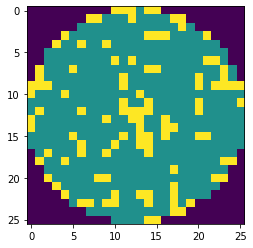

In [50]:
plt.imshow(np.argmax(new_x[14397], axis=2))
plt.show()

In [51]:
backup_new_x = new_x.copy()
backup_new_y = new_y.copy()

751
0


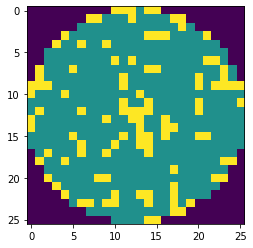

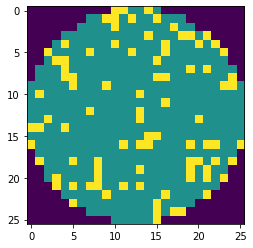

In [53]:
count = 0
for i in range(len(new_x)):
    error = np.where((np.argmax(new_x[0], axis=2) != np.argmax(new_x[i], axis=2)) & (np.argmax(new_x[0], axis=2) == 0))
    if len(error[0]) > 0:
        #print(str(i) + "error")
        #print(error)
        count += 1
print(count)

for i in range(len(new_x)):
    #マスクの適用, 
    out_region = np.where((np.argmax(new_x[i], axis=2) != 0) & (mask > 0.0))
    new_x[i, out_region[0], out_region[1]] = np.array([1., 0., 0.])
    in_region = np.where((np.argmax(new_x[i], axis=2) == 0) & (mask == 0.0))
    new_x[i, in_region[0], in_region[1]] = np.array([0., 1., 0.])
    
count = 0
for i in range(len(new_x)):
    error = np.where((np.argmax(new_x[0], axis=2) != np.argmax(new_x[i], axis=2)) & (np.argmax(new_x[0], axis=2) == 0))
    if len(error[0]) > 0:
        #print(str(i) + "error")
        #print(error)
        count += 1
print(count)

plt.imshow(np.argmax(new_x[14397], axis=2))
plt.show()
plt.imshow(np.argmax(new_x[0], axis=2))
plt.show()

In [ ]:
print(new_x[14397, :, :, 2])

### ノイズが2回かかっている？？？

In [ ]:
index = 16436
#print(new_x[index])
#print(new_y[index])
ind = np.where(new_y=='Donut')[0]

ex = encoder.predict(new_x[index].reshape((1, 26, 26, 3)))
nx = ex + np.random.normal(loc=0, scale=0.1, size = (1, 13, 13, 64)) 
nx = decoder.predict(nx)
#nx = np.array(nx[0], dtype='int64')
#print(nx)

#plt.imshow(np.argmax(nx[0], axis=2))
#plt.show()

plt.imshow(np.argmax(new_x[0], axis=2))
plt.show()

- データオーギュメンテーションを行った結果，各不良データごとに約40000枚に増えた．
- 合計は368112枚となった．

In [ ]:
x = [0,1,2,3,4,5,6,7,8]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full','none']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(20, 20))
    ax = ax.ravel(order='C')
    for j in [k]:
        index = np.where(new_y==labels2[j])[0]
        img = new_x[index]
        #img = new_x[0:10]
        for i in range(10):
            ax[i].imshow(np.argmax(img[i+0], axis=2))
            ax[i].set_title(new_y[index[i+0]], fontsize=15)
            #ax[i].set_xlabel(df_withpattern.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

### 学習を行う
- 不良ラベルを0-8の9次元のベクトルとして表現する．
- one-hotエンコーディングを行っている．

In [ ]:
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i

In [ ]:
# one-hot-encoding
new_y = to_categorical(new_y)

In [ ]:
new_X=new_x
new_Y=new_y

- 学習データとテストデータに分割する．

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(new_X, new_Y,
                                                    test_size=0.33,
                                                    random_state=2019)

In [ ]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

- 学習データ246635枚，テストデータ121477枚．

- モデルの定義を行う．

In [ ]:
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)

def create_model():
    global input_tensor
    
    conv = layers.Conv2D(32, (3,3), activation='relu', name='conv1')(input_tensor)
    padding = layers.ZeroPadding2D(padding=(1, 1), name='padding1')(conv)
    conv = layers.Conv2D(64, (3,3), activation='relu', name='conv2')(padding)
    padding = layers.ZeroPadding2D(padding=(1, 1), name='padding2')(conv)
    conv = layers.Conv2D(128, (3,3), activation='relu', name='conv3')(padding)
    padding = layers.ZeroPadding2D(padding=(1, 1), name='padding3')(conv)
    conv_out = layers.Conv2D(256, (3,3), activation='relu', name='conv4')(padding)

    gap_layer = layers.GlobalAveragePooling2D(name='GAP')
    output_layer = layers.Dense(9, activation='softmax', name='output')

    aver_pool = gap_layer(conv_out)
    output_tensor = output_layer(aver_pool)

    model = models.Model(input_tensor, output_tensor)

    model.compile(optimizer='Adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

    return model

- 3-Fold Cross validationで分割して学習する．

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=512, verbose=1) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Class Activation Map Cross validation score : {:.4f}'.format(np.mean(results)))

- Cross validiationによる精度は99.10%であった．

- Cross validationなしで学習する．

In [ ]:
history = model.fit(x_train, y_train,
         validation_data=[x_test, y_test],
         epochs=50,
         batch_size=512,
         verbose=1
         )

- テストデータで評価．    

In [ ]:
score = model.score(x_test, y_test)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score)

- モデルは以下．
    - 入力層
    - 畳み込み層3つ
    - Flatten層（1次元に）
    - 全結合層3つ

In [ ]:
model.model.summary()

- accuracyグラフ，lossグラフは以下．
- 5epoch程度で落ち着いている．

In [ ]:
# accuracy plot 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### クラス活性化マップ

In [ ]:
#set target wafer number
target_wafer_num = 2
# predict 
prob = model.model.predict(x_test[target_wafer_num].reshape(1,26,26,3))

In [ ]:
aver_output = model.model.layers[7]
aver_model = models.Model(input_tensor, aver_output.output)
cam_result = aver_model.predict(x_test[target_wafer_num].reshape(1, 26, 26, 3))

In [ ]:
weight_result = model.model.layers[-1].get_weights()[0]

In [ ]:
def make_cam(cam_result, weight_result): 
    cam_arr = np.zeros((1,24, 24))
    for row in range(0,9):
        cam = np.zeros((1, 24, 24))
        for i, w in enumerate(weight_result[:, row]):
            cam += (w*cam_result[0,:,:,i]).reshape(24,24)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
        cam[mask_x == 0] = 0
        cam_arr = np.concatenate((cam_arr, cam))
    return cam_arr[1:]

def display_activation(cam_arr, prob, wafer): 
    fig, ax = plt.subplots(9, 1, figsize=(50, 50))
    count = 0
    cam_arr[np.percentile(cam_arr, 0.8) > cam_arr] = 0
    for row in range(0,9):
        ax[row].imshow(np.argmax(wafer, axis=2))
        ax[row].imshow(cam_arr[row],cmap='Reds', alpha=0.7)
        ax[row].set_title('class : ' + faulty_case_dict[count]+', prob : {:.4f}'.format(prob[:, count][0]*100) + '%')
        count += 1

In [ ]:
faulty_case_dict[np.argmax(y_test[target_wafer_num])]

In [ ]:
plt.imshow(np.argmax(x_test[target_wafer_num], axis=2))
print('faulty case : {}'.format(faulty_case_dict[np.argmax(y_test[target_wafer_num])]))

- 対象のウエハの画像と不良パターンの表示

In [ ]:
cam_result.shape

In [ ]:
cam_arr = make_cam(cam_result, weight_result)

In [ ]:
prob.shape

In [ ]:
display_activation(cam_arr, prob, x_test[target_wafer_num])

- 活性化マップの表示
- ドーナツでは円形状にヒートマップの赤い部分が点在している

### CNN

In [ ]:
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
def create_model():


    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

- 3-Fold Cross validationで分割して学習する．

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=1024, verbose=1) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

- Cross validiationによる精度は99.55%であった．

- Cross validationなしで学習する．

In [ ]:
history = model.fit(x_train, y_train,
         validation_data=[x_test, y_test],
         epochs=epoch,
         batch_size=batch_size,
         verbose=1           
         )

- テストデータで評価．    

In [ ]:
score = model.score(x_test, y_test)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score)

- acuurayは99.70%であった．

- モデルは以下．
    - 入力層
    - 畳み込み層3つ
    - Flatten層（1次元に）
    - 全結合層3つ

In [ ]:
model.model.summary()

- accuracyグラフ，lossグラフは以下．
- 5epoch程度で落ち着いている．

In [ ]:
# accuracy plot 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#y_train_pred = np.argmax(model.predict(x_train))
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
y_train_max = np.argmax(y_train, axis=1)
y_test_max = np.argmax(y_test, axis=1)

print(y_train_max[0])
print(y_train_pred[0])

train_acc2 = np.sum(y_train_max == y_train_pred, axis=0, dtype='float') / x_train.shape[0]
test_acc2 = np.sum(y_test_max == y_test_pred, axis=0, dtype='float') / x_test.shape[0]
print('Training acc: {}'.format(train_acc2*100))
print('Testing acc: {}'.format(test_acc2*100))
print("y_train_pred[:100]: ", y_train_pred[:100])
print ("y_train_max[:100]: ", y_train_max[:100])

### 混同行列

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_max, y_test_pred)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(8, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()

### クラス活性化マップ

In [ ]:
#set target wafer number
target_wafer_num = 100000
# predict 
prob = model.model.predict(x_test[target_wafer_num].reshape(1,26,26,3))

In [ ]:
aver_output = model.model.layers[3]
aver_model = models.Model(input_tensor, aver_output.output)
cam_result = aver_model.predict(x_test[target_wafer_num].reshape(1, 26, 26, 3))

In [ ]:
print(model.model.layers[3].name)

In [ ]:
weight_result = model.model.layers[-1].get_weights()[0]

In [ ]:
def make_cam(cam_result, weight_result): 
    cam_arr = np.zeros((1,26, 26))
    for row in range(0,9):
        cam = np.zeros((1, 26, 26))
        for i, w in enumerate(weight_result[:, row]):
            cam += (w*cam_result[0,:,:,i]).reshape(26,26)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
        cam[mask_x == 0] = 0
        cam_arr = np.concatenate((cam_arr, cam))
    return cam_arr[1:]

def display_activation(cam_arr, prob, wafer): 
    fig, ax = plt.subplots(9, 1, figsize=(50, 50))
    count = 0
    cam_arr[np.percentile(cam_arr, 0.8) > cam_arr] = 0
    for row in range(0,9):
        ax[row].imshow(np.argmax(wafer, axis=2))
        ax[row].imshow(cam_arr[row],cmap='Reds', alpha=0.7)
        ax[row].set_title('class : ' + faulty_case_dict[count]+', prob : {:.4f}'.format(prob[:, count][0]*100) + '%')
        count += 1

In [ ]:
faulty_case_dict[np.argmax(y_test[target_wafer_num])]

In [ ]:
plt.imshow(np.argmax(x_test[target_wafer_num], axis=2))
print('faulty case : {}'.format(faulty_case_dict[np.argmax(y_test[target_wafer_num])]))

- 対象のウエハの画像と不良パターンの表示

In [ ]:
cam_result.shape

In [ ]:
mask_x = np.zeros((26, 26))
dummy_x = cv2.resize(x[0], (26,26))
mask_x[dummy_x == 1] = 1 
mask_x[dummy_x == 2] = 1 
mask_x = mask_x.reshape((1, 26,26))

In [ ]:
cam_arr = make_cam(cam_result, weight_result)

In [ ]:
prob.shape

In [ ]:
display_activation(cam_arr, prob, x_test[target_wafer_num])

- 活性化マップの表示
- ドーナツでは円形状にヒートマップの赤い部分が点在している